# Reply Tool - Workflow Engagement Metrics
**Last Update: 5 January 2020**

[Task](https://phabricator.wikimedia.org/T247139)



# Table of Contents

1. [Are people publishing the replies they start?](#1.-Are-people-publishing-the-replies-they-start?)
2. [Are people satisfied with the feature?](#2.-Are-people-satisfied-with-the-feature?)
3. [Are people posting disruptive comments?](#3.-Are-people-posting-disruptive-comments?)


# Overview

The [Editing team](https://www.mediawiki.org/wiki/Editing_team) deployed the reply tool as an opt-out preference on Arabic (arwiki), Czech (cswiki) and Hungarian (huwiki) Wikipedias on 24 September 2020. Further information about the Editing team's work on the tool including the design, deployment process, and status updates is available on the [project page](https://www.mediawiki.org/wiki/Talk_pages_project/replying). The purpose of this task is to analyze how people are engaging with the new Replying tool to help answer these questions:

* Are people are having success using the feature?
* Are people using the tool in ways that negatively impact the experience of others?

Results of this analysis will be used to determine what - if any - changes should be made to the workflow before deploying the feature to more people and beginning and A/B test to determine its impact.

For this analysis, we reviewed eventlogging data from 24 September 2020 (date of deployment an an opt-out preference) through 08 December 2020. For each metric below, we provided a breakdown by wiki where deployed as opt-out and the users' experience level based on cumulative edits.

In [515]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [2]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(magrittr); library(zeallot); library(glue); library(tidyverse); library(zoo); library(lubridate)
    library(scales)
})

# 1. Are people publishing the replies they start?

## **Reply Tool Funnel** :

We reviewed a sample of data from [EditAttemptStep](https://meta.wikimedia.org/wiki/Schema:EditAttemptStep) to determine the percent of users that successfully met each step of the reply tool workflow. Specifically, we reviewed the following:
* Of the people who click a [ reply ] link (action = 'init'), what % of people see the interface ready (action = 'ready')?
* Of the people who see the interface is ready action = 'ready, what % of people start typing a comment (action = 'firstChange')?
* Of the people who start typing a comment (action = 'firstChange'), what % of people click the Reply button (action = 'saveIntent')?
* Of the people who click the Reply button (action = 'saveIntent'), what % of people successfully publish the comment they were drafting (action = 'saveSuccess')?

The data below reflects the number of users not sessions. These are counts of the percentage of unique people who, at some point during the reviewed timeframe between 24 September 2020 and 08 December 2020, that reached a step (e.g. init, ready, firstchange, etc.) in the Reply Tool comment funnel. Anonymous users were excluded from the analysis as we do not track distinct anonymous users.

The worflow funnel charts below reflects the percent of all reply tool users that clicked a reply link (reached `init`) and completed  each step to save their comment. The chart is divided to show the workflow funnel for each user experience level based on the number of cumulative edits. 


In [263]:
# collect data on reply tool users workflow completion steps
query <- 
"
--only include full sessions where an init was also logged during the timeframe 
   
WITH init_sessions AS (
SELECT 
  event.editing_session_id AS session_id,
  wiki AS wiki
FROM event_sanitized.editattemptstep
WHERE
  event.action = 'init'
  AND year = 2020
  AND dt between '2020-09-24' AND '2020-12-08'
-- review wikis where deployed as opt-out
  AND wiki IN ('arwiki', 'cswiki', 'huwiki')
  AND event.integration= 'discussiontools'
-- remove anonymous users
  AND event.user_id != 0
)
-- review steps completed by each user
SELECT
user,
wiki,
min(edit_count) AS edit_count,
-- select first editing interface show to user
min(editor_interface) AS editor_interface,
sum(cast(action = 'init' as int)) >= 1 AS init_completed,
sum(cast(action = 'ready' as int)) >= 1 AS ready_completed,
sum(cast(action = 'firstChange' as int)) >= 1 AS firstChange_completed,
sum(cast(action = 'saveIntent' as int)) >= 1 AS saveIntent_completed,
sum(cast(action = 'saveSuccess' as int)) >= 1 AS saveSuccess_completed
FROM (
SELECT
  eas.event.user_editcount AS edit_count,
  eas.event.user_id AS user,
  eas.event.editing_session_id AS session_id,
  eas.event.editor_interface AS editor_interface,
  eas.event.action AS action,
  eas.wiki AS wiki,
  COUNT(*) AS events
FROM event_sanitized.editattemptstep eas
INNER JOIN
    init_sessions 
    ON eas.event.editing_session_id = init_sessions.session_id 
    AND eas.wiki = init_sessions.wiki
WHERE
  year = 2020 
-- events since deployment date through 08 December 2020
   AND dt between '2020-09-24' AND '2020-12-08'
-- review wikis where deployed as opt-out
  AND eas.wiki IN ('arwiki', 'cswiki', 'huwiki')
  AND eas.event.integration= 'discussiontools'
-- remove anonymous users
  AND eas.event.user_id != 0
GROUP BY 
  eas.event.user_id,
  eas.event.user_editcount,
  eas.event.action,
  eas.event.editor_interface,
  eas.event.editing_session_id,
  eas.wiki
) AS sessions_data
GROUP BY
user,
wiki
"


In [ ]:
collect_reply_workflow_steps <- wmfdata::query_hive(query)

In [265]:
# add column with user edit count buckets and by experience level

reply_workflow_with_editcount <- collect_reply_workflow_steps %>%
    mutate(edit_count_bucket = case_when(
            edit_count == 0 ~ '0 edits',
            edit_count >=1 & edit_count <= 4 ~ '1-4 edits',
            edit_count >=5 & edit_count <= 99 ~ '5-99 edits',
            edit_count >=100 & edit_count <= 999 ~ '100-999 edits',
            edit_count >=1000 ~ '1000+ edits'),
          experience_level = case_when( 
             edit_count < 100 ~ 'junior contributors (< 100 cumulative edits)',
             edit_count > 500 ~ 'senior contributors (> 500 cumulative edits)'))


In [266]:
# Order edit counts
reply_workflow_with_editcount$edit_count_bucket %<>% 
    factor(levels= c("0 edits", "1-4 edits", "5-99 edits", "100-999 edits", "1000+ edits"))

In [267]:
reply_users_workflow_funnel <- reply_workflow_with_editcount %>%
    group_by(wiki, edit_count_bucket, experience_level, editor_interface) %>%
    summarise(init = sum(init_completed == 'true'),
            ready = sum(ready_completed == 'true'),
               firstchange = sum(firstchange_completed == 'true'),
                saveintent = sum(saveintent_completed == 'true'),
                savesuccess = sum(savesuccess_completed == 'true'), .groups = 'drop')


In [268]:
# reorganize data so it can be easily charted 
reply_users_workflow_funnel_clean <- reply_users_workflow_funnel %>%
    gather("step", "n_users", 5:9) 


In [269]:
# order edit steps to correspond with the steps of the workflow
reply_users_workflow_funnel_clean$step %<>% 
    factor(levels= c("init","ready", "firstchange", "saveintent", "savesuccess"))


In [270]:
# Find total init sessions by edit count bucket across all three target wikis for both interfaces
init_users_overall <- reply_users_workflow_funnel_clean %>%
    group_by(edit_count_bucket) %>%
    filter(step == 'init')  %>%
    summarise(init_users_overall = sum(n_users), .groups = 'drop')
    

In [271]:
# Find total init sessions across all three target wikis by edit count bucket and editor_interface

init_users_byeditcount <- reply_users_workflow_funnel_clean %>%
    group_by(edit_count_bucket, editor_interface) %>%
    filter(step == 'init')  %>%
    summarise(init_users_byeditcount = sum(n_users), .groups = 'drop')
    



In [ ]:
# join with workflow table
reply_users_workflow_funnel_forplot_overall <- inner_join(reply_users_workflow_funnel_clean, init_users_overall)

In [ ]:
# join with workflow table
reply_users_workflow_funnel_forplot_editcount <- inner_join(reply_users_workflow_funnel_clean, init_users_byeditcount)

In [274]:
# Find total init sessions across all three target wikis by editor experience

init_users_byexperience <- reply_users_workflow_funnel_clean %>%
    group_by(experience_level, editor_interface) %>%
    filter(step == 'init',
            experience_level != 'NA' )  %>% # remove contributors not bucketed into senior or junior levels
    summarise(init_users_byexperience = sum(n_users), .groups = 'drop')
    

In [ ]:
# join with workflow table
reply_users_workflow_funnel_forplot_experience <- inner_join(reply_users_workflow_funnel_clean, init_users_byexperience)

In [276]:
# Find total init sessions across all three target wikis by editor experience for both interfaces

init_users_byexperience_both_interfaces <- reply_users_workflow_funnel_clean %>%
    group_by(experience_level) %>%
    filter(step == 'init',
            experience_level != 'NA' )  %>% # remove contributors not bucketed into senior or junior levels
    summarise(init_users_byexperience_both = sum(n_users), .groups = 'drop')
    

In [ ]:
# join with workflow table
reply_users_workflow_funnel_forplot_experience_both <- inner_join(reply_users_workflow_funnel_clean, init_users_byexperience_both_interfaces)

## Workflow funnel across all three opt-out wikis by user's experience level

### Comments made with VisualEditor

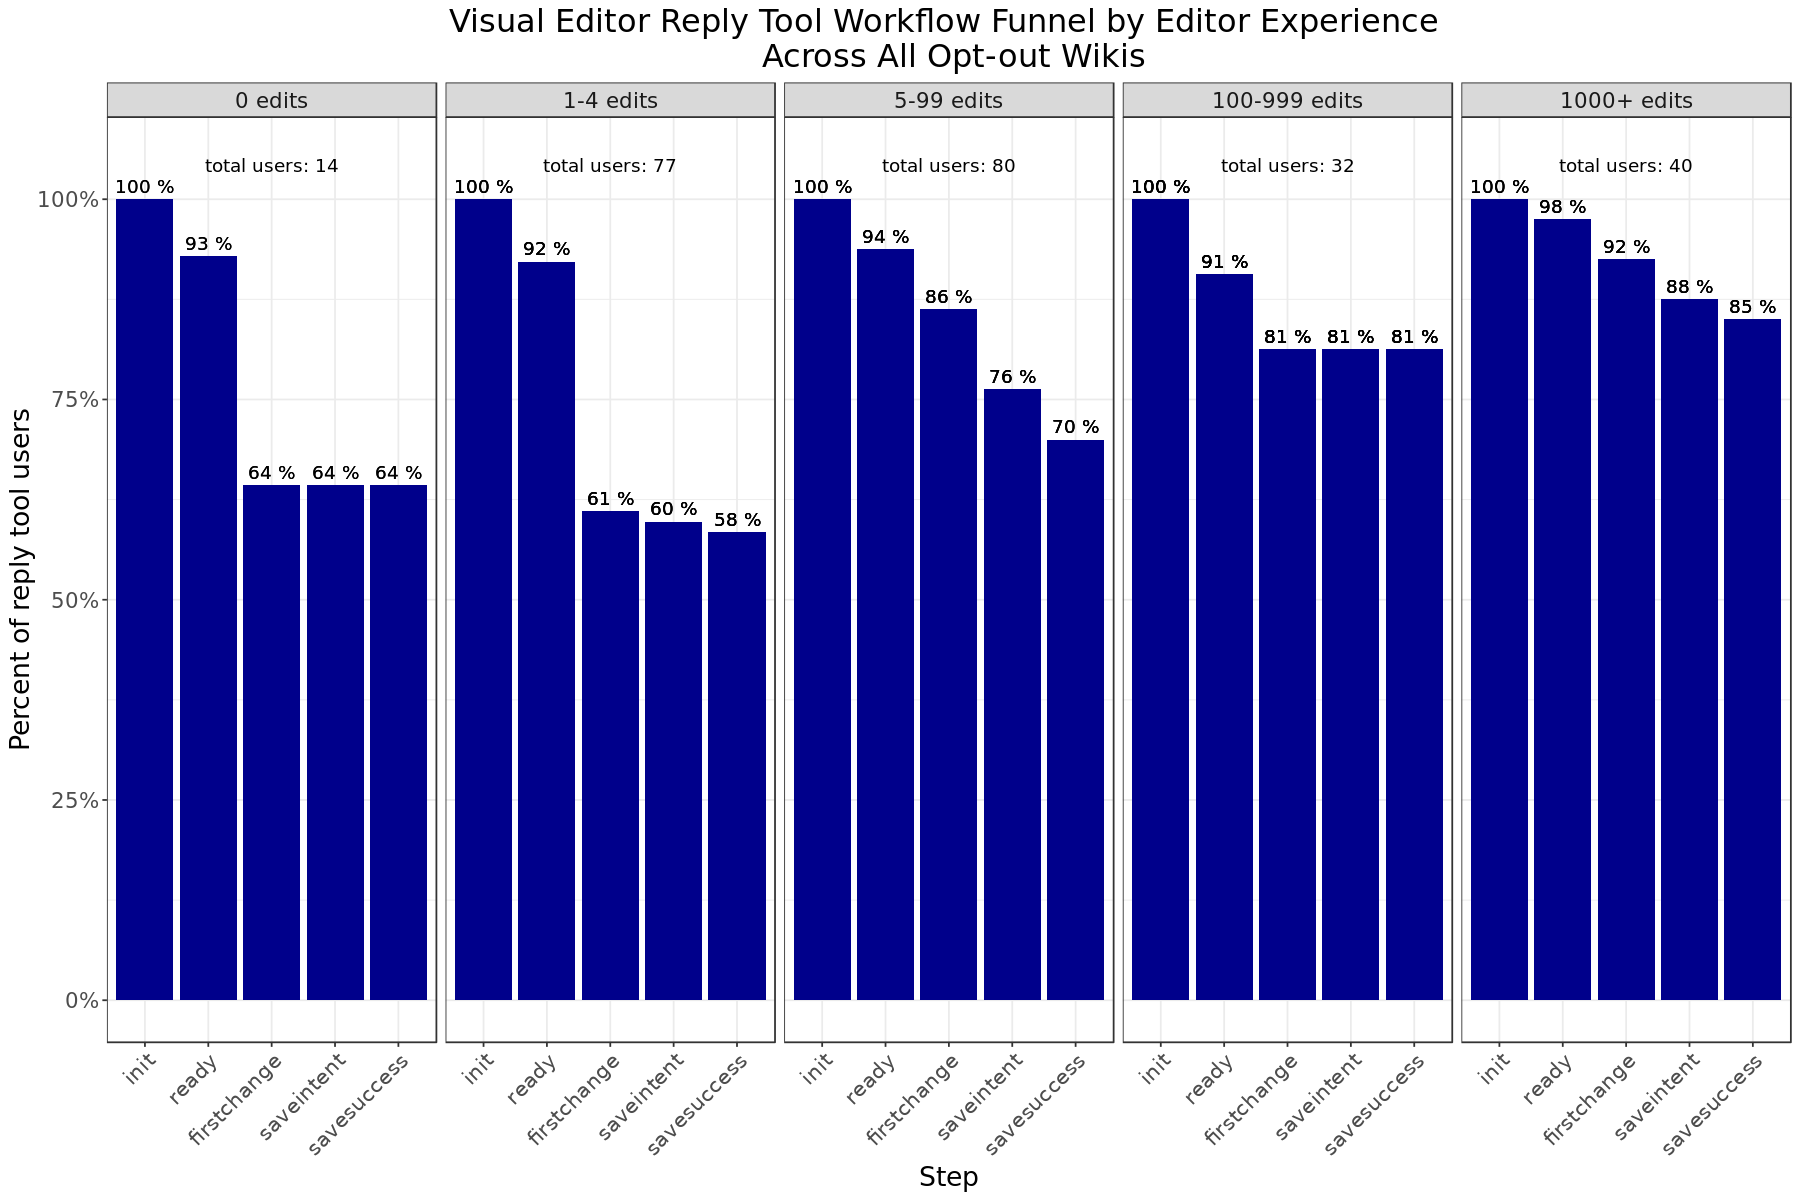

In [465]:
# plot workflow across all three target wikis on VE broken down by edit bucket

options(repr.plot.width = 15, repr.plot.height = 10)

p <- reply_users_workflow_funnel_forplot_editcount %>%
    filter(editor_interface == 'visualeditor') %>%
    group_by(step, edit_count_bucket, editor_interface) %>%
    summarise(n_users = sum(n_users),
              pct_users = n_users/init_users_byeditcount, .groups = 'drop') %>%
    ggplot(aes(x=step, y= pct_users)) +
        geom_bar(stat='identity', position = 'dodge', fill = 'darkblue') +
        geom_text(aes(label = paste(round(pct_users * 100), '%')), vjust=-0.5) +
        geom_text(aes(x,y,label=lab),
        data=data.frame(x= 'firstchange', y= 1.05, lab=c("total users: 14","total users: 77","total users: 80", "total users: 32", "total users: 40"),
             edit_count_bucket= c("0 edits", "1-4 edits", "5-99 edits", "100-999 edits", "1000+ edits" )), vjust=1) +
        facet_grid(~edit_count_bucket) +
        scale_y_continuous(labels = scales::percent) +
        labs (y = "Percent of reply tool users",
          x = "Step",
         title = "Visual Editor Reply Tool Workflow Funnel by Editor Experience \n Across All Opt-out Wikis")  +
         theme_bw() +
         theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
       legend.position = "none")
      
p

ggsave("Figures/ve_reply_workflow_overall_editcount.png", p, width = 16, height = 8, units = "in", dpi = 300)

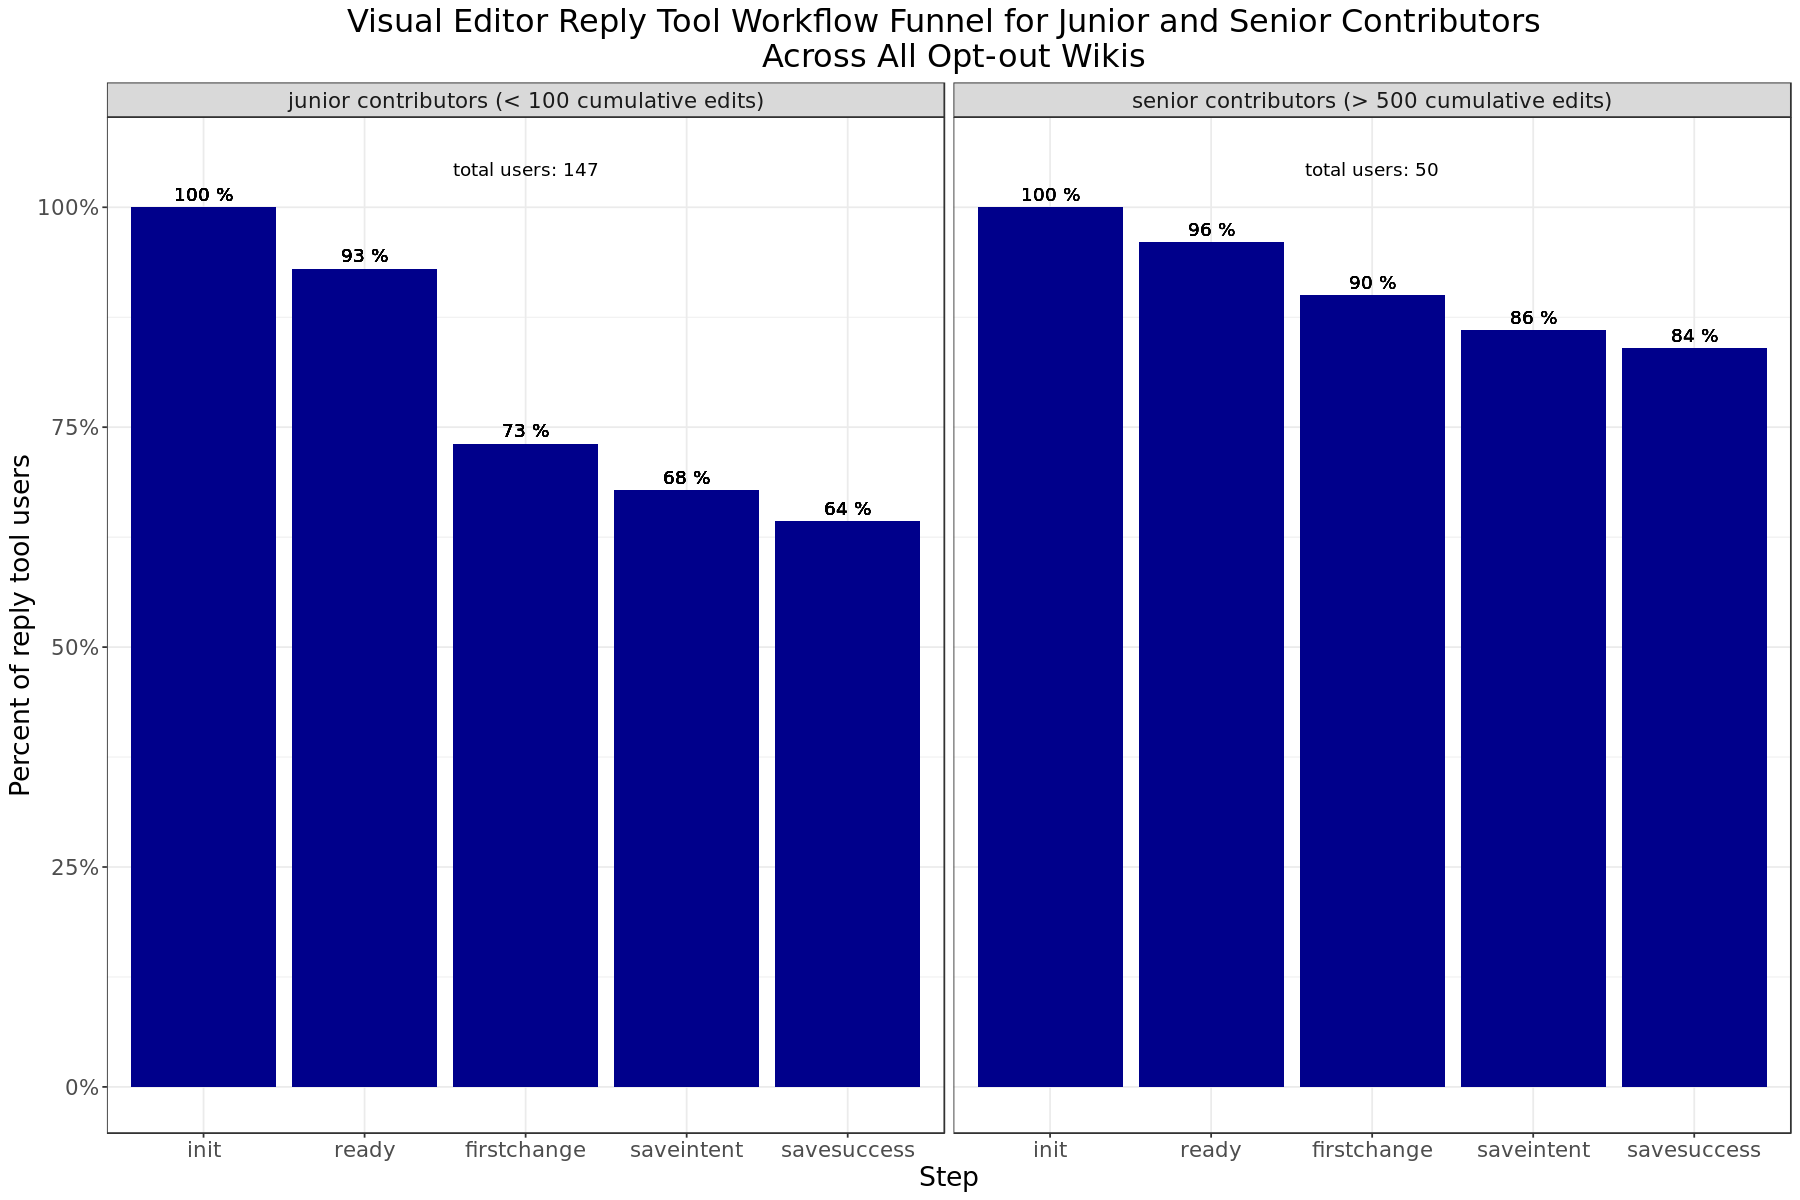

In [283]:
# plot workflow across all three target wikis on VE broken down by junior and senior contributors

p <- reply_users_workflow_funnel_forplot_experience %>%
    filter(editor_interface == 'visualeditor') %>%
    group_by(step, experience_level, editor_interface) %>%
    mutate(n_users = sum(n_users),
              pct_users = n_users/init_users_byexperience) %>%
    ggplot(aes(x=step, y= pct_users)) +
        geom_bar(stat='identity', position = 'dodge', fill = 'darkblue') +
        geom_text(aes(label = paste(round(pct_users * 100), '%')), vjust=-0.5) +
        geom_text(aes(x,y,label=lab),
        data=data.frame(x= 'firstchange', y= 1.05, lab=c("total users: 147","total users: 50"),
             experience_level= c("junior contributors (< 100 cumulative edits)", "senior contributors (> 500 cumulative edits)")), vjust=1) +
        facet_grid(~experience_level) +
        scale_y_continuous(labels = scales::percent) +
        labs (y = "Percent of reply tool users",
          x = "Step",
         title = "Visual Editor Reply Tool Workflow Funnel for Junior and Senior Contributors \n Across All Opt-out Wikis"
         )  +
         theme_bw() +
         theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
       legend.position = "none")
      
p

ggsave("Figures/ve_reply_workflow_overall_experience.png", p, width = 16, height = 8, units = "in", dpi = 300)

Across all three opt-out wikis, there is only a slight drop in the number of senior contributors that complete each step of the reply workflow using visual editor with 84% of all senior contributors sucessfully completing their edit. The largest decrease occurs between `init` and `ready` which may be due to network disruptions during the visual editor load time.

For junior contributors, the biggest drop in number of contributors occurs between `ready` (the contributor clicks the reply link and the editing interface is ready) and `firstchange` (the user begins typing a comment). However, the rate of drop-off decreases after this step. While only 79% percent of junior contributors that successfully loaded the editing interface started typing a comment, 93% percent of junior contributors that started typing a comment were able to successuly save their comment. 

Interestingly, reply tool users with 5 to 99 cumulative had the highest drop-off between `firstchange` and `saveintent` steps.

### Comments made with Wikitext

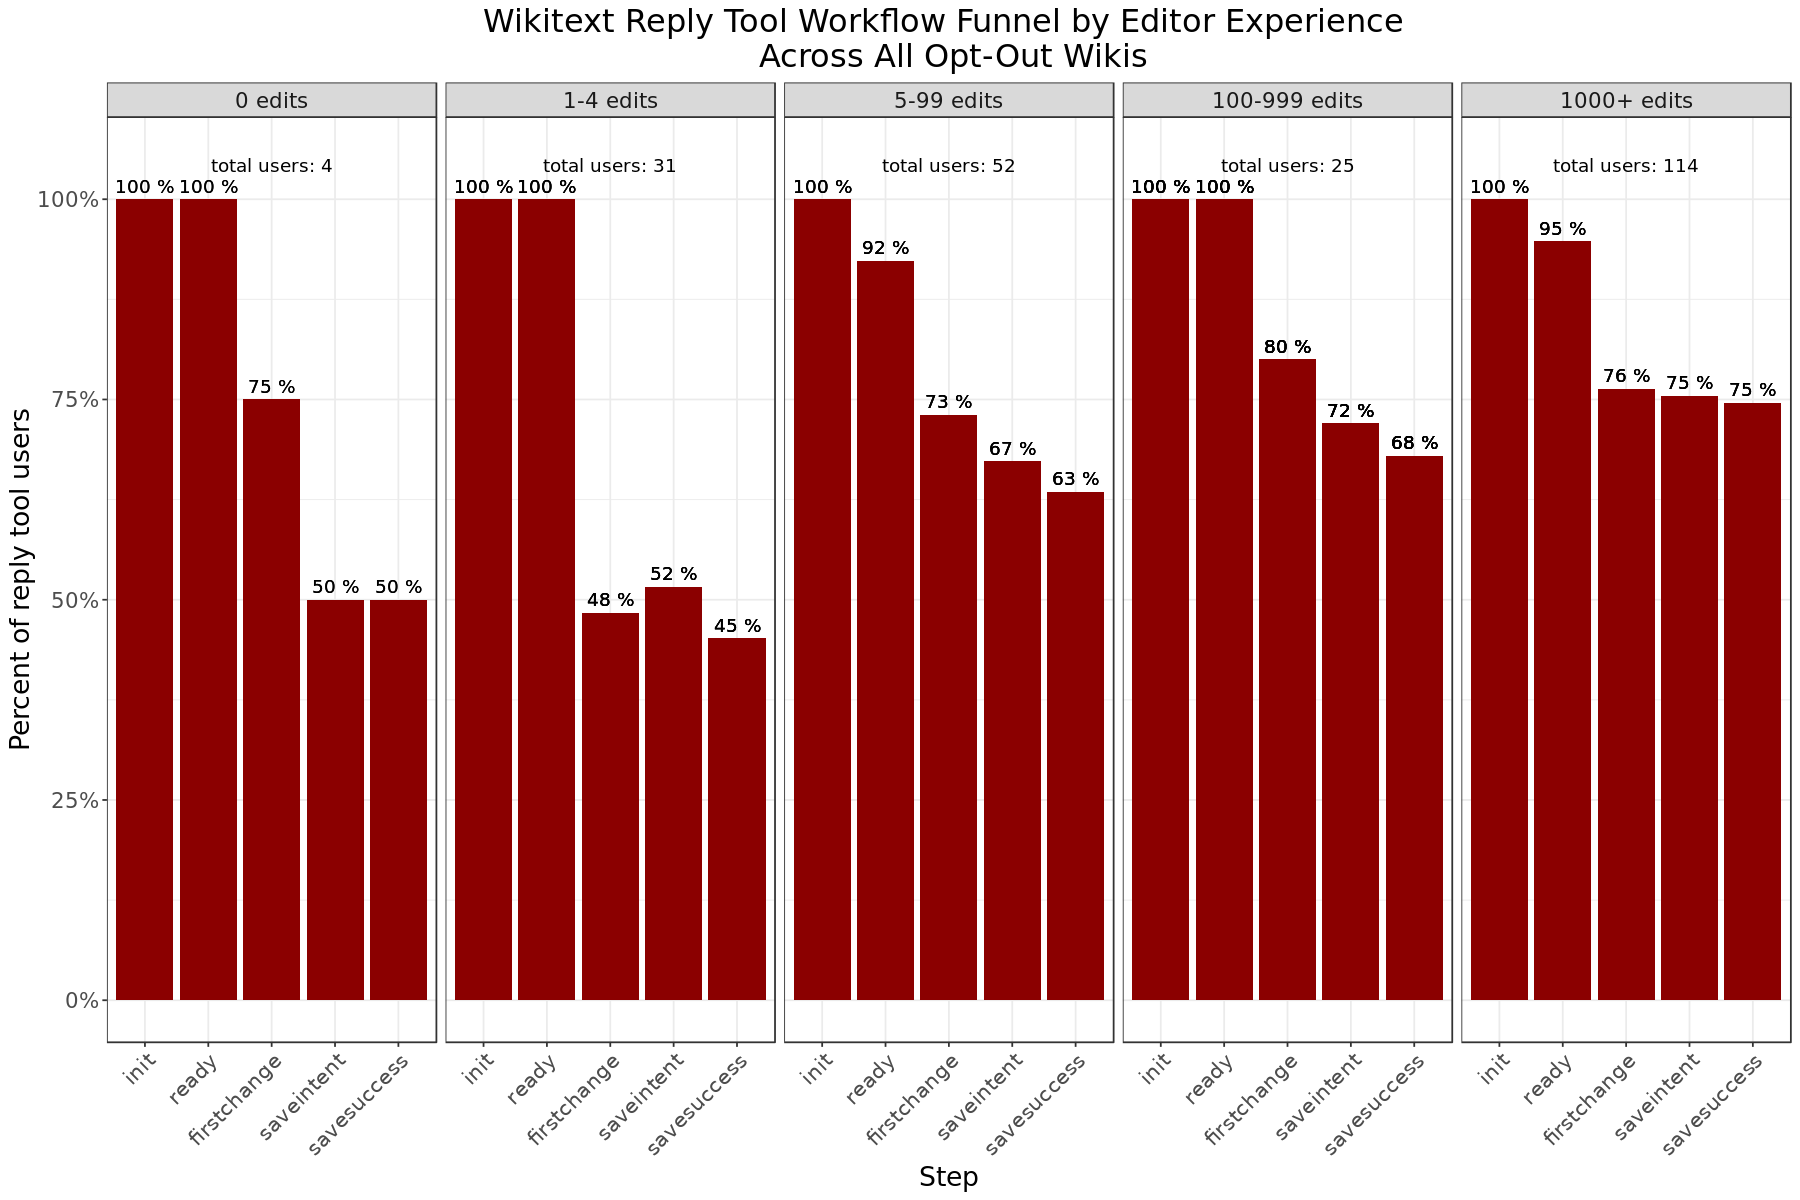

In [466]:
# plot workflow across all three target wikis on wikitext broken down by experience

p <- reply_users_workflow_funnel_forplot_editcount %>%
    filter(editor_interface == 'wikitext') %>%
    group_by(step, edit_count_bucket, editor_interface) %>%
    mutate(n_users = sum(n_users),
              pct_users = n_users/init_users_byeditcount) %>%
    ggplot(aes(x=step, y= pct_users)) +
        geom_bar(stat='identity', position = 'dodge', fill = 'red4') +
        geom_text(aes(label = paste(round(pct_users * 100), '%')), vjust=-0.5) +
        geom_text(aes(x,y,label=lab),
        data=data.frame(x= 'firstchange', y= 1.05, lab=c("total users: 4","total users: 31","total users: 52", "total users: 25", "total users: 114"),
             edit_count_bucket= c("0 edits", "1-4 edits", "5-99 edits", "100-999 edits", "1000+ edits" )), vjust=1) +
        facet_grid(~edit_count_bucket) +
        scale_y_continuous(labels = scales::percent) +
        labs (y = "Percent of reply tool users",
          x = "Step",
         title = "Wikitext Reply Tool Workflow Funnel by Editor Experience \n Across All Opt-Out Wikis")  +
         theme_bw() +
         theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
       legend.position = "none")
      
p

ggsave("Figures/wikitext_reply_workflow_overall_editcount.png", p, width = 16, height = 8, units = "in", dpi = 300)

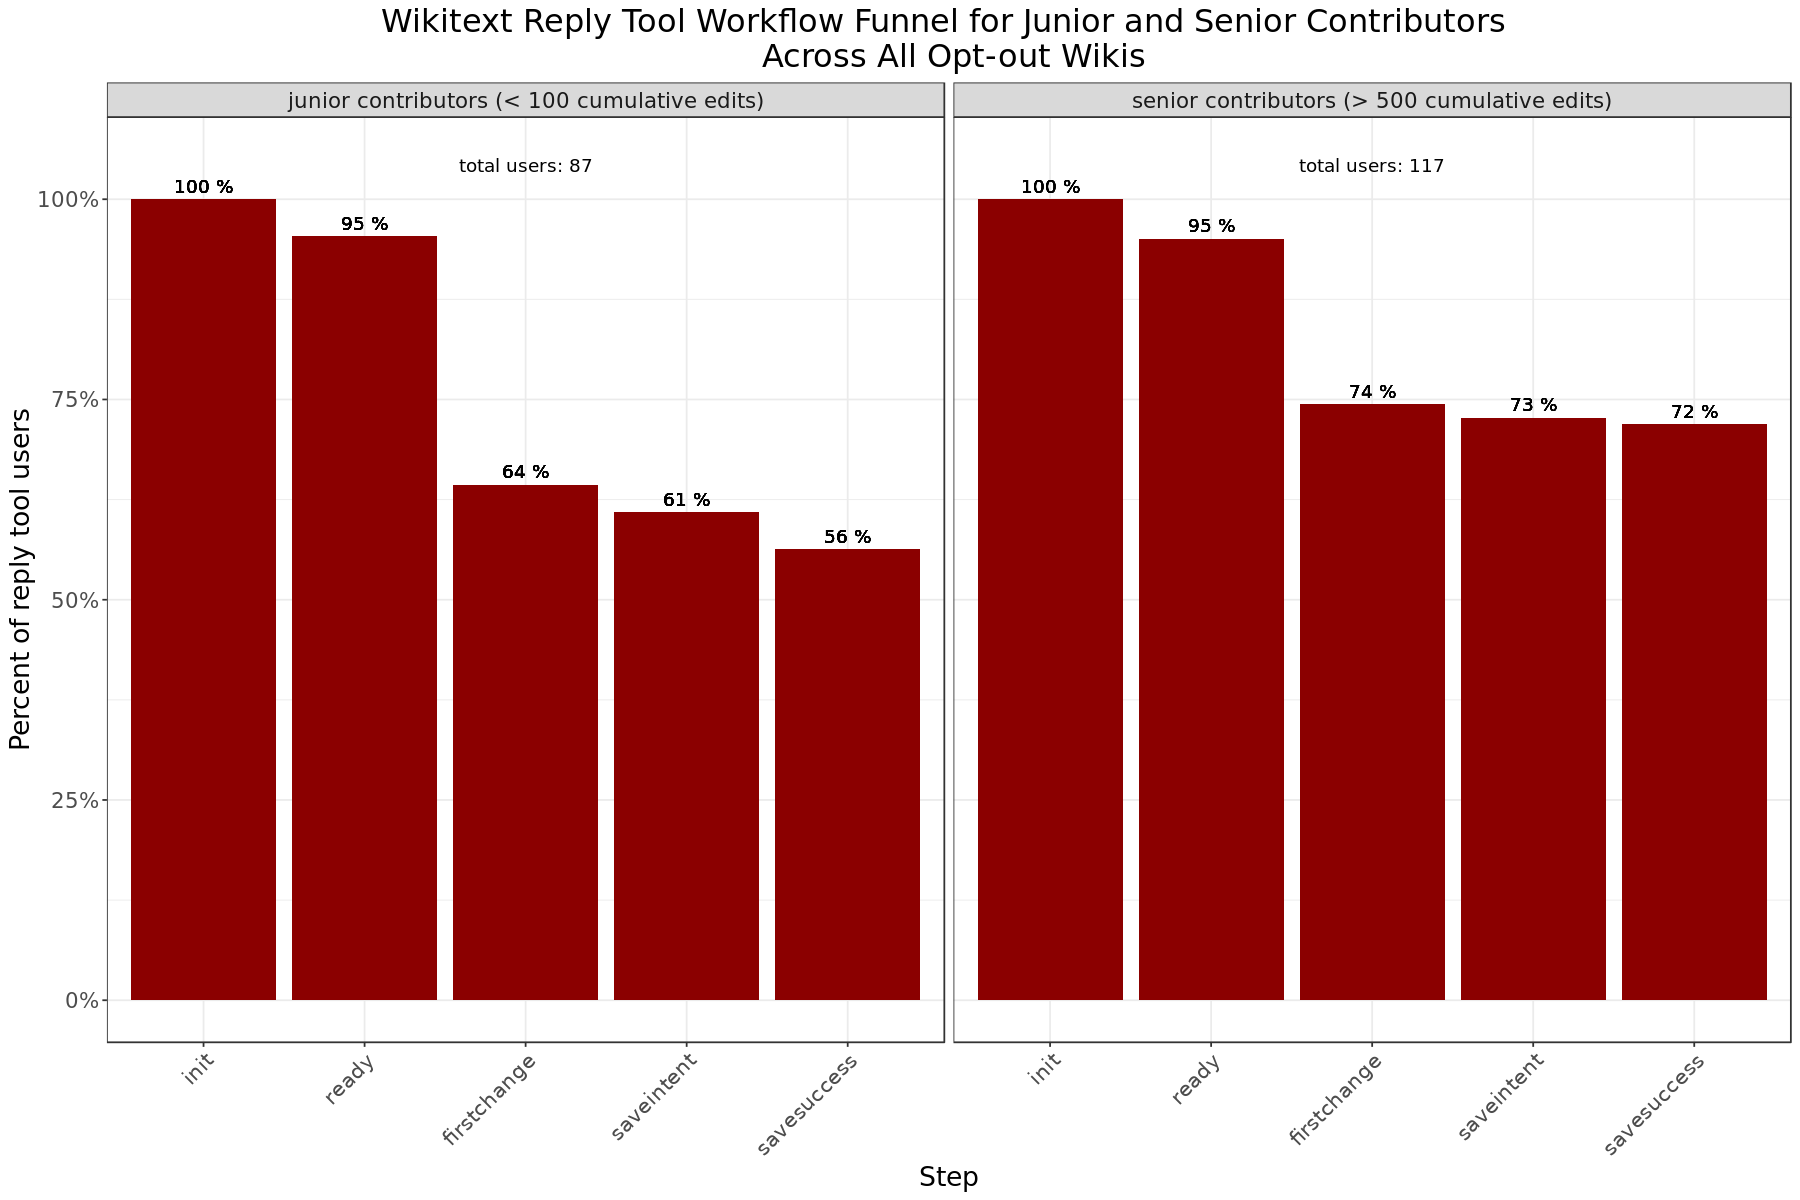

In [286]:
# plot workflow across all three target wikis on VE broken down by junior and senior contributors

p <- reply_users_workflow_funnel_forplot_experience %>%
    filter(editor_interface == 'wikitext') %>%
    group_by(step, experience_level, editor_interface) %>%
    mutate(n_users = sum(n_users),
              pct_users = n_users/init_users_byexperience) %>%
    ggplot(aes(x=step, y= pct_users)) +
        geom_bar(stat='identity', position = 'dodge', fill = 'red4') +
        geom_text(aes(label = paste(round(pct_users * 100), '%')), vjust=-0.5) +
        geom_text(aes(x,y,label=lab),
        data=data.frame(x= 'firstchange', y= 1.05, lab=c("total users: 87","total users: 117"),
             experience_level= c("junior contributors (< 100 cumulative edits)", "senior contributors (> 500 cumulative edits)")), vjust=1) +
        facet_grid(~experience_level) +
        scale_y_continuous(labels = scales::percent) +
        labs (y = "Percent of reply tool users",
          x = "Step",
         title = "Wikitext Reply Tool Workflow Funnel for Junior and Senior Contributors \n Across All Opt-out Wikis"
         )  +
         theme_bw() +
         theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
       legend.position = "none")
      
p

ggsave("Figures/wikitext_reply_workflow_overall_experience.png", p, width = 16, height = 8, units = "in", dpi = 300)

Compared to Visual Editor, a smaller percentage of contributors users that successuly load the editing interface (step = `ready`) start typing a comment (step = `firstChange`) using wikitext. For editors with 1 to 4 cumulative edits, only 48% of users that clicked the reply link and reached ready started typing a comment. 



## Workflow funnel for each opt-out wikis by user's experience level

We also reviewed the worflow funnel for each individual wiki to confirm any differences on a per wiki basis. 

In [287]:
# Find total init sessions for each target wiki by editcount

init_users_bywiki_editcount <- reply_users_workflow_funnel_clean %>%
    group_by(edit_count_bucket, editor_interface, wiki) %>%
    filter(step == 'init')  %>%
    summarise(init_users_editcount = sum(n_users), .groups = 'drop')


In [ ]:
# join with workflow table
reply_users_workflow_funnel_forplot_bywiki_editcount <- inner_join(reply_users_workflow_funnel_clean, init_users_bywiki_editcount)


In [289]:
# Find total init sessions for each target wiki by experience level

init_users_bywiki_experience <- reply_users_workflow_funnel_clean %>%
    group_by(experience_level, editor_interface, wiki) %>%
    filter(step == 'init',
              experience_level != 'NA')  %>%
    summarise(init_users_experience = sum(n_users), .groups = 'drop')

In [ ]:
# join with workflow table
reply_users_workflow_funnel_forplot_bywiki_experience <- inner_join(reply_users_workflow_funnel_clean, init_users_bywiki_experience)


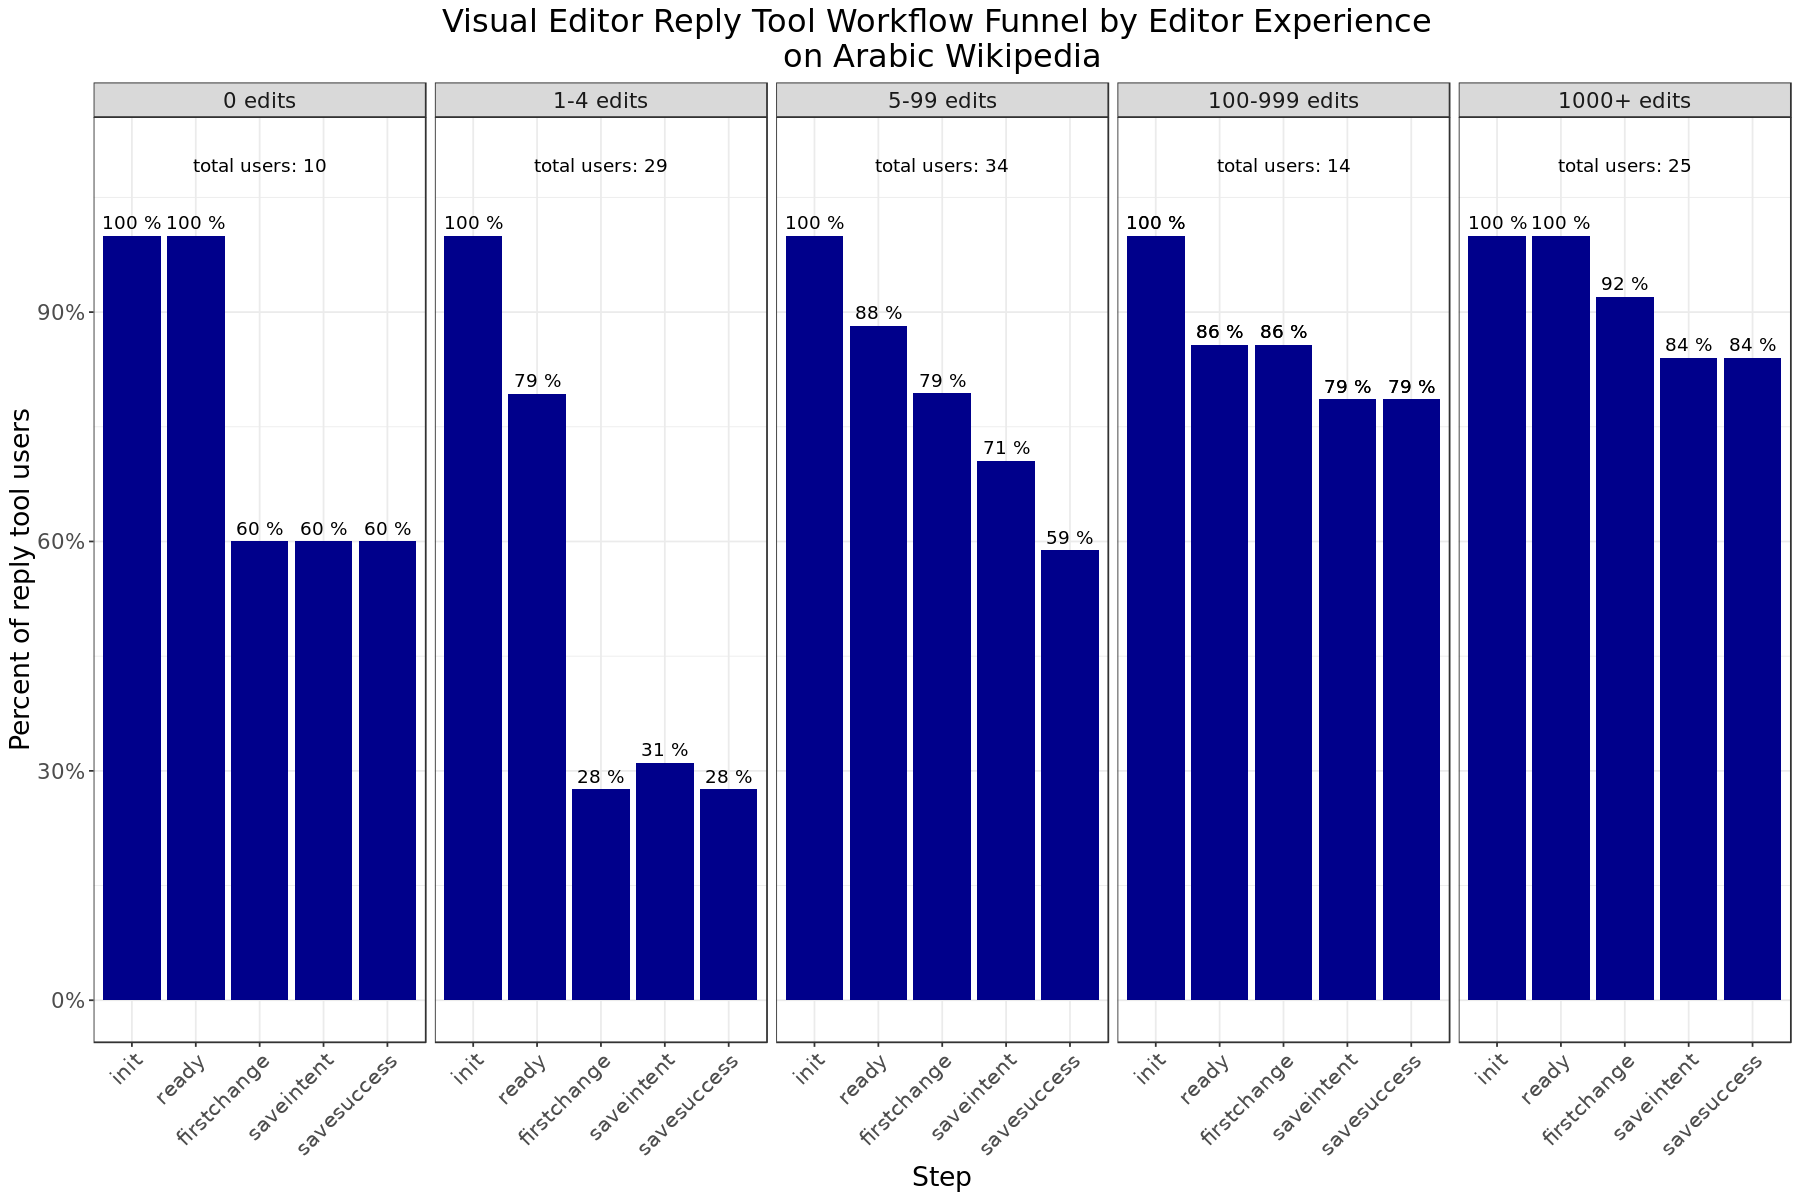

In [291]:
# plot workflow on arwiki on VE broken down by edit count

p <- reply_users_workflow_funnel_forplot_bywiki_editcount %>%
    filter(wiki == 'arwiki',
           editor_interface == 'visualeditor') %>%
    group_by(step, edit_count_bucket, editor_interface) %>%
    mutate(n_users = sum(n_users),
              pct_users = n_users/init_users_editcount) %>%
    ggplot(aes(x=step, y= pct_users)) +
        geom_bar(stat='identity', position = 'dodge', fill = 'darkblue') +
        geom_text(aes(label = paste(round(pct_users * 100), '%')), vjust=-0.5) +
        geom_text(aes(x,y,label=lab),
        data=data.frame(x= 'firstchange', y= 1.1, lab=c("total users: 10","total users: 29","total users: 34", "total users: 14", "total users: 25"),
             edit_count_bucket= c("0 edits", "1-4 edits", "5-99 edits", "100-999 edits", "1000+ edits" )), vjust=1) +
        facet_grid(~edit_count_bucket) +
        scale_y_continuous(labels = scales::percent) +
        labs (y = "Percent of reply tool users",
          x = "Step",
         title = "Visual Editor Reply Tool Workflow Funnel by Editor Experience \n on Arabic Wikipedia ")  +
         theme_bw() +
         theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
       legend.position = "none")
      
p

ggsave("Figures/ve_reply_workflow_arwiki_editcount.png", p, width = 16, height = 8, units = "in", dpi = 300)

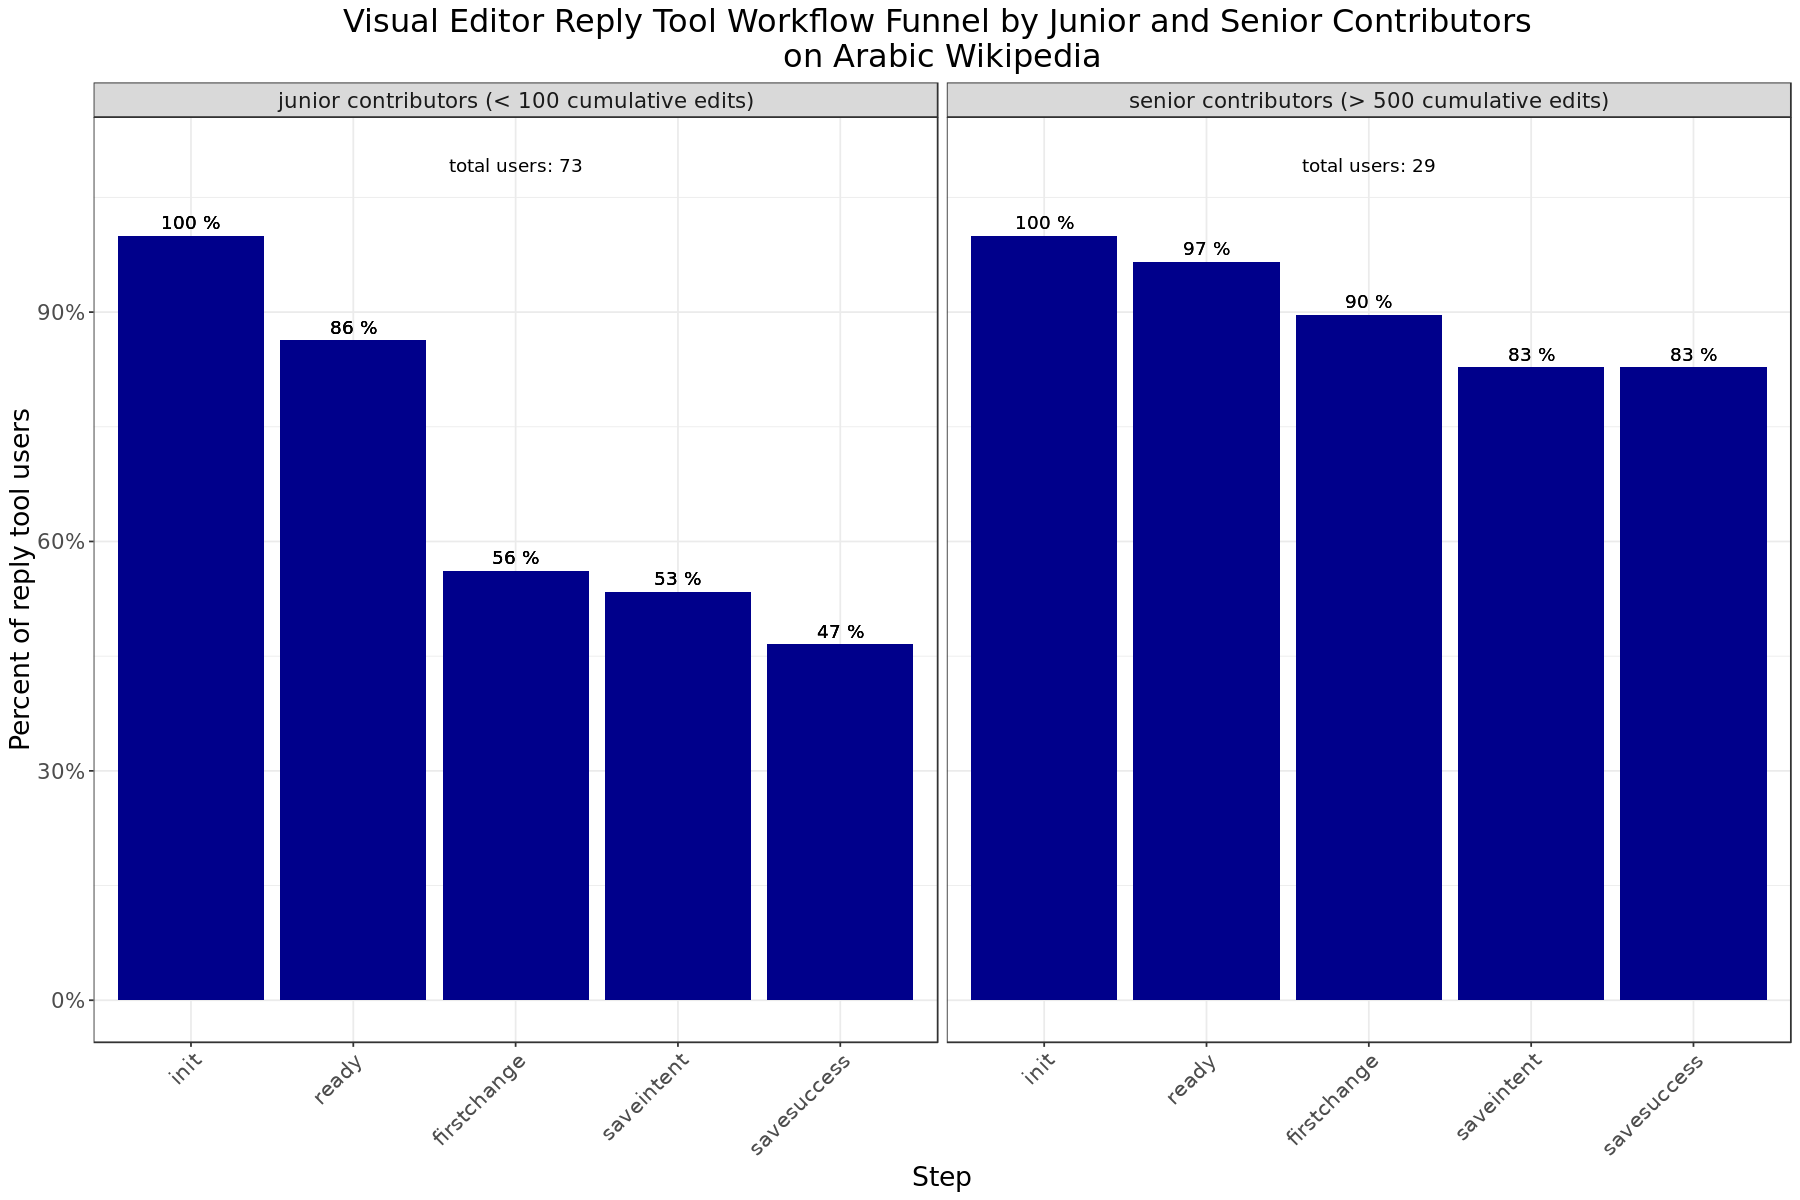

In [292]:
# plot workflow on arwiki on VE broken down by experience

p <- reply_users_workflow_funnel_forplot_bywiki_experience %>%
    filter(wiki == 'arwiki',
           editor_interface == 'visualeditor') %>%
    group_by(step, experience_level, editor_interface) %>%
    mutate(n_users = sum(n_users),
              pct_users = n_users/init_users_experience) %>%
    ggplot(aes(x=step, y= pct_users)) +
        geom_bar(stat='identity', position = 'dodge', fill = 'darkblue') +
        geom_text(aes(label = paste(round(pct_users * 100), '%')), vjust=-0.5) +
        geom_text(aes(x,y,label=lab),
        data=data.frame(x= 'firstchange', y= 1.1, lab=c("total users: 73","total users: 29"),
             experience_level = c("junior contributors (< 100 cumulative edits)", "senior contributors (> 500 cumulative edits)")), vjust=1) +
        facet_grid(~experience_level) +
        scale_y_continuous(labels = scales::percent) +
        labs (y = "Percent of reply tool users",
          x = "Step",
         title = "Visual Editor Reply Tool Workflow Funnel by Junior and Senior Contributors \n on Arabic Wikipedia ")  +
         theme_bw() +
         theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
       legend.position = "none")
    p
                  
                 
ggsave("Figures/ve_reply_workflow_arwiki_experience.png", p, width = 16, height = 8, units = "in", dpi = 300)


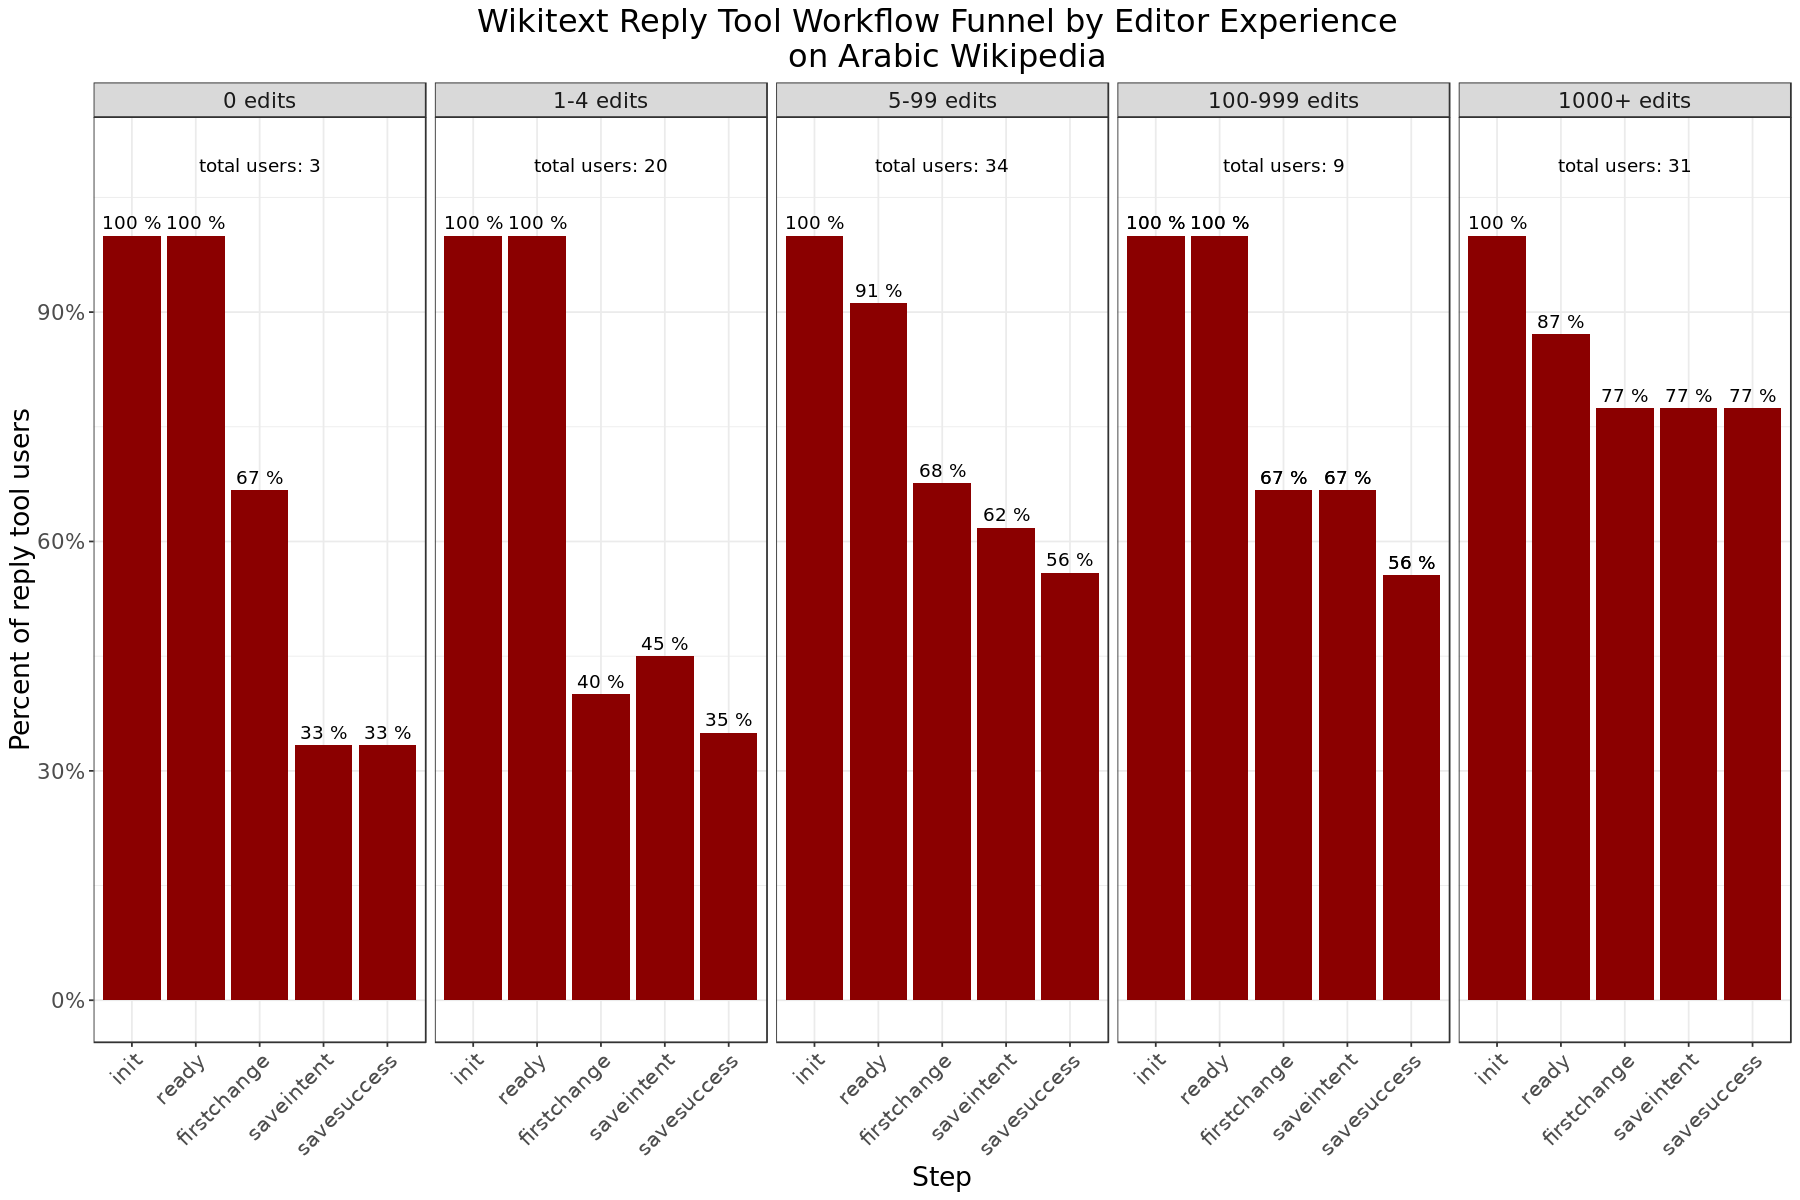

In [293]:
# plot workflow on arwiki on wikitext broken down by experience


p <- reply_users_workflow_funnel_forplot_bywiki_editcount %>%
    filter(wiki == 'arwiki',
           editor_interface == 'wikitext') %>%
    group_by(step, edit_count_bucket, editor_interface) %>%
    mutate(n_users = sum(n_users),
              pct_users = n_users/init_users_editcount) %>%
    ggplot(aes(x=step, y= pct_users)) +
        geom_bar(stat='identity', position = 'dodge', fill = 'red4') +
        geom_text(aes(label = paste(round(pct_users * 100), '%')), vjust=-0.5) +
        geom_text(aes(x,y,label=lab),
        data=data.frame(x= 'firstchange', y= 1.1, lab=c("total users: 3","total users: 20","total users: 34", "total users: 9", "total users: 31"),
             edit_count_bucket= c("0 edits", "1-4 edits", "5-99 edits", "100-999 edits", "1000+ edits" )), vjust=1) +
        facet_grid(~edit_count_bucket) +
        scale_y_continuous(labels = scales::percent) +
        labs (y = "Percent of reply tool users",
          x = "Step",
         title = "Wikitext Reply Tool Workflow Funnel by Editor Experience \n on Arabic Wikipedia")  +
         theme_bw() +
         theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
       legend.position = "none")
      
p

ggsave("Figures/wikitext_reply_workflow_arwiki_editcount.png", p, width = 16, height = 8, units = "in", dpi = 300)

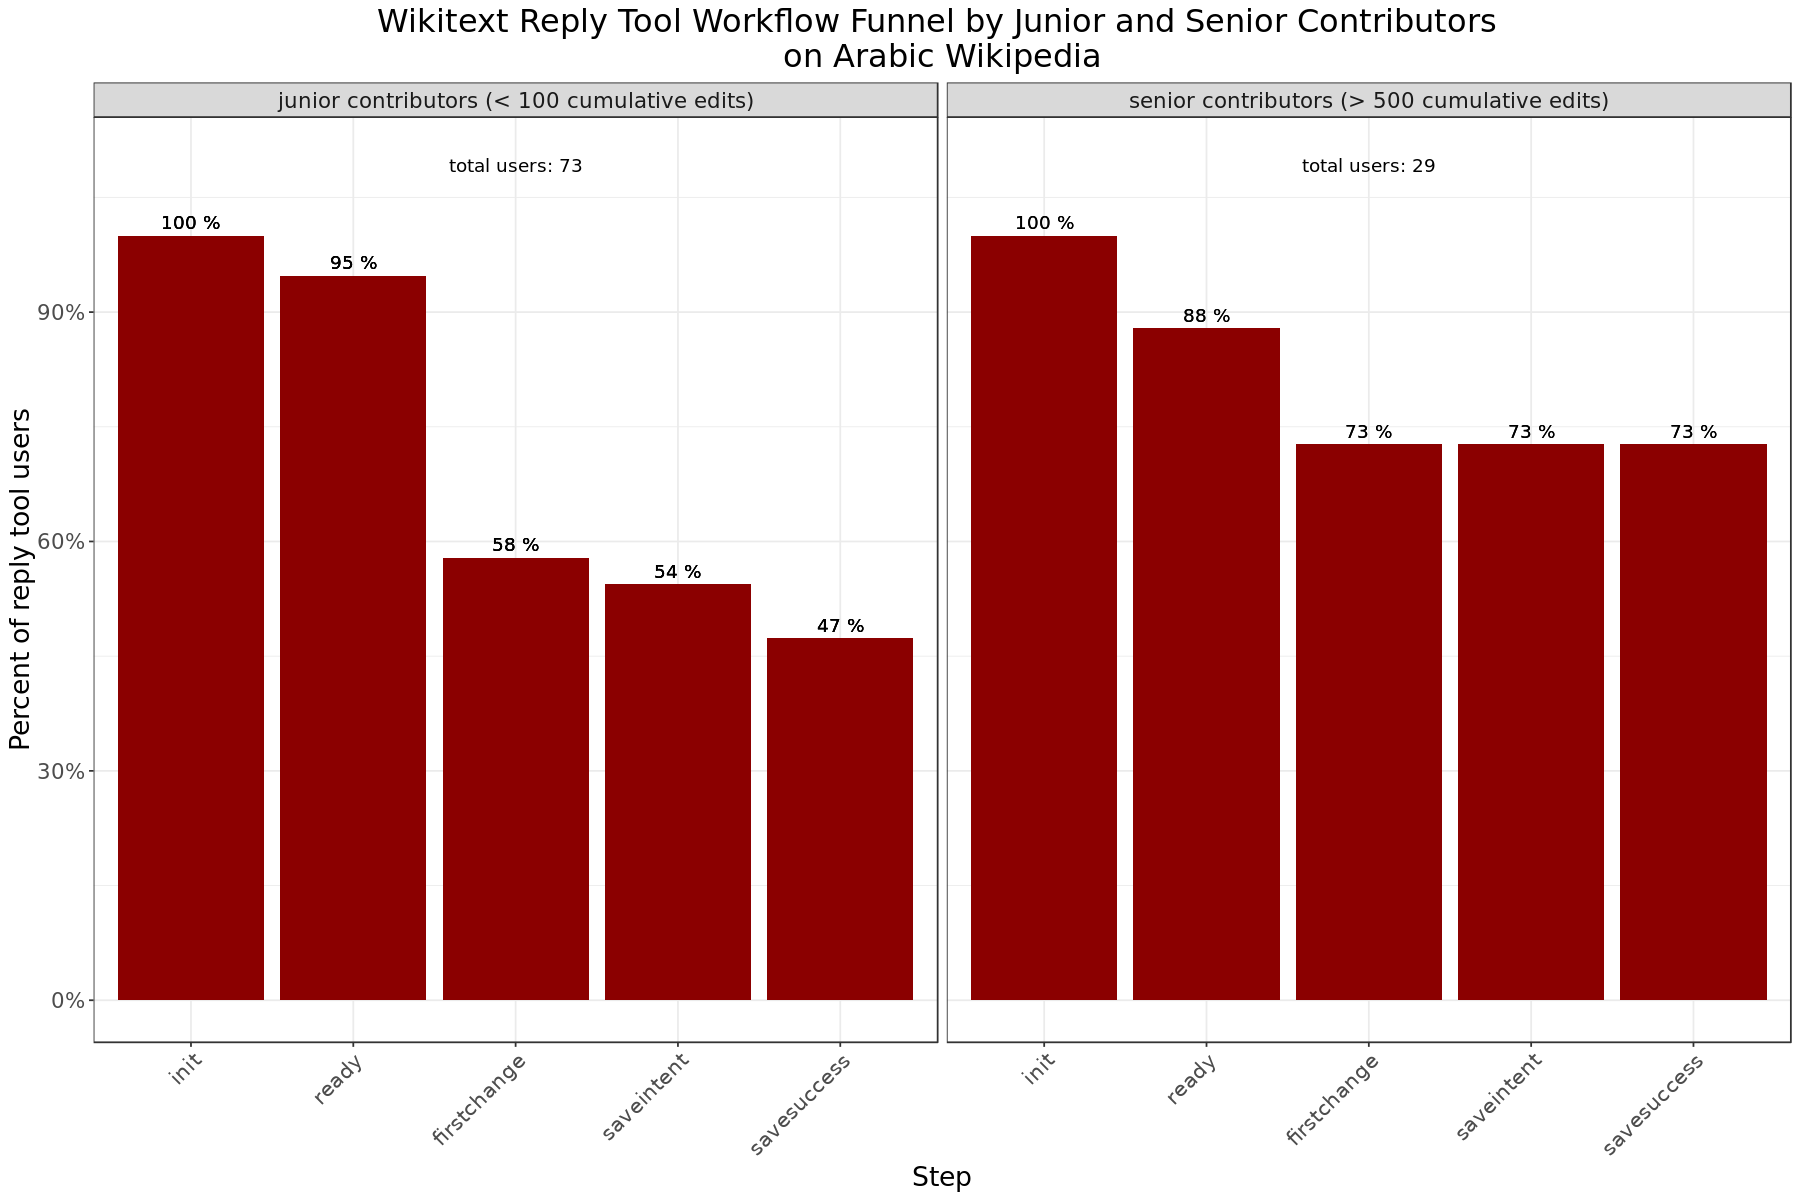

In [294]:
# plot workflow on arwiki on VE broken down by experience

p <- reply_users_workflow_funnel_forplot_bywiki_experience %>%
    filter(wiki == 'arwiki',
           editor_interface == 'wikitext') %>%
    group_by(step, experience_level, editor_interface) %>%
    mutate(n_users = sum(n_users),
              pct_users = n_users/init_users_experience) %>%
    ggplot(aes(x=step, y= pct_users)) +
        geom_bar(stat='identity', position = 'dodge', fill = 'red4') +
        geom_text(aes(label = paste(round(pct_users * 100), '%')), vjust=-0.5) +
        geom_text(aes(x,y,label=lab),
        data=data.frame(x= 'firstchange', y= 1.1, lab=c("total users: 73","total users: 29"),
             experience_level = c("junior contributors (< 100 cumulative edits)", "senior contributors (> 500 cumulative edits)")), vjust=1) +
        facet_grid(~experience_level) +
        scale_y_continuous(labels = scales::percent) +
        labs (y = "Percent of reply tool users",
          x = "Step",
         title = "Wikitext Reply Tool Workflow Funnel by Junior and Senior Contributors \n on Arabic Wikipedia ")  +
         theme_bw() +
         theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
       legend.position = "none")
    p
                  
                 
ggsave("Figures/wikitext_reply_workflow_arwiki_experience.png", p, width = 16, height = 8, units = "in", dpi = 300)

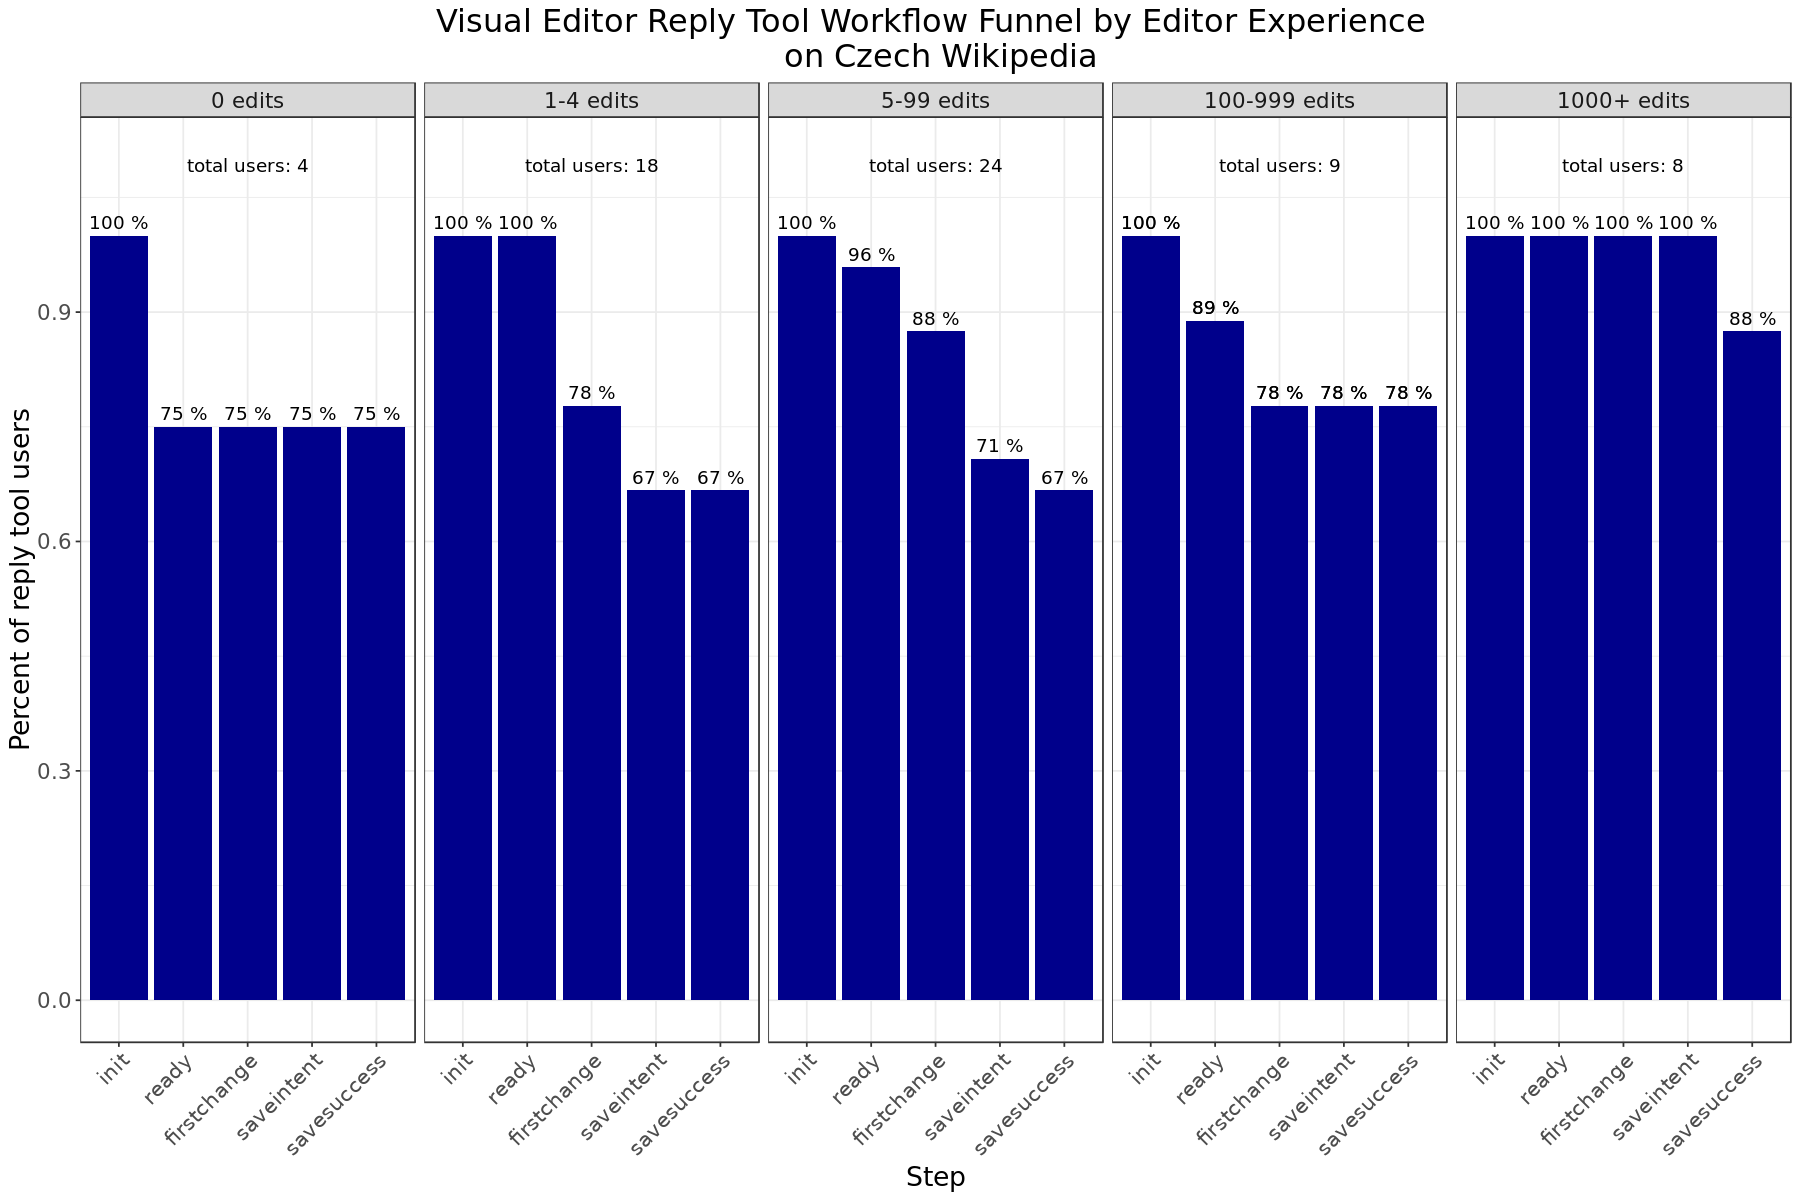

In [295]:
# plot workflow on cswiki on VE broken down by experience

p <- reply_users_workflow_funnel_forplot_bywiki_editcount %>%
    filter(wiki == 'cswiki',
           editor_interface == 'visualeditor') %>%
    group_by(step, edit_count_bucket, editor_interface) %>%
    mutate(n_users = sum(n_users),
              pct_users = n_users/init_users_editcount) %>%
    ggplot(aes(x=step, y= pct_users)) +
        geom_bar(stat='identity', position = 'dodge', fill = 'darkblue') +
        geom_text(aes(label = paste(round(pct_users * 100), '%')), vjust=-0.5) +
            geom_text(aes(x,y,label=lab),
        data=data.frame(x= 'firstchange', y= 1.1, lab=c("total users: 4","total users: 18","total users: 24", "total users: 9", "total users: 8"),
             edit_count_bucket= c("0 edits", "1-4 edits", "5-99 edits", "100-999 edits", "1000+ edits" )), vjust=1) +
        facet_grid(~edit_count_bucket) +
        labs (y = "Percent of reply tool users",
          x = "Step",
         title =  "Visual Editor Reply Tool Workflow Funnel by Editor Experience \n on Czech Wikipedia")  +
         theme_bw() +
         theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
       legend.position = "none")
      
p

ggsave("Figures/ve_reply_workflow_cswiki_editcount.png", p, width = 16, height = 8, units = "in", dpi = 300)

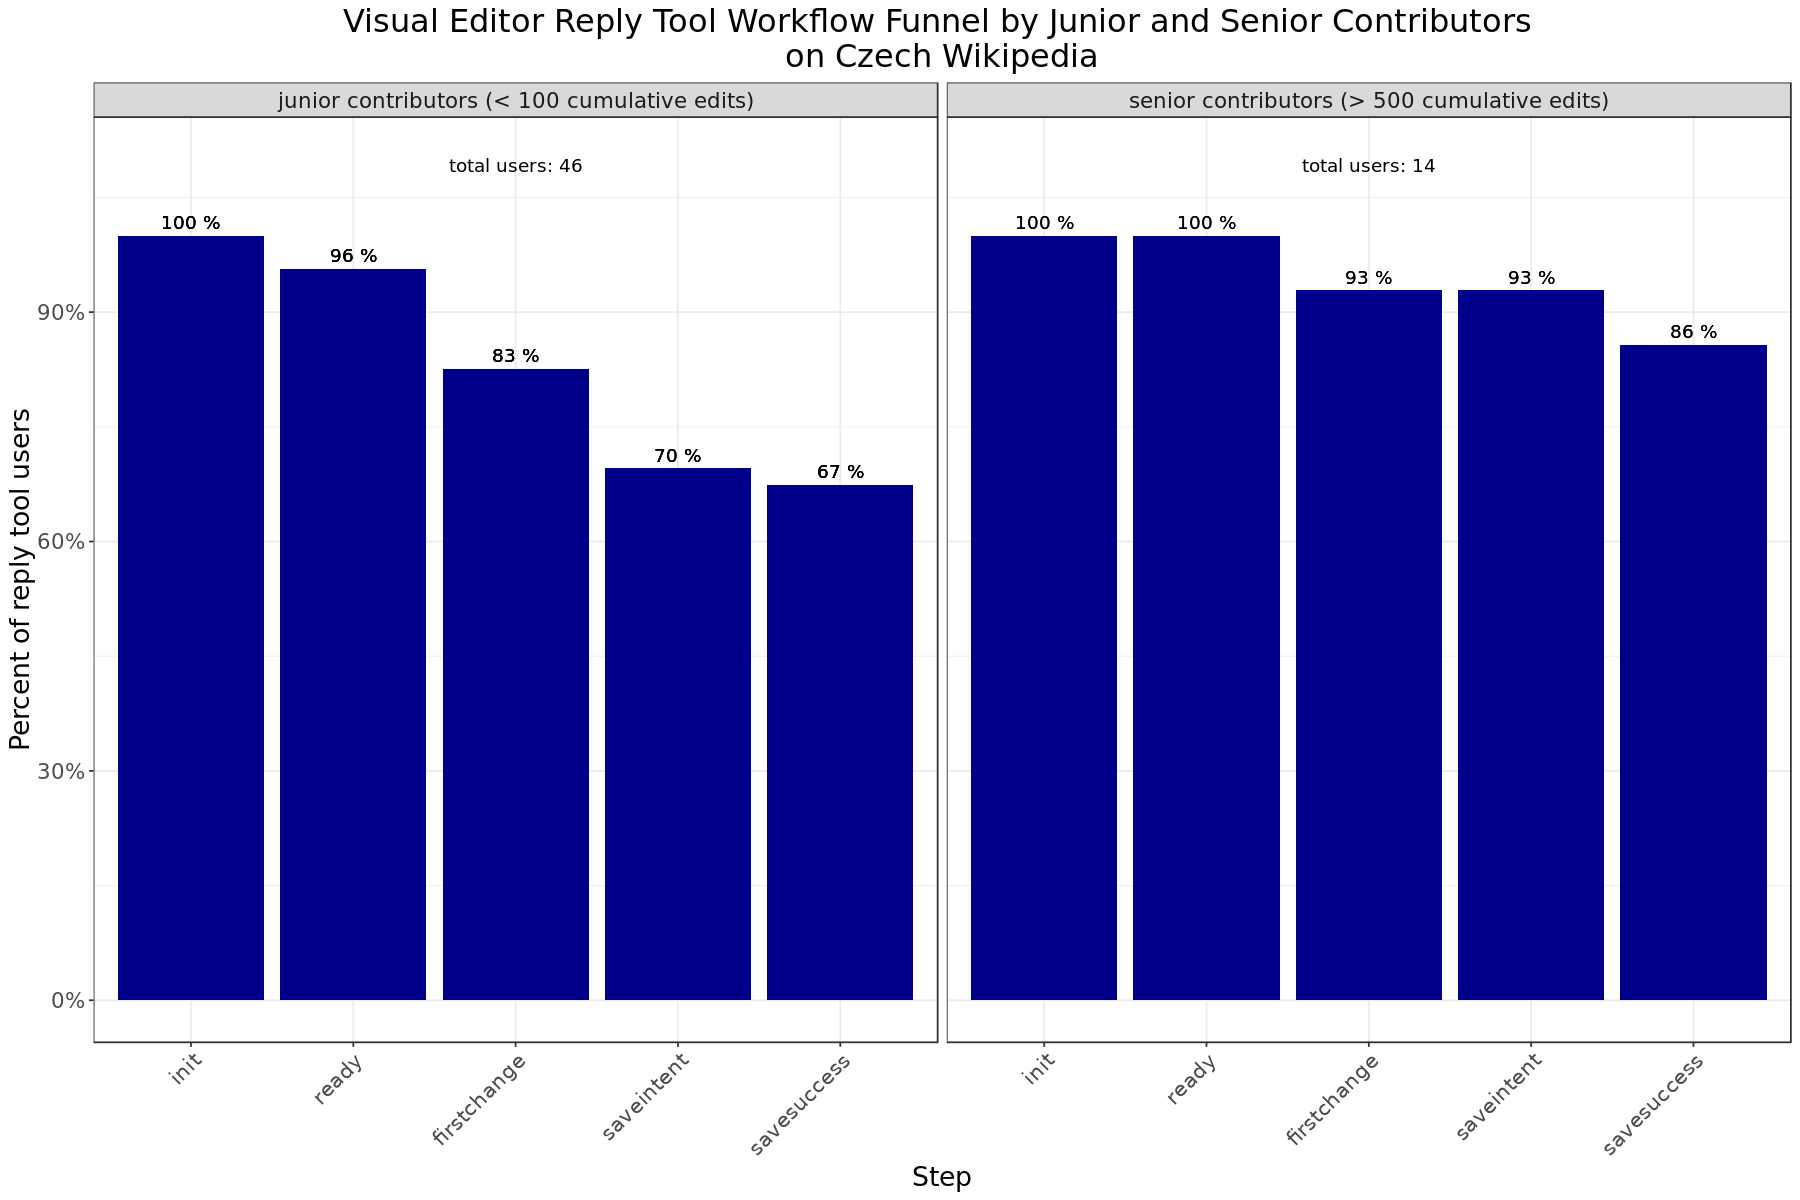

In [296]:
# plot workflow on cswiki on VE broken down by experience

p <- reply_users_workflow_funnel_forplot_bywiki_experience %>%
    filter(wiki == 'cswiki',
           editor_interface == 'visualeditor') %>%
    group_by(step, experience_level, editor_interface) %>%
    mutate(n_users = sum(n_users),
              pct_users = n_users/init_users_experience) %>%
    ggplot(aes(x=step, y= pct_users)) +
        geom_bar(stat='identity', position = 'dodge', fill = 'darkblue') +
        geom_text(aes(label = paste(round(pct_users * 100), '%')), vjust=-0.5) +
        geom_text(aes(x,y,label=lab),
        data=data.frame(x= 'firstchange', y= 1.1, lab=c("total users: 46","total users: 14"),
             experience_level = c("junior contributors (< 100 cumulative edits)", "senior contributors (> 500 cumulative edits)")), vjust=1) +
        facet_grid(~experience_level) +
        scale_y_continuous(labels = scales::percent) +
        labs (y = "Percent of reply tool users",
          x = "Step",
         title = "Visual Editor Reply Tool Workflow Funnel by Junior and Senior Contributors \n on Czech Wikipedia ")  +
         theme_bw() +
         theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
       legend.position = "none")
    p
                  
                 
ggsave("Figures/ve_reply_workflow_cswiki_experience.png", p, width = 16, height = 8, units = "in", dpi = 300)

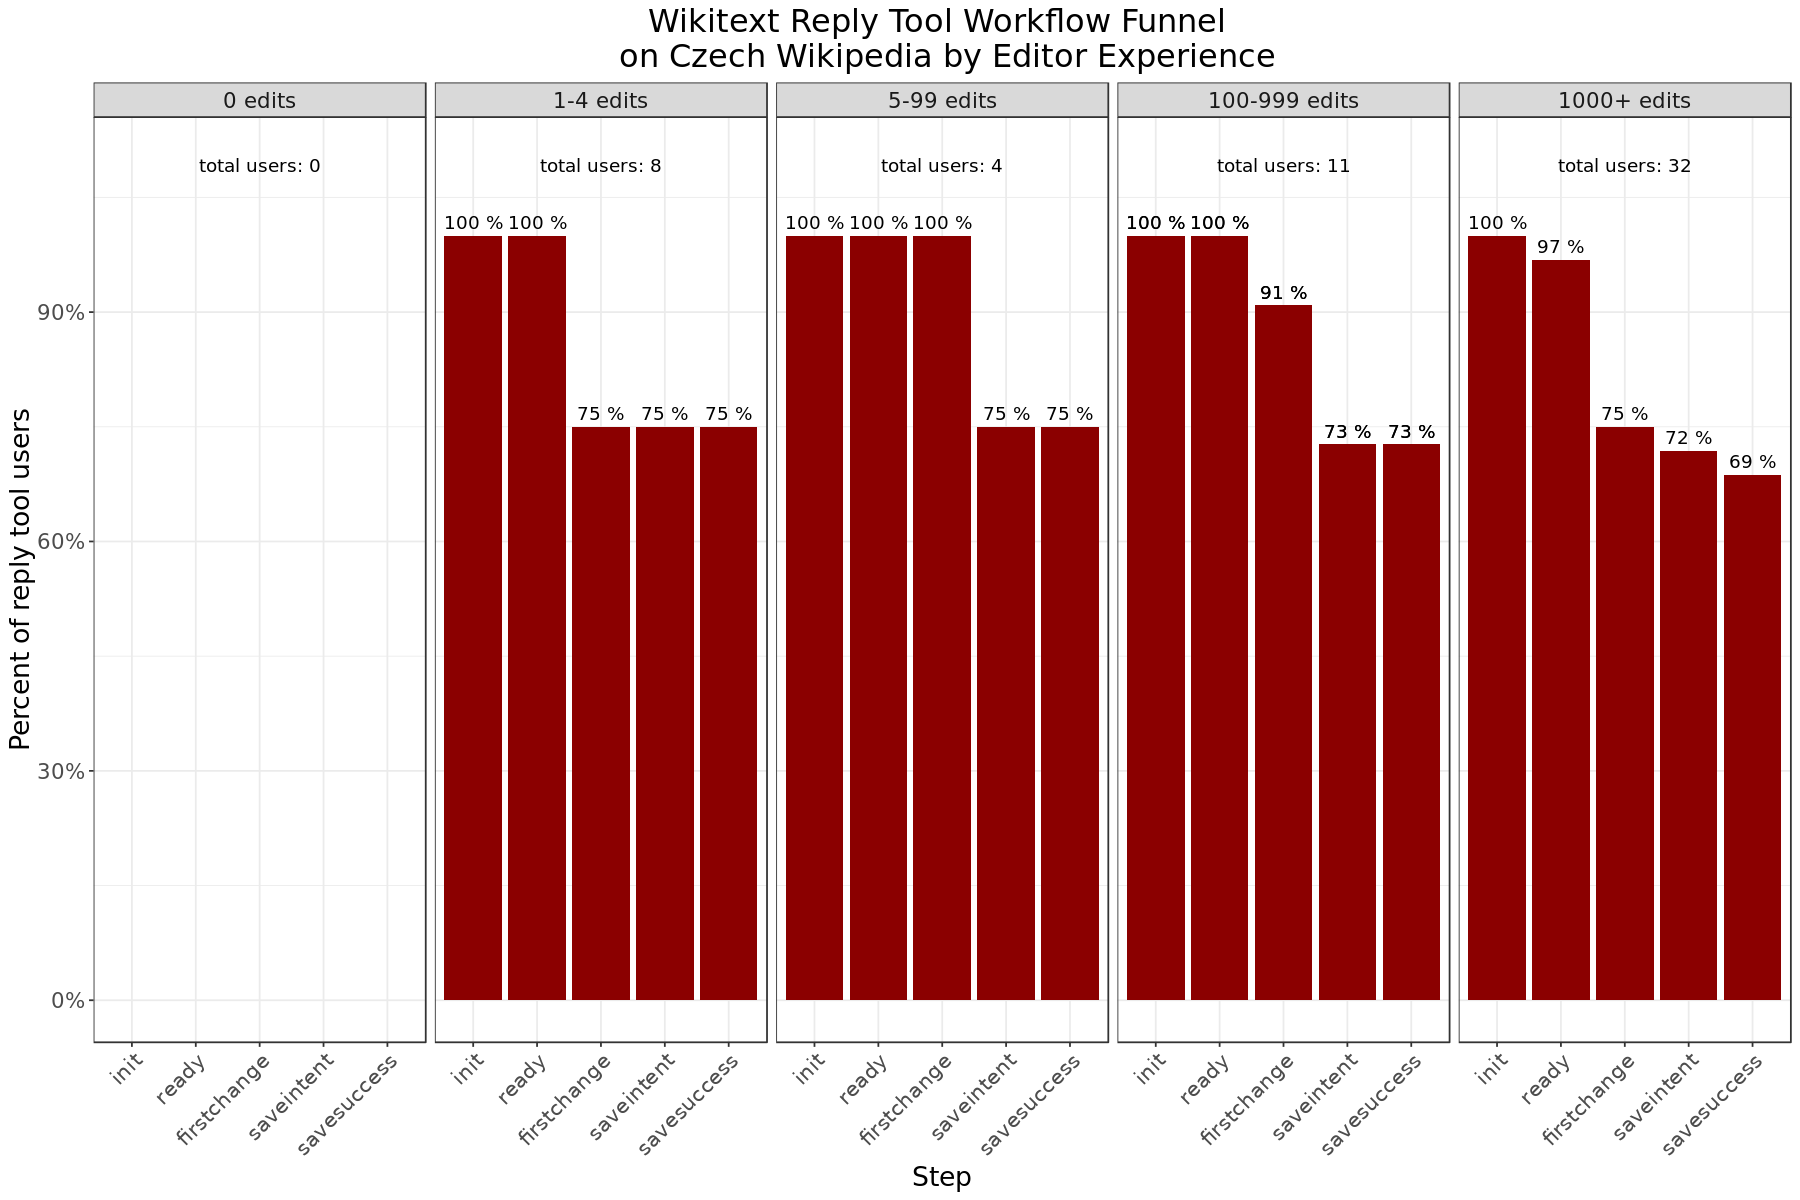

In [297]:
# plot workflow on cswiki on wikitext broken down by experience

p <- reply_users_workflow_funnel_forplot_bywiki_editcount %>%
    filter(wiki == 'cswiki',
           editor_interface == 'wikitext') %>%
    group_by(step, edit_count_bucket, editor_interface) %>%
    mutate(n_users = sum(n_users),
              pct_users = n_users/init_users_editcount) %>%
    ggplot(aes(x=step, y= pct_users)) +
        geom_bar(stat='identity', position = 'dodge', fill = 'red4') +
        geom_text(aes(label = paste(round(pct_users * 100), '%')), vjust=-0.5) +
        geom_text(aes(x,y,label=lab),
        data=data.frame(x= 'firstchange', y= 1.1, lab=c("total users: 0","total users: 8","total users: 4", "total users: 11", "total users: 32"),
             edit_count_bucket= c("0 edits", "1-4 edits", "5-99 edits", "100-999 edits", "1000+ edits" )), vjust=1) +
        facet_grid(~edit_count_bucket) +
        scale_y_continuous(labels = scales::percent) +
        labs (y = "Percent of reply tool users",
          x = "Step",
         title = "Wikitext Reply Tool Workflow Funnel \n on Czech Wikipedia by Editor Experience")  +
         theme_bw() +
         theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
       legend.position = "none")
      
p

ggsave("Figures/wikitext_reply_workflow_cswiki_editcount.png", p, width = 16, height = 8, units = "in", dpi = 300)


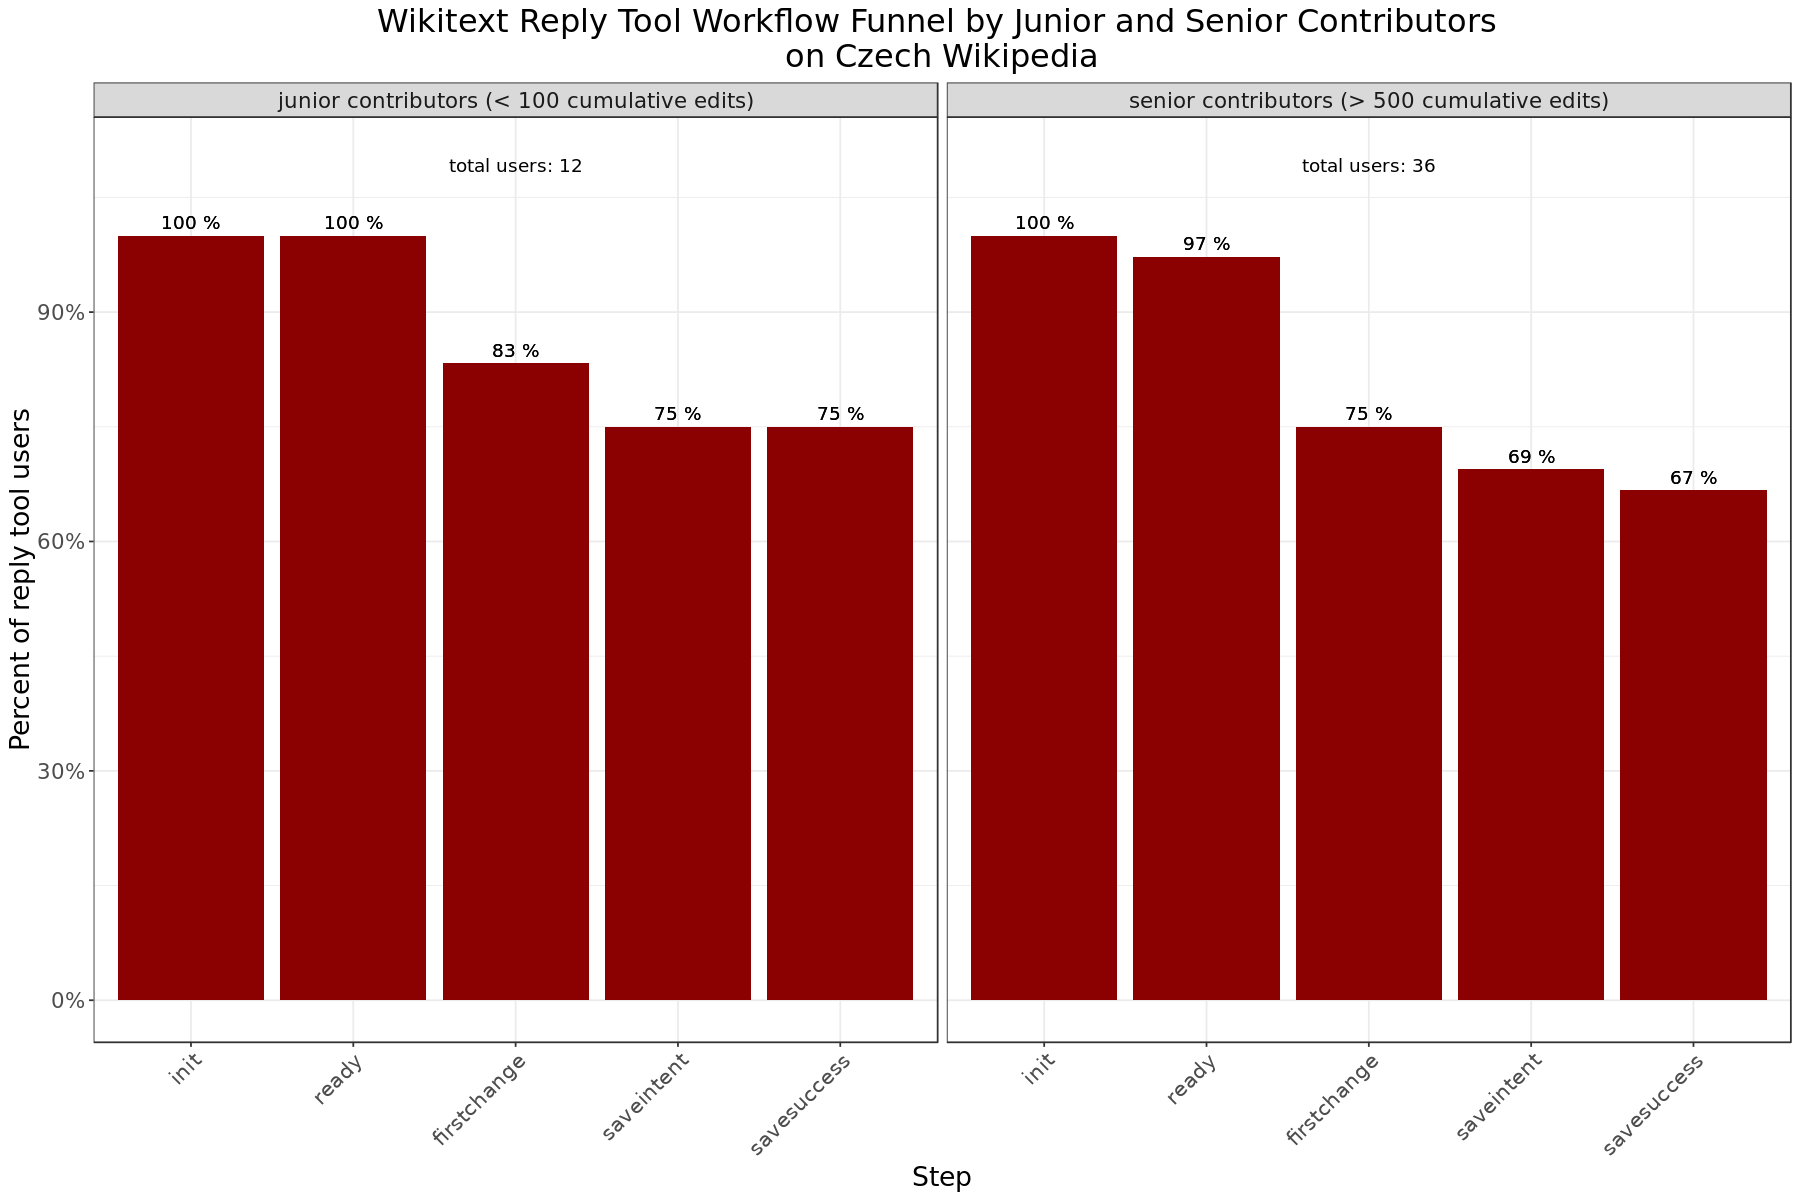

In [298]:
# plot workflow on cswiki on wikitext broken down by experience

p <- reply_users_workflow_funnel_forplot_bywiki_experience %>%
    filter(wiki == 'cswiki',
           editor_interface == 'wikitext') %>%
    group_by(step, experience_level, editor_interface) %>%
    mutate(n_users = sum(n_users),
              pct_users = n_users/init_users_experience) %>%
    ggplot(aes(x=step, y= pct_users)) +
        geom_bar(stat='identity', position = 'dodge', fill = 'red4') +
        geom_text(aes(label = paste(round(pct_users * 100), '%')), vjust=-0.5) +
        geom_text(aes(x,y,label=lab),
        data=data.frame(x= 'firstchange', y= 1.1, lab=c("total users: 12","total users: 36"),
             experience_level = c("junior contributors (< 100 cumulative edits)", "senior contributors (> 500 cumulative edits)")), vjust=1) +
        facet_grid(~experience_level) +
        scale_y_continuous(labels = scales::percent) +
        labs (y = "Percent of reply tool users",
          x = "Step",
         title = "Wikitext Reply Tool Workflow Funnel by Junior and Senior Contributors \n on Czech Wikipedia ")  +
         theme_bw() +
         theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
       legend.position = "none")
    p
                  
                 
ggsave("Figures/wikitext_reply_workflow_cswiki_experience.png", p, width = 16, height = 8, units = "in", dpi = 300)

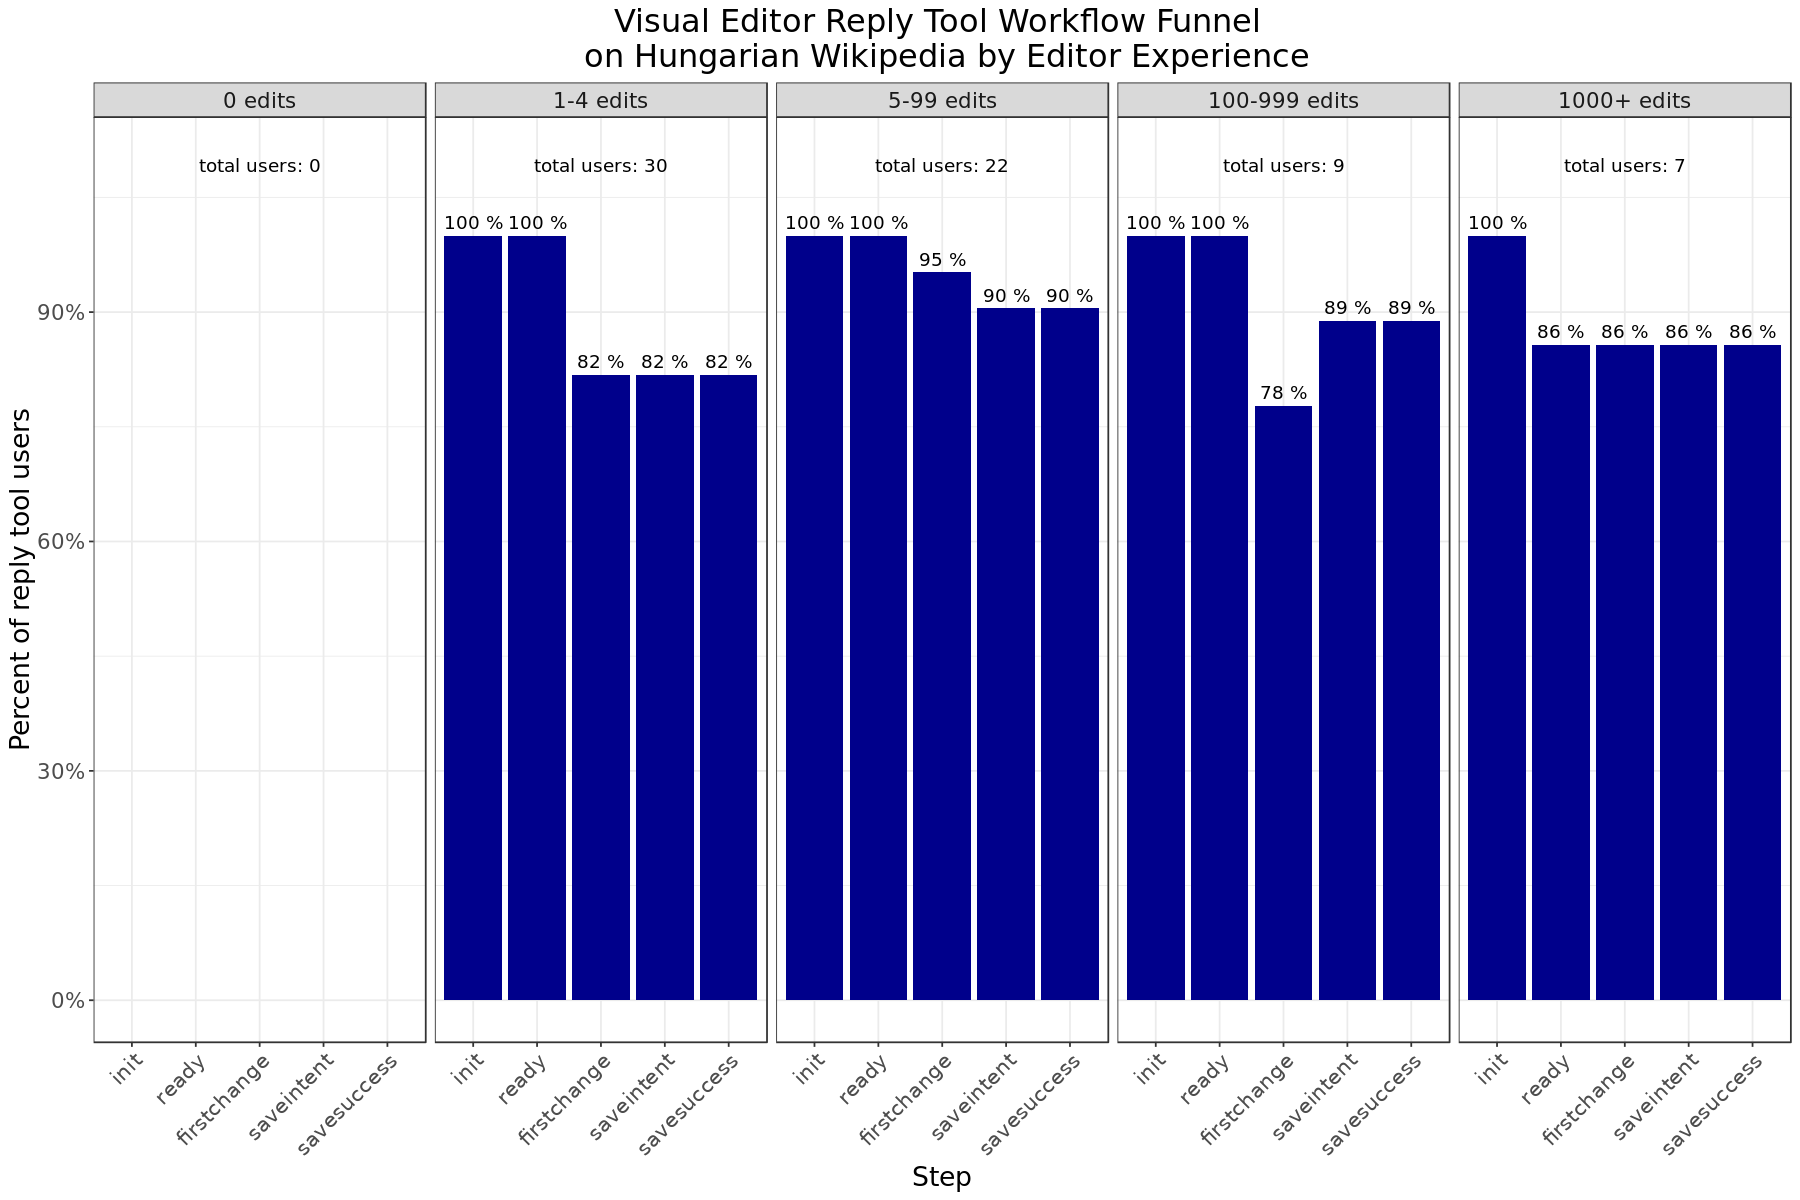

In [34]:
# plot for huwiki

p <- reply_users_workflow_funnel_forplot_bywiki_editcount %>%
    filter(wiki == 'huwiki',
           editor_interface == 'visualeditor') %>%
    group_by(step, edit_count_bucket, editor_interface) %>%
    mutate(n_users = sum(n_users),
              pct_users = n_users/init_users_editcount) %>%
    ggplot(aes(x=step, y= pct_users)) +
        geom_bar(stat='identity', position = 'dodge', fill = 'darkblue') +
        geom_text(aes(label = paste(round(pct_users * 100), '%')), vjust=-0.5) +
            geom_text(aes(x,y,label=lab),
        data=data.frame(x= 'firstchange', y= 1.1, lab=c("total users: 0","total users: 30","total users: 22", "total users: 9", "total users: 7"),
             edit_count_bucket= c("0 edits", "1-4 edits", "5-99 edits", "100-999 edits", "1000+ edits" )), vjust=1) +
        facet_grid(~edit_count_bucket) +
        scale_y_continuous(labels = scales::percent) +
        labs (y = "Percent of reply tool users",
          x = "Step",
         title = "Visual Editor Reply Tool Workflow Funnel \n on Hungarian Wikipedia by Editor Experience")  +
         theme_bw() +
         theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
       legend.position = "none")
      
p

ggsave("Figures/ve_reply_workflow_huwiki_editcount.png", p, width = 16, height = 8, units = "in", dpi = 300)

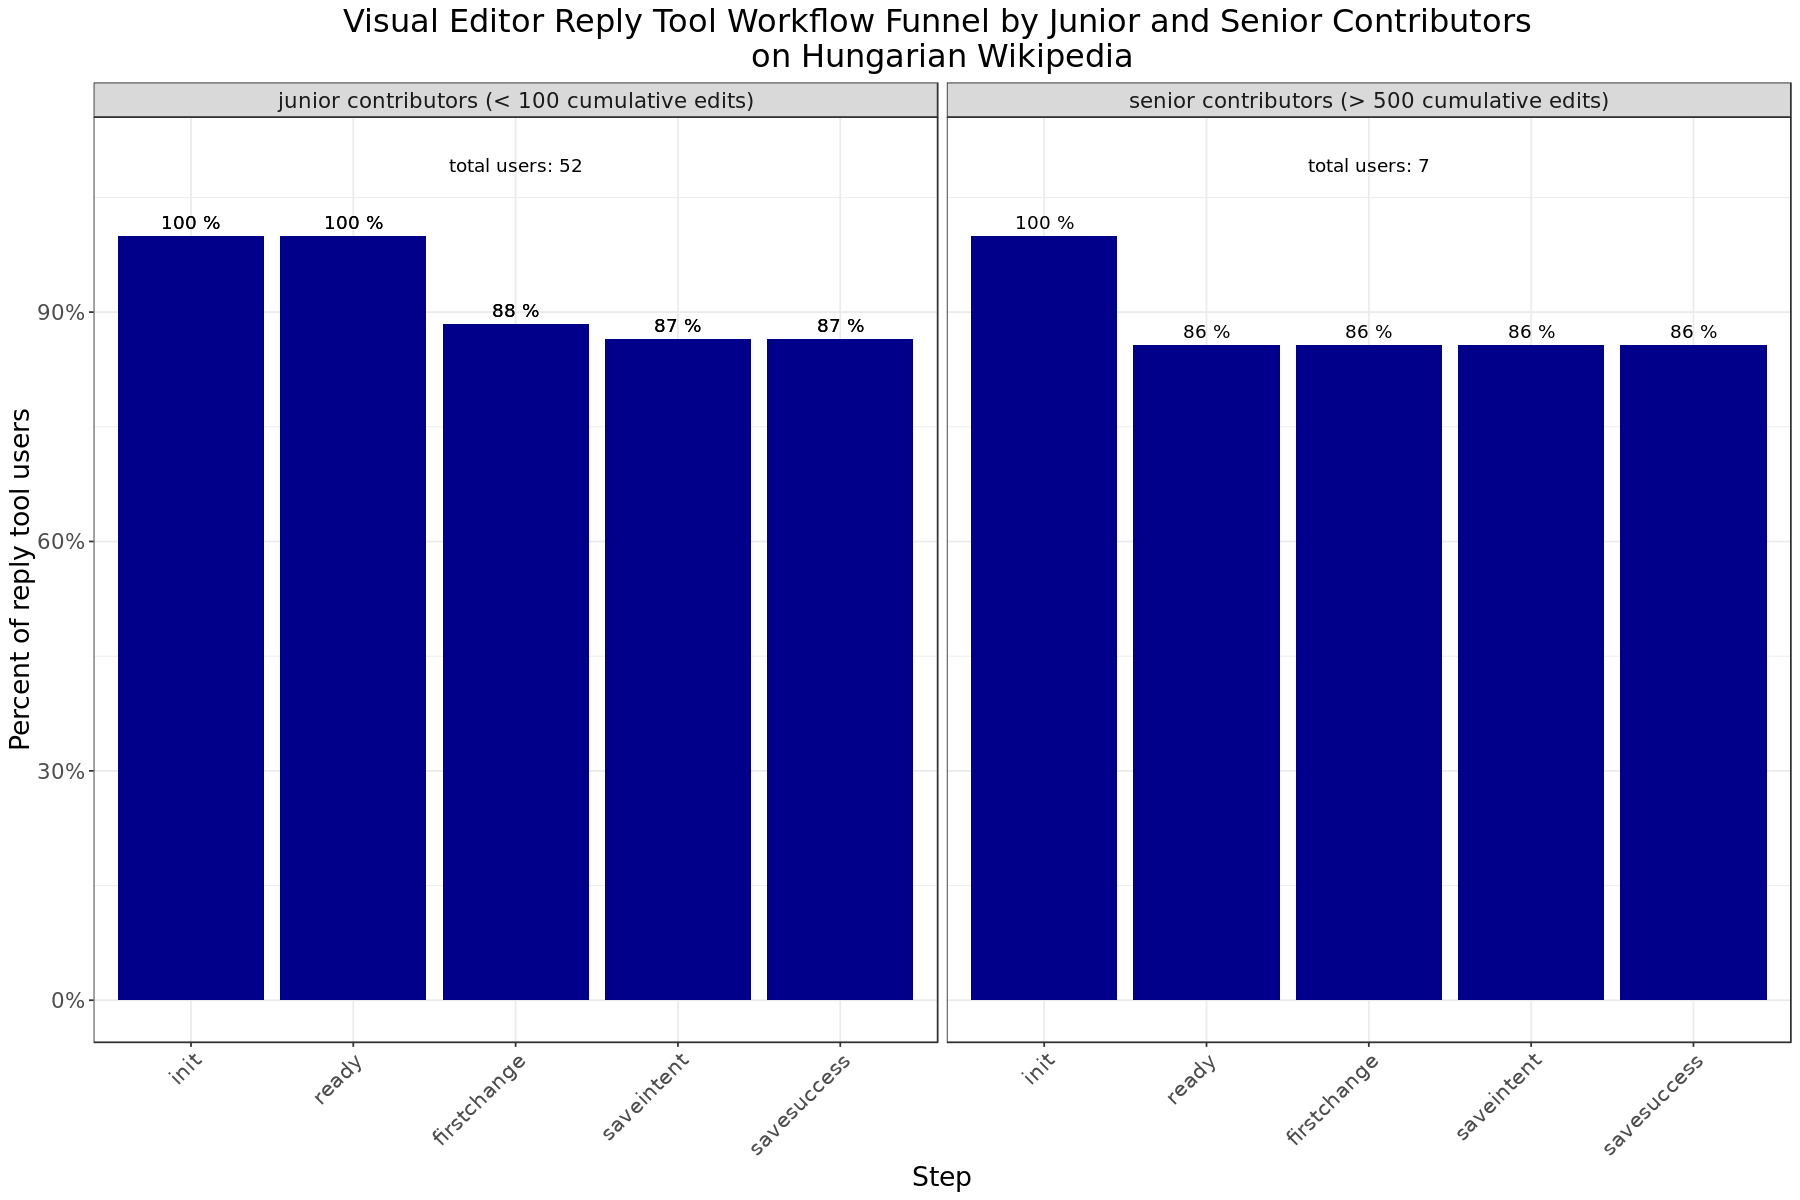

In [463]:
# plot workflow on huwiki on VE broken down by experience

p <- reply_users_workflow_funnel_forplot_bywiki_experience %>%
    filter(wiki == 'huwiki',
           editor_interface == 'visualeditor') %>%
    group_by(step, experience_level, editor_interface) %>%
    mutate(n_users = sum(n_users),
              pct_users = n_users/init_users_experience) %>%
    ggplot(aes(x=step, y= pct_users)) +
        geom_bar(stat='identity', position = 'dodge', fill = 'darkblue') +
        geom_text(aes(label = paste(round(pct_users * 100), '%')), vjust=-0.5) +
        geom_text(aes(x,y,label=lab),
        data=data.frame(x= 'firstchange', y= 1.1, lab=c("total users: 52","total users: 7"),
             experience_level = c("junior contributors (< 100 cumulative edits)", "senior contributors (> 500 cumulative edits)")), vjust=1) +
        facet_grid(~experience_level) +
        scale_y_continuous(labels = scales::percent) +
        labs (y = "Percent of reply tool users",
          x = "Step",
         title = "Visual Editor Reply Tool Workflow Funnel by Junior and Senior Contributors \n on Hungarian Wikipedia ")  +
         theme_bw() +
         theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
       legend.position = "none")
    p
                  
                 
ggsave("Figures/ve_reply_workflow_huwiki_experience.png", p, width = 16, height = 8, units = "in", dpi = 300)

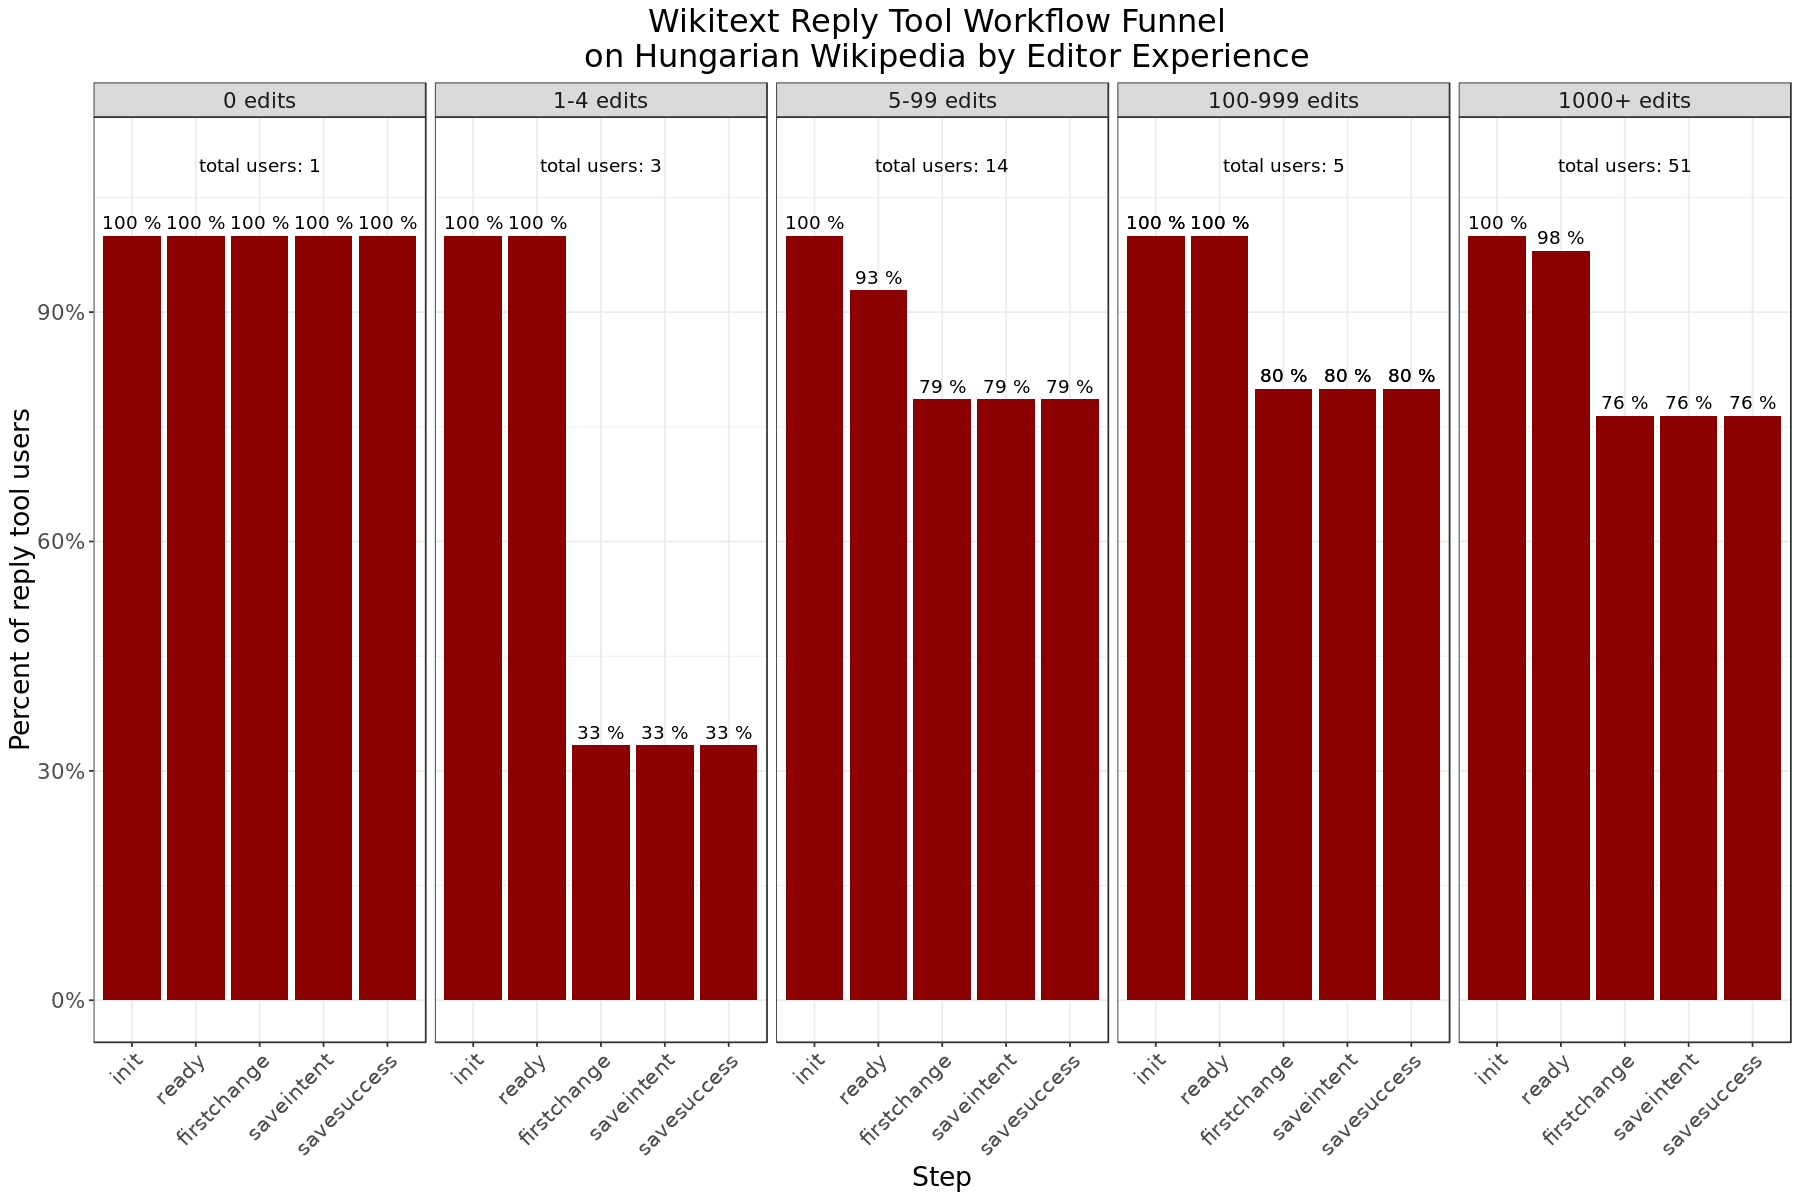

In [300]:
# plot workflow on huwiki on wikitext broken down by experience

p <- reply_users_workflow_funnel_forplot_bywiki_editcount %>%
    filter(wiki == 'huwiki',
           editor_interface == 'wikitext') %>%
    group_by(step, edit_count_bucket, editor_interface) %>%
    mutate(n_users = sum(n_users),
              pct_users = n_users/init_users_editcount) %>%
    ggplot(aes(x=step, y= pct_users)) +
        geom_bar(stat='identity', position = 'dodge', fill = 'red4') +
        geom_text(aes(label = paste(round(pct_users*100), '%')), vjust=-0.5) +
        geom_text(aes(x,y,label=lab),
        data=data.frame(x= 'firstchange', y= 1.1, lab=c("total users: 1","total users: 3","total users: 14", "total users: 5", "total users: 51"),
             edit_count_bucket= c("0 edits", "1-4 edits", "5-99 edits", "100-999 edits", "1000+ edits" )), vjust=1) +
        facet_grid(~edit_count_bucket) +
        scale_y_continuous(labels = scales::percent) +
        labs (y = "Percent of reply tool users",
          x = "Step",
         title = "Wikitext Reply Tool Workflow Funnel \n on Hungarian Wikipedia by Editor Experience")  +
         theme_bw() +
         theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
       legend.position = "none")
p

ggsave("Figures/wikitext_reply_workflow_huwiki_editcount.png", p, width = 16, height = 8, units = "in", dpi = 300)

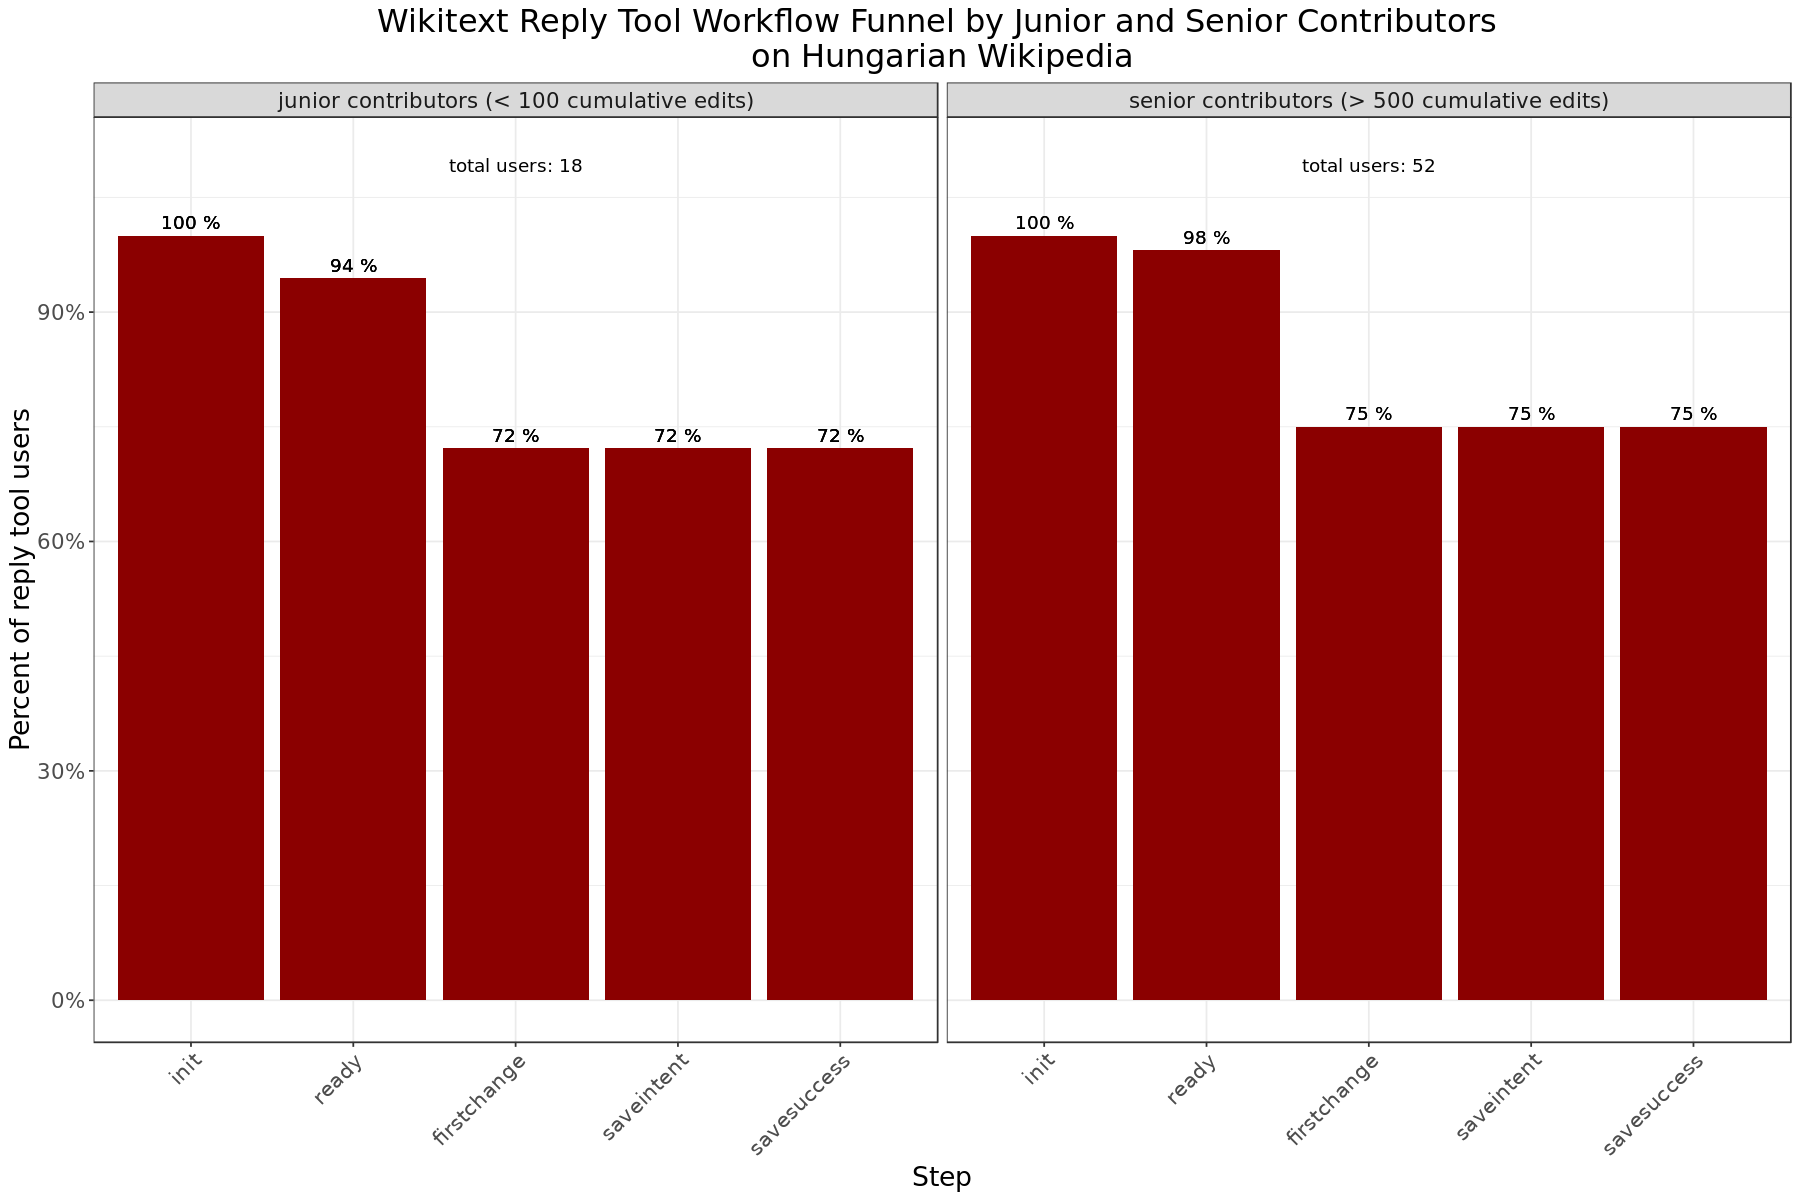

In [462]:
# plot workflow on huwiki on VE broken down by experience

p <- reply_users_workflow_funnel_forplot_bywiki_experience %>%
    filter(wiki == 'huwiki',
           editor_interface == 'wikitext') %>%
    group_by(step, experience_level, editor_interface) %>%
    mutate(n_users = sum(n_users),
              pct_users = n_users/init_users_experience) %>%
    ggplot(aes(x=step, y= pct_users)) +
        geom_bar(stat='identity', position = 'dodge', fill = 'red4') +
        geom_text(aes(label = paste(round(pct_users * 100), '%')), vjust=-0.5) +
        geom_text(aes(x,y,label=lab),
        data=data.frame(x= 'firstchange', y= 1.1, lab=c("total users: 18","total users: 52"),
             experience_level = c("junior contributors (< 100 cumulative edits)", "senior contributors (> 500 cumulative edits)")), vjust=1) +
        facet_grid(~experience_level) +
        scale_y_continuous(labels = scales::percent) +
        labs (y = "Percent of reply tool users",
          x = "Step",
         title = "Wikitext Reply Tool Workflow Funnel by Junior and Senior Contributors \n on Hungarian Wikipedia ")  +
         theme_bw() +
         theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1),
       legend.position = "none")
    p
                  
                 
ggsave("Figures/wikitext_reply_workflow_huwiki_experience.png", p, width = 16, height = 8, units = "in", dpi = 300)

A few key observations re the workflow completion rate for each wiki: 
* For all threee opt-out wikis, senior contributors using visual editor typically had a higher rate of completion through each reply workflow step compared to wikitext. Results varies a little more for junior contributors. 
* On Arabic Wikipedia, only 28% of junior contributors with 1 to 4 cumulative edits started typing a comment using visual editor after clicking the reply link. This is significantly lower compared to junior contributors with 1 to 4 edits using visual editor on the two other opt-out wikis (78% on Czech and 82% on Hungarian).
* On Hungarian Wikipedia, 33% of junior contributors with 1 to 4 cumulative edits using wikitext that clicked reply started typing a comment compated to 82% using visual editor. 


# Reply Tool Completion Rate

The section below focuses on the reply tool completion rate (Of of users who click the Reply link (action = `init`), what % of people successfully publish the comment they were drafting (action = `saveSuccess`))?

We compared the reply tool completion rate to full-page talk page edit completion rate (grouped by experience level)  to approximate how much more or less likely people are to successfully publish replies with the Reply Tool compared to full page wikitext editing. We excluded `section=new` edits from these comparison charts since we can be relatively sure that contributors are not using the `section=new` form and workflow for replying.


## Reply Tool Completion Rate by Editor Experience

In [ ]:
reply_users_workflow_funnel_forplot_overall <- inner_join(reply_users_workflow_funnel_clean, init_users_overall)

In [303]:
reply_tool_completion_rate_overall <- reply_users_workflow_funnel_forplot_overall %>%
    filter(step == 'savesuccess') %>%
    group_by(edit_count_bucket) %>%
    summarise(n_users = sum(n_users),
              pct_replytool_completion_rate = sum(n_users)/init_users_overall, .groups = 'drop') %>%
    distinct()

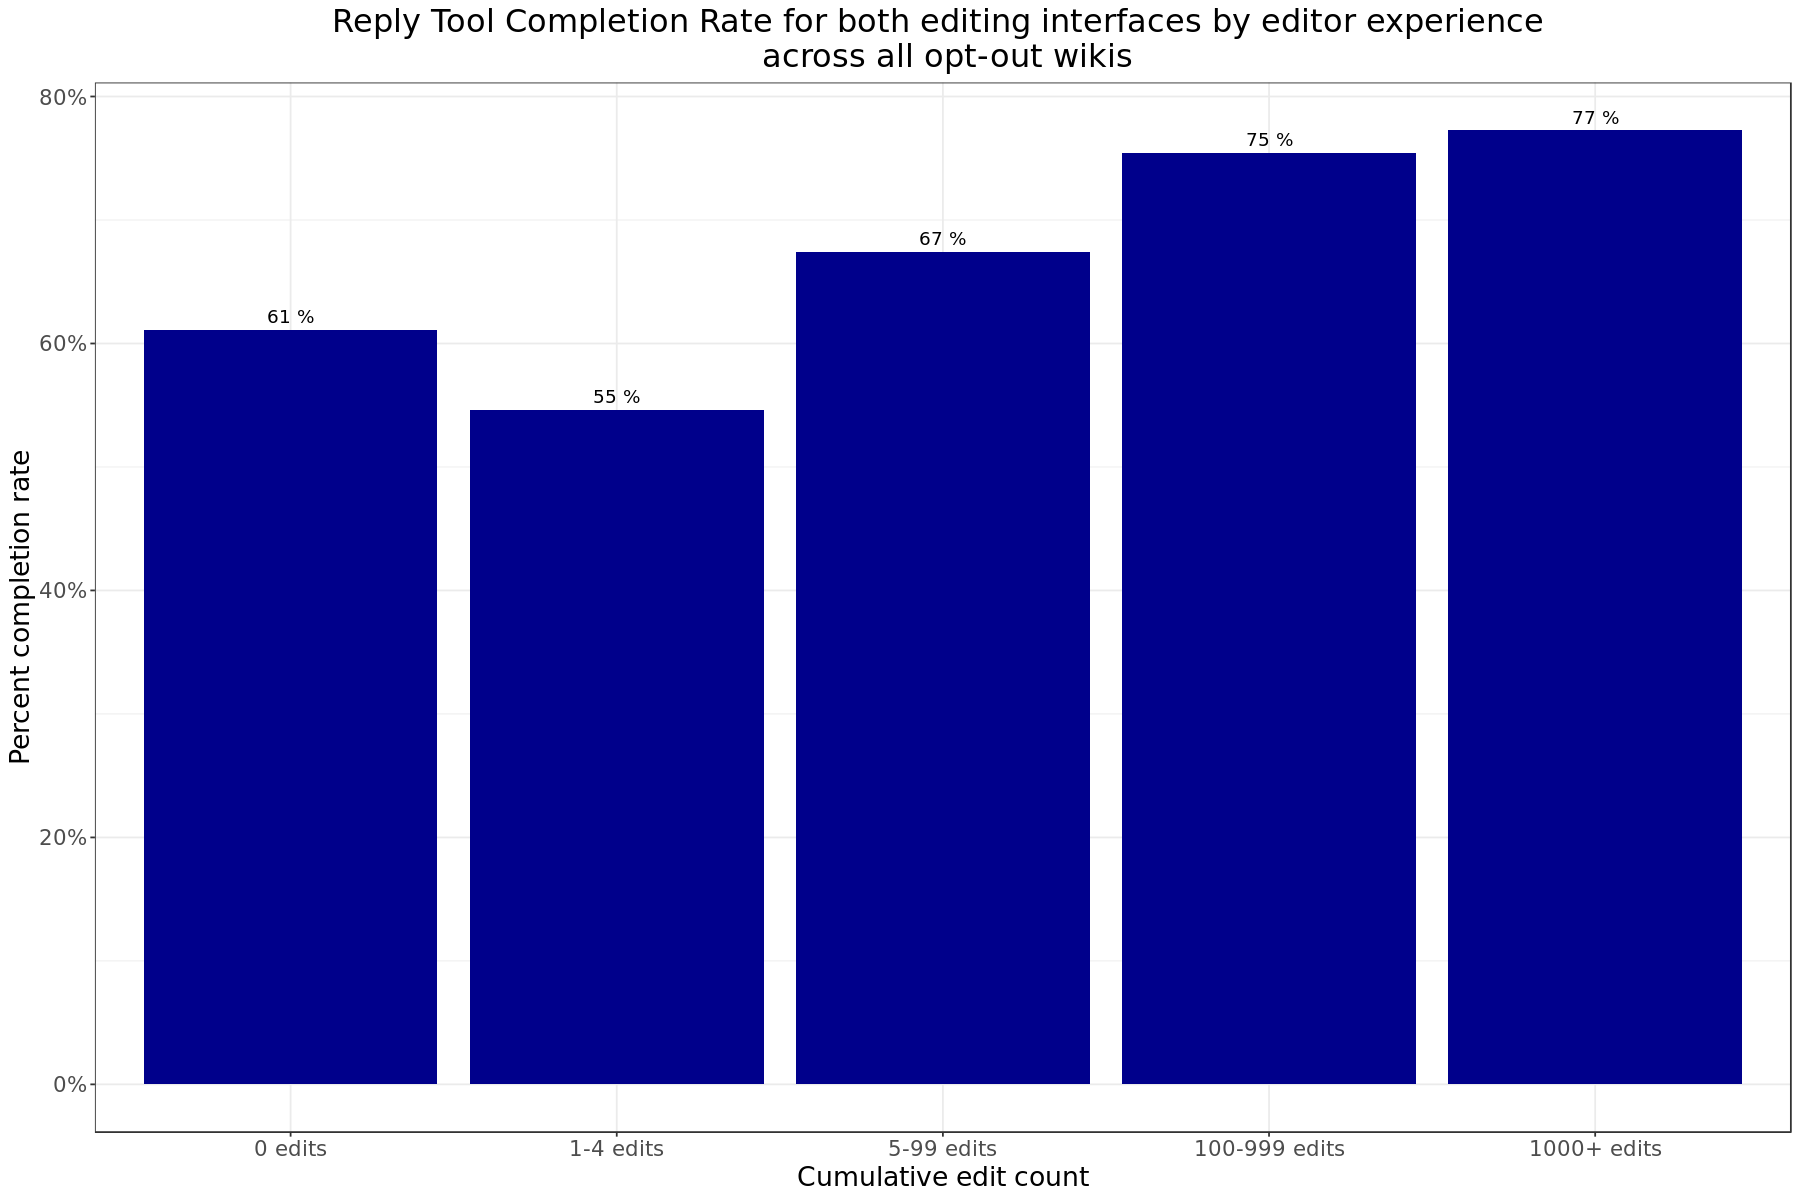

In [356]:
# plot completion rate for reply tool by Editor Experience for both Interfaces

p <- reply_tool_completion_rate_overall %>%
      ggplot(aes(x=edit_count_bucket, y= pct_replytool_completion_rate)) +
        geom_bar(stat='identity', position = 'dodge', fill = 'darkblue') +
        geom_text(aes(label = paste(round(pct_replytool_completion_rate * 100), '%')), vjust=-0.5) +
         scale_y_continuous(labels = scales::percent) +
        labs (y = "Percent completion rate",
          x = "Cumulative edit count",
         title = "Reply Tool Completion Rate for both editing interfaces by editor experience \n across all opt-out wikis")  +
         theme_bw() +
         scale_fill_brewer(palette="Set1")  +
          theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position = 'bottom'
        ) 
      
p
ggsave("Figures/reply_completion_rate_overall_editcount_bothinterfaces.png", p, width = 16, height = 8, units = "in", dpi = 300)

In [306]:
reply_tool_completion_rate_byeditcount <- reply_users_workflow_funnel_forplot_editcount %>%
    filter(step == 'savesuccess') %>%
    group_by(edit_count_bucket, editor_interface) %>%
    summarise(n_users = sum(n_users),
              pct_replytool_completion_rate = sum(n_users)/init_users_byeditcount, .groups = 'drop')


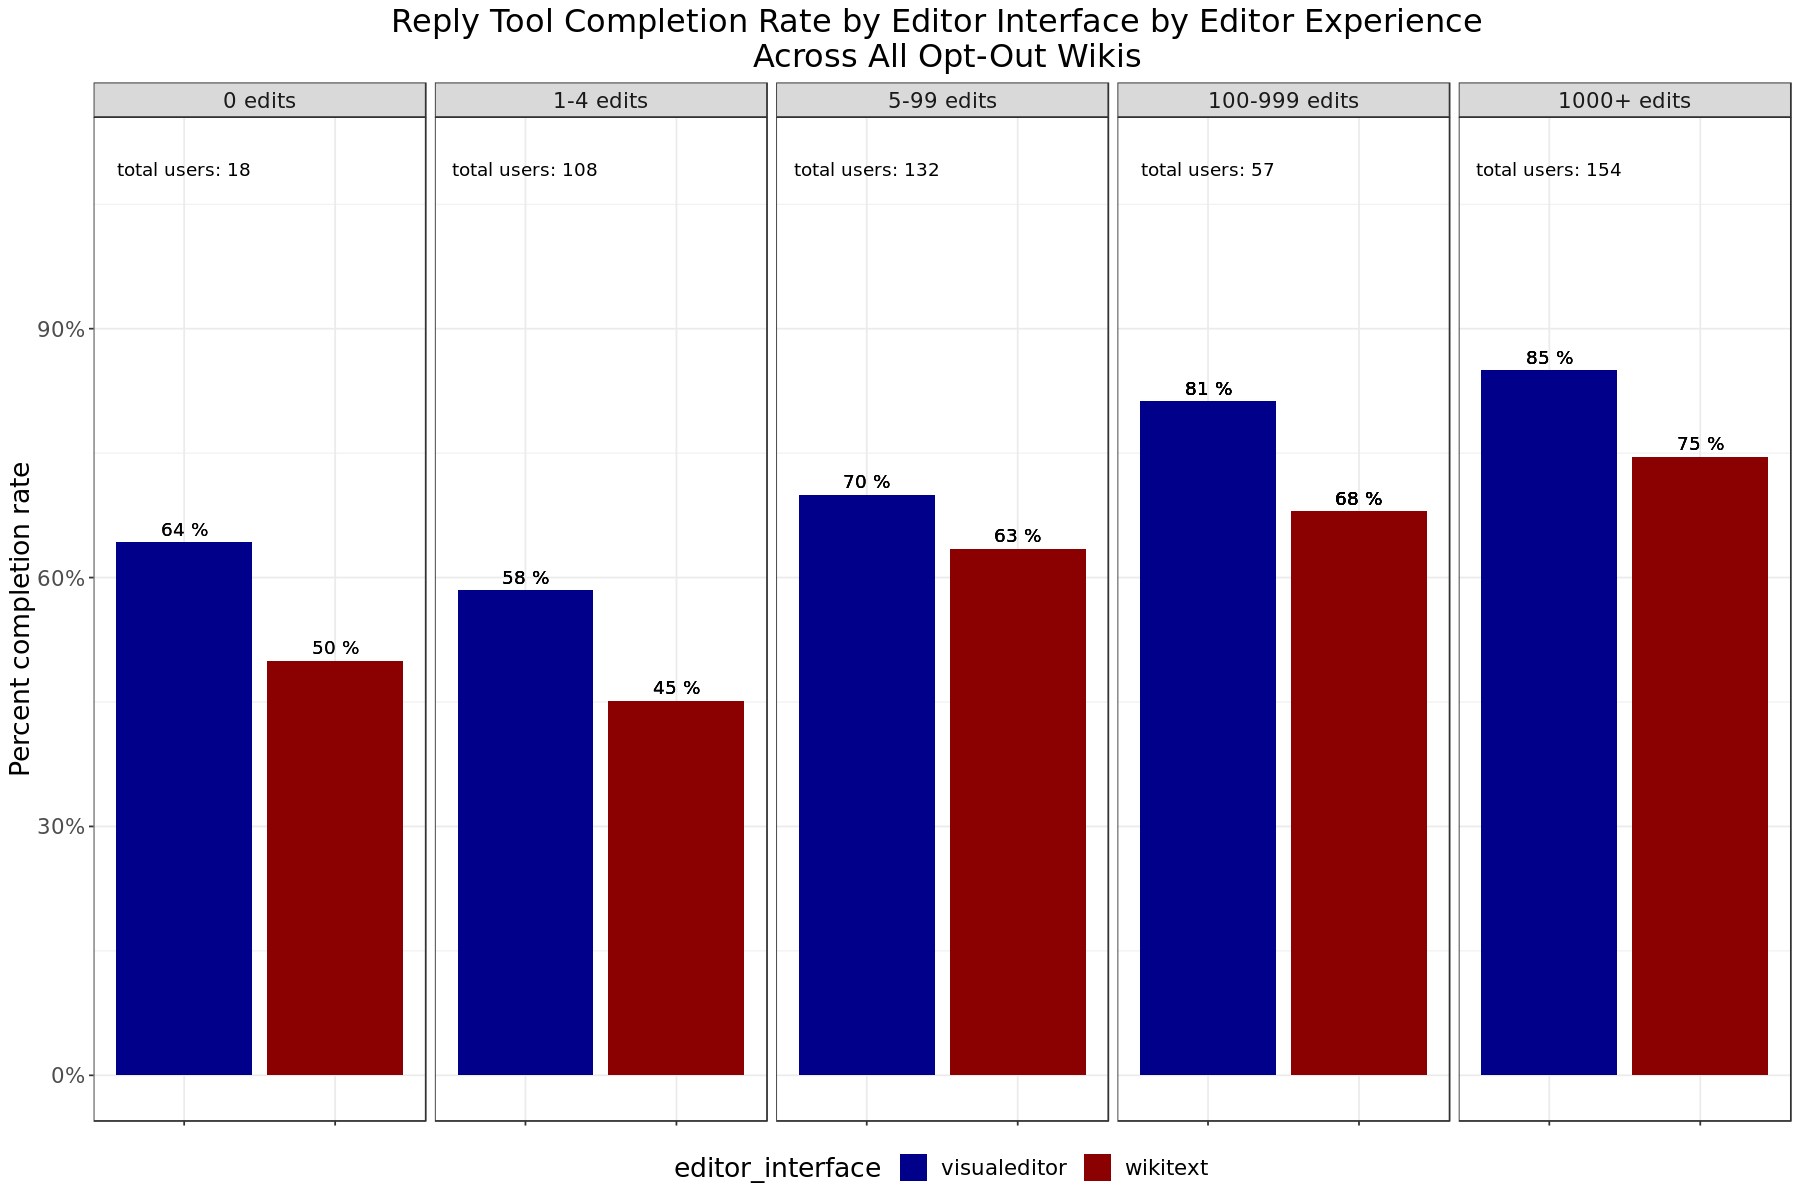

In [498]:
# plot completion rate for reply tool by Editor Experience

p <- reply_tool_completion_rate_byeditcount %>%
      ggplot(aes(x=editor_interface, y= pct_replytool_completion_rate)) +
        geom_bar(aes(fill = editor_interface),stat='identity', position = 'dodge') +
        geom_text(aes(label = paste(round(pct_replytool_completion_rate * 100), '%')), vjust=-0.5) +
        geom_text(aes(x,y,label=lab),
        data=data.frame(x= 'visualeditor', y= 1.1, lab=c("total users: 18","total users: 108","total users: 132", "total users: 57", "total users: 154"),
             edit_count_bucket= c("0 edits", "1-4 edits", "5-99 edits", "100-999 edits", "1000+ edits" )), vjust=1) +
        facet_grid(~edit_count_bucket) +
         scale_y_continuous(labels = scales::percent) +
        labs (y = "Percent completion rate",
          x = "Editor Interface",
         title = "Reply Tool Completion Rate by Editor Interface by Editor Experience \n Across All Opt-Out Wikis")  +
         theme_bw() +
         scale_fill_manual(values = c ('darkblue', 'red4'))  +
          theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position = 'bottom',
        axis.title.x = element_blank(),
        axis.text.x=element_blank()
        ) 
      
p
ggsave("Figures/reply_completion_rate_overall_editcount.png", p, width = 16, height = 8, units = "in", dpi = 300)

In [308]:
reply_tool_completion_rate_byexperience <- reply_users_workflow_funnel_forplot_experience %>%
    filter(step == 'savesuccess') %>%
    group_by(experience_level, editor_interface) %>%
    summarise(pct_replytool_completion_rate = sum(n_users/init_users_byexperience), .groups = 'drop')

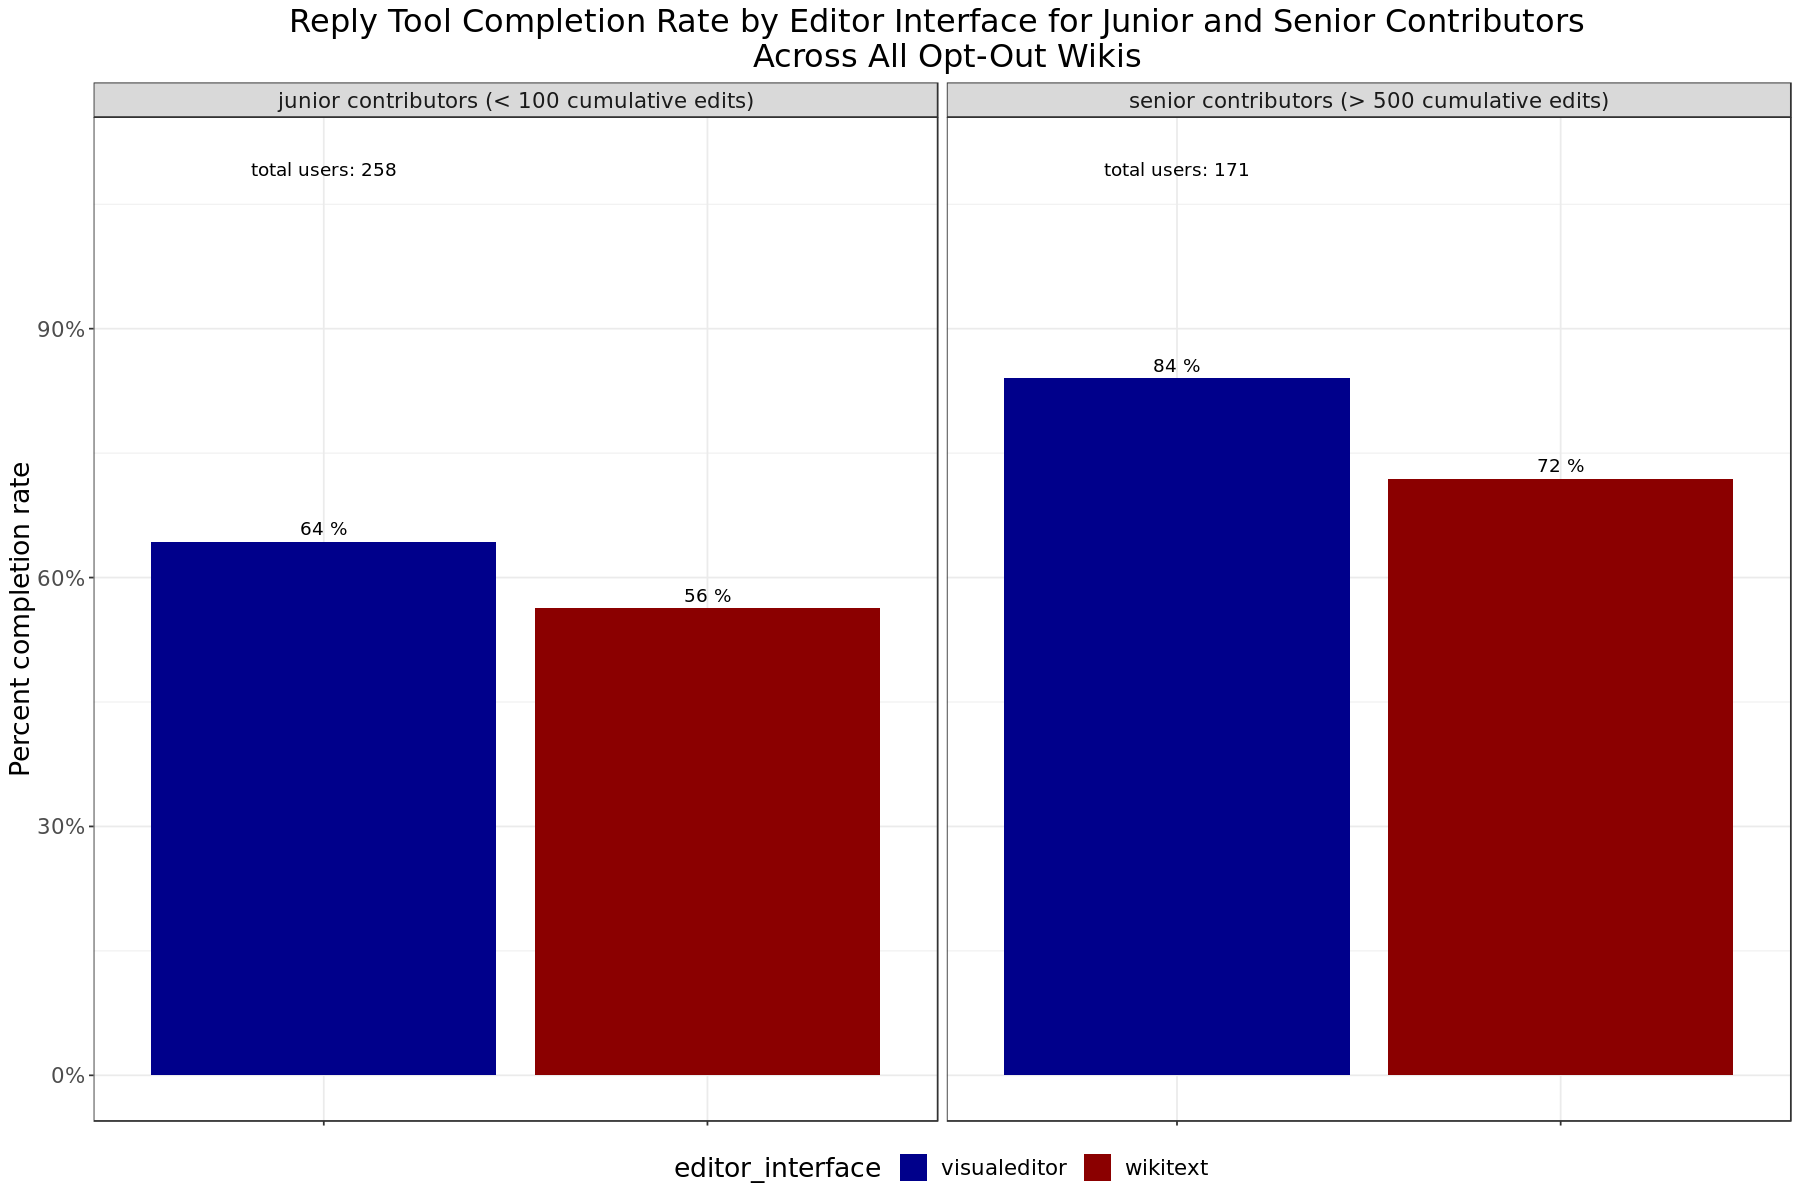

In [499]:
# plot completion rate for reply tool by Junior vs Senior Contributors

p <- reply_tool_completion_rate_byexperience %>%
      ggplot(aes(x=editor_interface, y= pct_replytool_completion_rate)) +
        geom_bar(aes(fill = editor_interface),stat='identity', position = 'dodge') +
        geom_text(aes(label = paste(round(pct_replytool_completion_rate * 100), '%')), vjust=-0.5) +
        geom_text(aes(x,y,label=lab),
        data=data.frame(x= 'visualeditor', y= 1.1, lab=c("total users: 258","total users: 171"),
             experience_level = c("junior contributors (< 100 cumulative edits)", "senior contributors (> 500 cumulative edits)")), vjust=1) +
        facet_grid(~experience_level) +
         scale_y_continuous(labels = scales::percent) +
        labs (y = "Percent completion rate",
          x = "Editor Interface",
         title = "Reply Tool Completion Rate by Editor Interface for Junior and Senior Contributors \n Across All Opt-Out Wikis")  +
         theme_bw() +
         scale_fill_manual(values = c ('darkblue', 'red4'))  +
          theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position = 'bottom',
        axis.title.x = element_blank(),
        axis.text.x=element_blank()
        ) 
      
p
ggsave("Figures/reply_completion_rate_overall_experience.png", p, width = 16, height = 8, units = "in", dpi = 300)



Reply comments made with Visual Editor had a higher completion rate across all contributor experience levels. The completion rate generally increases with experience level. There is a slightly higher completion rate for first time contributors (0 cumulative edits) than contributors with 1 to 4 edits; however, available data for the 0 edits group was limited (only 18 users across all three opt-out wikis) at the time of analysis and not large enough to draw any conclusions about this user group.


## Reply Tool vs Full Talk Page Wikitext Completion Rates

In [314]:
# collect data on talk page wikitext edit completion rate
query <- 
"
--only include full sessions where an init talk page edit was logged during the reviewed timeframe 
   
WITH init_sessions AS (
SELECT 
  event.editing_session_id AS session_id,
  wiki AS wiki
FROM event_sanitized.editattemptstep
WHERE
  year = 2020 AND
  event.action = 'init'
-- remove all 'section = new' events
  AND NOT (event.init_type = 'section' and event.init_mechanism = 'new')
  AND dt between '2020-09-24' AND '2020-12-08'
-- review wikis where deployed as opt-out
  AND wiki IN ('arwiki', 'cswiki', 'huwiki')
  AND event.integration= 'page'
-- only review talk pages
  AND event.page_ns % 2 == 1 
-- remove anonymous users
  AND event.user_id != 0
)
SELECT
user,
wiki,
min(edit_count) AS edit_count,
sum(cast(action = 'init' as int)) >= 1 AS init_completed,
sum(cast(action = 'saveSuccess' as int)) >= 1 AS saveSuccess_completed
FROM (
SELECT
  eas.event.user_editcount AS edit_count,
  eas.event.user_id AS user,
  eas.event.editing_session_id AS session_id,
  eas.event.action AS action,
  eas.wiki AS wiki,
  COUNT(*) AS events
FROM event_sanitized.editattemptstep eas
INNER JOIN
    init_sessions 
    ON eas.event.editing_session_id = init_sessions.session_id 
    AND eas.wiki = init_sessions.wiki
WHERE
  year = 2020 
-- events since deployment date
  AND dt between '2020-09-24' AND '2020-12-08'
-- review wikis where deployed as opt-out
  AND eas.wiki IN ('arwiki', 'cswiki', 'huwiki')
  AND NOT (event.init_type = 'section' and event.init_mechanism = 'new')
  AND eas.event.integration= 'page'
-- only review talk pages
  AND eas.event.page_ns % 2 == 1 
-- remove anonymous users
  AND eas.event.user_id != 0
GROUP BY 
  eas.event.user_id,
  eas.event.user_editcount,
  eas.event.action,
  eas.event.editing_session_id,
  eas.wiki
) AS sessions_data
GROUP BY
user,
wiki
"


In [ ]:
collect_full_talk_page_edits <- wmfdata::query_hive(query)

In [316]:
# add column with user edit count buckets

full_talk_page_events_with_editcount <- collect_full_talk_page_edits %>%
    mutate(edit_count_bucket = case_when(
            edit_count == 0 ~ '0 edits',
            edit_count >=1 & edit_count <= 4 ~ '1-4 edits',
            edit_count >=5 & edit_count <= 99 ~ '5-99 edits',
            edit_count >=100 & edit_count <= 999 ~ '100-999 edits',
            edit_count >=1000 ~ '1000+ edits'),
          experience_level = case_when( 
             edit_count < 100 ~ 'junior contributors (< 100 cumulative edits)',
             edit_count > 500 ~ 'senior contributors (> 500 cumulative edits)'))

In [317]:
# Order edit counts
full_talk_page_events_with_editcount$edit_count_bucket %<>% 
    factor(levels= c("0 edits", "1-4 edits", "5-99 edits", "100-999 edits", "1000+ edits"))

In [318]:
# completion rate by editcount
full_talk_users_completion_rate_editcount <- full_talk_page_events_with_editcount %>%
    group_by(edit_count_bucket) %>%
    summarise(init = sum(init_completed == 'true'),
            savesuccess = sum(savesuccess_completed == 'true'),
             full_page_wikitext = savesuccess/init, .groups = 'drop') %>%
# remove unneed columns to match reply tool table for joining later
    select(-c(2,3))

In [319]:
# completion rate by senior vs junior contributors
full_talk_users_completion_rate_experience <- full_talk_page_events_with_editcount %>%
    filter(experience_level != 'NA') %>%
    group_by(experience_level) %>%
    summarise(init = sum(init_completed == 'true'),
            savesuccess = sum(savesuccess_completed == 'true'),
             full_page_wikitext = savesuccess/init, .groups = 'drop') %>%
# remove unneed columns to match reply tool table for joining later
    select(-c(2,3))


### Reply Tool (Wikitext and VE) vs Full Page Wikitext

In [ ]:
# join to show comparison between the two groups by edit count
edit_completion_rate_comparison_both <- inner_join(full_talk_users_completion_rate_editcount, reply_tool_completion_rate_overall) %>%
    rename(reply_tool_both_interfaces = pct_replytool_completion_rate) %>%
    select(-3) # remove uneeded column


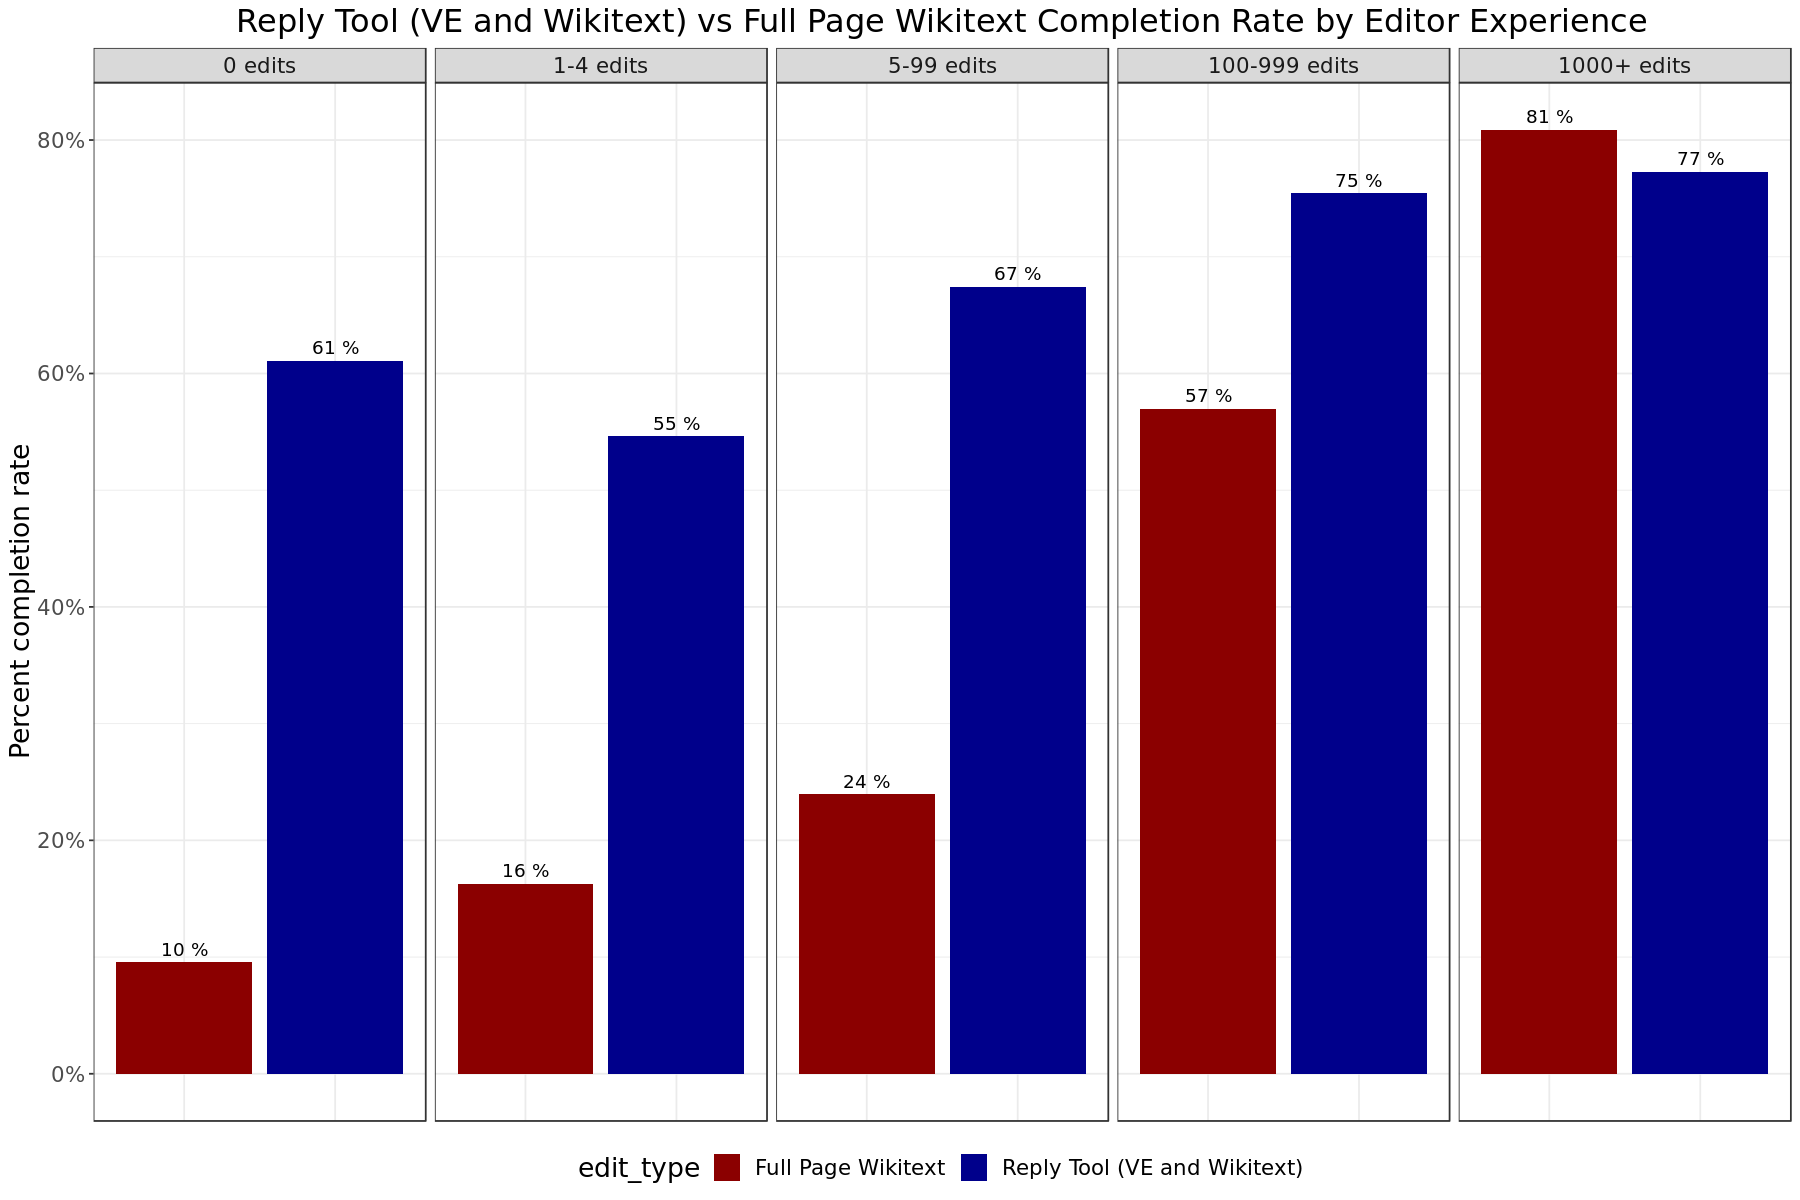

In [472]:
# plot comparison between full page and reply tool completion rates for both editing interfaces

p <- edit_completion_rate_comparison_both %>%
    gather("edit_type", "completion_rate", 2:3)  %>%
     ggplot(aes(x=edit_type, y= completion_rate, fill = edit_type)) +
        geom_bar(stat='identity', position = 'dodge') +
        facet_grid(~edit_count_bucket) +
        geom_text(aes(label = paste(round(completion_rate * 100), '%')), vjust = -0.5, position = position_dodge(width = 1)) +
        scale_y_continuous(labels = scales::percent) +
        labs (y = "Percent completion rate",
          x = "Edit Count Bucket",
         title = "Reply Tool (VE and Wikitext) vs Full Page Wikitext Completion Rate by Editor Experience")  +
         theme_bw() +
        scale_fill_manual(values = c('red4', 'darkblue'), labels = c('Full Page Wikitext', 'Reply Tool (VE and Wikitext)'))  +
         theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())
      
p

ggsave("Figures/reply_completion_rate_wikitext_comparison_both.png", p, width = 16, height = 8, units = "in", dpi = 300)

In [322]:
reply_tool_completion_rate_byexperience_both_interfaces <- reply_users_workflow_funnel_forplot_experience_both %>%
    filter(step == 'savesuccess') %>%
    group_by(experience_level) %>%
    summarise(pct_replytool_completion_rate = sum(n_users/init_users_byexperience_both), .groups = 'drop')

In [ ]:
# join to show comparison between the two groups by edit count
edit_completion_rate_comparison_both_interfaces <- inner_join(full_talk_users_completion_rate_experience, reply_tool_completion_rate_byexperience_both_interfaces) %>%
    rename(reply_tool_both_interfaces_byexperience = pct_replytool_completion_rate) 


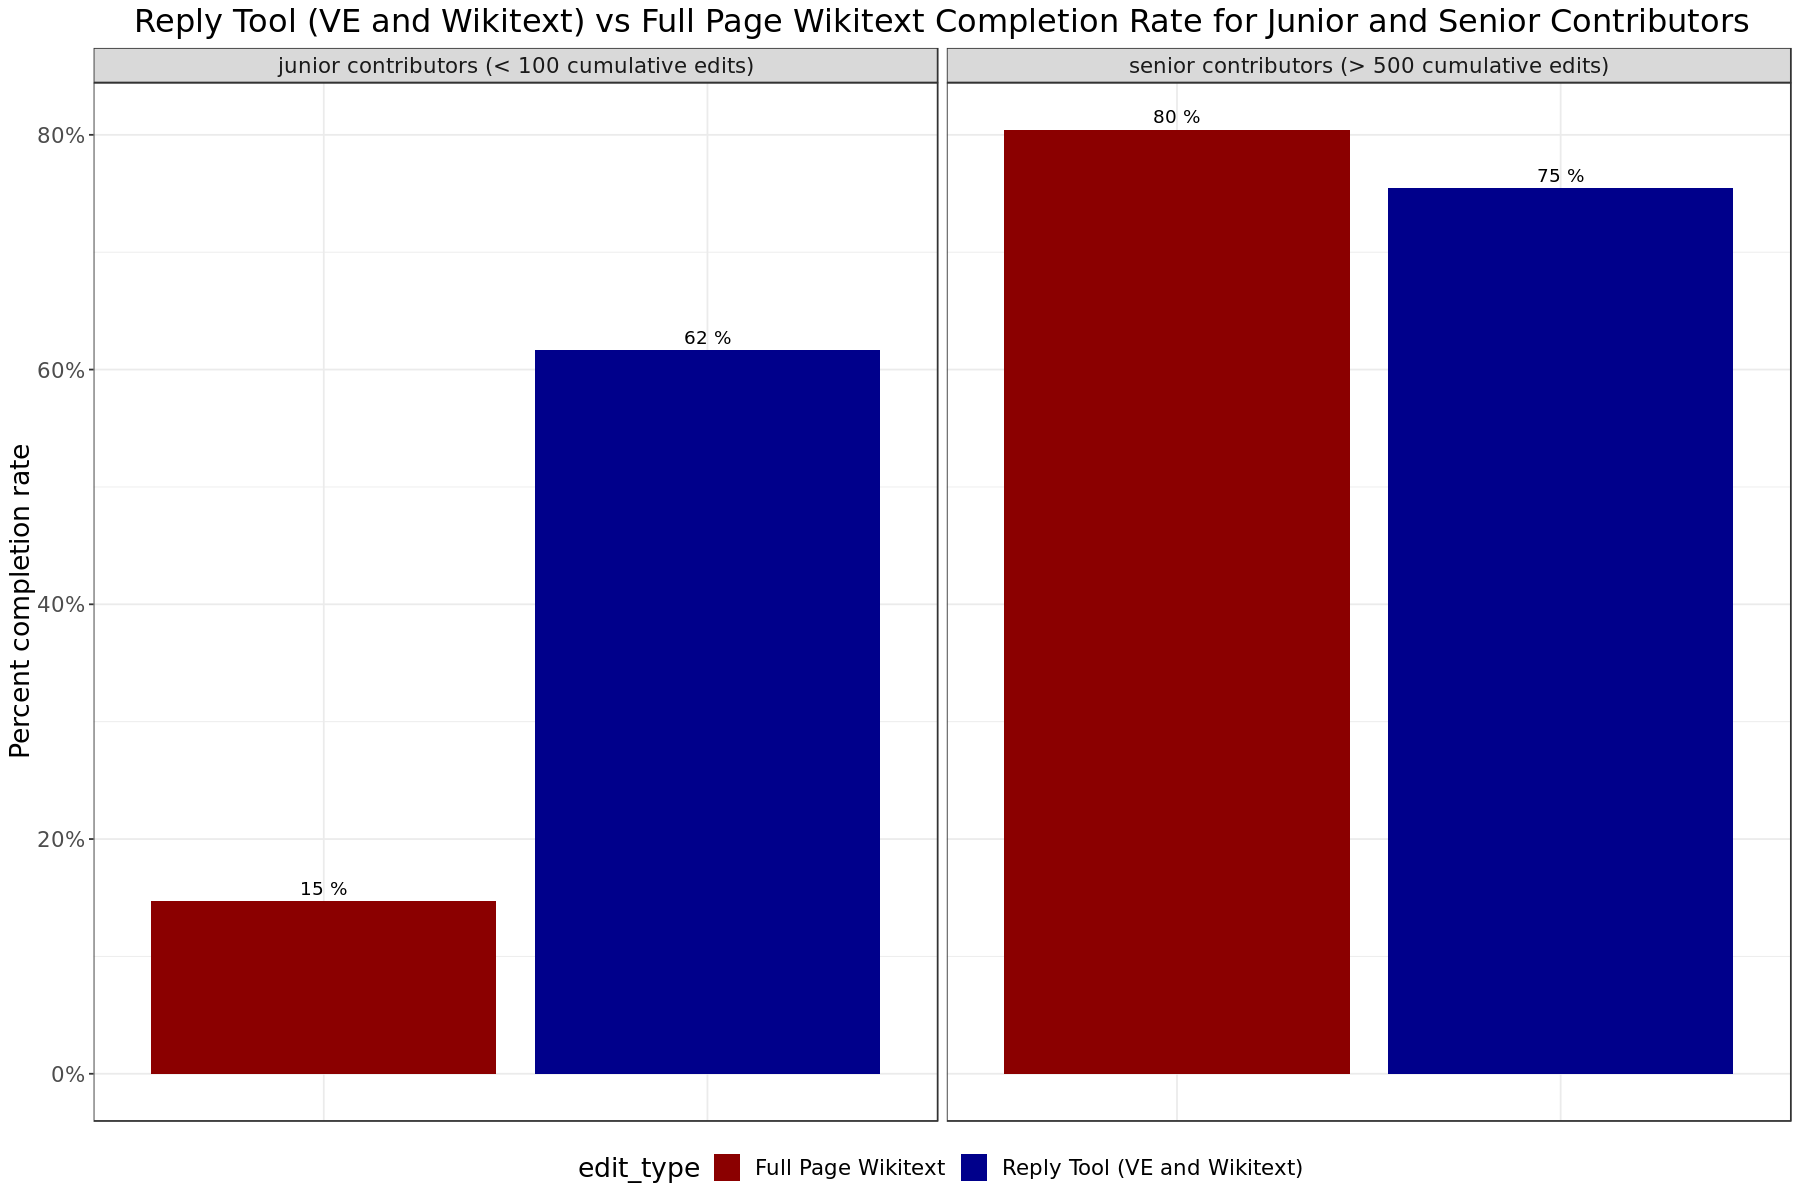

In [473]:
# plot comparison between full page and reply tool completion rates for both editing interfaces

p <- edit_completion_rate_comparison_both_interfaces %>%
    gather("edit_type", "completion_rate", 2:3)  %>%
     ggplot(aes(x=edit_type, y= completion_rate, fill = edit_type)) +
        geom_bar(stat='identity', position = 'dodge') +
        facet_wrap(~experience_level) +
        geom_text(aes(label = paste(round(completion_rate * 100), '%')), vjust = -0.5, position = position_dodge(width = 1)) +
        scale_y_continuous(labels = scales::percent) +
        labs (y = "Percent completion rate",
          x = "Edit Count Bucket",
         title = "Reply Tool (VE and Wikitext) vs Full Page Wikitext Completion Rate for Junior and Senior Contributors")  +
         theme_bw() +
        scale_fill_manual(values = c('red4', 'darkblue'), labels = c('Full Page Wikitext', 'Reply Tool (VE and Wikitext)'))  +
         theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())
      
p

ggsave("Figures/reply_completion_rate_comparison_both_junior_senior.png", p, width = 16, height = 8, units = "in", dpi = 300)

### Reply Tool Visual Editor vs Full Page Wikitext

In [474]:
# reply tool visual editor completion rate
reply_tool_completion_rate_ve <- reply_tool_completion_rate_byeditcount %>%
    filter(editor_interface == 'visualeditor') %>%
    rename(reply_tool_visualeditor = pct_replytool_completion_rate) %>%
     select(-c(2,3)) %>%
    distinct()

In [ ]:
# join to show comparison between the two groups by edit count
edit_completion_rate_comparison_ve <- inner_join(full_talk_users_completion_rate_editcount, reply_tool_completion_rate_ve)


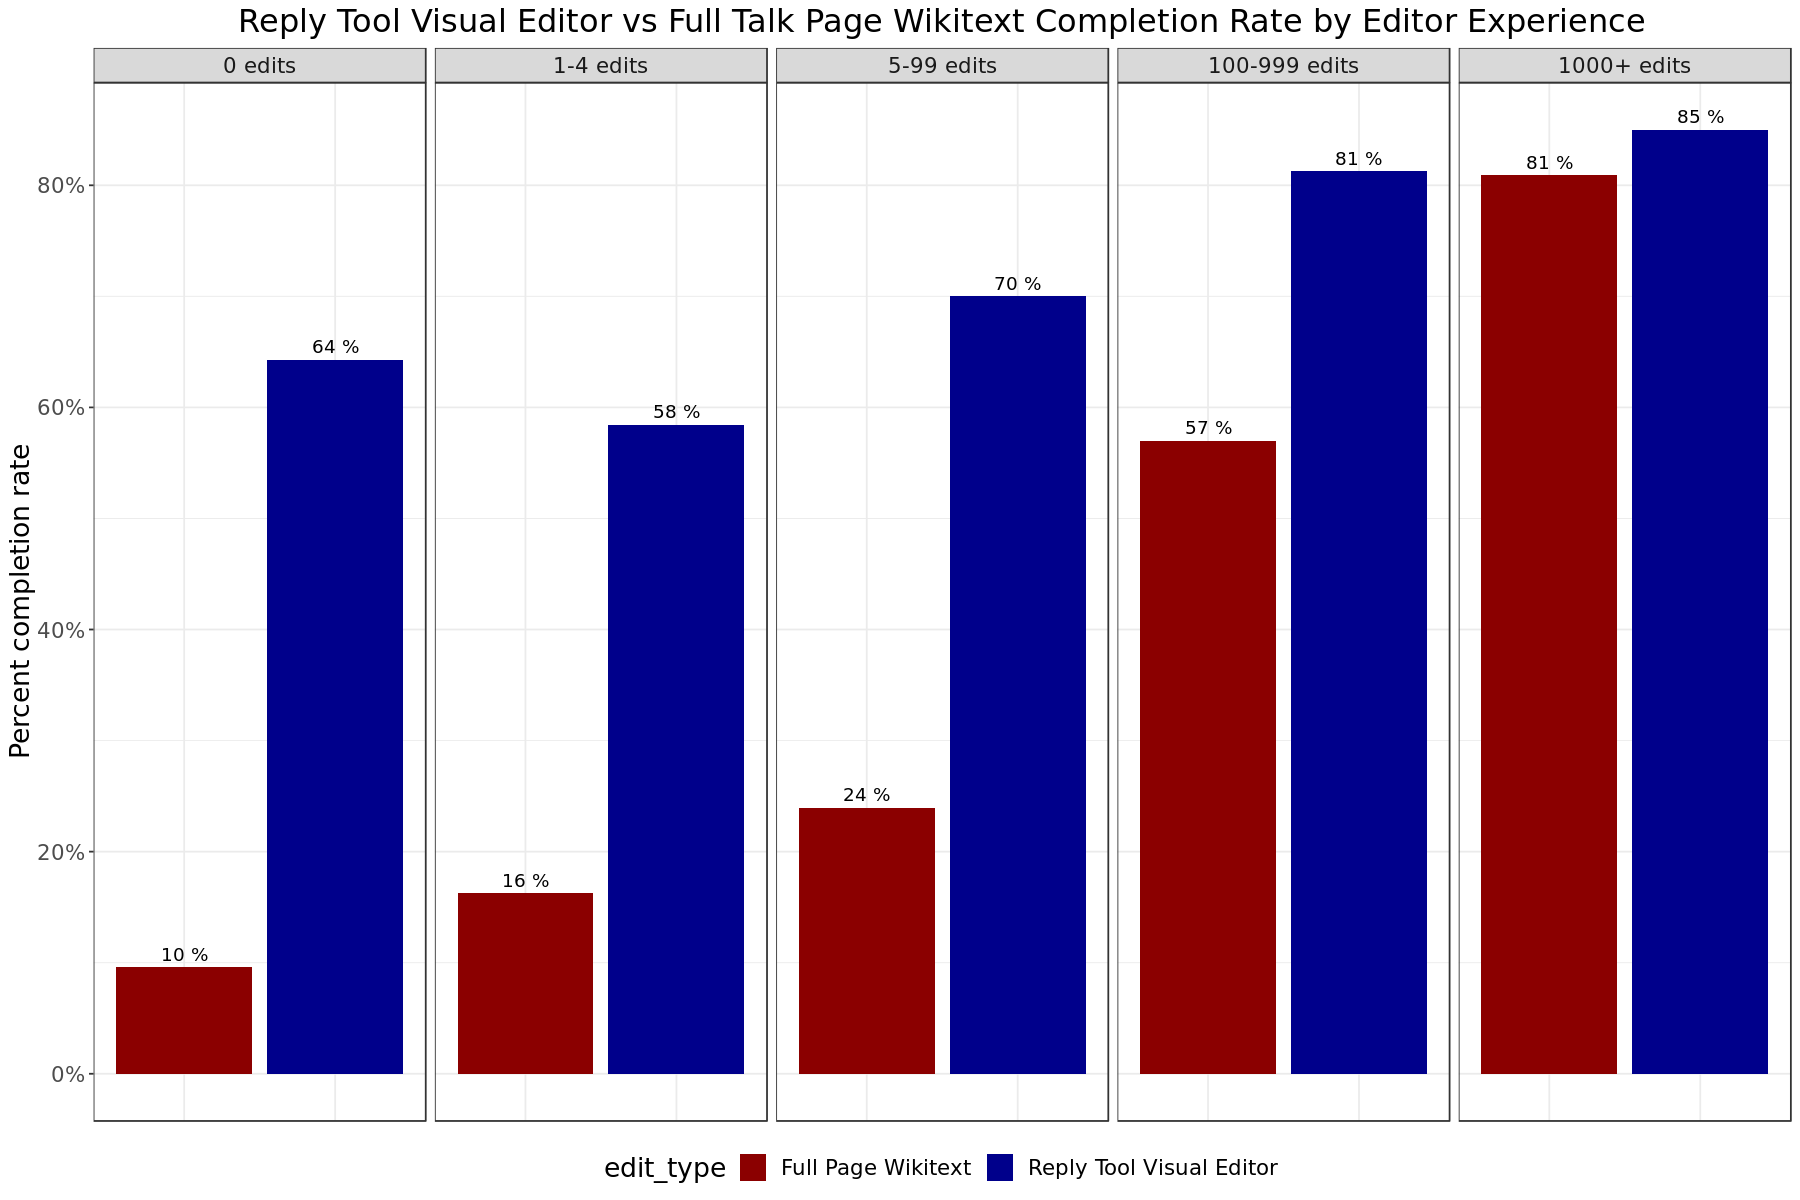

In [476]:
 # plot comparison between full page and reply tool ve completion rates

p <- edit_completion_rate_comparison_ve %>%
    gather("edit_type", "completion_rate", 2:3)  %>%
     ggplot(aes(x=edit_type, y= completion_rate, fill = edit_type)) +
        geom_bar(stat='identity', position = 'dodge') +
        facet_grid(~ edit_count_bucket) +
        geom_text(aes(label = paste(round(completion_rate * 100), '%')), vjust = -0.5, position = position_dodge(width = 1)) +
        scale_y_continuous(labels = scales::percent) +
        labs (y = "Percent completion rate",
          x = "Edit Count Bucket",
         title = "Reply Tool Visual Editor vs Full Talk Page Wikitext Completion Rate by Editor Experience")  +
         theme_bw() +
        scale_fill_manual(values = c('red4', 'darkblue'), labels = c('Full Page Wikitext', 'Reply Tool Visual Editor'))  +
         theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())
      
p

ggsave("Figures/reply_completion_rate_wikitext_comparison_ve.png", p, width = 16, height = 8, units = "in", dpi = 300)

In [478]:
# reply tool VE completion rate - junior vs senior contributors
reply_tool_completion_rate_ve_junior_senior <- reply_tool_completion_rate_byexperience %>%
    filter(editor_interface == 'visualeditor') %>%
    rename(reply_tool_visualeditor = pct_replytool_completion_rate) %>%
     select(-2) 


In [ ]:
# join to show comparison between the two groups by junior and senior contributor groups
edit_completion_rate_comparison_ve_junior_senior <- inner_join(full_talk_users_completion_rate_experience, reply_tool_completion_rate_ve_junior_senior)


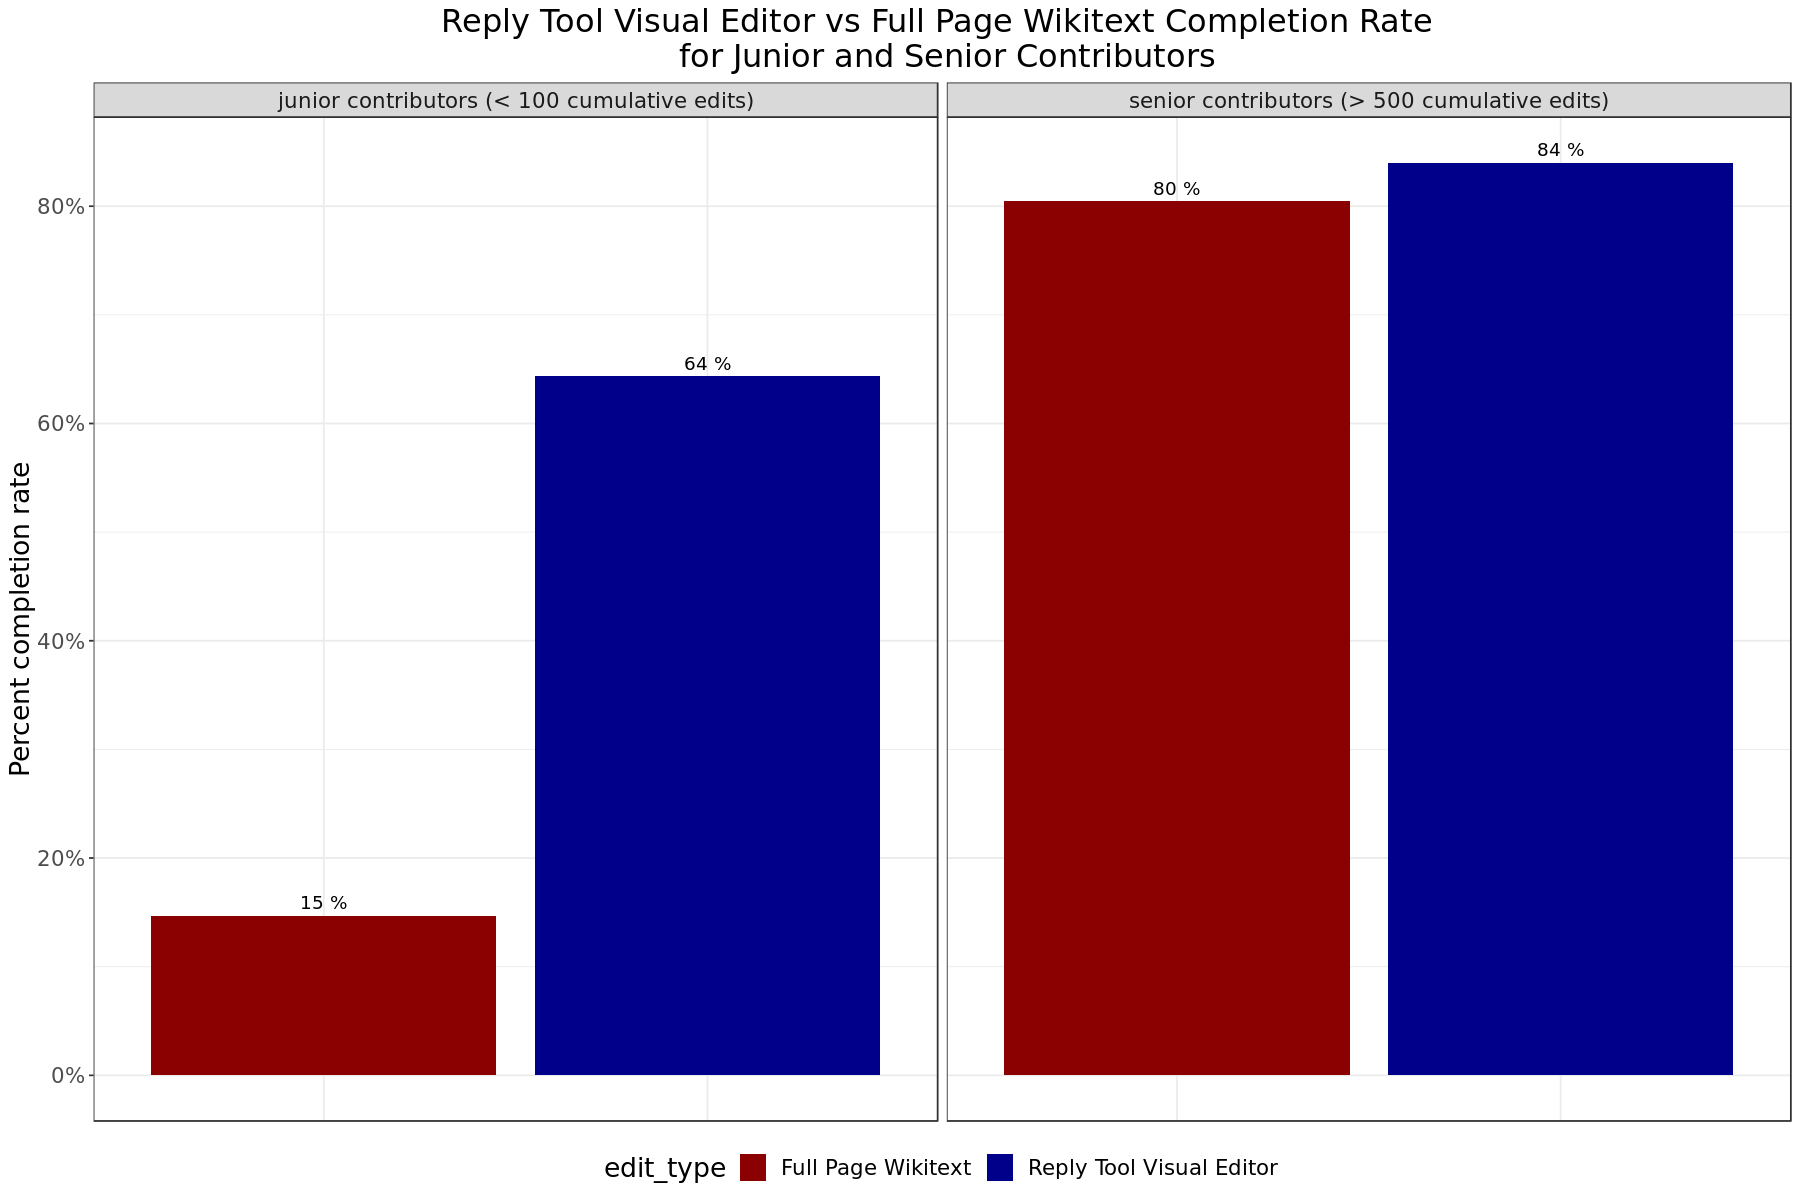

In [481]:
# plot comparison between full page and reply tool completion rates for junior and senior contributors

p <- edit_completion_rate_comparison_ve_junior_senior %>%
    gather("edit_type", "completion_rate", 2:3)  %>%
     ggplot(aes(x=edit_type, y= completion_rate, fill = edit_type)) +
        geom_bar(stat='identity', position = 'dodge') +
        facet_grid(~experience_level) +
        geom_text(aes(label = paste(round(completion_rate * 100), '%')), vjust = -0.5, position = position_dodge(width = 1)) +
        scale_y_continuous(labels = scales::percent) +
        labs (y = "Percent completion rate",
          x = "Experience level",
         title = "Reply Tool Visual Editor vs Full Page Wikitext Completion Rate \n for Junior and Senior Contributors")  +
         theme_bw() +
        scale_fill_manual(values = c('red4', 'darkblue'), labels = c('Full Page Wikitext', 'Reply Tool Visual Editor'))  +
         theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())
      
p

ggsave("Figures/reply_completion_rate_ve_comparison_junior_senior.png", p, width = 16, height = 8, units = "in", dpi = 300)

### Reply Tool Wikitext vs Full Page Wikitext

In [347]:
# reply tool wikitext completion rate
reply_tool_completion_rate_wikitext <- reply_tool_completion_rate_byeditcount %>%
    filter(editor_interface == 'wikitext') %>%
    rename(reply_tool_wikitext = pct_replytool_completion_rate) %>%
     select(-c(2,3)) %>%
    distinct()


In [ ]:
# join to show comparison between the two groups by edit count
edit_completion_rate_comparison_wikitext <- inner_join(full_talk_users_completion_rate_editcount, reply_tool_completion_rate_wikitext)


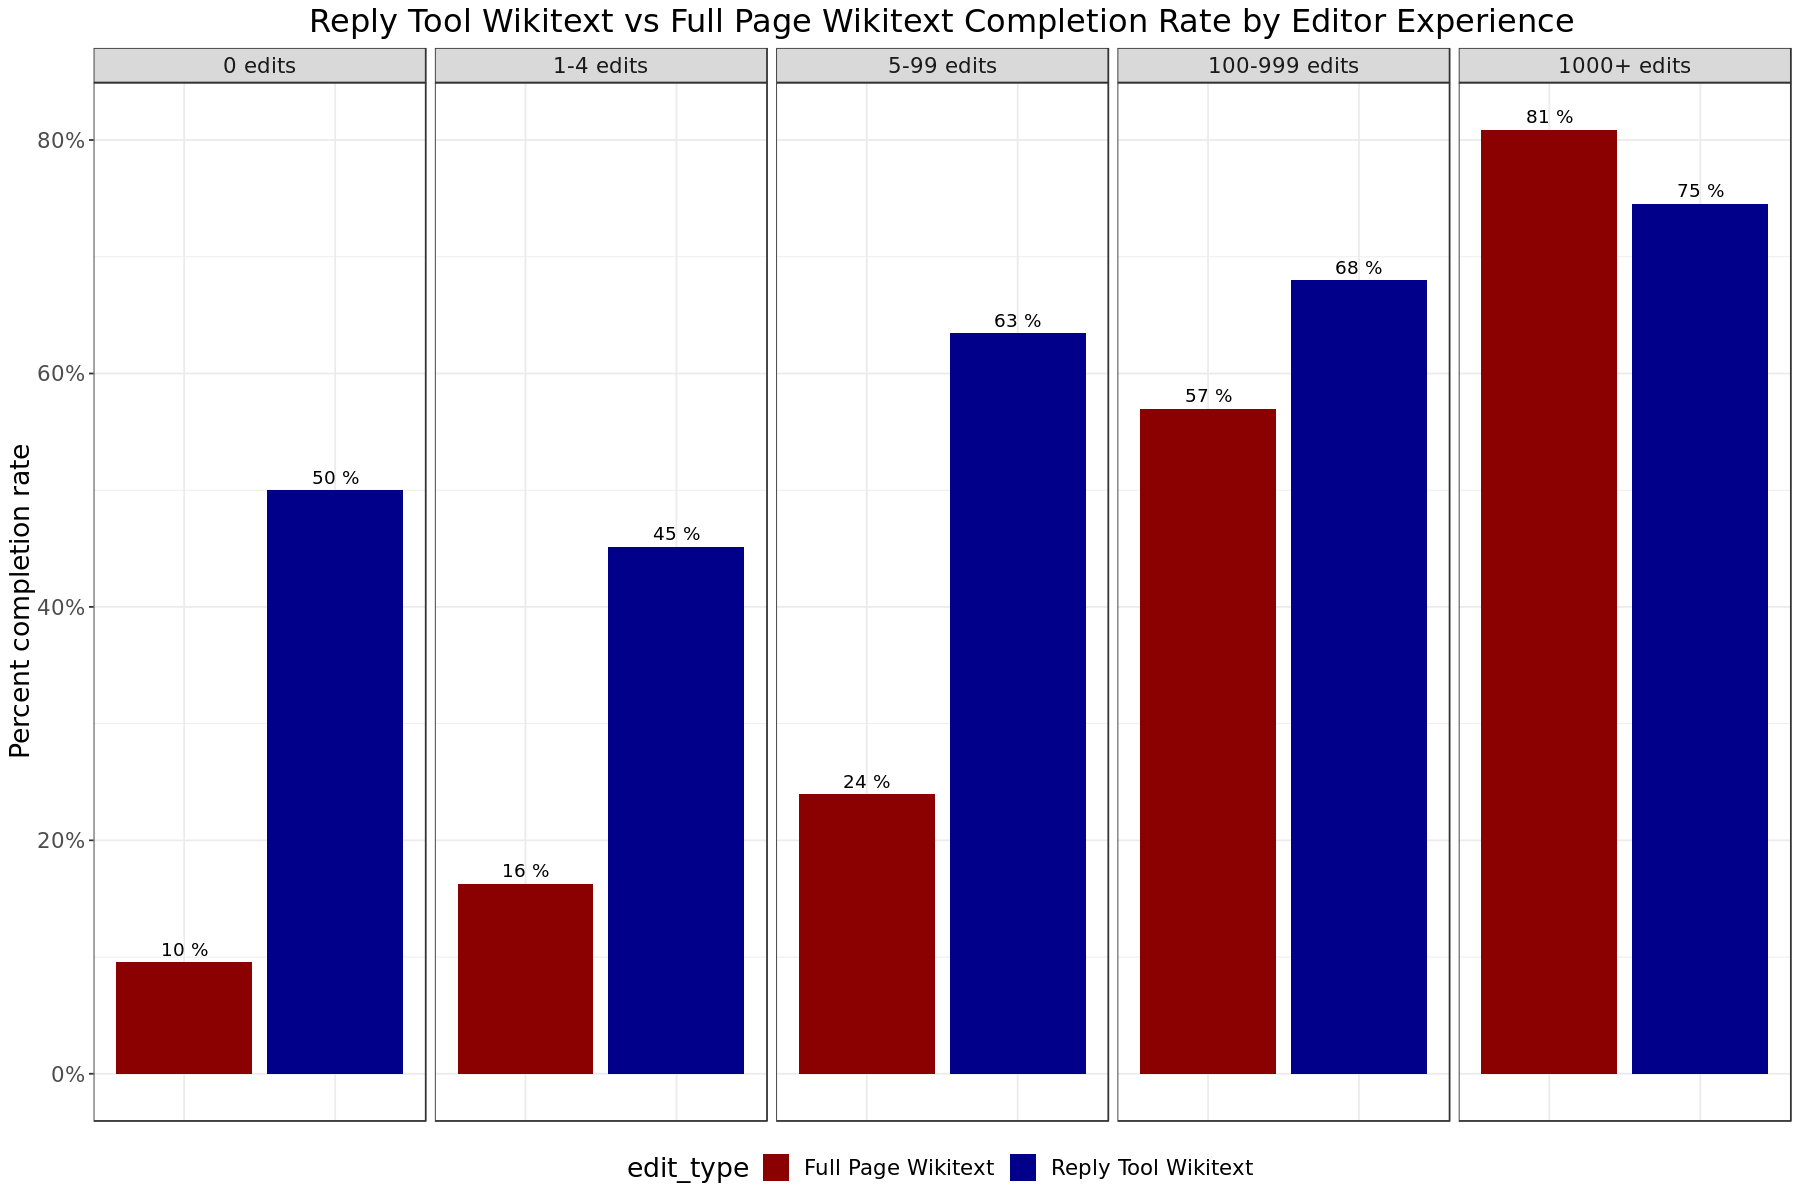

In [500]:
# plot comparison between full page and reply tool completion rates

p <- edit_completion_rate_comparison_wikitext %>%
    gather("edit_type", "completion_rate", 2:3)  %>%
     ggplot(aes(x=edit_type, y= completion_rate, fill = edit_type)) +
        geom_bar(stat='identity', position = 'dodge') +
        facet_grid(~edit_count_bucket) +
        geom_text(aes(label = paste(round(completion_rate * 100), '%')), vjust = -0.5, position = position_dodge(width = 1)) +
        scale_y_continuous(labels = scales::percent) +
        labs (y = "Percent completion rate",
          x = "Edit Count Bucket",
         title = "Reply Tool Wikitext vs Full Page Wikitext Completion Rate by Editor Experience")  +
         theme_bw() +
        scale_fill_manual(values = c('red4', 'darkblue'), labels = c('Full Page Wikitext', 'Reply Tool Wikitext'))  +
         theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
           legend.position="bottom",
        axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())
      
p

ggsave("Figures/reply_completion_rate_wikitext_comparison_editcount.png", p, width = 16, height = 8, units = "in", dpi = 300)

In [351]:
# reply tool wikitext completion rate - junior vs senior contributors
reply_tool_completion_rate_wikitext_junior_senior <- reply_tool_completion_rate_byexperience %>%
    filter(editor_interface == 'wikitext') %>%
    rename(reply_tool_wikitext = pct_replytool_completion_rate) %>%
     select(-2) 


In [ ]:
# join to show comparison between the two groups by junior and senior contributor groups
edit_completion_rate_comparison_wikitext_junior_senior <- inner_join(full_talk_users_completion_rate_experience, reply_tool_completion_rate_wikitext_junior_senior)


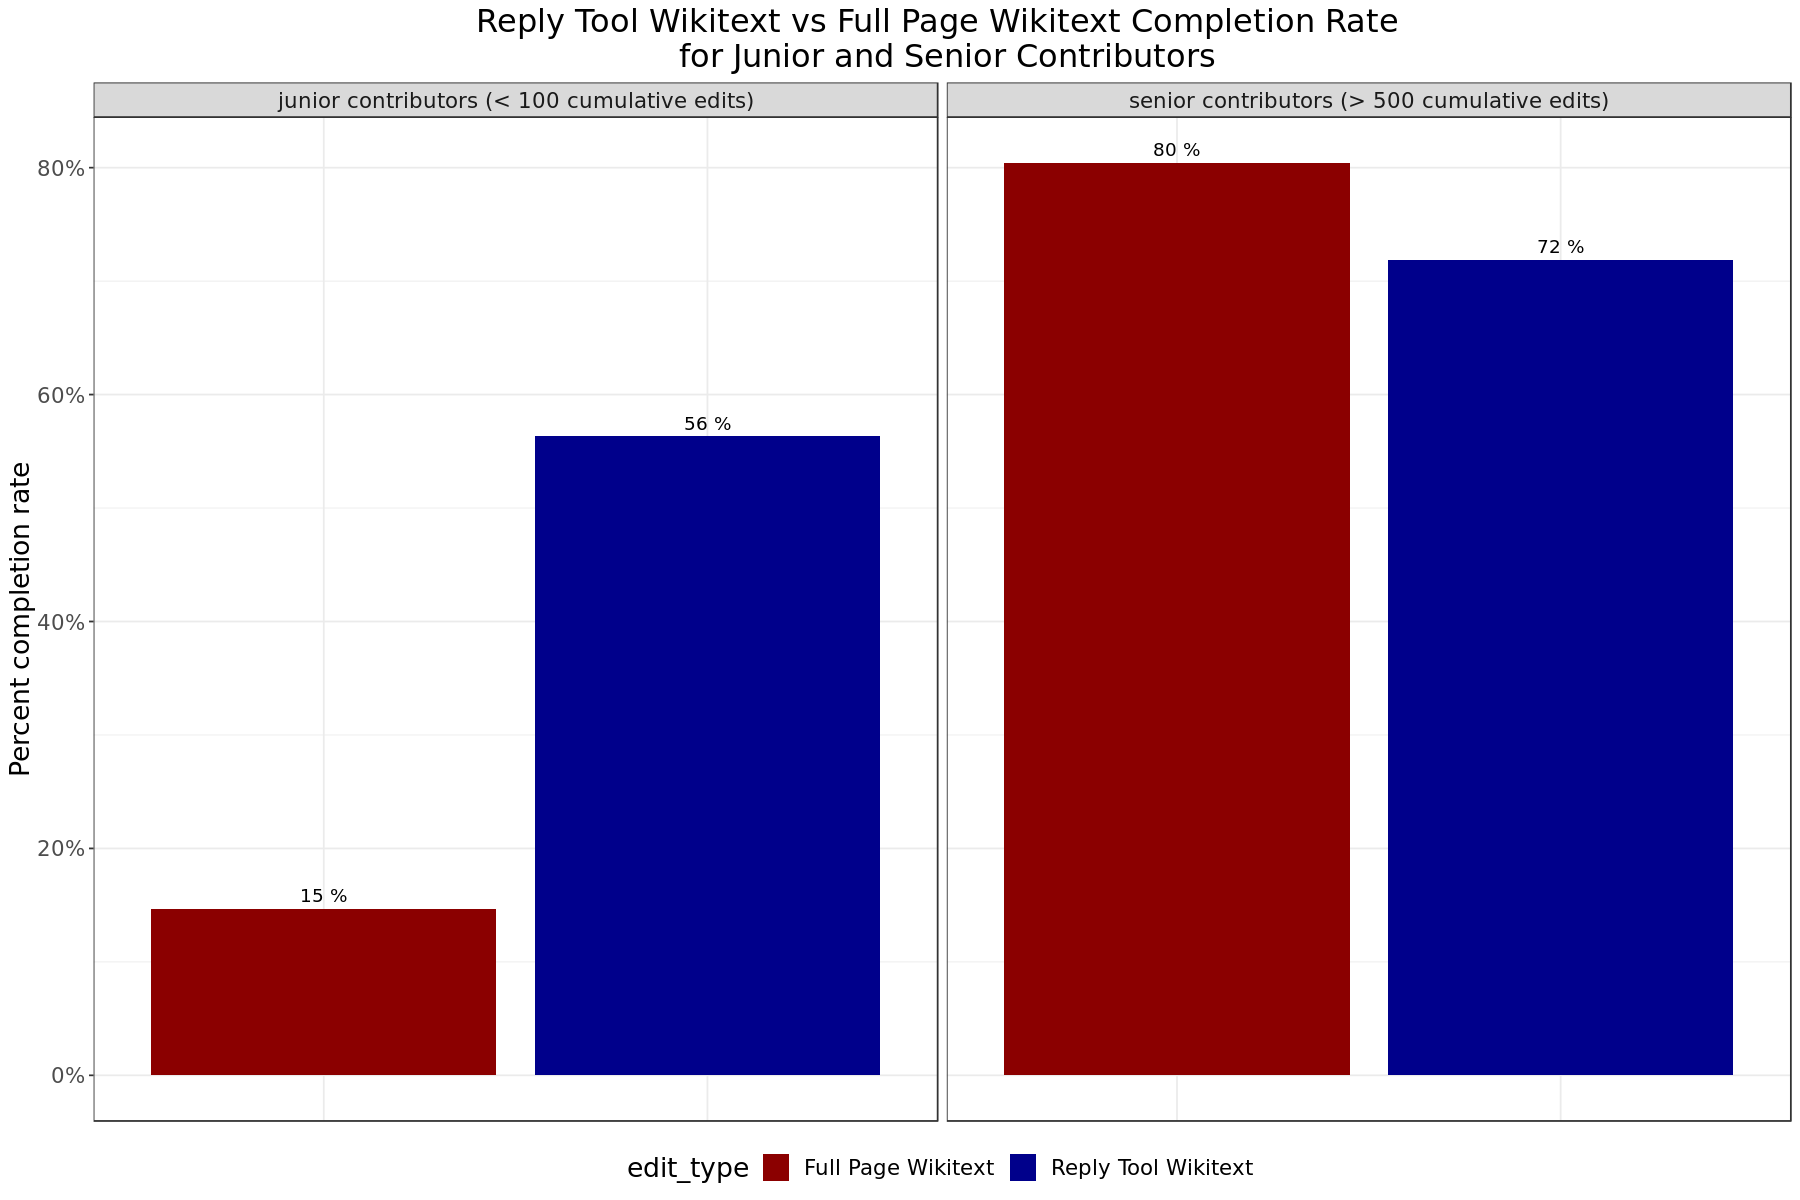

In [484]:
# plot comparison between full page and reply tool completion rates for junior and senior contributors

p <- edit_completion_rate_comparison_wikitext_junior_senior %>%
    gather("edit_type", "completion_rate", 2:3)  %>%
     ggplot(aes(x=edit_type, y= completion_rate, fill = edit_type)) +
        geom_bar(stat='identity', position = 'dodge') +
        facet_grid(~ experience_level) +
        geom_text(aes(label = paste(round(completion_rate * 100), '%')), vjust = -0.5, position = position_dodge(width = 1)) +
        scale_y_continuous(labels = scales::percent) +
        labs (y = "Percent completion rate",
          x = "Experience level",
         title = "Reply Tool Wikitext vs Full Page Wikitext Completion Rate \n for Junior and Senior Contributors")  +
         theme_bw() +
        scale_fill_manual(values = c('red4', 'darkblue'), labels = c('Full Page Wikitext', 'Reply Tool Wikitext'))  +
         theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())
      
p

ggsave("Figures/reply_completion_rate_wikitext_comparison_junior_senior.png.png", p, width = 16, height = 8, units = "in", dpi = 300)

Reply tool comments overall had significantly higher completion rates compared to full talk page wikitext edits for junior contributors (62% vs 15%).  Junior contributors had a lower edit completion rate with the reply tool using wikitext (56%) compared to visual editor (64%).

Completion rates are much more similar for senior contributors. Senior contributors with over 500 cumulative edits had 80%  completion rate when making full page wikitext edits compared a completion rate of 75% when using the reply tool. Senior contributors have a higher completion rate using wikitext on full page edits compared to reply tool edits while they have a slighty higher completion rate using VE on reply tool edits compared to full page edits.

# 2. Are people satisfied with the feature?

## People who publish at least one comment and turn off the Reply Tool preference (name: Enable quick replying) in Special:Preferences.

In [359]:
query <- "
--find users that opt out of the reply tool preference 
WITH opt_out_users AS (
SELECT
    event.userid as opt_out_user,
    wiki as opt_out_wiki,
    min(event.saveTimestamp) as opt_out_time,
    sum(cast(event.value = '\"0\"' as int)) as opt_outs
FROM 
    event.prefupdate
WHERE
    event.property = 'discussiontools-betaenable' AND
    wiki IN ('arwiki', 'cswiki', 'huwiki') AND
    event.value = '\"0\"' AND
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) >= '2020-09-24' AND
    CONCAT(year, '-', LPAD(month, 2, '0'), '-', LPAD(day, 2, '0')) < '2020-12-01'
GROUP BY 
    event.userid, 
    wiki
),
-- find users that made at least one edit with the reply tool
reply_users AS (
SELECT
    event_user_id as reply_user,
    wiki_db as reply_wiki,
    min(mh.event_timestamp) as first_reply_time
FROM wmf.mediawiki_history AS mh
WHERE 
    ARRAY_CONTAINS(revision_tags, 'discussiontools') AND
    snapshot = '2020-12' AND
    event_timestamp >= '2020-09-24' AND 
    event_timestamp <= '2020-12-08' AND
    wiki_db IN ('arwiki','cswiki', 'huwiki') AND 
    SIZE(event_user_is_bot_by_historical) = 0 AND
    SIZE(event_user_is_bot_by) = 0 AND
    event_entity = 'revision' AND 
    event_type = 'create' AND
    event_user_id IS NOT NULL
GROUP BY
    event_user_id,
    wiki_db
)

-- Main Query --
SELECT
    reply_wiki AS wiki,
    opt_out_time,
    SUM(CAST(opt_out_user IS NOT NULL and first_reply_time < opt_out_time AS int)) AS opt_out_users,
    COUNT(*) AS all_reply_tool_users

FROM (
SELECT
    reply_users.reply_user,
    reply_users.reply_wiki,
    reply_users.first_reply_time,
    opt_out_users.opt_out_time,
    opt_out_users.opt_out_wiki,
    opt_out_users.opt_out_user
FROM reply_users
LEFT JOIN opt_out_users ON 
    reply_users.reply_user = opt_out_users.opt_out_user AND
    reply_users.reply_wiki = opt_out_users.opt_out_wiki 
WHERE 
--limit to users that opt'd out and stayed opt'd out
    opt_out_users.opt_outs = 1 
) sessions
GROUP BY
    sessions.reply_wiki,
    sessions.opt_out_time
"


In [ ]:
opt_out_after_reply <- wmfdata::query_hive(query)

According to data available in [PrefUpdate](https://meta.wikimedia.org/wiki/Schema:PrefUpdate), there has only been one user across all three op-out wikis (on Hungarian Wikipedia) that has turned off the Reply Tool preference in Special:Preferences after making a comment using the reply tool during the reviewed time period (24 September 2020 through 08 December 2020)

## Distribution of reply tool users by number of comments posted

We reviewed the distribution of reply tool users by the number of comments posted. We looked at users that made just 1 comment and those that made comments within identified buckets (e.g. " E.g. "1-5 edits," "6-10 edits," etc.)

- Data comes from [mediawiki_history](https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Edits/MediaWiki_history) using the change tag implemented in [T242184](https://phabricator.wikimedia.org/T242184). 
- We reviewed all edits made with the discussiontools tag. These include all users who were able to successfully make an edit using the reply tool. It does not include attempts with the tool that were not saved. 
- Any self-identified bots were filtered out from the data; however, some un-identified bots might still be included.

In [362]:
# Collect users max reply edits during opt-out time

query <- "

SELECT
    wiki,
    reply_user,
    min(edit_count_bucket) AS edit_count_bucket,
    min(experience_level) AS experience_level,
    max(reply_edits) AS reply_edit_count
FROM (
    SELECT
        wiki_db AS wiki,
        event_user_id as reply_user,
        CASE
            WHEN min(event_user_revision_count) is NULL THEN 'undefined'
            WHEN min(event_user_revision_count) = 0 THEN '0 edits'
            WHEN (min(event_user_revision_count) >=1 AND min(event_user_revision_count) < 5) THEN '1-4 edits'
            WHEN (min(event_user_revision_count) >=5 AND min(event_user_revision_count) < 100) THEN '5-99 edits'
            WHEN (min(event_user_revision_count) >=100 AND min(event_user_revision_count) < 1000) THEN '100-999 edits'
            ELSE '1000+ edits'
            END AS edit_count_bucket,
        CASE
            WHEN min(event_user_revision_count) < 100 THEN 'junior contributors (< 100 cumulative edits)' 
            WHEN min(event_user_revision_count) > 500 THEN 'senior contributors (> 500 cumulative edits)'
            ELSE 'NA'
            END AS experience_level,
        max(size(event_user_is_bot_by) > 0 or size(event_user_is_bot_by_historical) > 0) as bot_by_group,
        Count(*) as reply_edits
FROM wmf.mediawiki_history
WHERE 
    ARRAY_CONTAINS(revision_tags, 'discussiontools') AND
    snapshot = '2020-12' AND
    event_timestamp >= '2020-09-24' AND
    event_timestamp <= '2020-12-08' AND
    wiki_db IN ('arwiki','cswiki', 'huwiki') AND
    event_entity = 'revision' AND
    event_type = 'create' AND
-- remove anonymous users
    event_user_id IS NOT NULL
GROUP BY
    wiki_db,
    event_user_id  
) edits
WHERE not bot_by_group
GROUP BY 
    reply_user, 
    wiki"

In [ ]:
collect_reply_tool_users <- wmfdata::query_hive(query)

In [364]:
# Order edit counts
collect_reply_tool_users$edit_count_bucket %<>% 
    factor(levels= c("0 edits", "1-4 edits", "5-99 edits", "100-999 edits", "1000+ edits"))

### Percent of users that made only 1 comment with the reply tool by Wiki

In [501]:
# Find overall percent of users that made only 1 edit
reply_edits_overall_1edit <- collect_reply_tool_users %>%
    group_by(wiki) %>%
    mutate(total_wiki_user_count = n()) %>%
    filter(reply_edit_count == 1)  %>%
    group_by(wiki) %>%
    summarise(percent_users_1comments = n()/total_wiki_user_count *100, .groups = 'drop') %>%
    distinct()

reply_edits_overall_1edit

wiki   percent_users_1comments
1 arwiki 55.58583               
2 cswiki 51.74825               
3 huwiki 47.71242

Roughly half of all reply tool users only made 1 comment using the reply tool on each of the opt-out wikis during the reviewed time period (24 September 2020 through 08 December 2020). Arabic Wipedia had the highest percent of users that only made 1 comment (55.6%) while Czech Wikipedia had the lowest (47.7%).

### Percent of users that made only 1 edit with the reply tool by Wiki and Experience Level

In [366]:
# Find overall number of users that made only 1 edit by edit count
reply_edits_1edit_bywiki_editcount <- collect_reply_tool_users %>%
    group_by(wiki) %>%
    mutate(total_wiki_user_count = n()) %>%
    filter(reply_edit_count == 1)  %>%
    group_by(wiki, edit_count_bucket) %>%
    summarise(percent_users = n()/total_wiki_user_count, .groups = 'drop') %>%
    distinct()


In [506]:
# set plot colors
cbp1 <- c("#999999", "#E69F00", "#56B4E9")

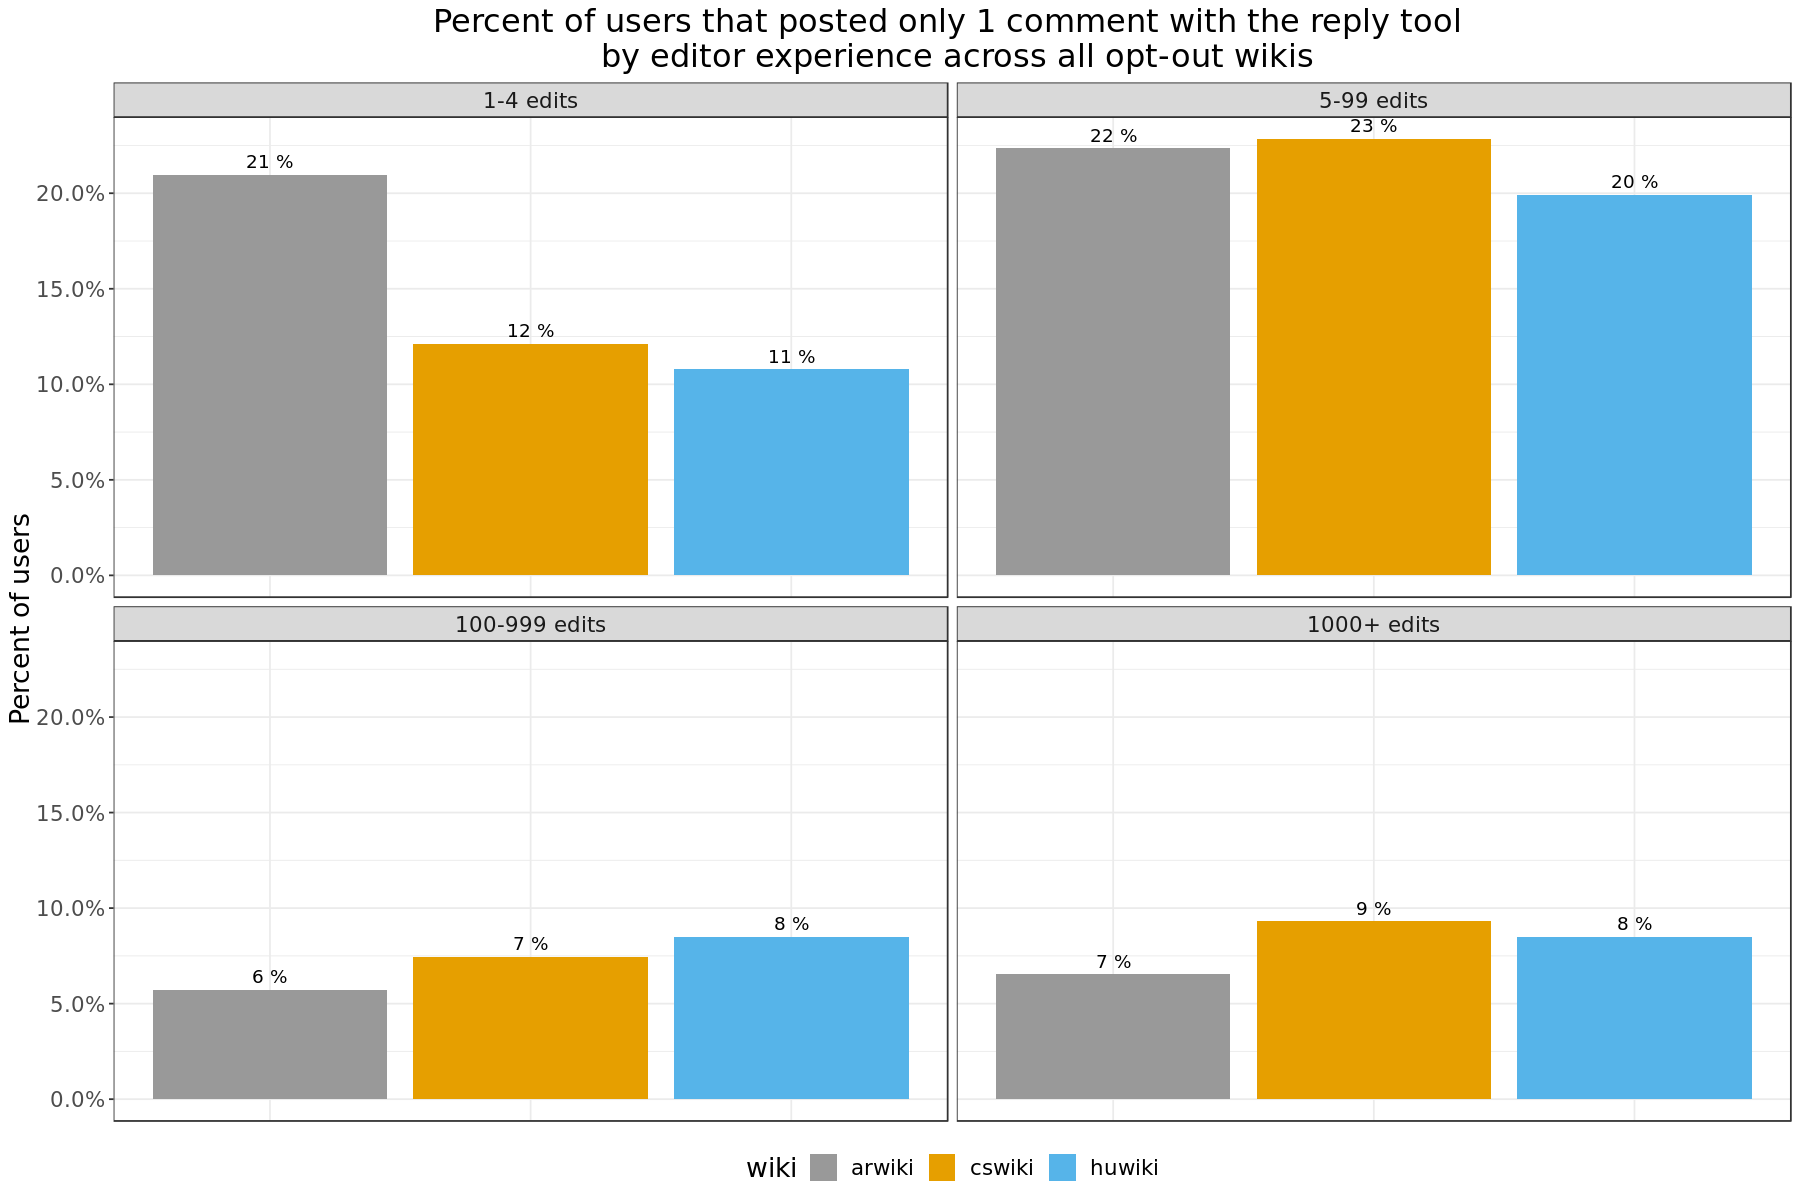

In [507]:
# plot 1 edit completion rates by editor experience

p <- reply_edits_1edit_bywiki_editcount %>%
        ggplot(aes(x=wiki, y= percent_users, fill = wiki)) +
        facet_wrap(~edit_count_bucket) +
        geom_bar(stat='identity', position = 'dodge') +
        geom_text(aes(label = paste(round(percent_users * 100), '%')), vjust = -0.5, position = position_dodge(width = 1)) +
        scale_y_continuous(labels = scales::percent) +
        labs (y = "Percent of users",
          x = "Edit Count Bucket",
         title = "Percent of users that posted only 1 comment with the reply tool \n by editor experience across all opt-out wikis")  +
         theme_bw() +
         scale_fill_manual(values = cbp1)  +
         theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())
      
p

ggsave("Figures/one_comment_users_overall_editcount.png", p, width = 16, height = 8, units = "in", dpi = 300)

In [368]:
# Find overall number of users that made only 1 edit by junior and senior contributors
reply_edits_1edit_bywiki_experience <- collect_reply_tool_users %>%
    group_by(wiki) %>%
    filter(experience_level != 'NA') %>%
    mutate(total_wiki_user_count = n()) %>%
    filter(reply_edit_count == 1)  %>%
    group_by(wiki, experience_level) %>%
    summarise(percent_users = n()/total_wiki_user_count, .groups = 'drop') %>%
    distinct()


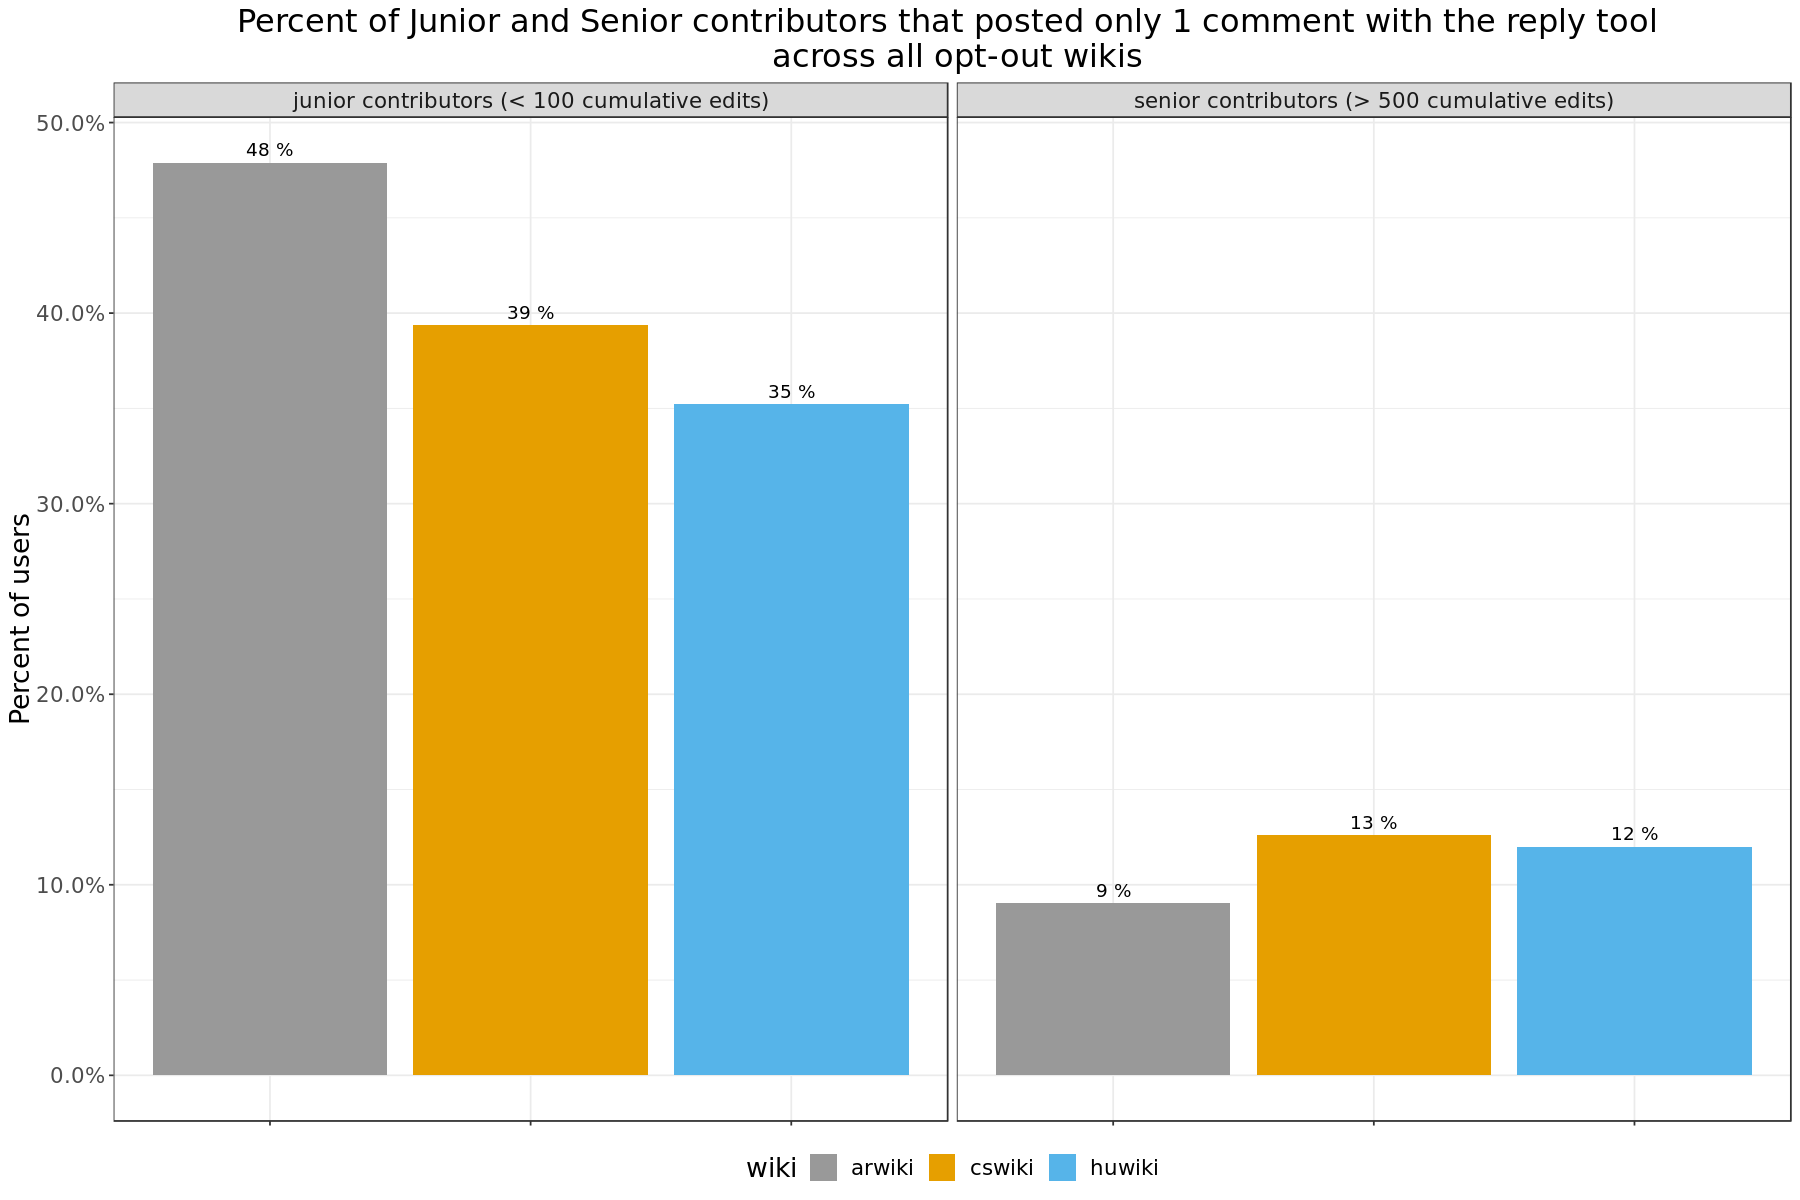

In [508]:

p <- reply_edits_1edit_bywiki_experience %>%
        ggplot(aes(x=wiki, y= percent_users, fill = wiki)) +
        facet_wrap(~experience_level) +
        geom_bar(stat='identity', position = 'dodge') +
        geom_text(aes(label = paste(round(percent_users * 100), '%')), vjust = -0.5, position = position_dodge(width = 1)) +
        scale_y_continuous(labels = scales::percent) +
        labs (y = "Percent of users",
          x = "Edit Count Bucket",
         title = "Percent of Junior and Senior contributors that posted only 1 comment with the reply tool \n across all opt-out wikis")  +
         theme_bw() +
         scale_fill_manual(values = cbp1)  +
         theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position = 'bottom',
        axis.title.x = element_blank(),
        axis.text.x=element_blank()
        ) 
      
p

ggsave("Figures/one_comment_users_overall_experience.png", p, width = 16, height = 8, units = "in", dpi = 300)



The chart above breaks down those overall percentages by editor experience for each wiki. The majority of users that made 1 comment are junior contributors with under 100 cumulative edits.  On Arabic Wikipedia, almost half (48%) of users that made just 1 comment were junior contributors.

Under 15% of senior contributors with over 500 cumulative edits made only 1 comment. 

## Distribution of Users by Number of Reply Tool Edits 

In [372]:
#Divide reply edits int0 edit count groups with bin width set to 5 edits
b <- c(0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, Inf)
names <- c('1-5 comments', '6-10 comments', '11-15 comments', '16-20 comments', '21-25 comments', '26-30 comments', '31-35 comments',
         '36-40 comments', '41-45 comments', '46-50 comments', 'over 50 comments')

reply_edits_byeditgroup <- collect_reply_tool_users %>%
    mutate(num_reply_comments = cut(reply_edit_count, breaks = b, labels = names)) 

### Overall by Wiki

In [ ]:
 reply_edits_byeditgroup_overall <- reply_edits_byeditgroup %>%
    group_by(wiki, num_reply_comments) %>%
     summarise(n_users = n()) %>%
    mutate(percent_reply_users = n_users/sum(n_users))

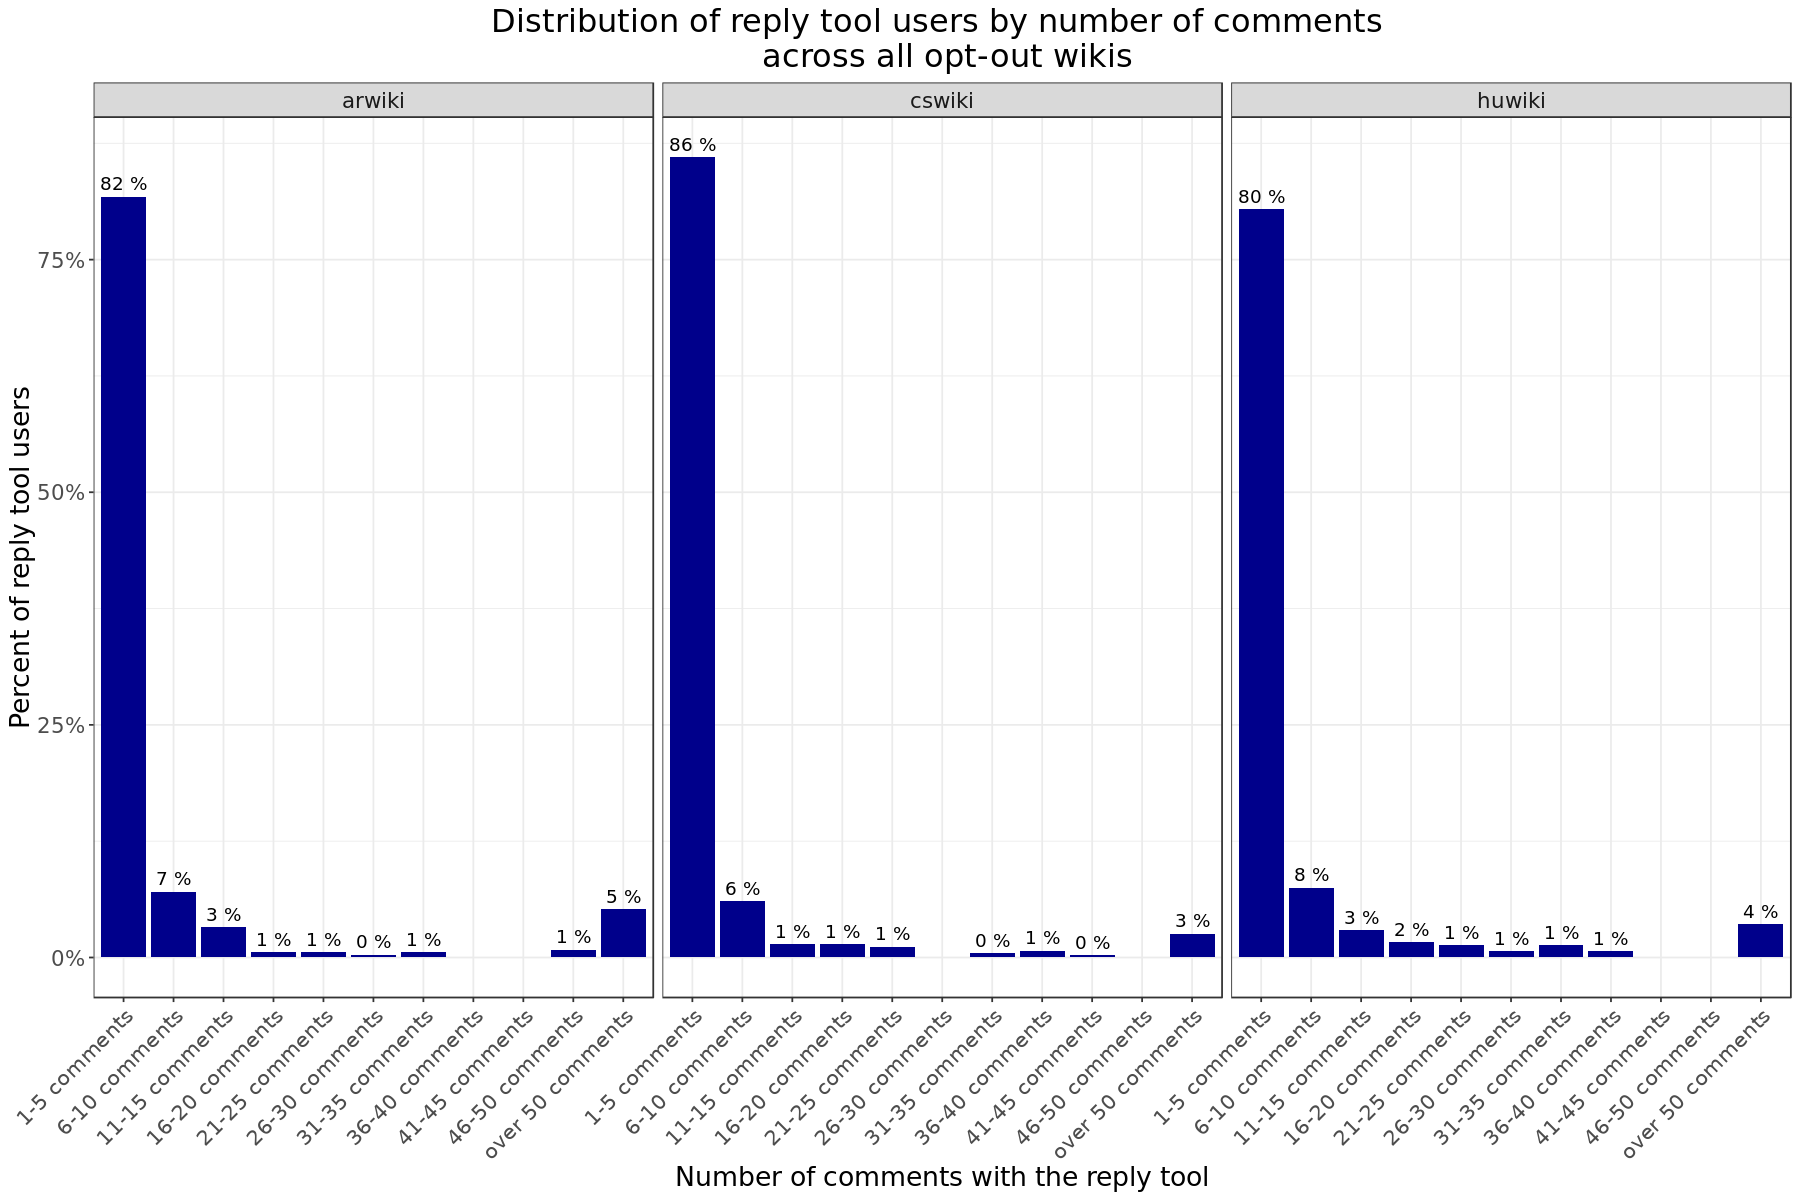

In [374]:
p <-  reply_edits_byeditgroup_overall %>%
    ggplot(aes(x=num_reply_comments, y = percent_reply_users)) +
    geom_bar(stat = 'identity', fill = 'darkblue') +
    geom_text(aes(label = paste(round(percent_reply_users * 100), '%')), vjust = -0.5, position = position_dodge(width = 1)) +
    scale_y_continuous(labels = scales::percent) +
    facet_grid(~wiki) +
    labs (y = "Percent of reply tool users",
          x = "Number of comments with the reply tool",
         title = "Distribution of reply tool users by number of comments \n across all opt-out wikis")  +
     theme_bw() +
   theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)) 
        
p

ggsave("Figures/reply_users_by_numcomments.png", p, width = 16, height = 8, units = "in", dpi = 300)

The distribution of reply tool users by the number of comments is similar across all three opt-out wikis.
Over 80% of reply tool users on each of the three opt-out wikis made between 1 to 5 comments. Hungarian Wikipedia had the highest percentage of users (20%) that made over 5 comments using the reply tool.

Based on the number of 1 comment users provided earlier, about 30% of reply users in each wiki made between 2 to 5 comments.


### By Wiki and Editor Experience

In [ ]:
 # by edit count
reply_edits_byeditgroup_bywiki <- reply_edits_byeditgroup %>%
    group_by(wiki, edit_count_bucket, num_reply_comments) %>%
     summarise(n_users = n()) %>%
    mutate(percent_reply_users = n_users/sum(n_users))


In [ ]:
# by junior and senior contributors
reply_edits_byexperience_bywiki <- reply_edits_byeditgroup %>%
    group_by(wiki, experience_level, num_reply_comments) %>%
     summarise(n_users = n()) %>%
    mutate(percent_reply_users = n_users/sum(n_users))

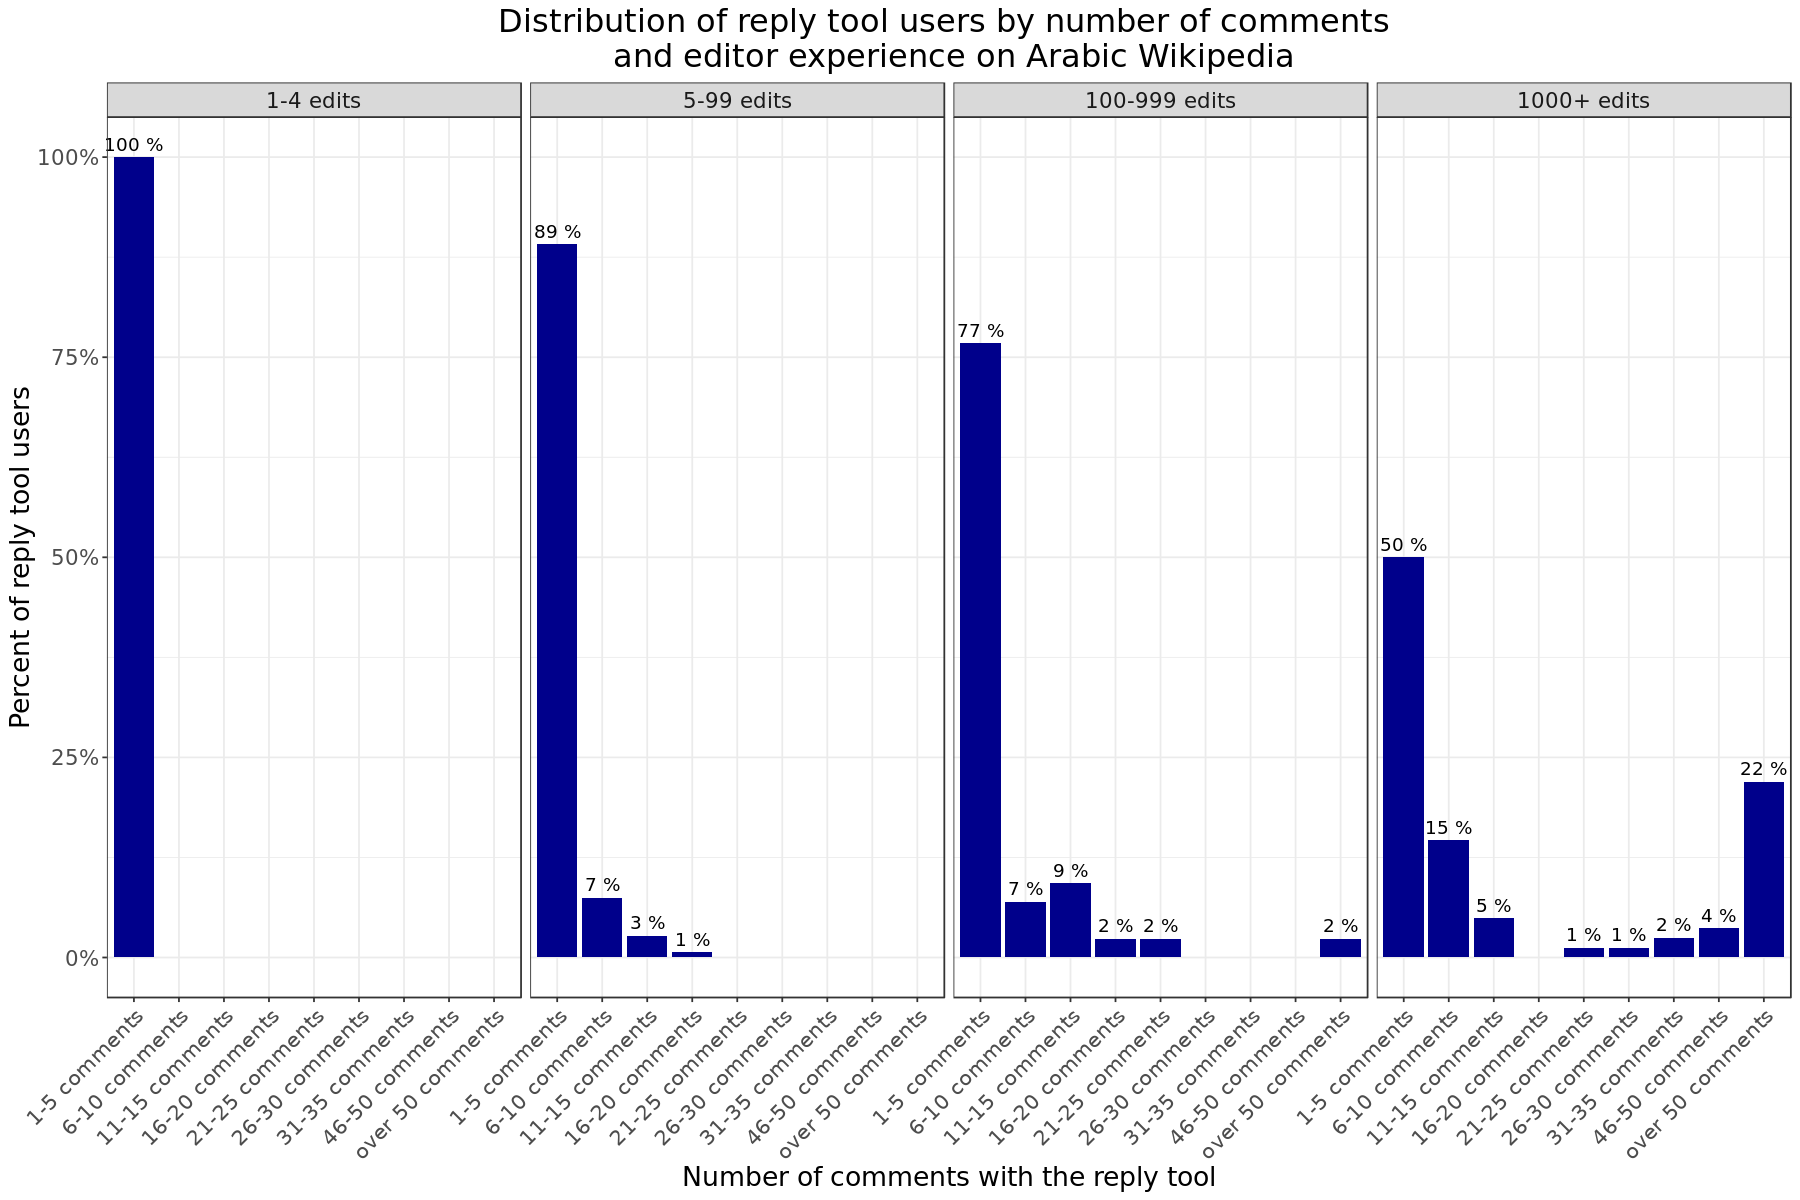

In [383]:
p <-  reply_edits_byeditgroup_bywiki %>%
    filter(wiki == 'arwiki') %>%
    ggplot(aes(x=num_reply_comments, y = percent_reply_users)) +
    facet_grid(~edit_count_bucket) +
    geom_bar(stat = 'identity', fill = 'darkblue') +
    geom_text(aes(label = paste(round(percent_reply_users * 100), '%')), vjust = -0.5, position = position_dodge(width = 1)) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of reply tool users",
          x = "Number of comments with the reply tool",
         title = "Distribution of reply tool users by number of comments \n and editor experience on Arabic Wikipedia")  +
     theme_bw() +
   theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)) 
        
p

ggsave("Figures/reply_users_by_numcomments_arwiki_editcount.png", p, width = 16, height = 8, units = "in", dpi = 300)

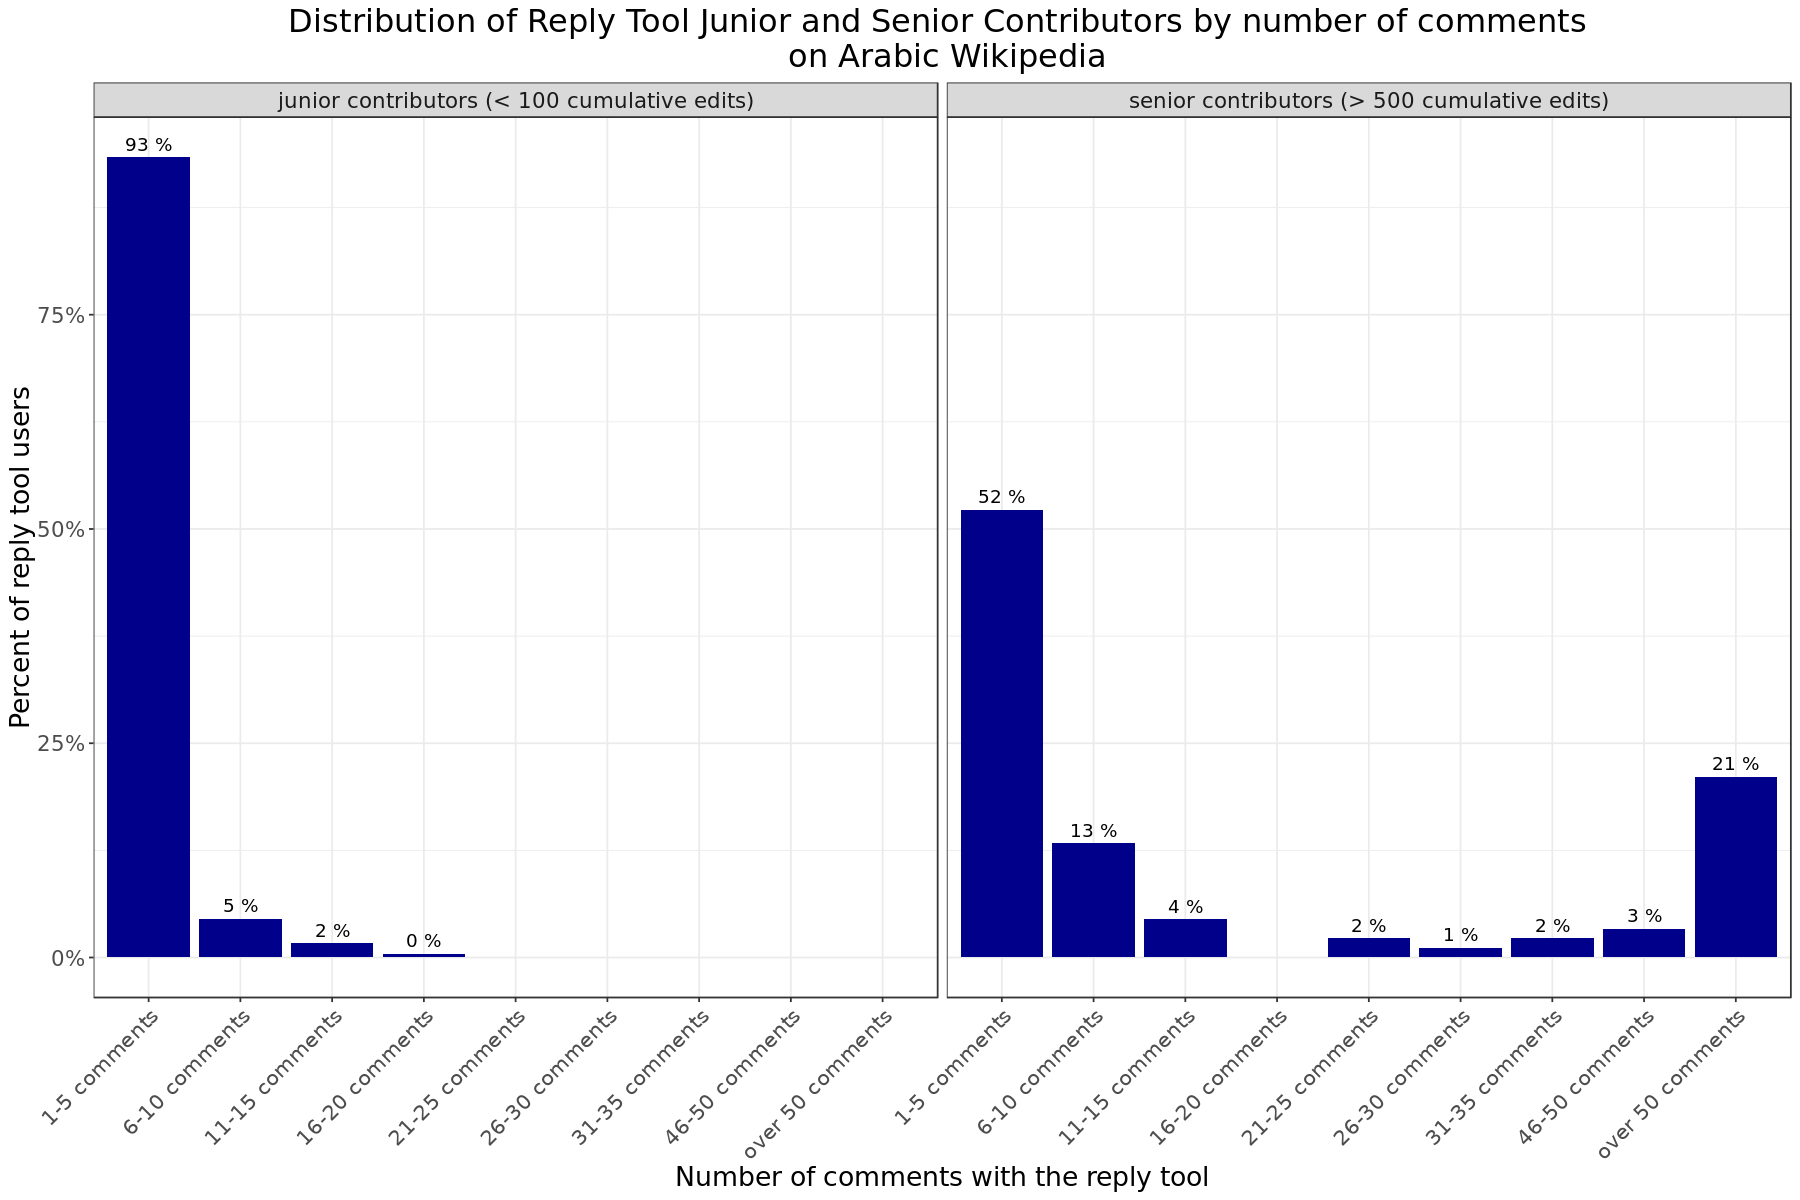

In [378]:
# by senior and junior contributors

p <-  reply_edits_byexperience_bywiki %>%
    filter(wiki == 'arwiki',
            experience_level != 'NA') %>%
    ggplot(aes(x=num_reply_comments, y = percent_reply_users)) +
    facet_grid(~experience_level) +
    geom_bar(stat = 'identity', fill = 'darkblue') +
    geom_text(aes(label = paste(round(percent_reply_users * 100), '%')), vjust = -0.5, position = position_dodge(width = 1)) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of reply tool users",
          x = "Number of comments with the reply tool",
         title = "Distribution of Reply Tool Junior and Senior Contributors by number of comments \n on Arabic Wikipedia")  +
     theme_bw() +
   theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)) 
        
p

ggsave("Figures/reply_users_by_numcomments_arwiki_experience.png", p, width = 16, height = 8, units = "in", dpi = 300)

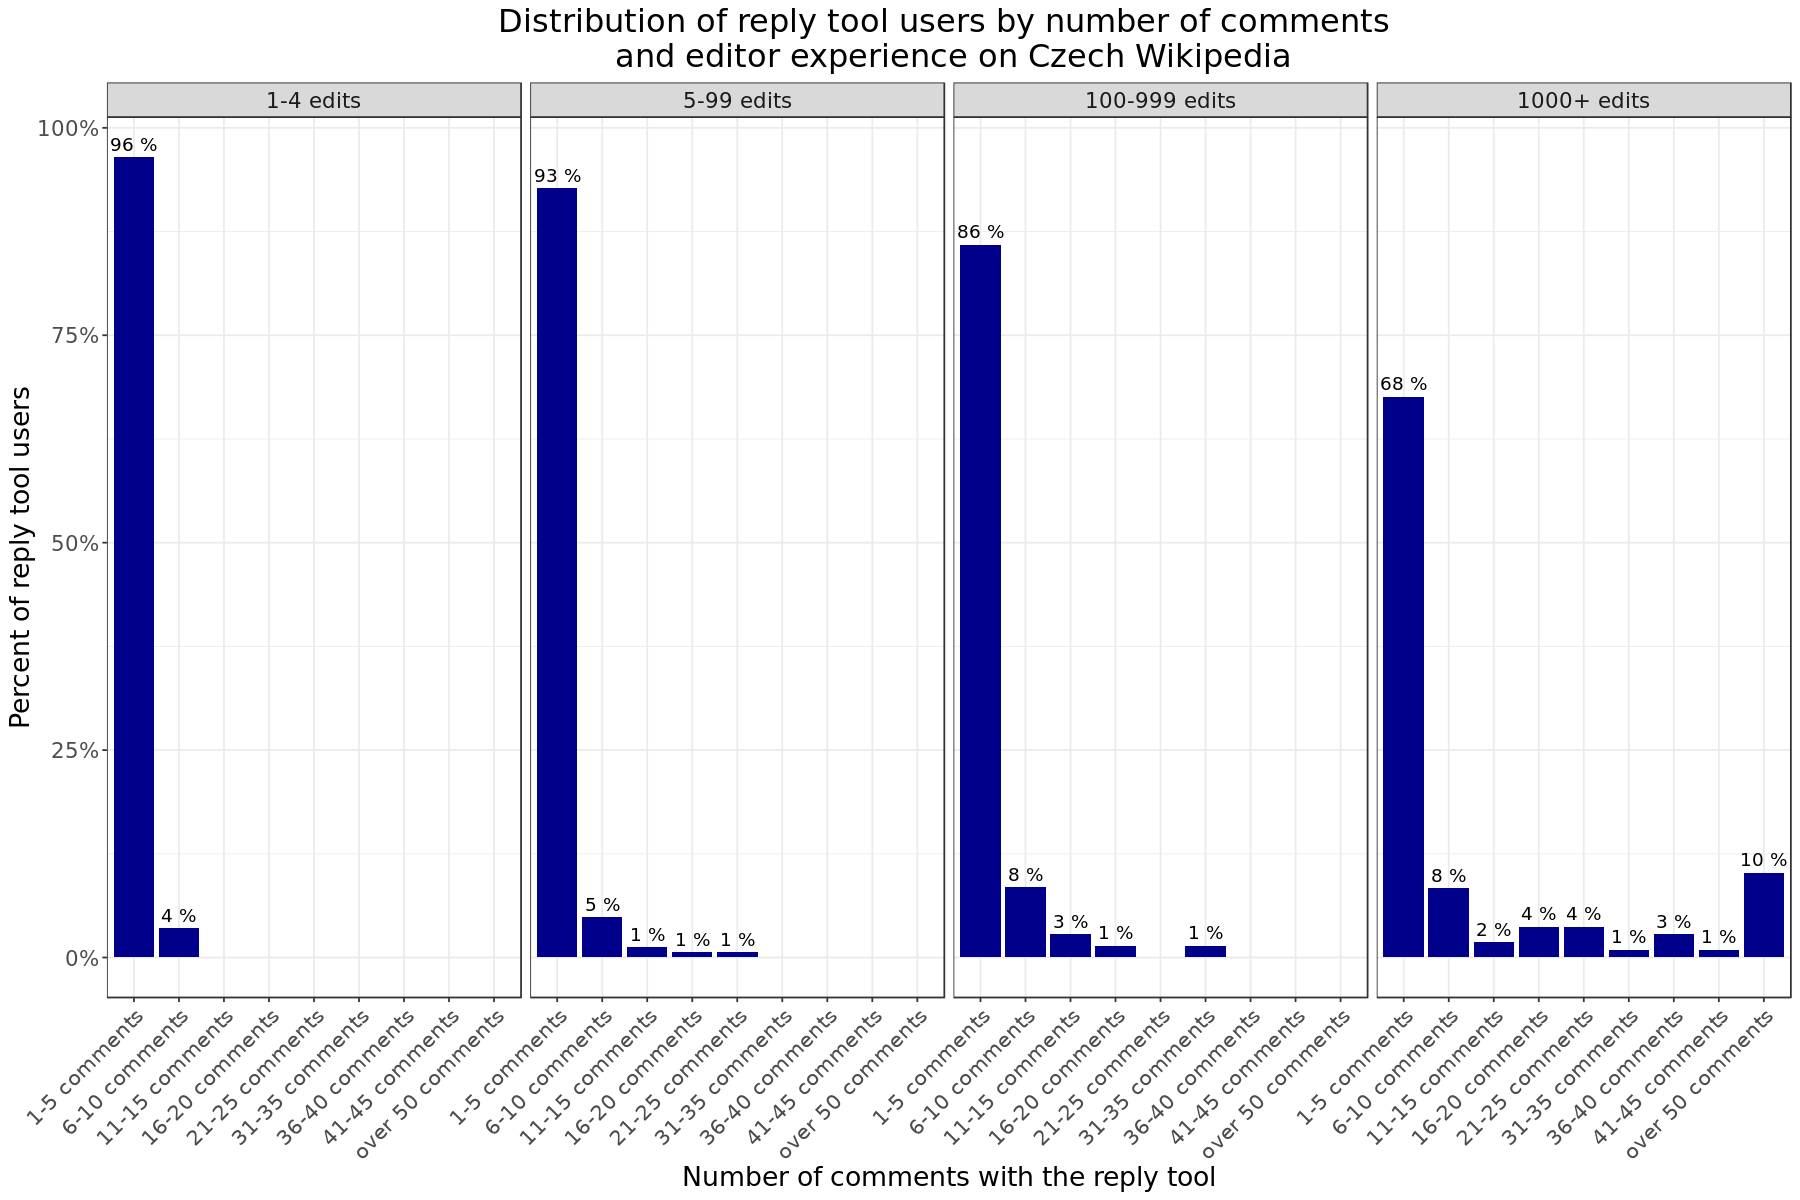

In [379]:
p <-  reply_edits_byeditgroup_bywiki %>%
    filter(wiki == 'cswiki') %>%
    ggplot(aes(x=num_reply_comments, y = percent_reply_users)) +
    facet_grid(~edit_count_bucket) +
    geom_bar(stat = 'identity', fill = 'darkblue') +
    geom_text(aes(label = paste(round(percent_reply_users * 100), '%')), vjust = -0.5, position = position_dodge(width = 1)) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of reply tool users",
          x = "Number of comments with the reply tool",
         title = "Distribution of reply tool users by number of comments \n and editor experience on Czech Wikipedia")  +
     theme_bw() +
   theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)) 
        
p

ggsave("Figures/reply_users_by_numcomments_cswiki_editcount.png", p, width = 16, height = 8, units = "in", dpi = 300)

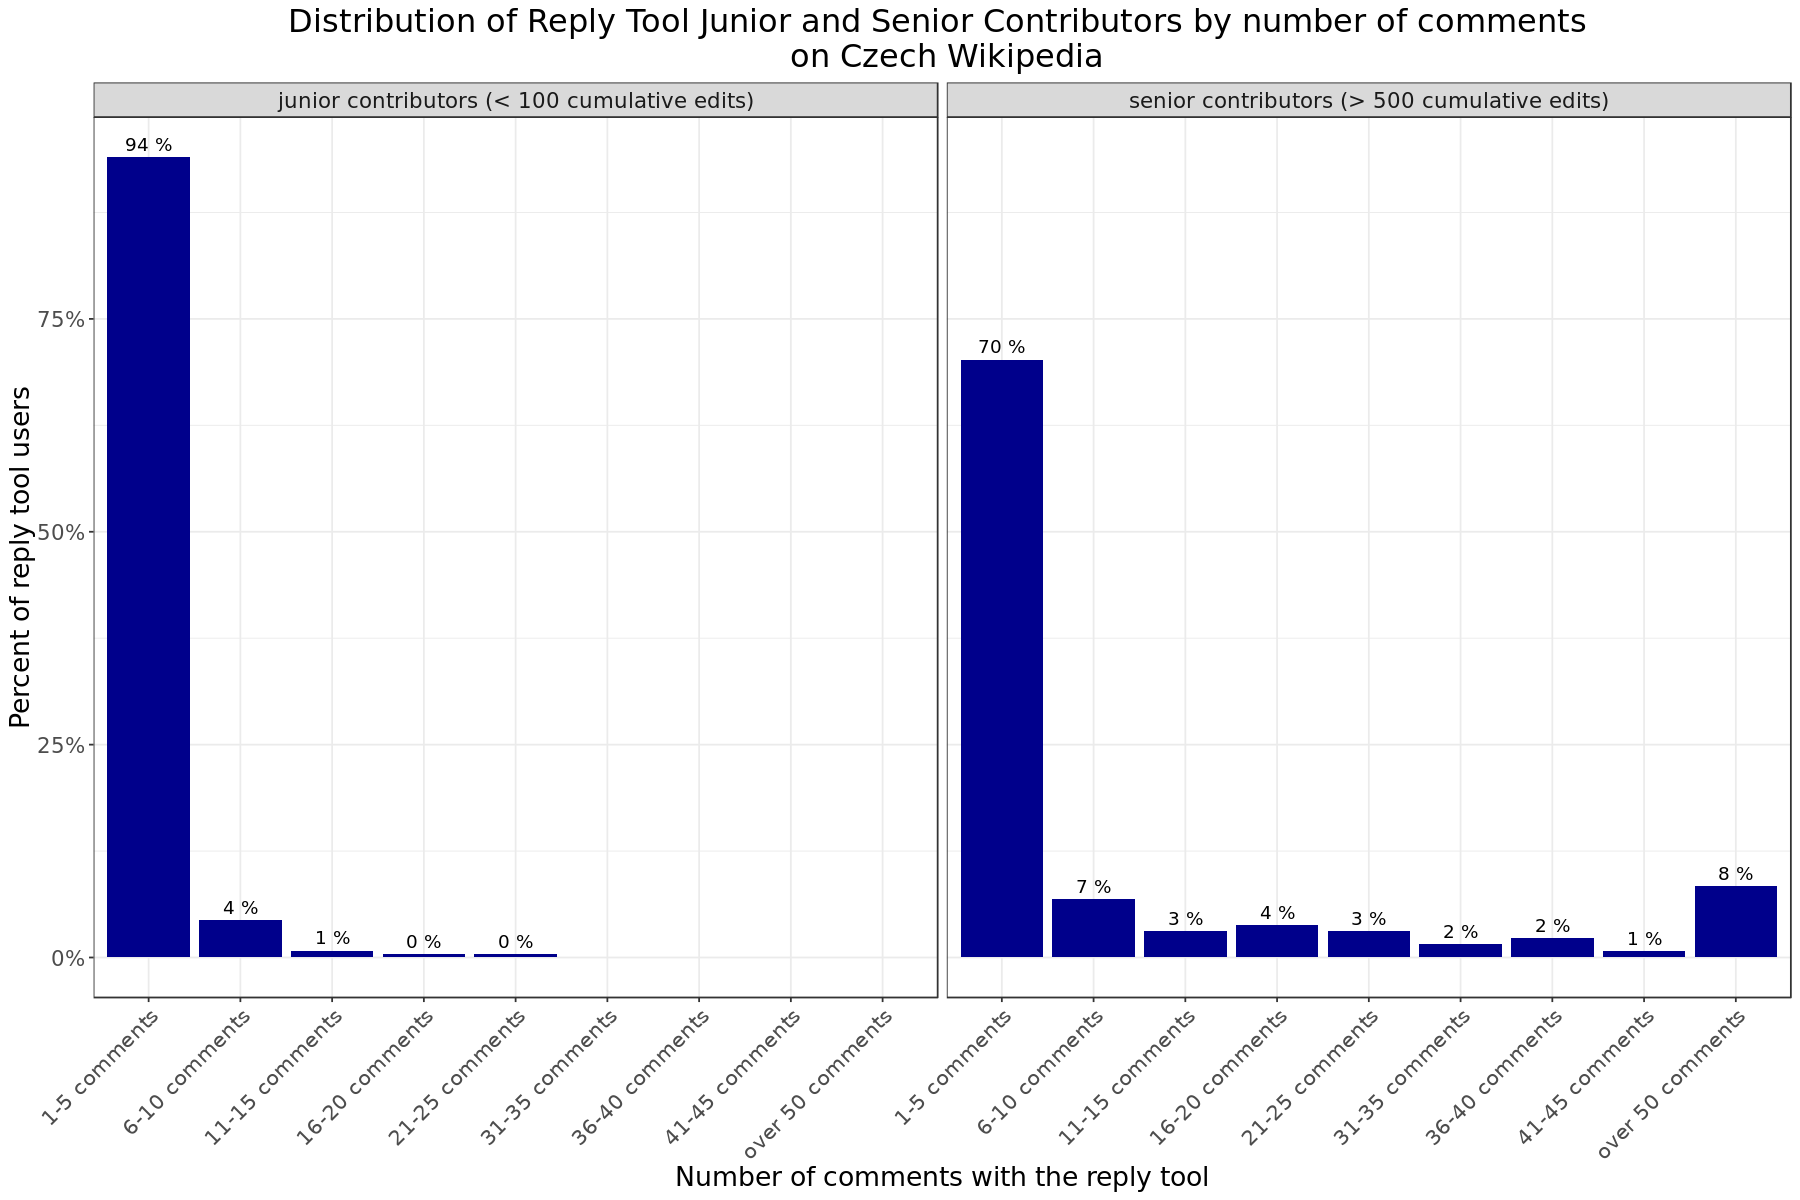

In [380]:
# by senior and junior contributors

p <-  reply_edits_byexperience_bywiki %>%
    filter(wiki == 'cswiki',
            experience_level != 'NA') %>%
    ggplot(aes(x=num_reply_comments, y = percent_reply_users)) +
    facet_grid(~experience_level) +
    geom_bar(stat = 'identity', fill = 'darkblue') +
    geom_text(aes(label = paste(round(percent_reply_users * 100), '%')), vjust = -0.5, position = position_dodge(width = 1)) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of reply tool users",
          x = "Number of comments with the reply tool",
         title = "Distribution of Reply Tool Junior and Senior Contributors by number of comments \n on Czech Wikipedia")  +
     theme_bw() +
   theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)) 
        
p

ggsave("Figures/reply_users_by_numcomments_cswiki_experience.png", p, width = 16, height = 8, units = "in", dpi = 300)

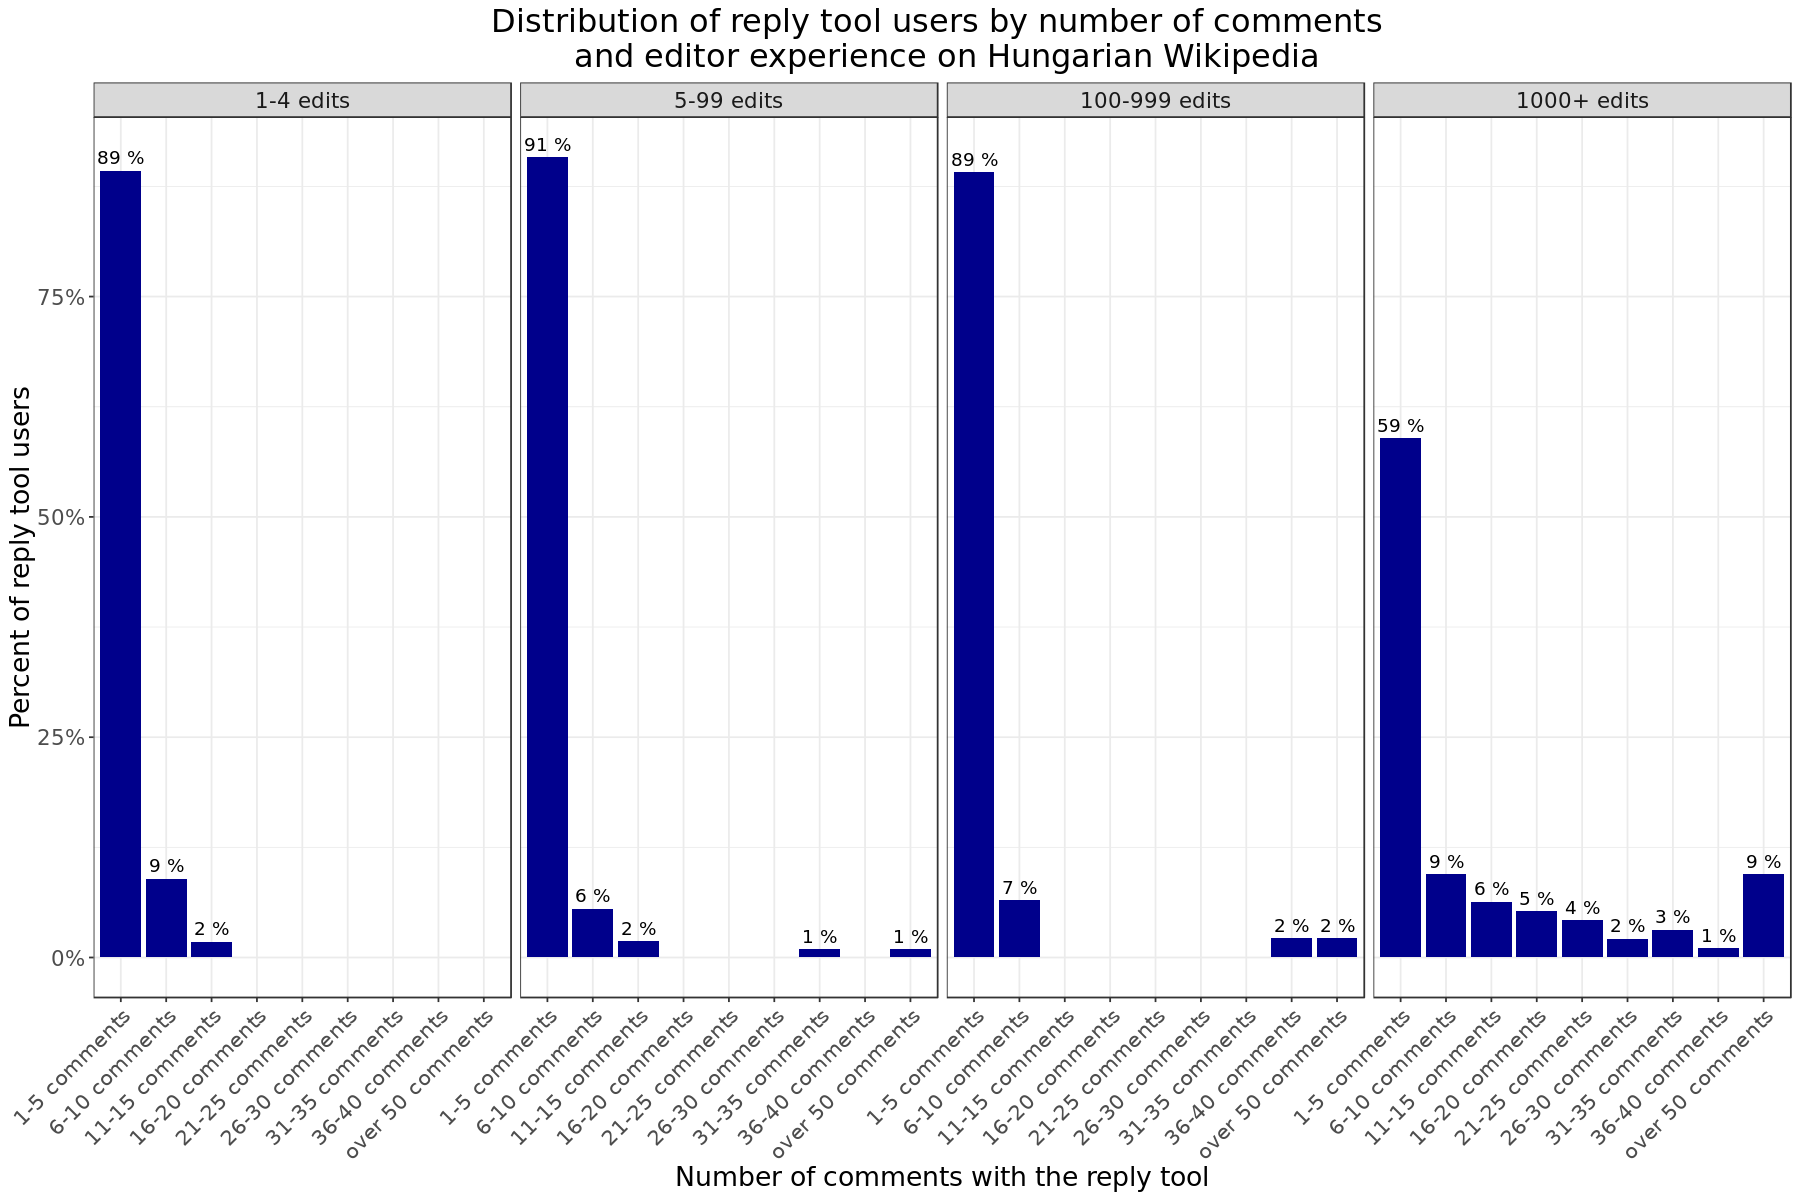

In [381]:
p <-  reply_edits_byeditgroup_bywiki %>%
    filter(wiki == 'huwiki') %>%
    ggplot(aes(x=num_reply_comments, y = percent_reply_users)) +
    facet_grid(~edit_count_bucket) +
    geom_bar(stat = 'identity', fill = 'darkblue') +
    geom_text(aes(label = paste(round(percent_reply_users * 100), '%')), vjust = -0.5, position = position_dodge(width = 1)) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of reply tool users",
          x = "Number of comments with the reply tool",
         title = "Distribution of reply tool users by number of comments \n and editor experience on Hungarian Wikipedia")  +
     theme_bw() +
   theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)) 
        
p

ggsave("Figures/reply_users_by_numcomments_huwiki_editcount.png", p, width = 16, height = 8, units = "in", dpi = 300)

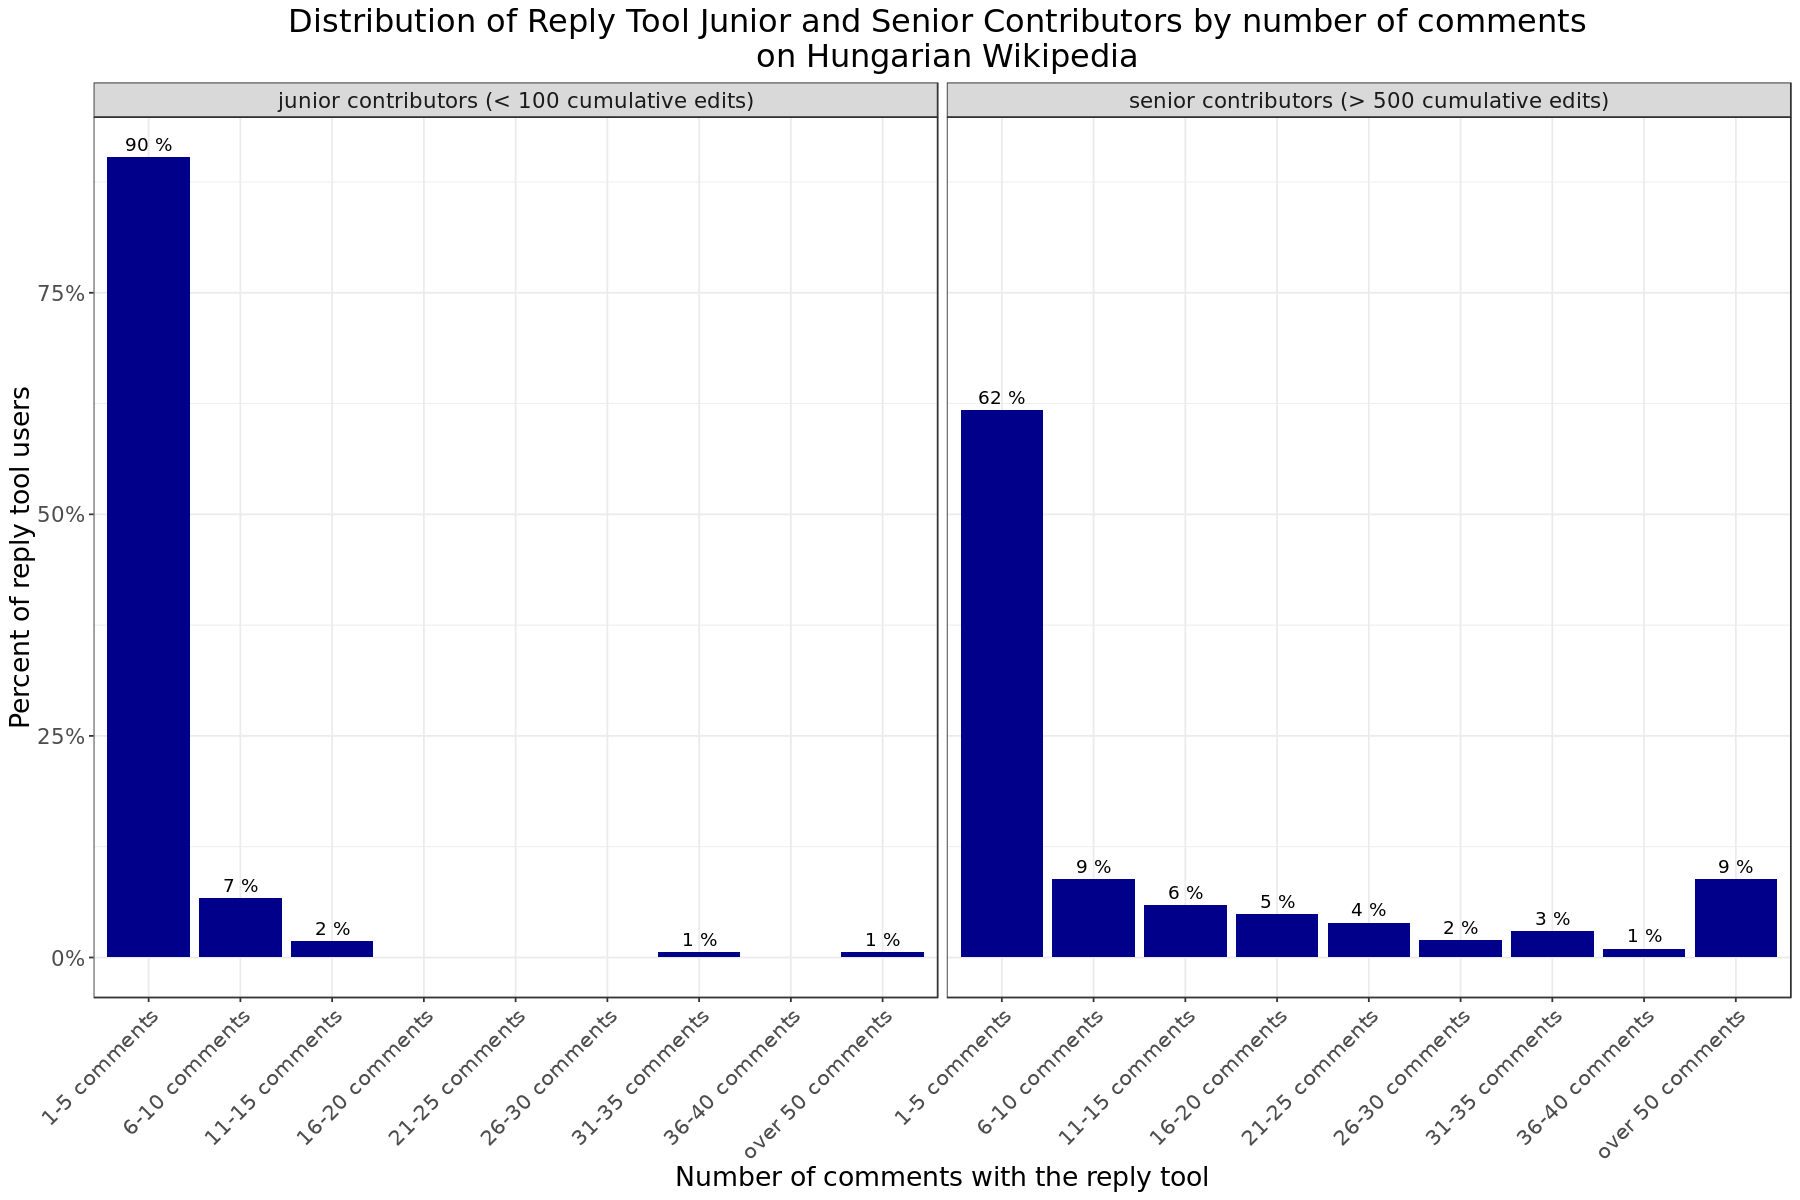

In [382]:
# by senior and junior contributors

p <-  reply_edits_byexperience_bywiki %>%
    filter(wiki == 'huwiki',
            experience_level != 'NA') %>%
    ggplot(aes(x=num_reply_comments, y = percent_reply_users)) +
    facet_grid(~experience_level) +
    geom_bar(stat = 'identity', fill = 'darkblue') +
    geom_text(aes(label = paste(round(percent_reply_users * 100), '%')), vjust = -0.5, position = position_dodge(width = 1)) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of reply tool users",
          x = "Number of comments with the reply tool",
         title = "Distribution of Reply Tool Junior and Senior Contributors by number of comments \n on Hungarian Wikipedia")  +
     theme_bw() +
   theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)) 
        
p

ggsave("Figures/reply_users_by_numcomments_huwiki_experience.png", p, width = 16, height = 8, units = "in", dpi = 300)

A few key observations regarding the distbution of users by comments posted for each wiki:

* Similar to overall trends, the majority editors across all experience levels make between 1 to 5 comments using the reply tool. Senior contributors are more likely to make more than 5 comments compared to Junior contributors.
* Over 90% of junior contributors on each of the three opt-out wikis made between 1 to 5 comments using the reply tool. 
* Arabic Wikipedia had the highest percentage (22%) of senior contributors with 1000+ edits that made over 50 comments. This may be due to unmarked bots.

## Distribution of people who posted a comment with the tool on distinct days

* We reviewed the number and percentage of people overall that used the tool on just 1 day and that made edits within identified buckets of day. 

Notes: 
* For this analysis, we changed the bin width to just 1 day instead of 5 days since a large majority of reply tool users in each wiki only used the reply tool between 1 to 5 distinct days. With this change, we can see more detail about reply tool usage at this level.
* Similar to the calculations above, we reviewed data comes from mediawiki_history. We reviewed all edits made with the `discussiontools` change tag.
* A distinct day was defined as a distinct calendar day; therefore, some of these edits may have occurred 24 hours apart and some may have occured only a few hours apart depending on what time of day the edit was made; however, it provides a useful estimation of repeat usage of the tool or "stickiness of the tool".

In [384]:
query <- "
-- obtain distinct day of edits by user
SELECT
    wiki,
    reply_user,
    CASE
            WHEN min(edit_count) is NULL THEN 'undefined'
            WHEN min(edit_count) = 0 THEN '0 edits'
            WHEN (min(edit_count) >=1 AND min(edit_count) < 5) THEN '1-4 edits'
            WHEN (min(edit_count) >=5 AND min(edit_count) < 100) THEN '5-99 edits'
            WHEN (min(edit_count) >=100 AND min(edit_count) < 1000) THEN '100-999 edits'
            ELSE '1000+ edits'
            END AS edit_count_bucket,
     CASE
            WHEN min(edit_count) < 100 THEN 'junior contributors (< 100 cumulative edits)' 
            WHEN min(edit_count) > 500 THEN 'senior contributors (> 500 cumulative edits)'
            ELSE 'NA'
            END AS experience_level,
    COUNT(DISTINCT(day_of_activity)) AS days_of_activity
FROM (
    SELECT
        wiki_db AS wiki,
        event_user_id AS reply_user,
        event_user_revision_count AS edit_count,
        to_date(event_timestamp) AS day_of_activity
    FROM wmf.mediawiki_history
    WHERE 
        ARRAY_CONTAINS(revision_tags, 'discussiontools') AND
        snapshot = '2020-12' AND
        event_timestamp >= '2020-09-24' AND
        event_timestamp < '2020-12-08' AND
        wiki_db IN ('arwiki','cswiki', 'huwiki') AND 
        event_entity = 'revision' AND
-- remove anonymous users
        event_user_id IS NOT NULL AND
-- remove bots
        SIZE(event_user_is_bot_by_historical) = 0  AND
        SIZE(event_user_is_bot_by) = 0 AND
        event_type = 'create'
) edits
GROUP BY 
    reply_user, 
    wiki
"

In [ ]:
collect_reply_days_activity <- wmfdata::query_hive(query)

In [386]:
# Order edit counts 
collect_reply_days_activity$edit_count_bucket %<>% 
    factor(levels= c("0 edits", "1-4 edits", "5-99 edits", "100-999 edits", "1000+ edits")) 
    

### By Wiki

In [387]:
#Divide days of activity into groups with bin width set to 1 day
b <- c(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, Inf)
names <- c('1 day', '2 days', '3 days', '4 days', '5 days', '6 days', '7 days',
         '8 days', '9 days', '10 days', 'over 10 days')

reply_days_bygroup <- collect_reply_days_activity %>%
    mutate(days_activity_group = cut(days_of_activity, breaks = b, labels = names))

In [ ]:
reply_days_bygroup_overall <- reply_days_bygroup %>%
    group_by(wiki, days_activity_group) %>%
     summarise(n_users = n()) %>%
    mutate(percent_reply_users = n_users/sum(n_users) * 100)

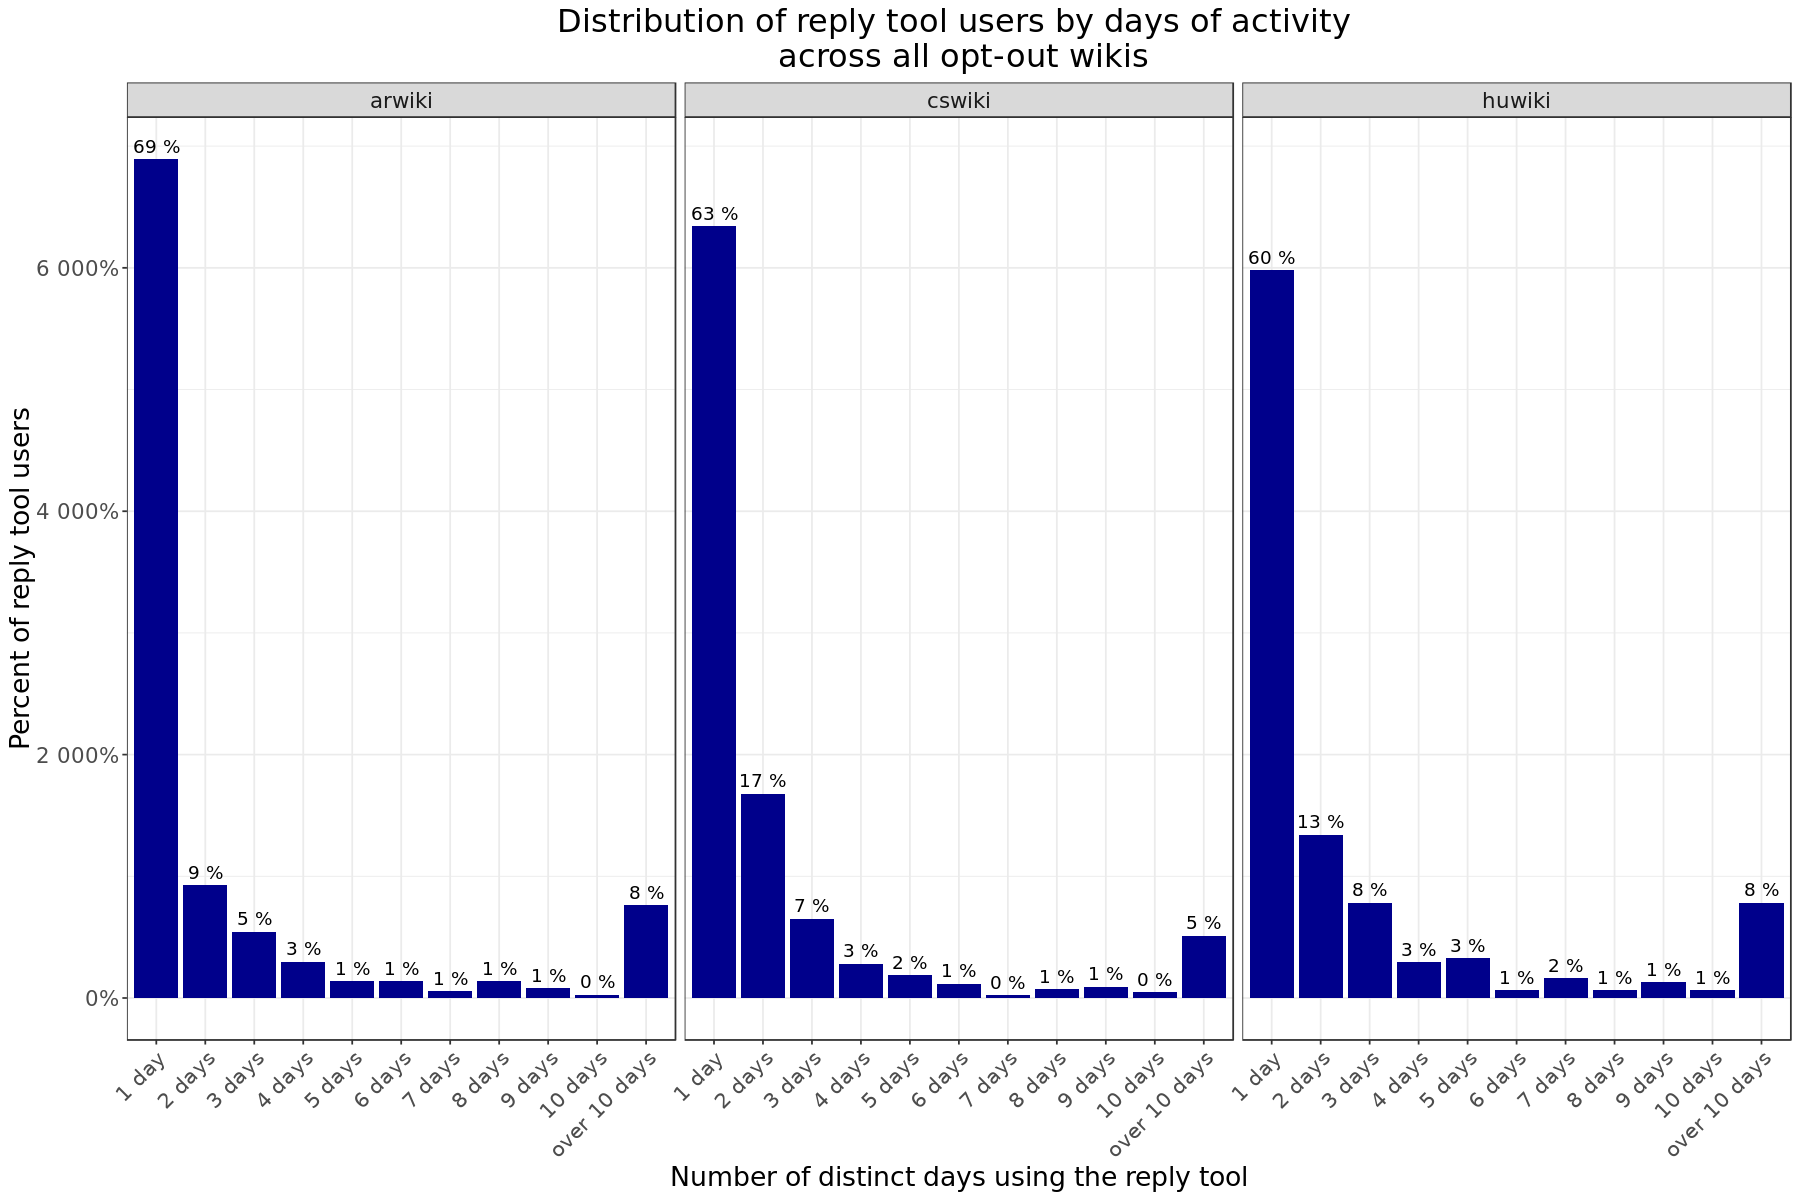

In [389]:
p <-  reply_days_bygroup_overall %>%
    ggplot(aes(x=days_activity_group, y = percent_reply_users)) +
    geom_bar(stat = 'identity', fill = 'darkblue') +
    geom_text(aes(label = paste(round(percent_reply_users), '%')), vjust = -0.5, position = position_dodge(width = 1)) +
    facet_grid(~wiki) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of reply tool users",
          x = "Number of distinct days using the reply tool",
         title = "Distribution of reply tool users by days of activity \n across all opt-out wikis")  +
     theme_bw() +
   theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)) 
        
p

ggsave("Figures/reply_users_by_distinctdays.png", p, width = 16, height = 8, units = "in", dpi = 300)

On the three opt-out wikis, the majority (60% to 69%) only used the reply tool on one day within the reviewed timeframe (24 September 2020 through 08 December 2020). Arabic Wikipedia had the highest percentage of 1 day users (69% of reply tool users posted a comment on just 1 distinct day).

Hungarian Wikipedia had the highest overall percentage of return reply tool users (40% of reply tool users used the reply tool on more than 1 distinct day).


### Breakdown of users that posted a comment on only 1 day by experience level

In [ ]:
# Find overall number of users that made only 1 edit by edit count
reply_days_activity_1day_byeditcount <- collect_reply_days_activity %>%
    group_by(wiki) %>%
    mutate(total_wiki_user_count = n()) %>%
    filter(days_of_activity == 1)  %>%
    group_by(wiki, edit_count_bucket) %>%
    summarise(percent_users = n()/total_wiki_user_count) %>%
    distinct()


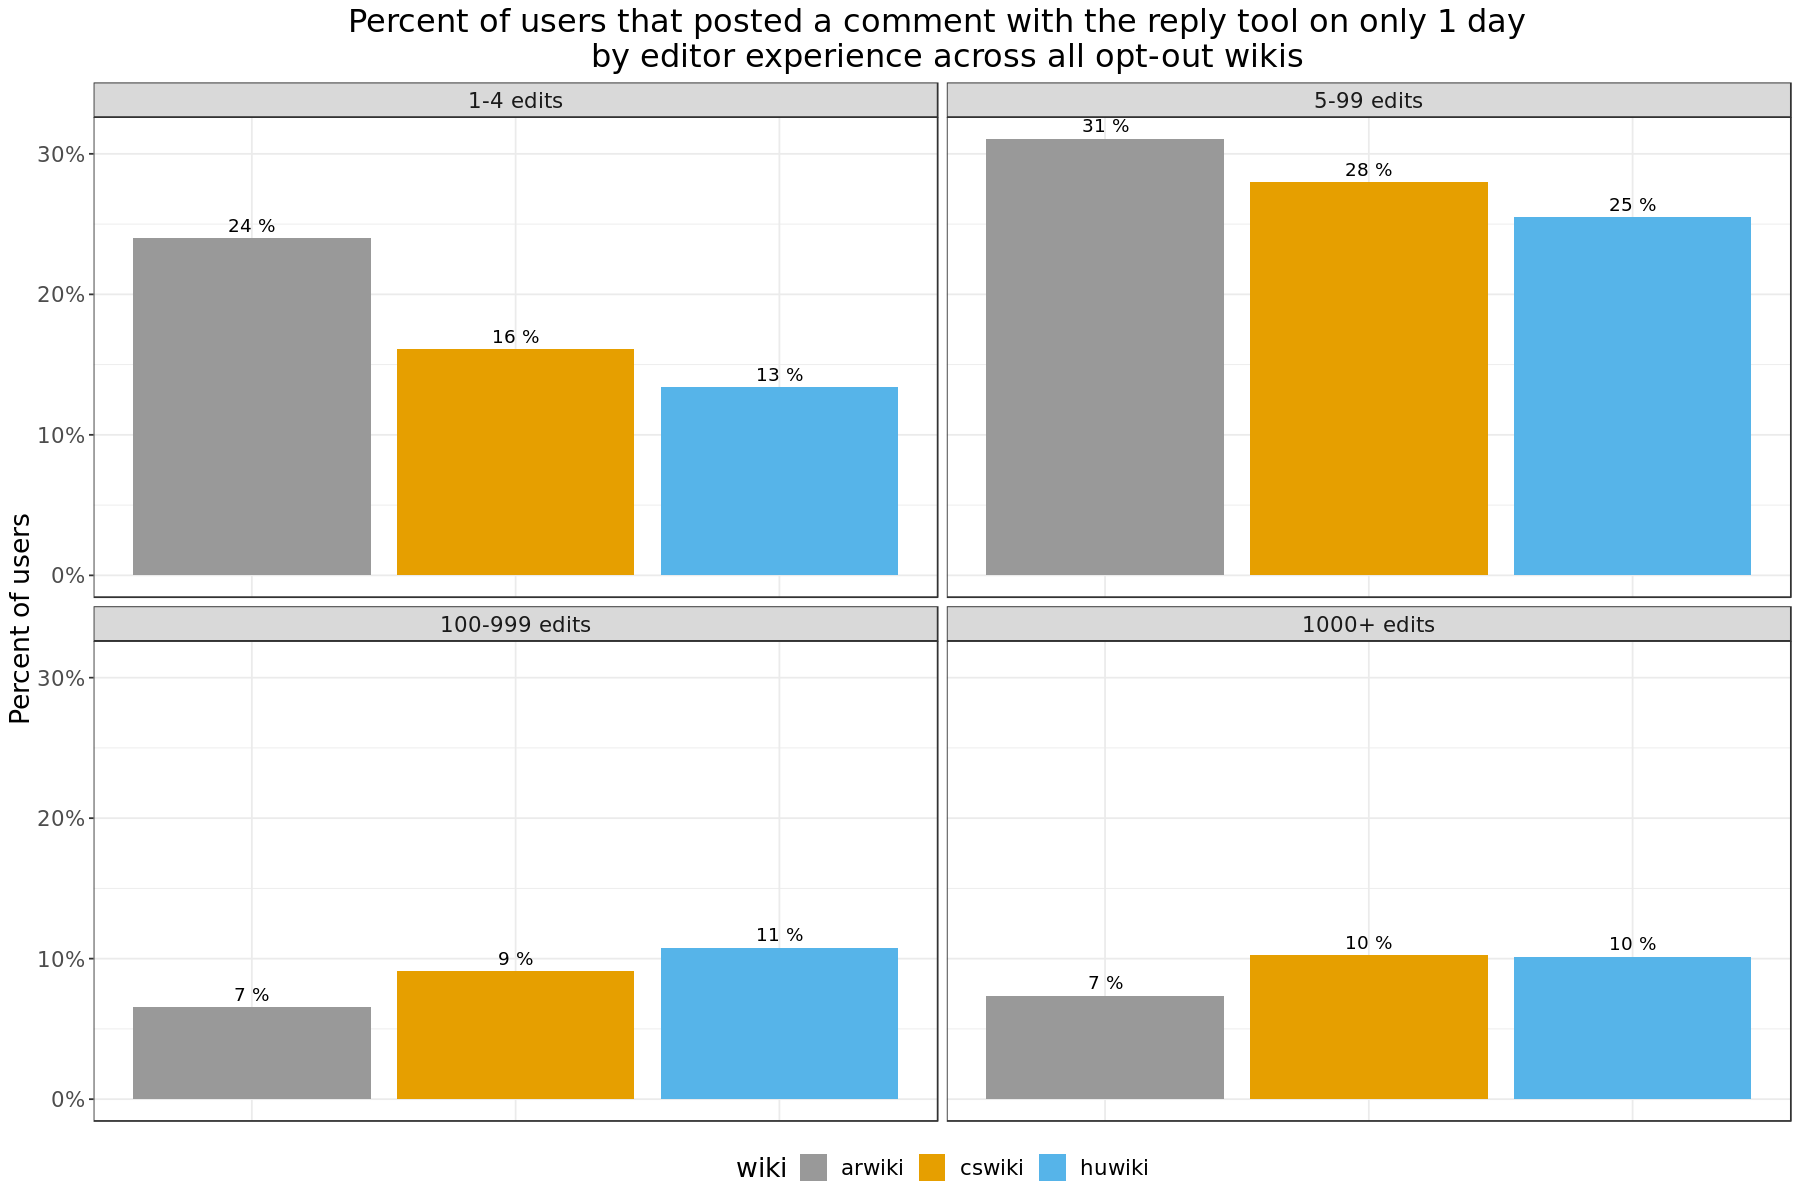

In [509]:
# plot 1 edit completion rates

p <- reply_days_activity_1day_byeditcount %>%
        ggplot(aes(x=wiki, y= percent_users, fill = wiki)) +
        facet_wrap(~edit_count_bucket) +
        geom_bar(stat='identity', position = 'dodge') +
        geom_text(aes(label = paste(round(percent_users * 100), '%')), vjust = -0.5, position = position_dodge(width = 1)) +
        scale_y_continuous(labels = scales::percent) +
        labs (y = "Percent of users",
          x = "Edit Count Bucket",
         title = "Percent of users that posted a comment with the reply tool on only 1 day \n by editor experience across all opt-out wikis")  +
         theme_bw() +
        scale_fill_manual(values = cbp1)  +
         theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
          legend.position="bottom",
        axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())
      
      
p

ggsave("Figures/one_comment_users_byeditcount.png", p, width = 16, height = 8, units = "in", dpi = 300)

In [ ]:

reply_days_activity_1day_byexperience <- collect_reply_days_activity %>%
    group_by(wiki) %>%
    mutate(total_wiki_user_count = n()) %>%
    filter(days_of_activity == 1,
          experience_level != 'NA')  %>%
    group_by(wiki, experience_level) %>%
    summarise(percent_users = n()/total_wiki_user_count) %>%
    distinct()

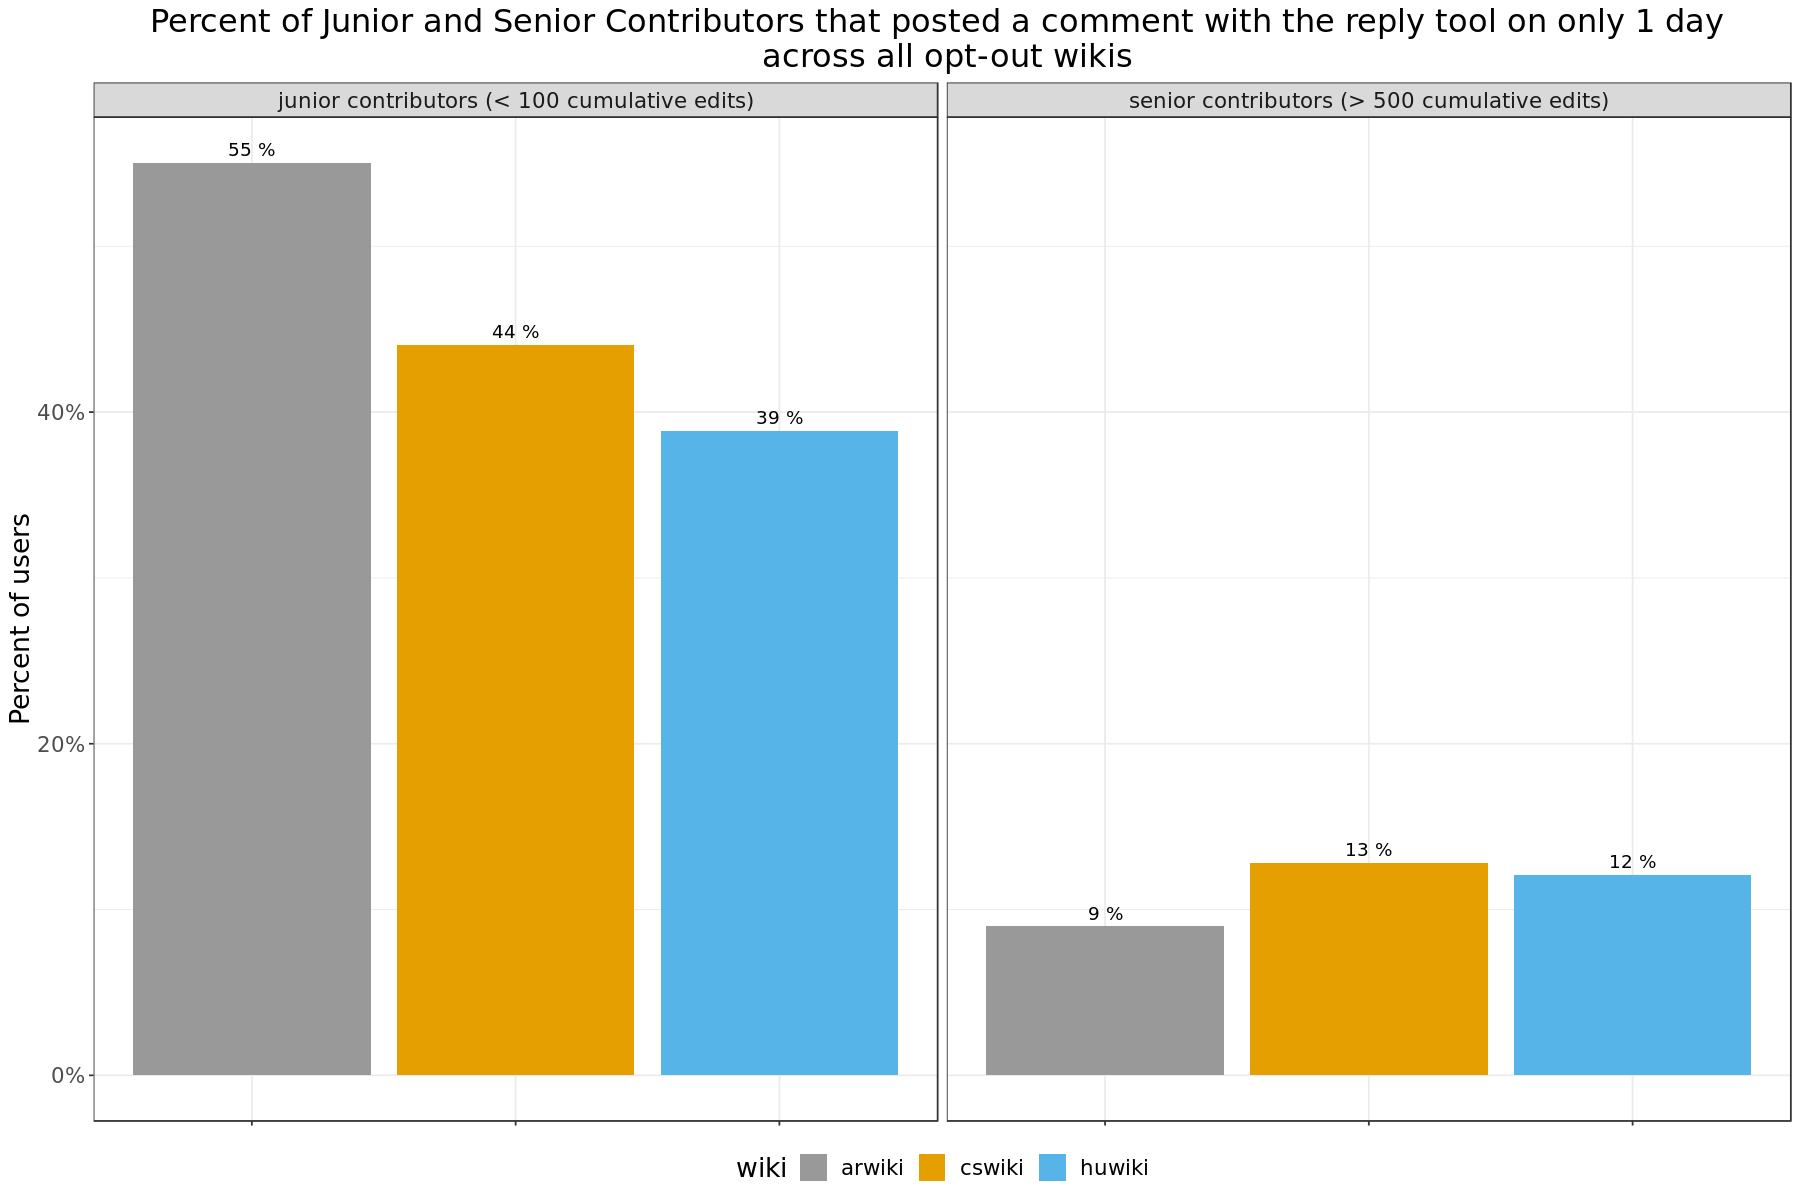

In [510]:
# plot 1 edit completion rates

p <- reply_days_activity_1day_byexperience %>%
        ggplot(aes(x=wiki, y= percent_users, fill = wiki)) +
        facet_wrap(~experience_level) +
        geom_bar(stat='identity', position = 'dodge') +
        geom_text(aes(label = paste(round(percent_users * 100), '%')), vjust = -0.5, position = position_dodge(width = 1)) +
        scale_y_continuous(labels = scales::percent) +
        labs (y = "Percent of users",
          x = "Edit Count Bucket",
         title = "Percent of Junior and Senior Contributors that posted a comment with the reply tool on only 1 day \n across all opt-out wikis")  +
         theme_bw() +
        scale_fill_manual(values = cbp1)  +
          theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position = 'bottom',
        axis.title.x = element_blank(),
        axis.text.x=element_blank()
        ) 
      
      
p

ggsave("Figures/one_comment_users_byexperience.png", p, width = 16, height = 8, units = "in", dpi = 300)

The majority of 1 days reply tool users are Junior Contributors (under 100 cumulative edits) for each of the three opt-out wikis. 

In [ ]:
 # find distinct days by edit count and wiki
reply_days_byeditcount_bywiki <- reply_days_bygroup %>%
    group_by(wiki, edit_count_bucket, days_activity_group) %>%
     summarise(n_users = n()) %>%
    mutate(percent_reply_users = n_users/sum(n_users))

In [ ]:
 # find distinct days by experience and wiki
reply_days_byexperience_bywiki <- reply_days_bygroup %>%
    filter(experience_level != 'NA') %>%
    group_by(wiki, experience_level, days_activity_group) %>%
     summarise(n_users = n()) %>%
    mutate(percent_reply_users = n_users/sum(n_users))

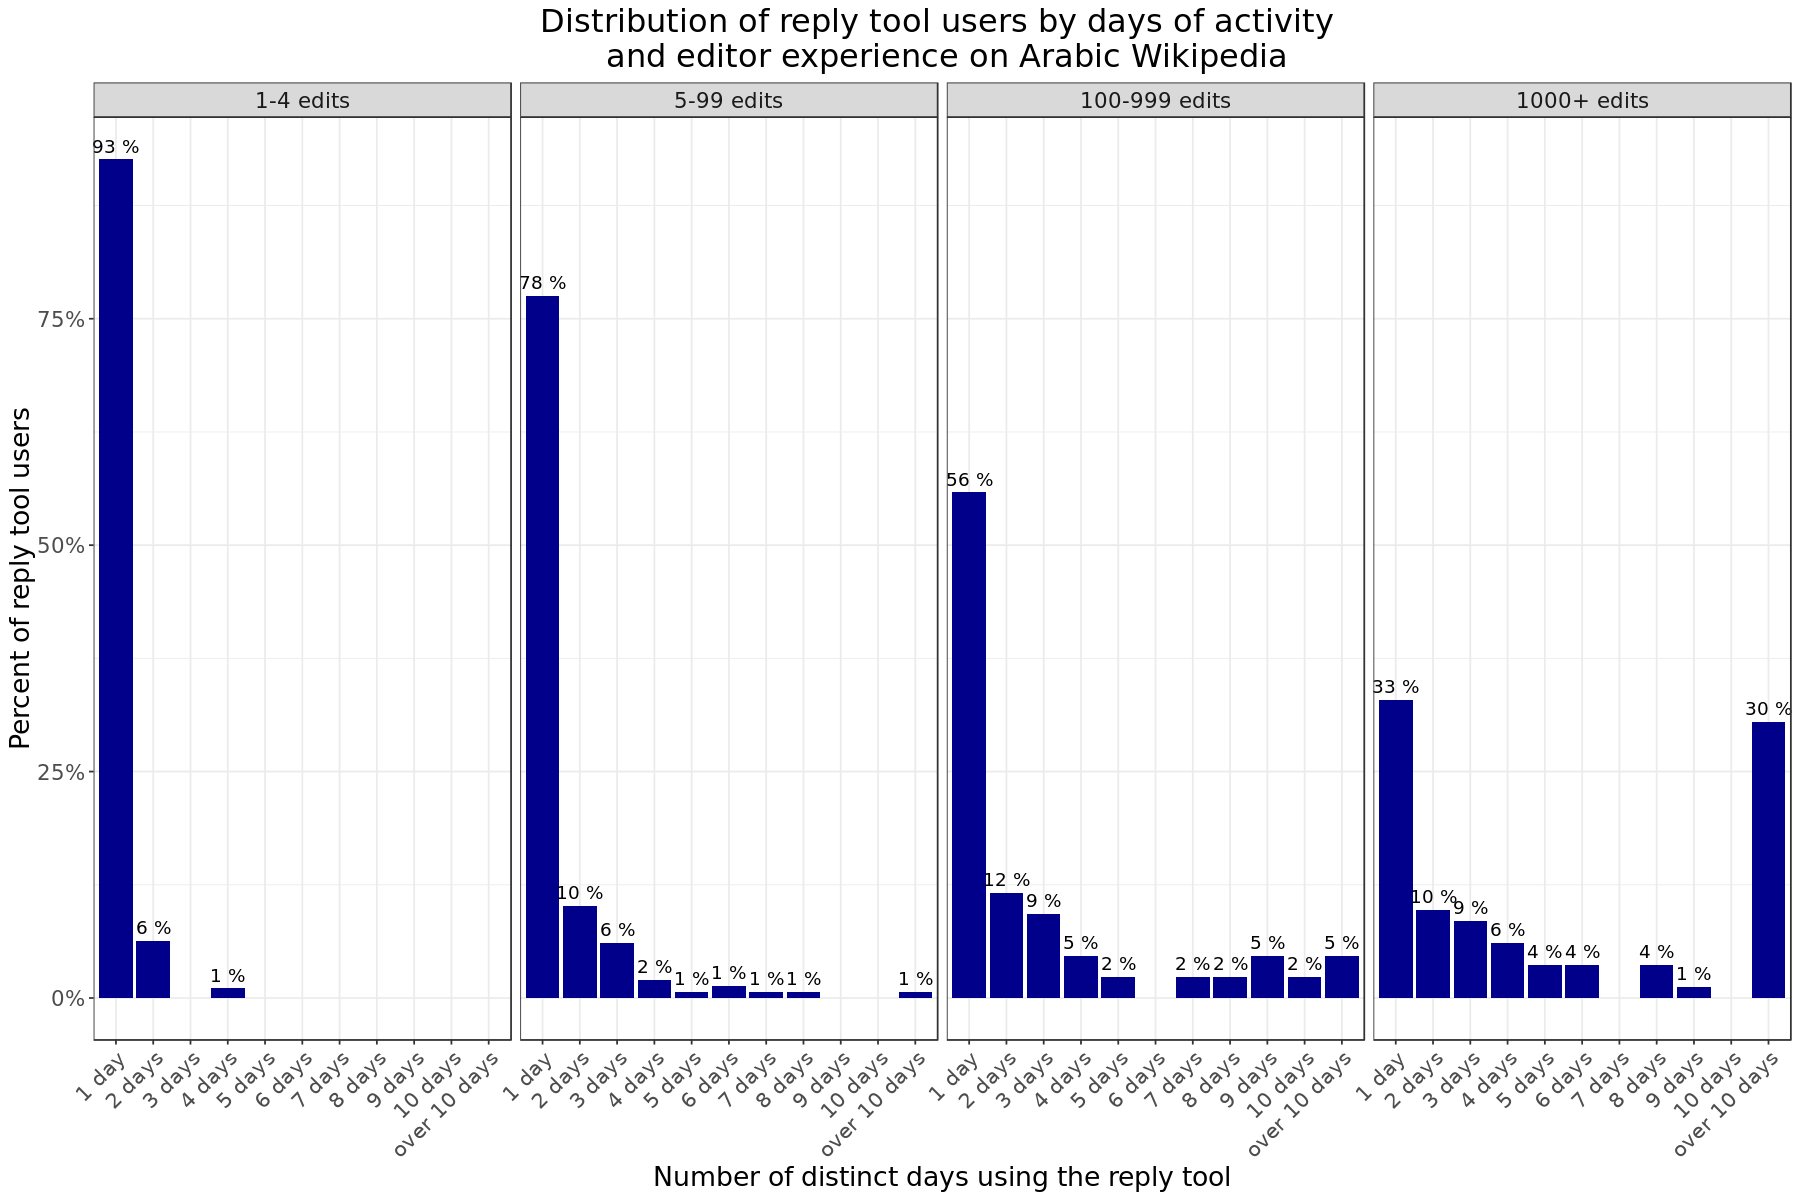

In [399]:
p <-reply_days_byeditcount_bywiki %>%
    filter(wiki == 'arwiki') %>%
    ggplot(aes(x=days_activity_group, y = percent_reply_users)) +
    facet_grid(~edit_count_bucket) +
    geom_bar(stat = 'identity', fill = 'darkblue') +
    geom_text(aes(label = paste(round(percent_reply_users * 100), '%')), vjust = -0.5) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of reply tool users",
          x = "Number of distinct days using the reply tool",
         title = "Distribution of reply tool users by days of activity \n and editor experience on Arabic Wikipedia")  +
     theme_bw() +
   theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)) 
        
p

ggsave("Figures/reply_users_by_distinctdays_arwiki_editcount.png", p, width = 16, height = 8, units = "in", dpi = 300)

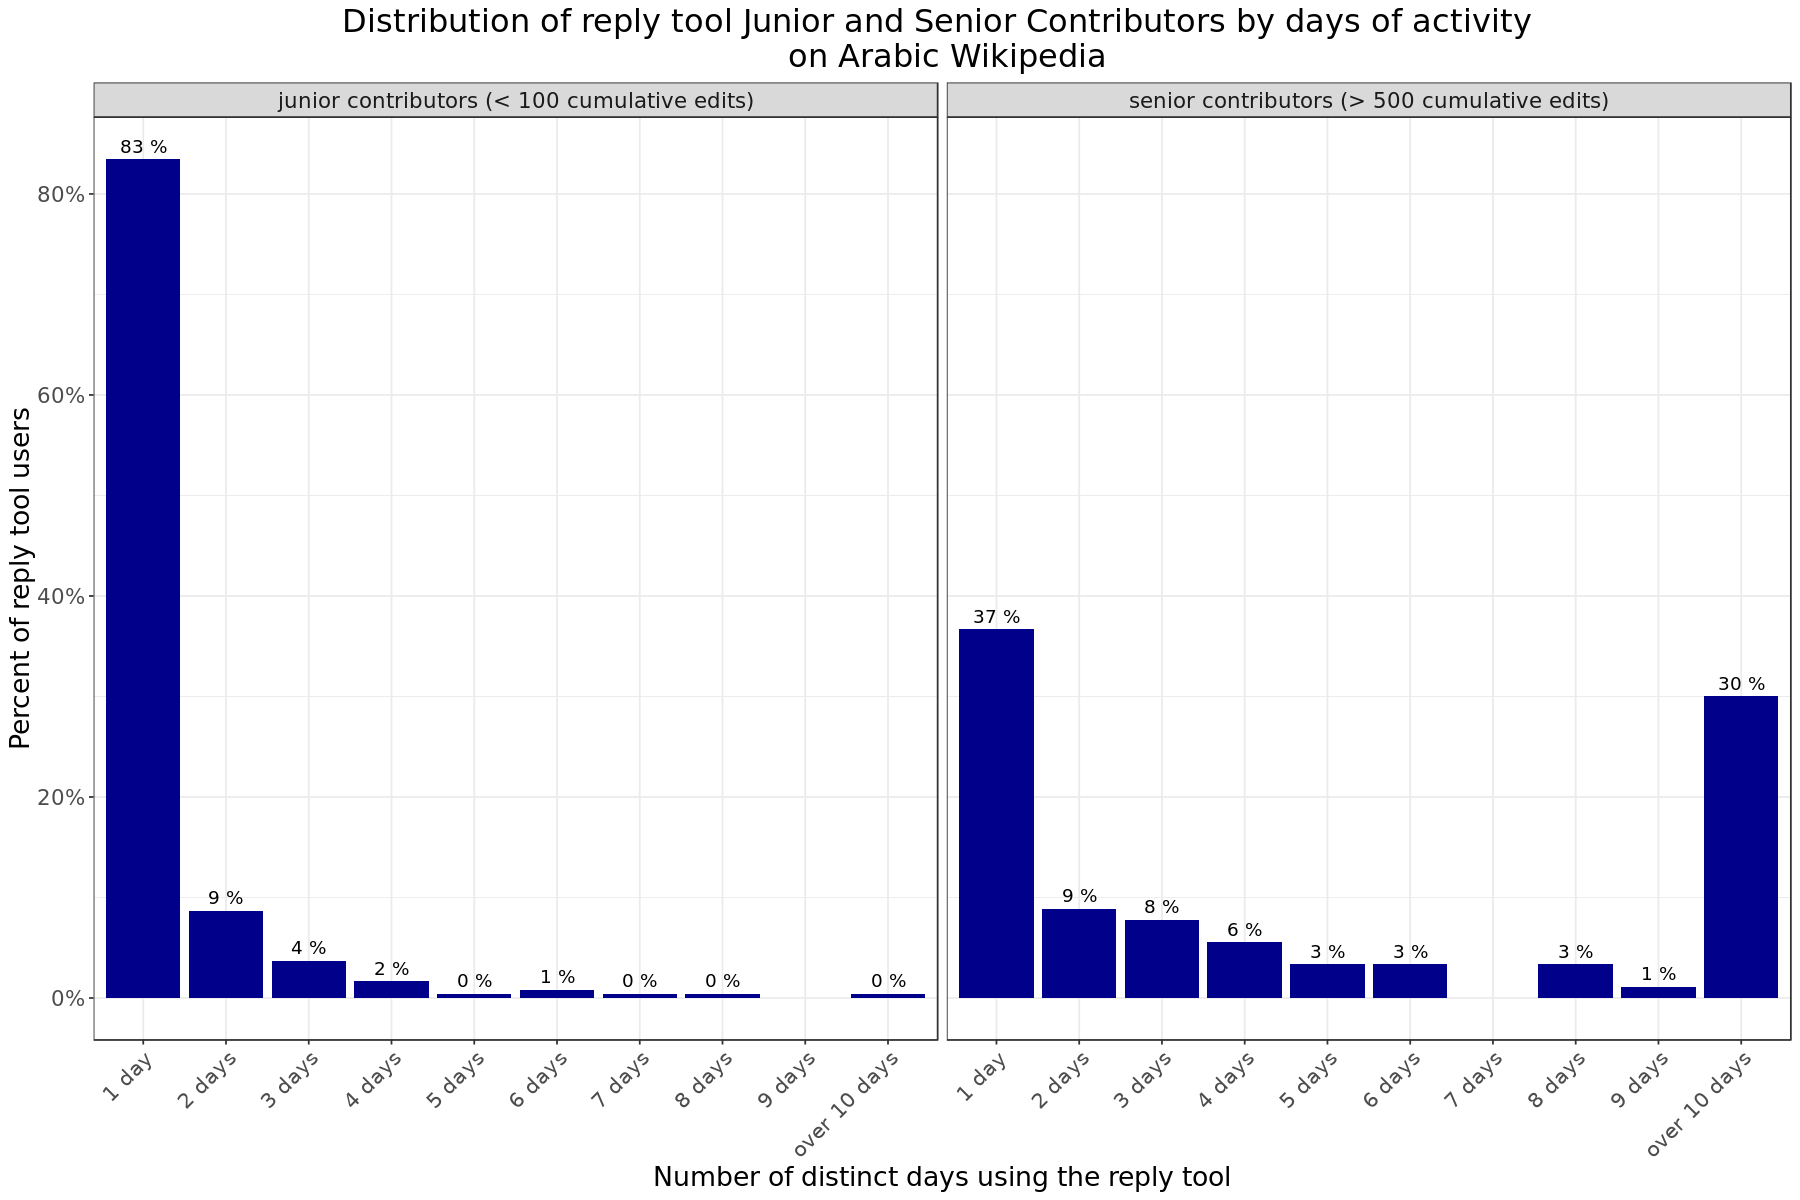

In [400]:
p <-reply_days_byexperience_bywiki %>%
    filter(wiki == 'arwiki') %>%
    ggplot(aes(x=days_activity_group, y = percent_reply_users)) +
    facet_grid(~experience_level) +
    geom_bar(stat = 'identity', fill = 'darkblue') +
    geom_text(aes(label = paste(round(percent_reply_users * 100), '%')), vjust = -0.5) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of reply tool users",
          x = "Number of distinct days using the reply tool",
         title = "Distribution of reply tool Junior and Senior Contributors by days of activity \n on Arabic Wikipedia")  +
     theme_bw() +
   theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)) 
        
p

ggsave("Figures/reply_users_by_distinctdays_arwiki_experience.png", p, width = 16, height = 8, units = "in", dpi = 300)

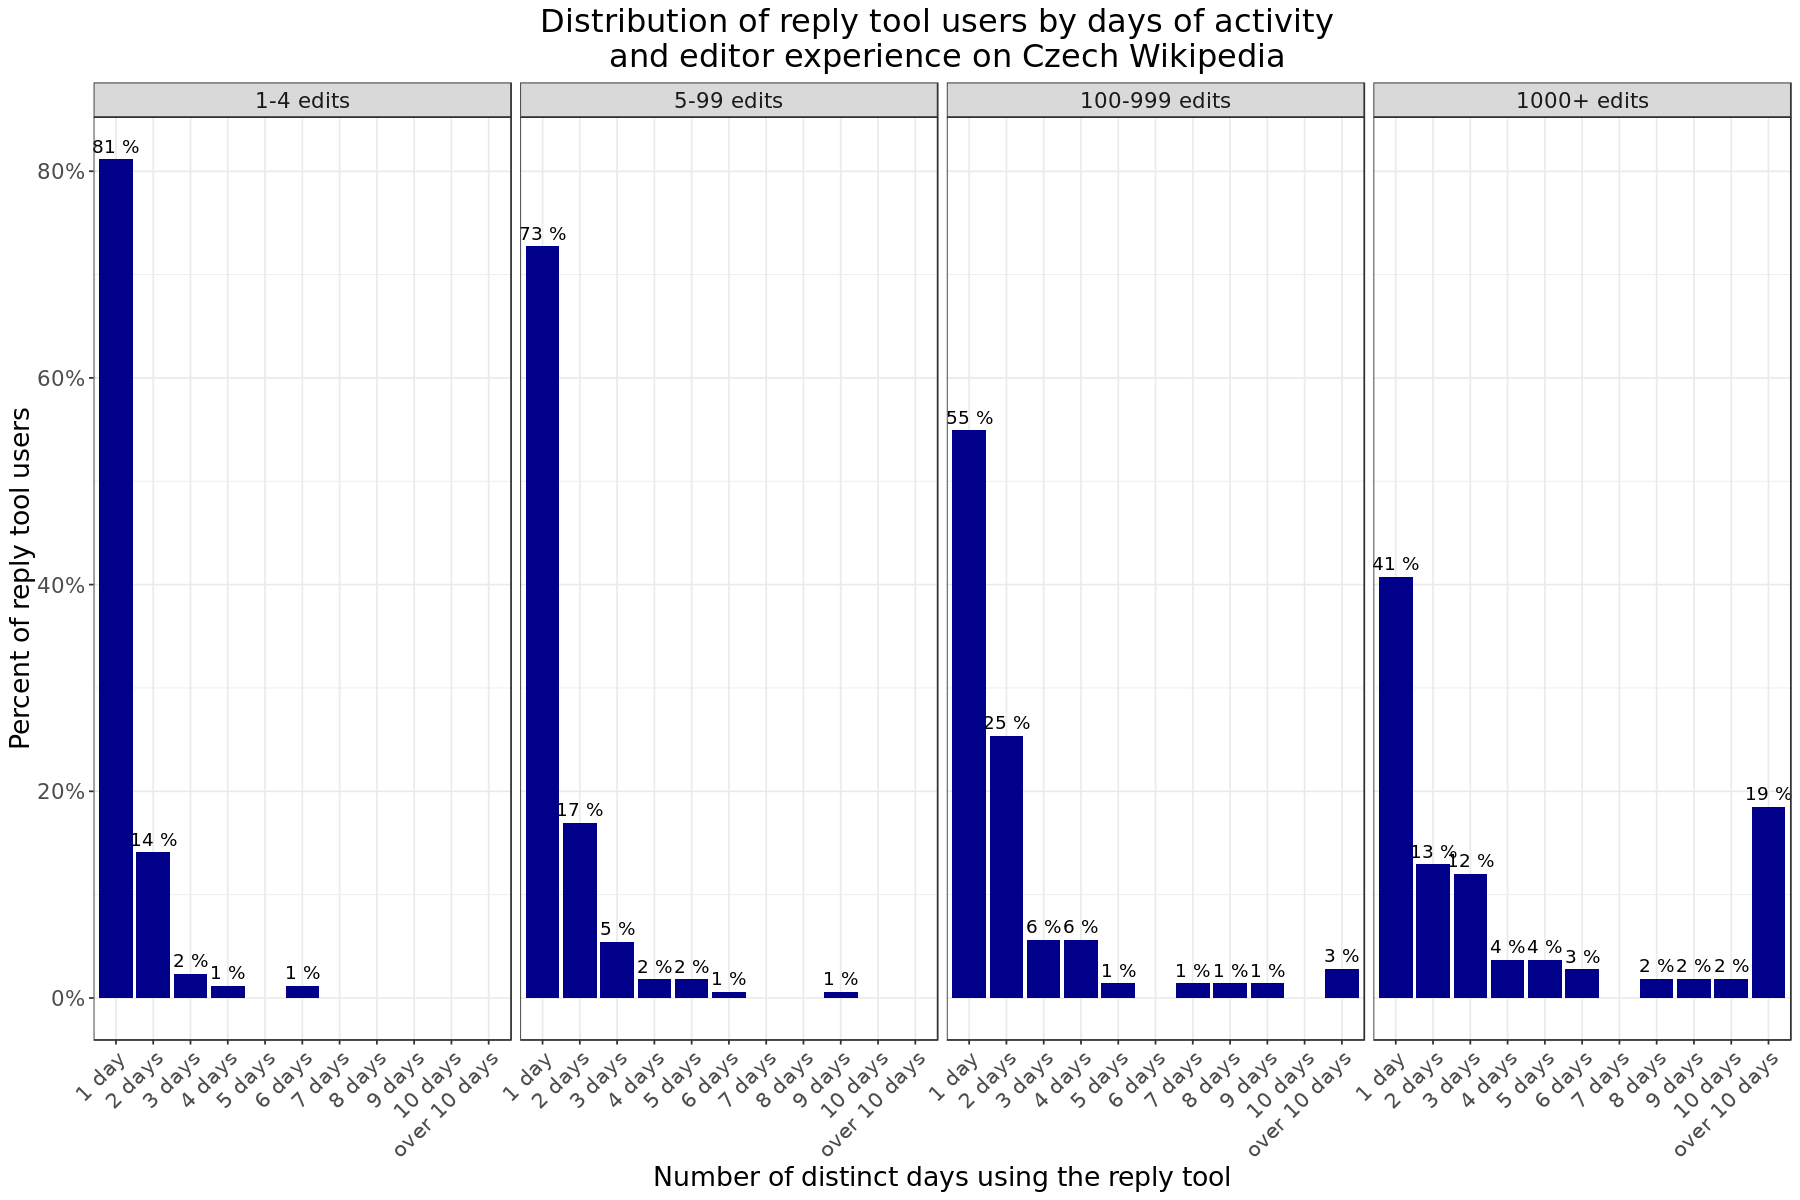

In [401]:
p <-reply_days_byeditcount_bywiki %>%
    filter(wiki == 'cswiki') %>%
    ggplot(aes(x=days_activity_group, y = percent_reply_users)) +
    facet_grid(~edit_count_bucket) +
    geom_bar(stat = 'identity', fill = 'darkblue') +
    geom_text(aes(label = paste(round(percent_reply_users * 100), '%')), vjust = -0.5) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of reply tool users",
          x = "Number of distinct days using the reply tool",
         title = "Distribution of reply tool users by days of activity \n and editor experience on Czech Wikipedia")  +
     theme_bw() +
   theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)) 
        
p

ggsave("Figures/reply_users_by_distinctdays_cswiki_editcount.png", p, width = 16, height = 8, units = "in", dpi = 300)

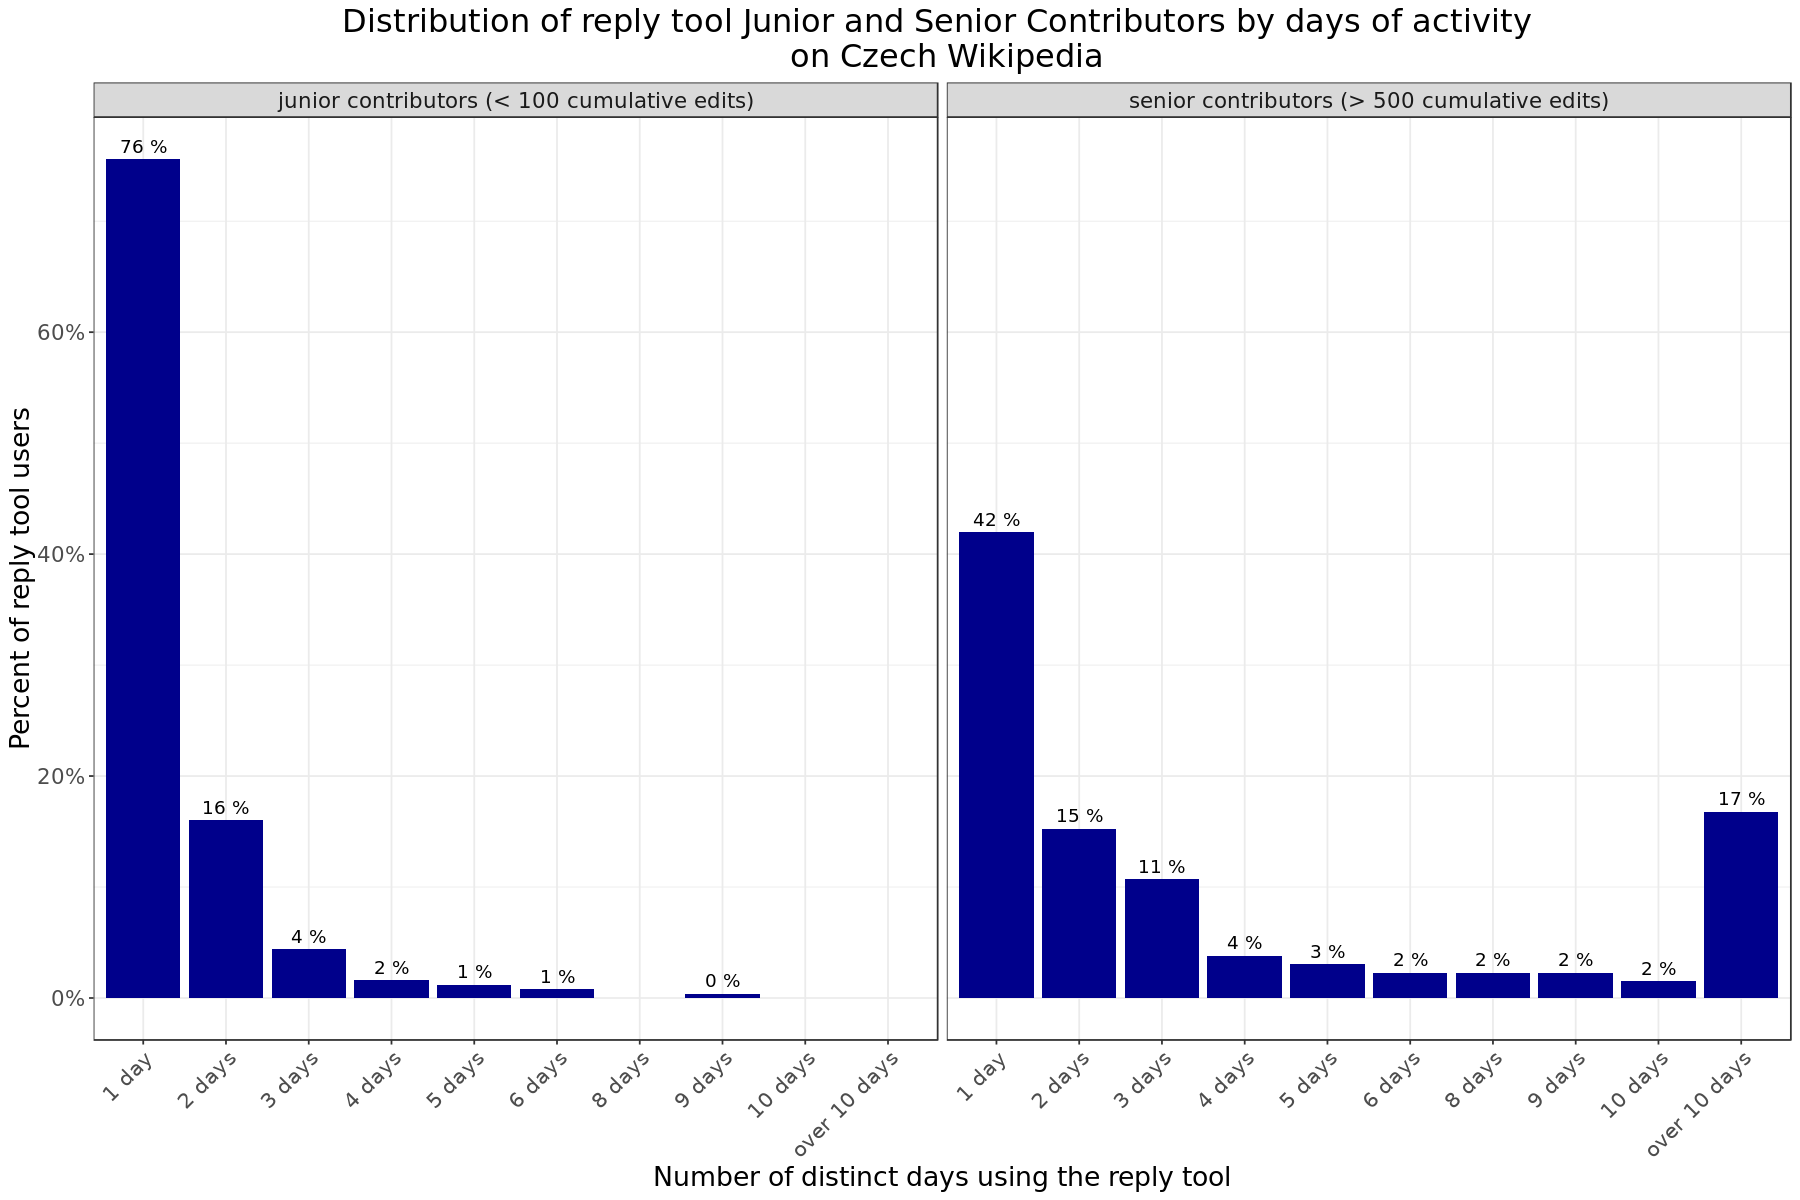

In [402]:
p <-reply_days_byexperience_bywiki %>%
    filter(wiki == 'cswiki') %>%
    ggplot(aes(x=days_activity_group, y = percent_reply_users)) +
    facet_grid(~experience_level) +
    geom_bar(stat = 'identity', fill = 'darkblue') +
    geom_text(aes(label = paste(round(percent_reply_users * 100), '%')), vjust = -0.5) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of reply tool users",
          x = "Number of distinct days using the reply tool",
         title = "Distribution of reply tool Junior and Senior Contributors by days of activity \n on Czech Wikipedia")  +
     theme_bw() +
   theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)) 
        
p

ggsave("Figures/reply_users_by_distinctdays_cswiki_experience.png", p, width = 16, height = 8, units = "in", dpi = 300)

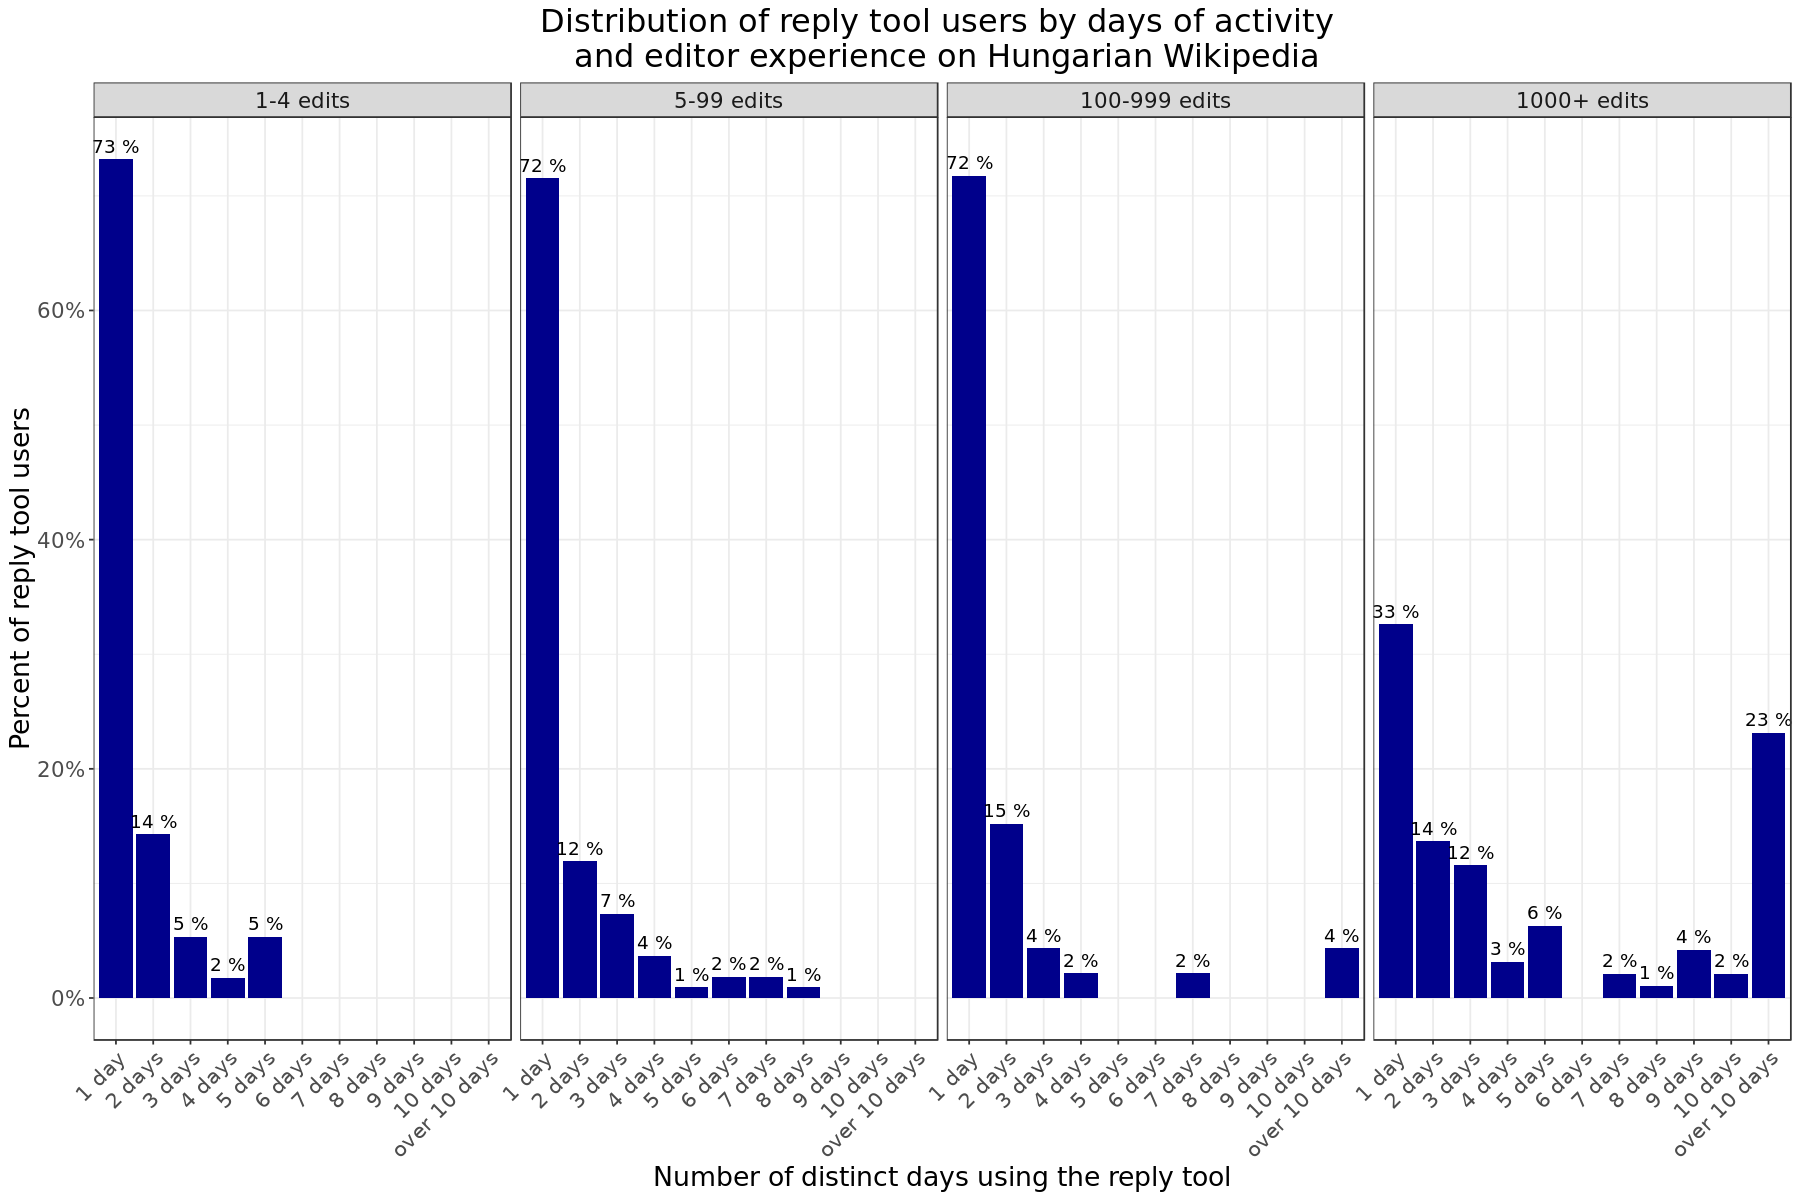

In [403]:
p <-reply_days_byeditcount_bywiki %>%
    filter(wiki == 'huwiki') %>%
    ggplot(aes(x=days_activity_group, y = percent_reply_users)) +
    facet_grid(~edit_count_bucket) +
    geom_bar(stat = 'identity', fill = 'darkblue') +
    geom_text(aes(label = paste(round(percent_reply_users * 100), '%')), vjust = -0.5) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of reply tool users",
          x = "Number of distinct days using the reply tool",
         title = "Distribution of reply tool users by days of activity \n and editor experience on Hungarian Wikipedia")  +
     theme_bw() +
   theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)) 
        
p

ggsave("Figures/reply_users_by_distinctdays_huwiki_editcount.png", p, width = 16, height = 8, units = "in", dpi = 300)

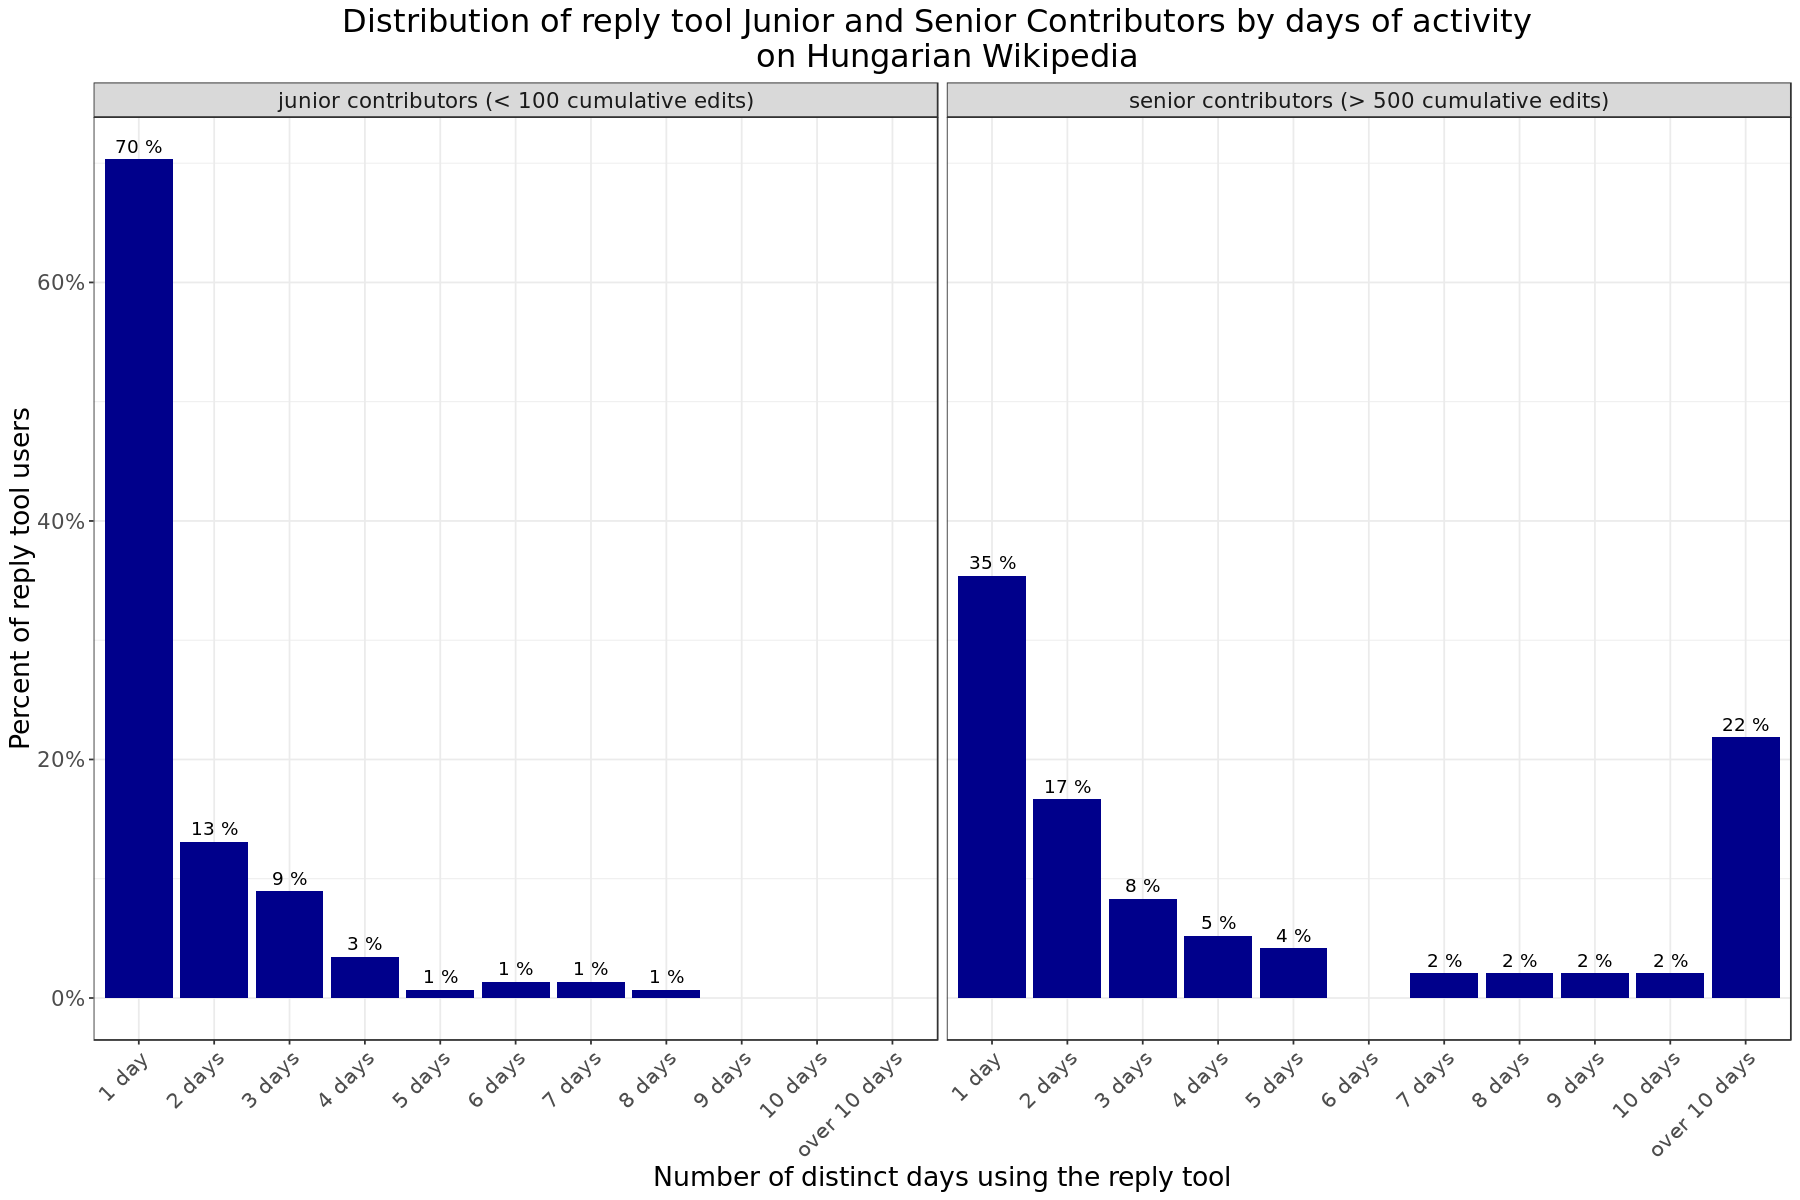

In [403]:
p <-reply_days_byexperience_bywiki %>%
    filter(wiki == 'huwiki') %>%
    ggplot(aes(x=days_activity_group, y = percent_reply_users)) +
    facet_grid(~experience_level) +
    geom_bar(stat = 'identity', fill = 'darkblue') +
    geom_text(aes(label = paste(round(percent_reply_users * 100), '%')), vjust = -0.5) +
    scale_y_continuous(labels = scales::percent) +
    labs (y = "Percent of reply tool users",
          x = "Number of distinct days using the reply tool",
         title = "Distribution of reply tool Junior and Senior Contributors by days of activity \n on Hungarian Wikipedia")  +
     theme_bw() +
   theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)) 
        
p

ggsave("Figures/reply_users_by_distinctdays_huwiki_experience.png", p, width = 16, height = 8, units = "in", dpi = 300)

A few key observations regarding the distbution of users by distinct days of activity for each wiki:

* Arabic Wikipedia had the highest percentage of junior contributors (83%) that made a post with the reply tool on 1 day (compared to 70% on Hungarian Wikipedia).  This makes sense as Arabic Wikipedia also had the most junior contributors that made 1 comment.
* Arabic Wikipedia had the highest percentage of senior contributors with over 1000 edits that made edits on over 10 distinct days


# 3. Are people posting disruptive comments?

To determine if reply tools users are posting disruptive comments, we reviewed the percent of comments reverted within 48 hours and well as the percent of users blocked after posting a reply.

## Percent of comments posted using the Reply Tool that are reverted within 48 hours

For this analysis, we reviwed data recorded in [mediawiki_history](https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Edits/MediaWiki_history) to identify comments posted by the reply tool (identified by the revision tag: `discussiontools`) that are reverted within 48 hours [1].  

We included both anonymous and registed users as this analysis does not look at reverts on a per user basis and does not require the ability to identifiy unqiue users. Reverts were reviewed on a per comment basis instead. 

[1]  48 hours is a common cutoff, as [research](https://meta.wikimedia.org/wiki/Research:Revert) suggests that, at least for the English Wikipedia, nearly all reverts take place within 48 hours


In [404]:
# collect comments posted using the Reply Tool reverted within 48 hours.
query <- "
SELECT
     wiki_db AS wiki,
    CASE
            WHEN event_user_revision_count is NULL THEN 'undefined'
            WHEN event_user_revision_count  = 0 THEN '0 edits'
            WHEN (event_user_revision_count  >=1 AND event_user_revision_count  < 5) THEN '1-4 edits'
            WHEN (event_user_revision_count  >=5 AND event_user_revision_count  < 100) THEN '5-99 edits'
            WHEN (event_user_revision_count  >=100 AND event_user_revision_count  < 1000) THEN '100-999 edits'
            ELSE '1000+ edits'
            END AS edit_count_bucket,
    CASE
            WHEN event_user_revision_count < 100 THEN 'junior contributors (< 100 cumulative edits)' 
            WHEN event_user_revision_count > 500 THEN 'senior contributors (> 500 cumulative edits)'
            ELSE 'NA'
            END AS experience_level,
     SUM(CAST(
            revision_is_identity_reverted AND 
            revision_seconds_to_identity_revert <= 172800  -- 48 hours
           AS int)) AS num_reverts,
    COUNT(*) as num_comments
FROM wmf.mediawiki_history mh 
WHERE 
    snapshot = '2020-12'
    AND ARRAY_CONTAINS(revision_tags, 'discussiontools')
    AND event_entity = 'revision'
    AND event_type = 'create'
    AND event_timestamp >= '2020-09-24' 
    AND event_timestamp <= '2020-12-08'
    AND wiki_db IN ('arwiki','cswiki', 'huwiki')
    AND SIZE(event_user_is_bot_by_historical) = 0 
    AND SIZE(event_user_is_bot_by) = 0
GROUP BY 
 wiki_db ,
 CASE
            WHEN event_user_revision_count is NULL THEN 'undefined'
            WHEN event_user_revision_count  = 0 THEN '0 edits'
            WHEN (event_user_revision_count  >=1 AND event_user_revision_count  < 5) THEN '1-4 edits'
            WHEN (event_user_revision_count  >=5 AND event_user_revision_count  < 100) THEN '5-99 edits'
            WHEN (event_user_revision_count  >=100 AND event_user_revision_count  < 1000) THEN '100-999 edits'
            ELSE '1000+ edits'
            END,
CASE
            WHEN event_user_revision_count < 100 THEN 'junior contributors (< 100 cumulative edits)' 
            WHEN event_user_revision_count > 500 THEN 'senior contributors (> 500 cumulative edits)'
            ELSE 'NA'
            END
"

In [ ]:
collect_reply_reverts <- wmfdata::query_hive(query)

In [406]:
# Order edit counts 
collect_reply_reverts$edit_count_bucket %<>% 
    factor(levels= c("0 edits", "1-4 edits", "5-99 edits", "100-999 edits", "1000+ edits")) 

### By Wiki

In [486]:
pct_reverts_bywiki <- collect_reply_reverts %>%
    group_by(wiki) %>%
    summarise(total_reverts = sum(num_reverts),
              total_comments = sum(num_comments),
              pct_reply_reverts = total_reverts/total_comments * 100, .groups = 'drop')

pct_reverts_bywiki

wiki   total_reverts total_comments pct_reply_reverts
1 arwiki 255           3672           6.9444444        
2 cswiki  21           2792           0.7521490        
3 huwiki  20           2405           0.8316008

On Czech and Hungarian Wikipedia, under 1 percent of reply tool comments posted by users during the reviewed time period (24 September 2020 through 08 December 2020) were reverted under 48 hours.

Arabic Wikipedia had a significantly higher revert rate in comparison (6.9%). However, this revert rate is similar to the desktop revert rate on content namespaces on all Wikipedia projects, which was 6.7% during the same time period.

### By Wiki and Experience level

In [487]:
pct_reply_reverts_byeditcount <- collect_reply_reverts %>%
    group_by(wiki) %>%
    mutate(total_comments = sum(num_comments))  %>%
    group_by(wiki, edit_count_bucket) %>%
    summarise(total_reply_reverts = sum(num_reverts),
              pct_reply_reverts = total_reply_reverts/total_comments, .groups = 'drop')


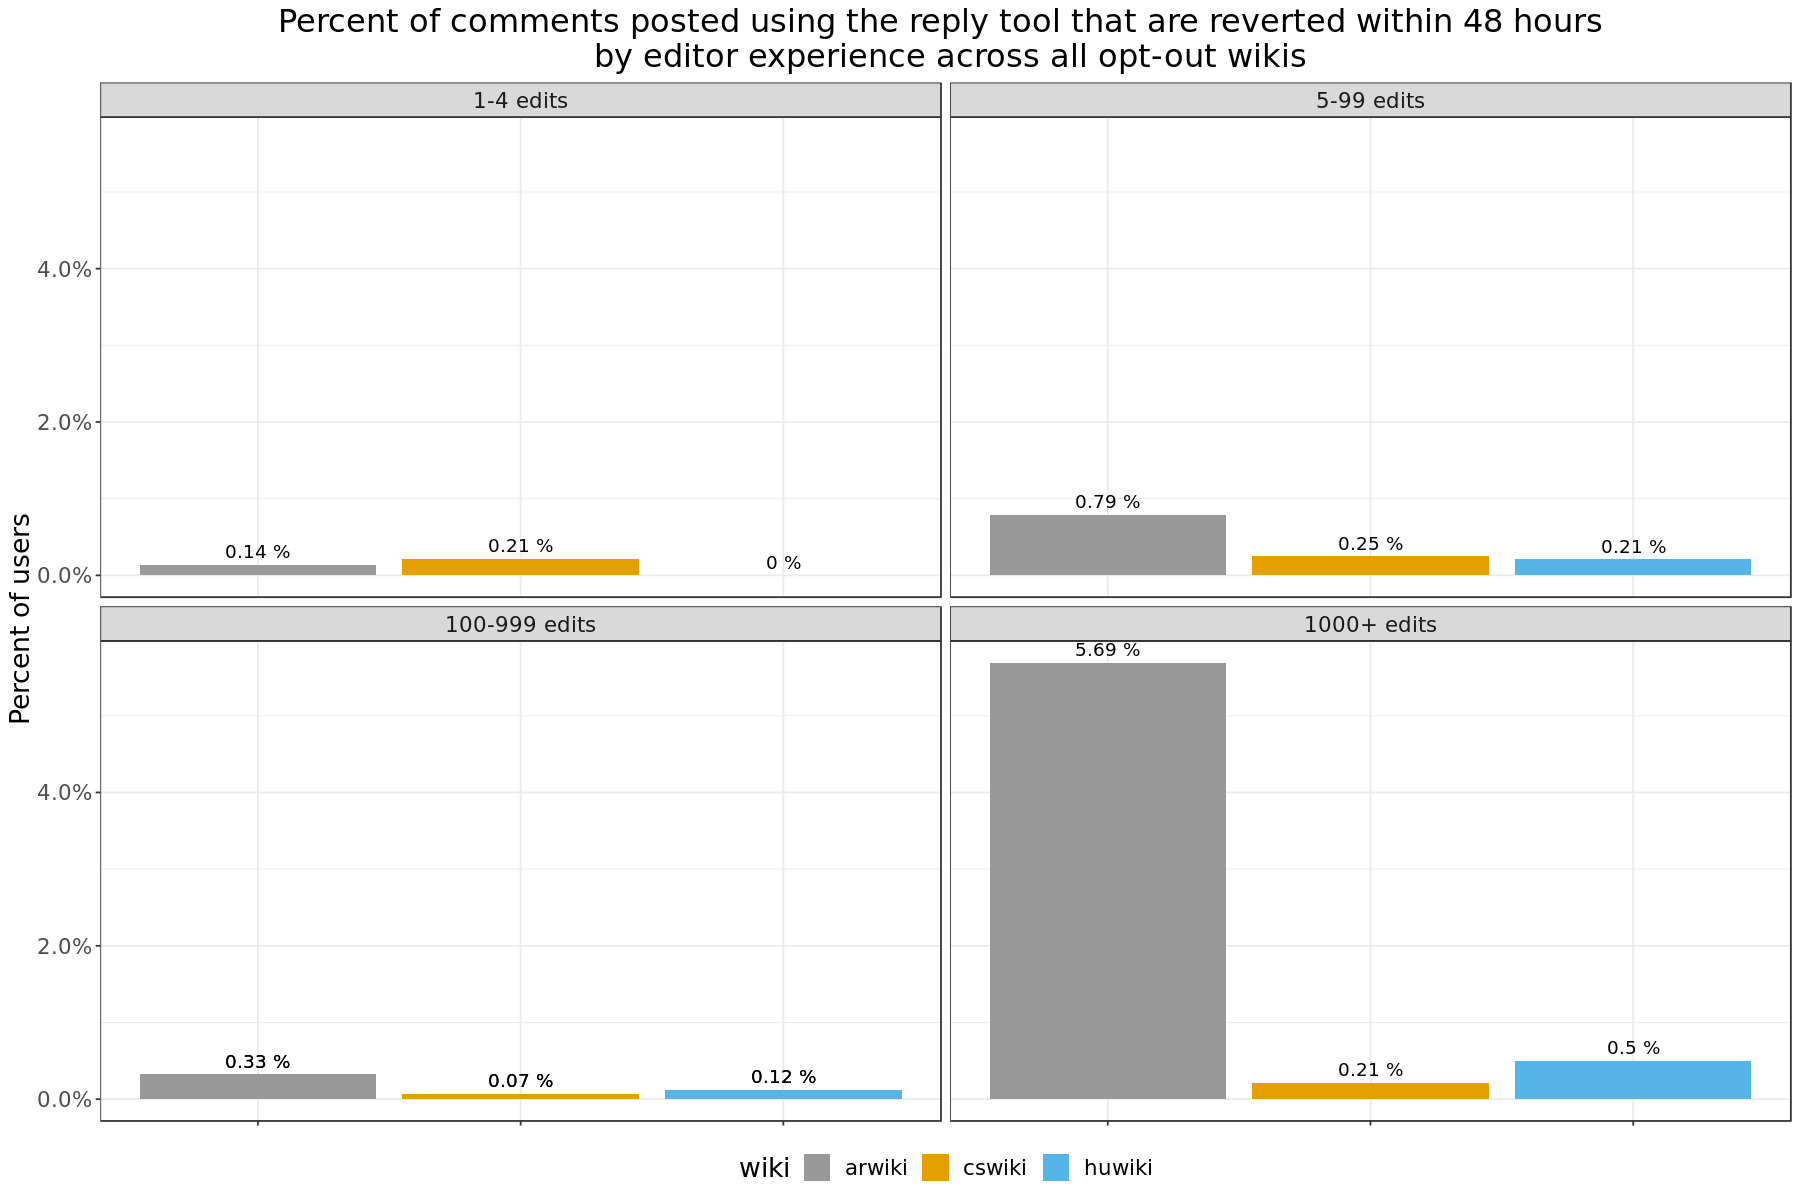

In [511]:
# plot revert rates by edit count and by wiki

p <- pct_reply_reverts_byeditcount %>%
        ggplot(aes(x=wiki, y= pct_reply_reverts, fill = wiki)) +
        facet_wrap(~edit_count_bucket) +
        geom_bar(stat='identity', position = 'dodge') +
        geom_text(aes(label = paste(round(pct_reply_reverts * 100, 2), '%')), vjust = -0.5, position = position_dodge(width = 1)) +
        labs (y = "Percent of users",
          x = "Edit Count Bucket",
         title = "Percent of comments posted using the reply tool that are reverted within 48 hours \n by editor experience across all opt-out wikis")  +
        scale_fill_manual(values = cbp1)  +
        theme_bw() +
        scale_y_continuous(labels = scales::percent) +
         theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position = 'bottom',
        axis.title.x = element_blank(),
        axis.text.x=element_blank()
        ) 
      
p
ggsave("Figures/reply_comment_reverts_byeditcount.png", p, width = 16, height = 8, units = "in", dpi = 300)

In [491]:
pct_reply_reverts_byexperience <- collect_reply_reverts %>%
    filter(experience_level != 'NA') %>%
    group_by(wiki) %>%
    mutate(total_comments = sum(num_comments))  %>%
    group_by(wiki, experience_level) %>%
    summarise(total_reply_reverts = sum(num_reverts),
              pct_reply_reverts = total_reply_reverts/total_comments, .groups = 'drop')


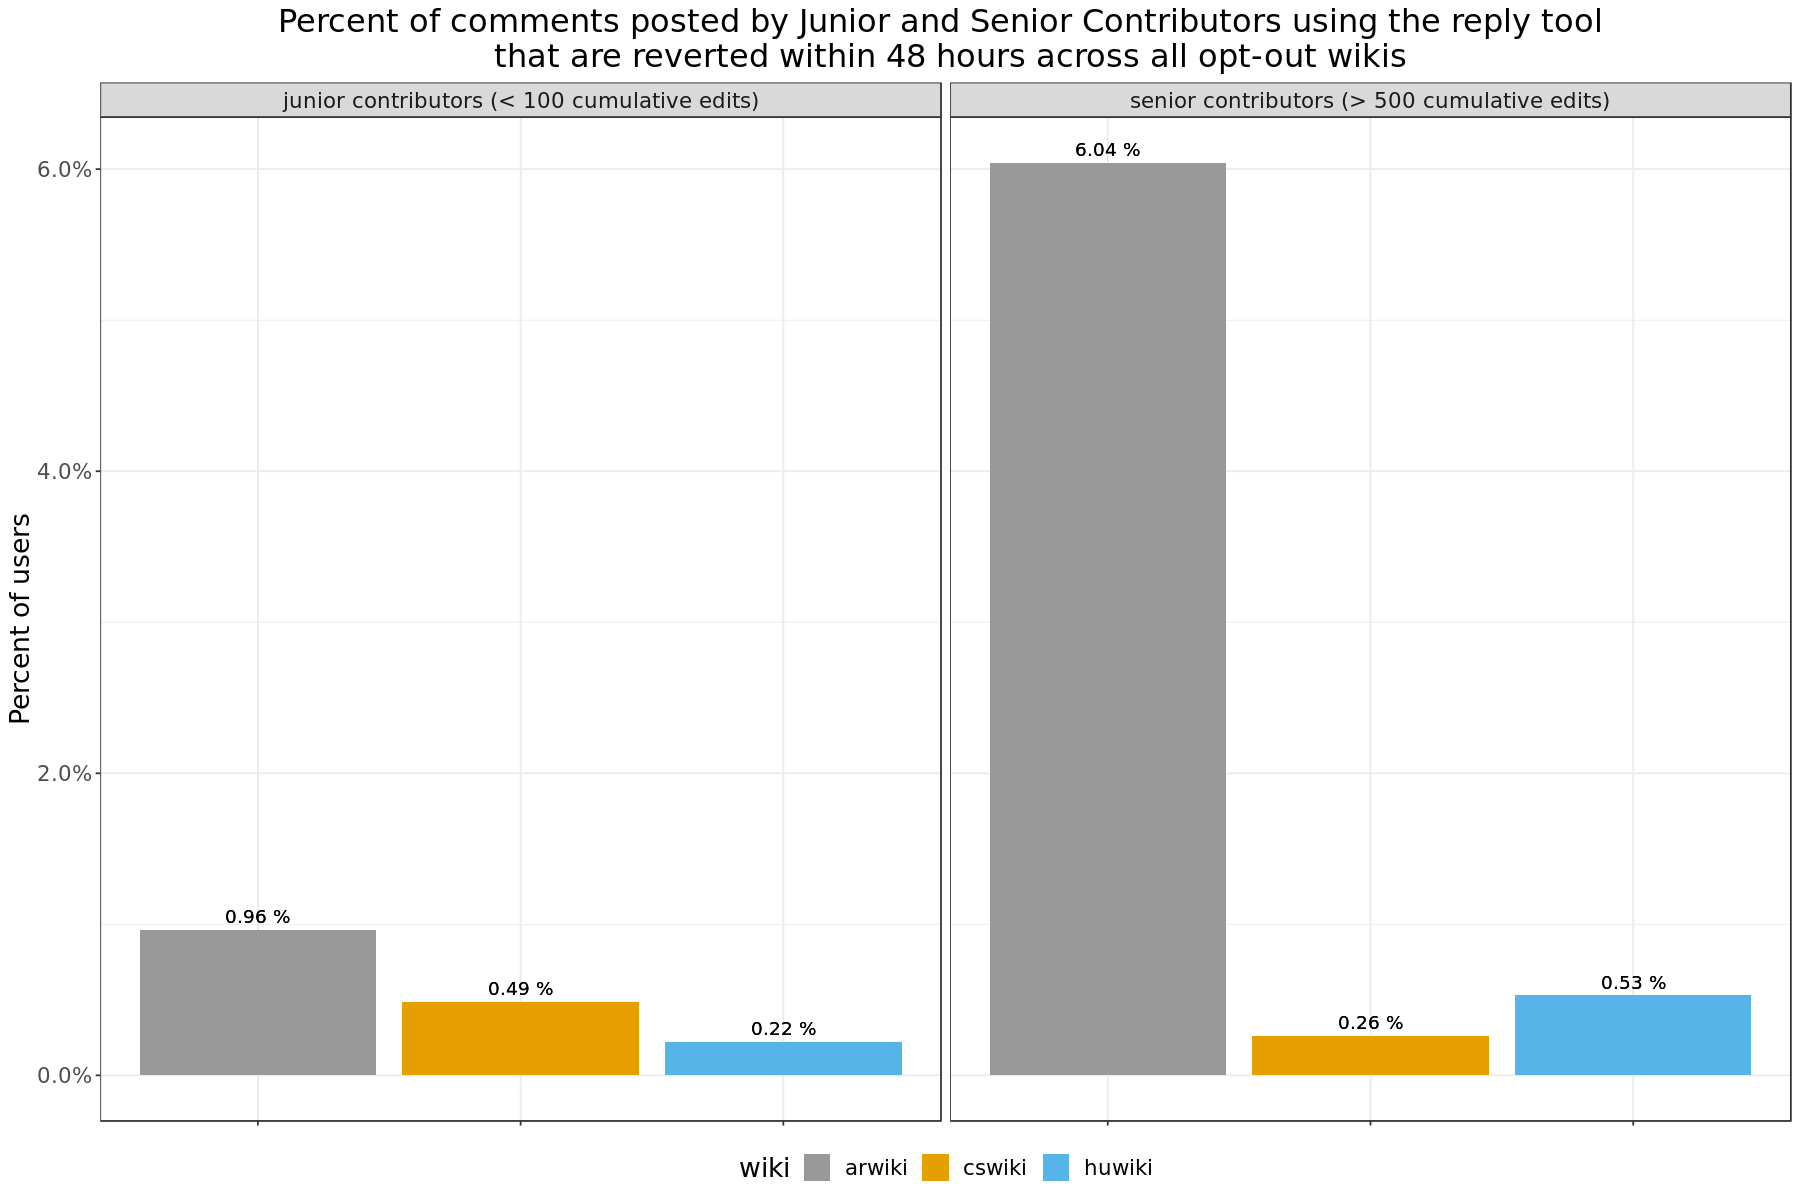

In [512]:
# plot revert rates by experience and by wiki

p <- pct_reply_reverts_byexperience %>%
        ggplot(aes(x=wiki, y= pct_reply_reverts, fill = wiki)) +
        facet_grid(~experience_level) +
        geom_bar(stat='identity', position = 'dodge') +
        geom_text(aes(label = paste(round(pct_reply_reverts * 100, 2), '%')), vjust = -0.5, position = position_dodge(width = 1)) +
        labs (y = "Percent of users",
          x = "Edit Count Bucket",
         title = "Percent of comments posted by Junior and Senior Contributors using the reply tool \n that are reverted within 48 hours across all opt-out wikis")  +
        scale_fill_manual(values = cbp1)  +
        theme_bw() +
        scale_y_continuous(labels = scales::percent) +
          theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position = 'bottom',
        axis.title.x = element_blank(),
        axis.text.x=element_blank()
        ) 
      
p
ggsave("Figures/reply_comment_reverts_byexperience.png", p, width = 16, height = 8, units = "in", dpi = 300)

We further investigated the revert rate by breaking down the revert rate by editor experience level for each of the three opt-out wikis.

As shown in the chart above, 5.69% of reverts were made by contributors with over 1000 edits on Arabic Wikipedia. This indicates that the reverts are not caused by an inexperienced contributor unable to correctly use the process but potentially by an unmarked bot.  

We reviewed the revert rates on full page wikitext talk page edits to compare if these are signficantly different than reply tool wikitext reverts rates.

### Full Talk Page WikiText Edit Revert Rates vs. Reply Tool Wikitext Revert Rates

In [422]:
# collect full page desktop wikitext edits reverted within 48 hours.
query <- "
SELECT
     wiki_db AS wiki,
    CASE
            WHEN event_user_revision_count is NULL THEN 'undefined'
            WHEN event_user_revision_count  = 0 THEN '0 edits'
            WHEN (event_user_revision_count  >=1 AND event_user_revision_count  < 5) THEN '1-4 edits'
            WHEN (event_user_revision_count  >=5 AND event_user_revision_count  < 100) THEN '5-99 edits'
            WHEN (event_user_revision_count  >=100 AND event_user_revision_count  < 1000) THEN '100-999 edits'
            ELSE '1000+ edits'
            END AS edit_count_bucket,
     CASE
            WHEN event_user_revision_count < 100 THEN 'junior contributors (< 100 cumulative edits)' 
            WHEN event_user_revision_count > 500 THEN 'senior contributors (> 500 cumulative edits)'
            ELSE 'NA'
            END AS experience_level,
     SUM(CAST(
            revision_is_identity_reverted AND 
            revision_seconds_to_identity_revert <= 172800  -- 48 hours
           AS int)) AS num_reverts,
    COUNT(*) as num_comments
FROM wmf.mediawiki_history mh 
WHERE 
    snapshot = '2020-12'
-- look only at desktop wikitext edits 
    AND NOT array_contains(revision_tags, 'visualeditor') 
    AND NOT array_contains(revision_tags, 'iOS')
    AND NOT array_contains(revision_tags, 'Android')
    AND NOT array_contains(revision_tags, 'Mobile Web')
-- review all talk page namespaces
    AND page_namespace_historical % 2 == 1 
    AND event_entity = 'revision'
    AND event_type = 'create'
    AND event_timestamp >= '2020-09-24' 
    AND event_timestamp <= '2020-12-08' 
    AND wiki_db IN ('arwiki','cswiki', 'huwiki')
    AND SIZE(event_user_is_bot_by_historical) = 0 
    AND SIZE(event_user_is_bot_by) = 0
GROUP BY 
 wiki_db ,
 CASE
            WHEN event_user_revision_count is NULL THEN 'undefined'
            WHEN event_user_revision_count  = 0 THEN '0 edits'
            WHEN (event_user_revision_count  >=1 AND event_user_revision_count  < 5) THEN '1-4 edits'
            WHEN (event_user_revision_count  >=5 AND event_user_revision_count  < 100) THEN '5-99 edits'
            WHEN (event_user_revision_count  >=100 AND event_user_revision_count  < 1000) THEN '100-999 edits'
            ELSE '1000+ edits'
            END,
 CASE
            WHEN event_user_revision_count < 100 THEN 'junior contributors (< 100 cumulative edits)' 
            WHEN event_user_revision_count > 500 THEN 'senior contributors (> 500 cumulative edits)'
            ELSE 'NA'
            END
"

In [ ]:
collect_wikitext_talk_reverts <- wmfdata::query_hive(query)

In [424]:
# Order edit counts 
collect_wikitext_talk_reverts$edit_count_bucket %<>% 
    factor(levels= c("0 edits", "1-4 edits", "5-99 edits", "100-999 edits", "1000+ edits")) 

In [ ]:
pct_wikitext_reverts_byeditcount <- collect_wikitext_talk_reverts %>%
    group_by(wiki) %>%
    mutate(total_comments = sum(num_comments))  %>%
    group_by(wiki, edit_count_bucket) %>%
    summarise(total_wikitext_reverts = sum(num_reverts),
              pct_fullpage_wikitext_reverts = total_wikitext_reverts/total_comments * 100)


In [ ]:
pct_wikitext_reverts_byexperience <- collect_wikitext_talk_reverts %>%
    group_by(wiki) %>%
    mutate(total_comments = sum(num_comments))  %>%
    group_by(wiki, experience_level) %>%
    summarise(total_wikitext_reverts = sum(num_reverts),
              pct_fullpage_wikitext_reverts = total_wikitext_reverts/total_comments * 100)


In [427]:
# collect comments posted using the Reply Tool reverted within 48 hours for wikitext only.
query <- "
SELECT
     wiki_db AS wiki,
    CASE
            WHEN event_user_revision_count is NULL THEN 'undefined'
            WHEN event_user_revision_count  = 0 THEN '0 edits'
            WHEN (event_user_revision_count  >=1 AND event_user_revision_count  < 5) THEN '1-4 edits'
            WHEN (event_user_revision_count  >=5 AND event_user_revision_count  < 100) THEN '5-99 edits'
            WHEN (event_user_revision_count  >=100 AND event_user_revision_count  < 1000) THEN '100-999 edits'
            ELSE '1000+ edits'
            END AS edit_count_bucket,
    CASE
            WHEN event_user_revision_count < 100 THEN 'junior contributors (< 100 cumulative edits)' 
            WHEN event_user_revision_count > 500 THEN 'senior contributors (> 500 cumulative edits)'
            ELSE 'NA'
            END AS experience_level,
     SUM(CAST(
            revision_is_identity_reverted AND 
            revision_seconds_to_identity_revert <= 172800  -- 48 hours
           AS int)) AS num_reverts,
    COUNT(*) as num_comments
FROM wmf.mediawiki_history mh 
WHERE 
    snapshot = '2020-12'
    AND ARRAY_CONTAINS(revision_tags, 'discussiontools')
-- isolate to only wikitext edits
    AND NOT ARRAY_CONTAINS(revision_tags, 'visualeditor')
    AND event_entity = 'revision'
    AND event_type = 'create'
    AND event_timestamp >= '2020-09-24' 
    AND event_timestamp <= '2020-12-08' 
    AND wiki_db IN ('arwiki','cswiki', 'huwiki')
    AND SIZE(event_user_is_bot_by_historical) = 0 
    AND SIZE(event_user_is_bot_by) = 0
GROUP BY 
 wiki_db ,
 CASE
            WHEN event_user_revision_count is NULL THEN 'undefined'
            WHEN event_user_revision_count  = 0 THEN '0 edits'
            WHEN (event_user_revision_count  >=1 AND event_user_revision_count  < 5) THEN '1-4 edits'
            WHEN (event_user_revision_count  >=5 AND event_user_revision_count  < 100) THEN '5-99 edits'
            WHEN (event_user_revision_count  >=100 AND event_user_revision_count  < 1000) THEN '100-999 edits'
            ELSE '1000+ edits'
            END,
 CASE
            WHEN event_user_revision_count < 100 THEN 'junior contributors (< 100 cumulative edits)' 
            WHEN event_user_revision_count > 500 THEN 'senior contributors (> 500 cumulative edits)'
            ELSE 'NA'
            END
"

In [ ]:
collect_wikitext_comment_reverts <- wmfdata::query_hive(query)

In [429]:
# Order edit counts 
collect_wikitext_comment_reverts $edit_count_bucket %<>% 
    factor(levels= c("0 edits", "1-4 edits", "5-99 edits", "100-999 edits", "1000+ edits")) 

In [430]:
experience_level_names <- c(
                    `junior contributors (< 100 cumulative edits)` = "junior contributors \n (< 100 cumulative edits)",
                    `senior contributors (> 500 cumulative edits)` = "senior contributors \n (> 500 cumulative edits)"
                    )

In [ ]:
pct_reply_wikitext_reverts_byeditcount <- collect_wikitext_comment_reverts %>%
    group_by(wiki) %>%
    mutate(total_comments = sum(num_comments))  %>%
    group_by(wiki, edit_count_bucket) %>%
    summarise(total_reply_wikitext_reverts = sum(num_reverts),
              pct_reply_wikitext_reverts = total_reply_wikitext_reverts/total_comments * 100)



In [ ]:
pct_reply_wikitext_reverts_byexperience <- collect_wikitext_comment_reverts %>%
    filter(experience_level != 'NA') %>%
    group_by(wiki) %>%
    mutate(total_comments = sum(num_comments))  %>%
    group_by(wiki, experience_level) %>%
    summarise(total_reply_wikitext_reverts = sum(num_reverts),
              pct_reply_wikitext_reverts = total_reply_wikitext_reverts/total_comments * 100)



In [ ]:
# join revert rate tables for editcount
revert_rate_comparison_editcount <- inner_join(pct_reply_wikitext_reverts_byeditcount, pct_wikitext_reverts_byeditcount) %>%
# remove uneeded columns to simplify
    select(-c(3,5)) %>%
## rename columns to clarify
rename(full_talkpage_wikitext = pct_fullpage_wikitext_reverts,
    reply_wikitext = pct_reply_wikitext_reverts)

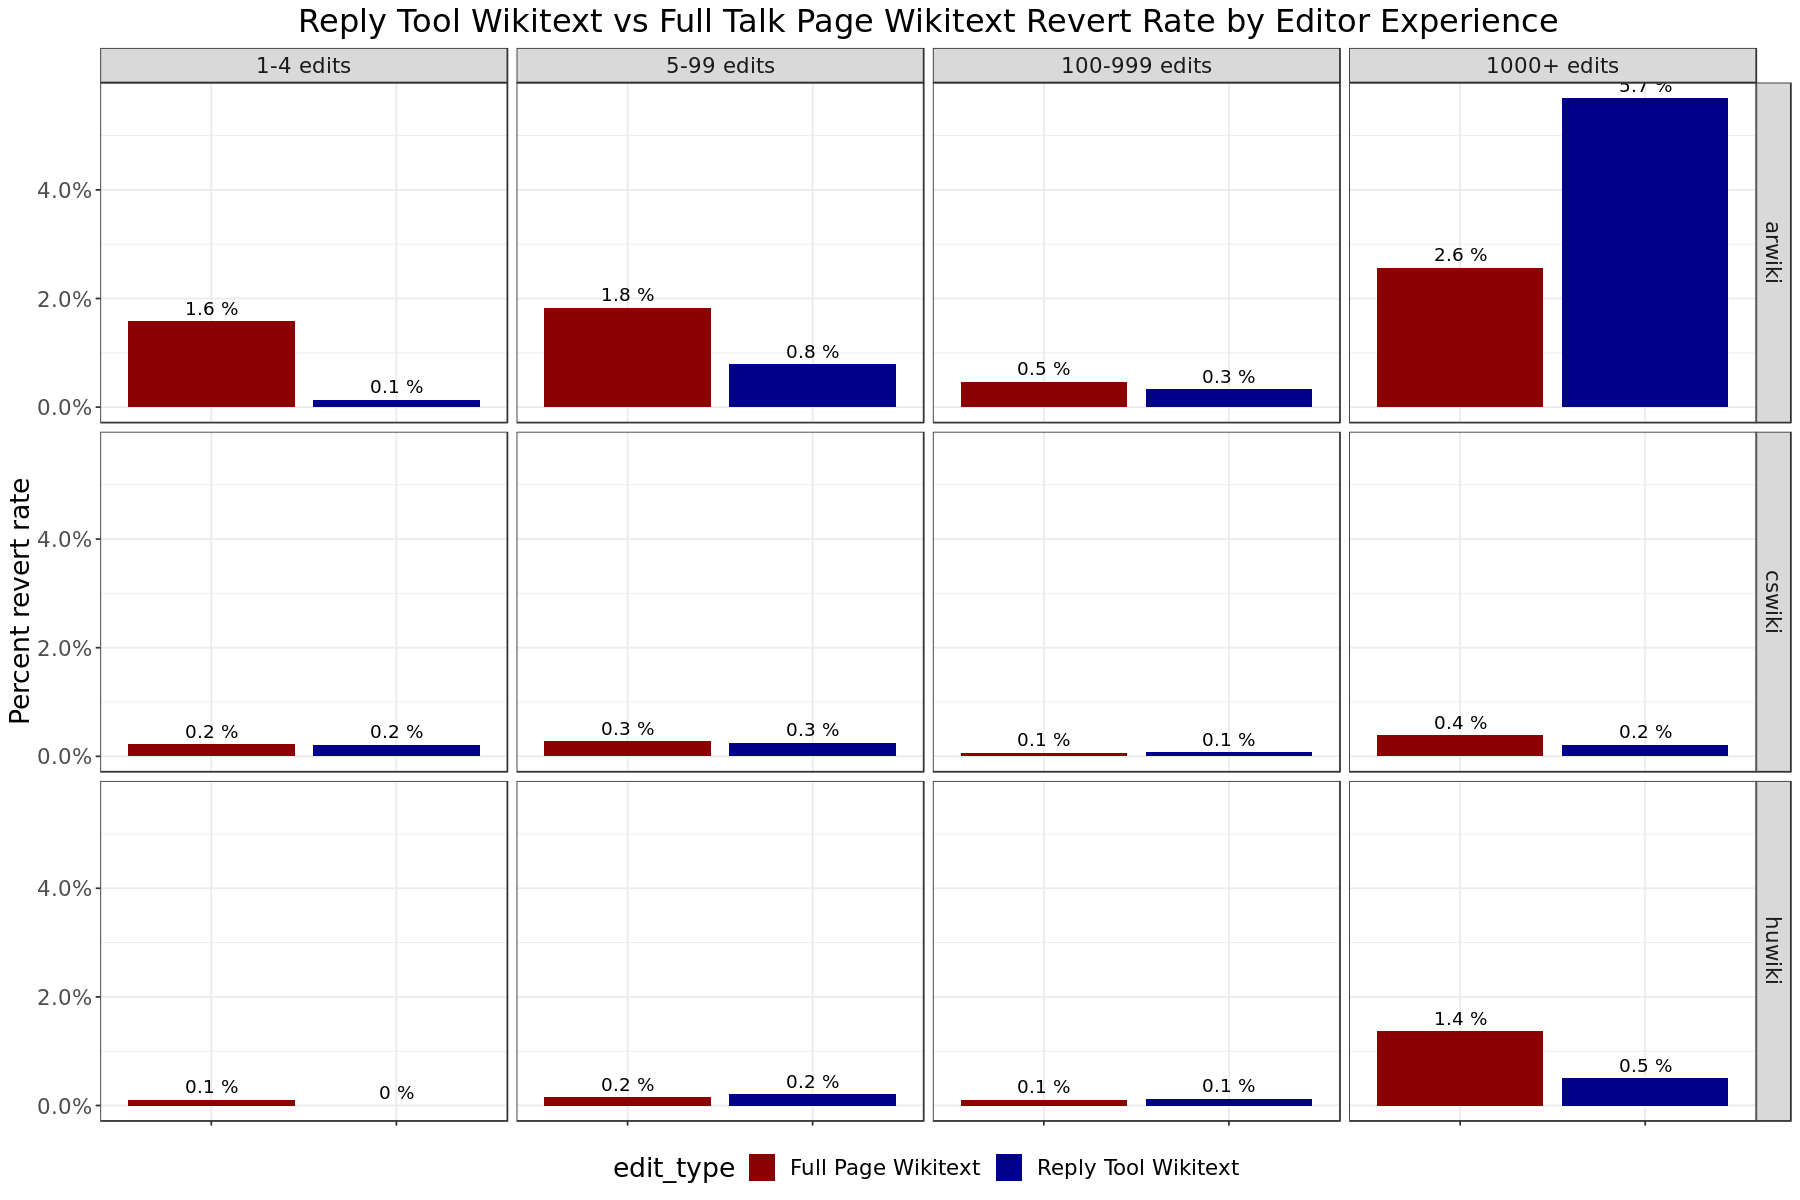

In [494]:
# plot comparison between full page and reply tool completion rates by editor experience

p <- revert_rate_comparison_editcount %>%
    distinct() %>%
    gather("edit_type", "revert_rate", 3:4)  %>%
     ggplot(aes(x=edit_type, y= revert_rate/100, fill = edit_type)) +
        facet_grid (wiki~edit_count_bucket) +
        geom_bar(stat='identity', position = 'dodge') +
        scale_y_continuous(labels = scales::percent) +
        geom_text(aes(label = paste(round(revert_rate, 1), '%')), vjust = -0.5, position = position_dodge(width = 1)) +
        labs (y = "Percent revert rate",
          x = "Edit Count Bucket",
         title = "Reply Tool Wikitext vs Full Talk Page Wikitext Revert Rate by Editor Experience")  +
         theme_bw() +
        scale_fill_manual(values = c('red4', 'darkblue'), labels = c('Full Page Wikitext', 'Reply Tool Wikitext'))  +
         theme(
        legend.position="bottom",
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.title.x = element_blank(),
        axis.text.x=element_blank()
        ) 
      
p

ggsave("Figures/fullpage_wikitext_vs_reply_revert_editcount.png", p, width = 16, height = 8, units = "in", dpi = 300)

In [ ]:
# join revert rate tables by experience level
revert_rate_comparison_experience <- inner_join(pct_reply_wikitext_reverts_byexperience, pct_wikitext_reverts_byexperience) %>%
# remove uneeded columns to simplify
    select(-c(3,5)) %>%
## rename columns to clarify
rename(full_talkpage_wikitext = pct_fullpage_wikitext_reverts,
    reply_wikitext = pct_reply_wikitext_reverts)

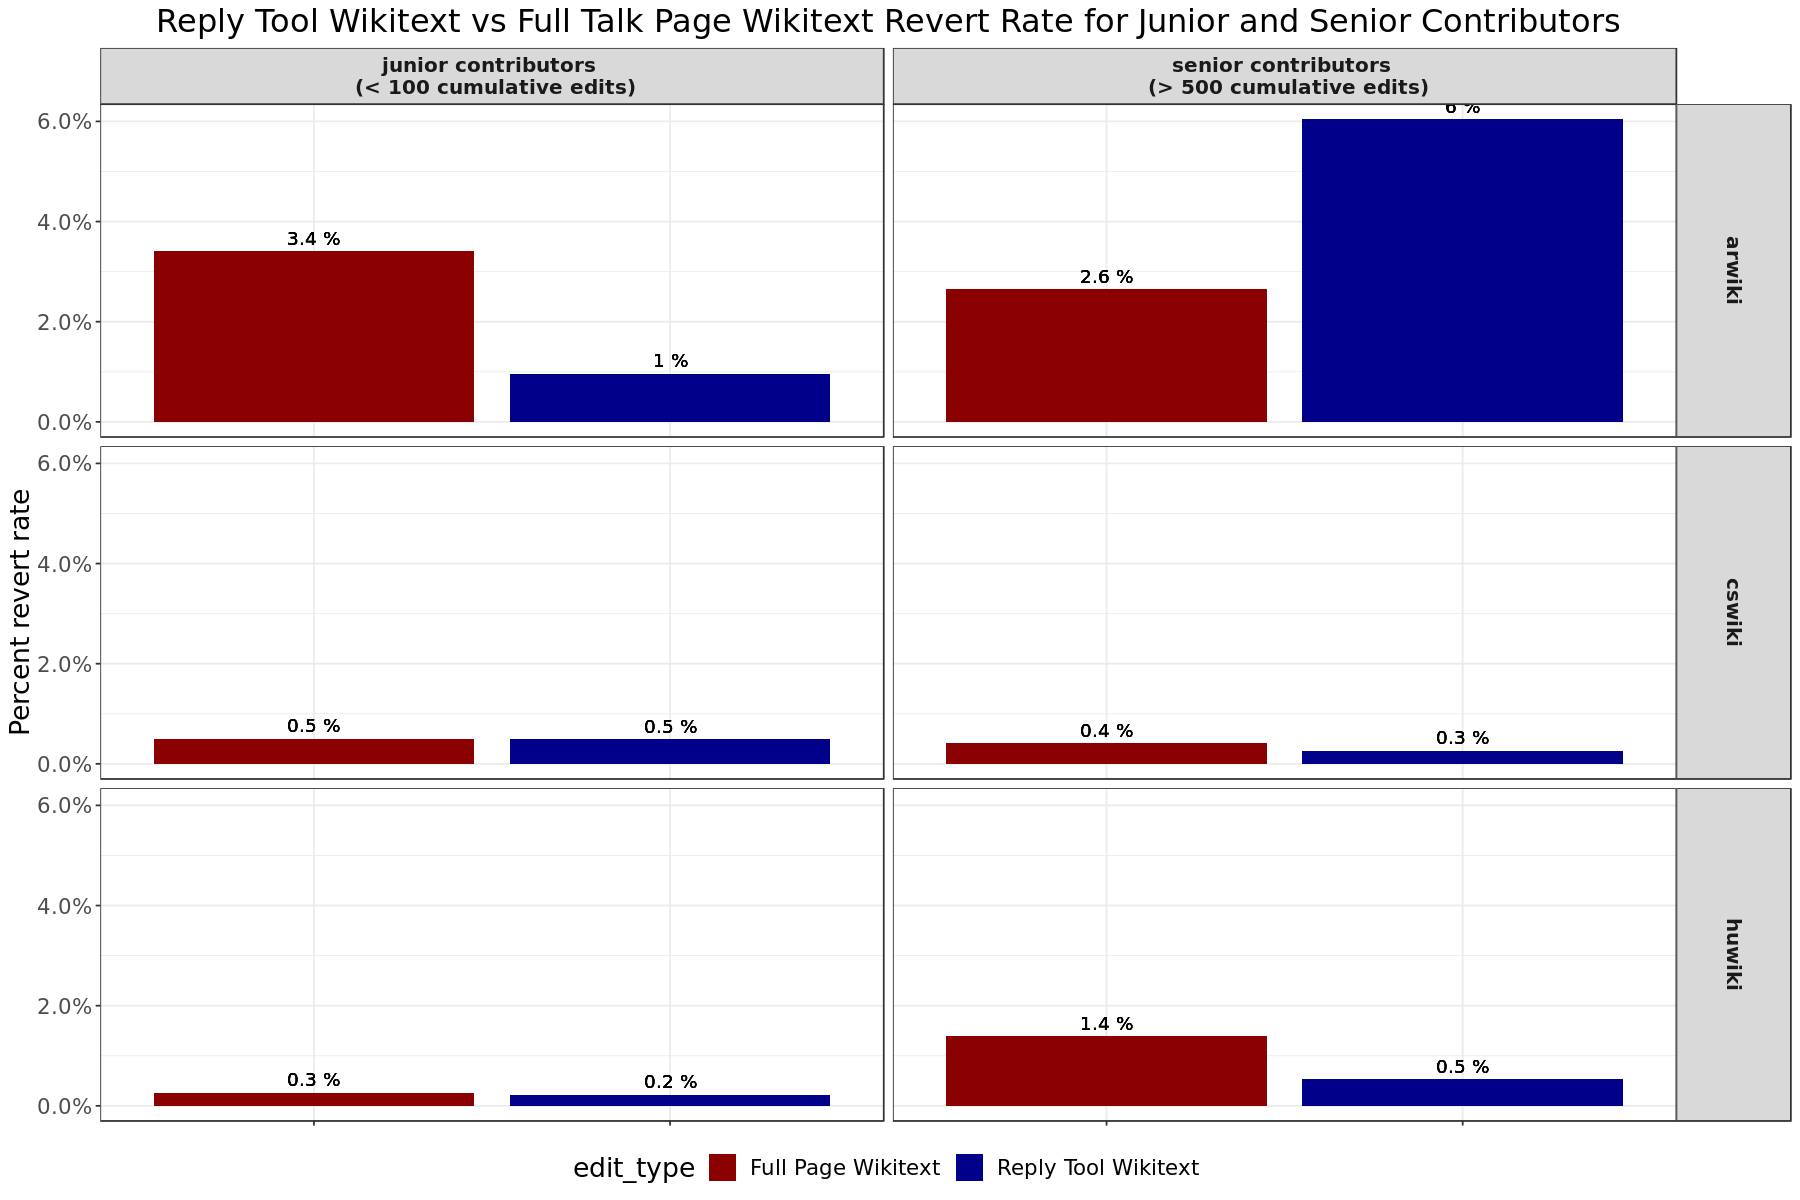

In [495]:
# plot comparison between full page and reply tool completion rates by editor experience

p <- revert_rate_comparison_experience %>%
    gather("edit_type", "revert_rate", 3:4)  %>%
     ggplot(aes(x=edit_type, y= revert_rate/100, fill = edit_type)) +
        facet_grid (wiki~experience_level, labeller = labeller(experience_level =experience_level_names)) +
        geom_col(position = 'dodge') +
        scale_y_continuous(labels = scales::percent) +
        geom_text(aes(label = paste(round(revert_rate, 1), '%')), vjust = -0.5, position = position_dodge(width = 1)) +
        labs (y = "Percent revert rate",
          x = "Experience Level",
         title = "Reply Tool Wikitext vs Full Talk Page Wikitext Revert Rate for Junior and Senior Contributors")  +
         theme_bw() +
        scale_fill_manual(values = c('red4', 'darkblue'), labels = c('Full Page Wikitext', 'Reply Tool Wikitext'))  +
         theme(
        legend.position="bottom",
        strip.text = element_text(face="bold", size=12),
        strip.text.y = element_text(margin = margin(1, 1, 1, 1, "cm")),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        axis.title.x = element_blank(),
        axis.text.x=element_blank()
        ) 
      
p

ggsave("Figures/fullpage_wikitext_vs_reply_revert_experience.png", p, width = 16, height = 8, units = "in", dpi = 300)

The reply tool had a lower revert rate compared to full talk page wikitext edits for all experience levels except for Senior Contributors on Arabic Wikipedia.

On Arabic Wikipedia, there is higher percent of wikitext reply reverts from editors with over 1000 edits (5.7% vs 2.6%) compared to the revert rate on full talk page wikitext edits.  However, for contributors with under 1000 edits the reply tool revert rate is lower than the revert rate on full talk page wikitext edits.

# Number of people blocked after posting a reply using DiscussionTools

We also reviewed the number of people blocked after posting a reply using DiscussionTools.

Data comes from the mediawiki_user_history table. All block events identifed in the data by `caused_by_event_type = "alterblocks".`  Note this may includes users that were blocked after posting a reply but may not necessarily have been blocked due to the reply.


In [451]:
query <- "

-- find users that made at least one edit with the reply tool
WITH reply_users AS (
SELECT
    event_user_id as reply_user,
    wiki_db as reply_wiki,
    min(mh.event_timestamp) as first_reply_time,
    CASE
            WHEN event_user_revision_count is NULL THEN 'undefined'
            WHEN event_user_revision_count  = 0 THEN '0 edits'
            WHEN (event_user_revision_count  >=1 AND event_user_revision_count  < 5) THEN '1-4 edits'
            WHEN (event_user_revision_count  >=5 AND event_user_revision_count  < 100) THEN '5-99 edits'
            WHEN (event_user_revision_count  >=100 AND event_user_revision_count  < 1000) THEN '100-999 edits'
            ELSE '1000+ edits'
            END AS edit_count_bucket,
    CASE
            WHEN event_user_revision_count < 100 THEN 'junior contributors (< 100 cumulative edits)' 
            WHEN event_user_revision_count > 500 THEN 'senior contributors (> 500 cumulative edits)'
            ELSE 'NA'
            END AS experience_level
FROM wmf.mediawiki_history AS mh
WHERE 
    ARRAY_CONTAINS(revision_tags, 'discussiontools') AND
    snapshot = '2020-12' AND
    event_timestamp BETWEEN '2020-09-24'  AND '2020-12-08' AND
    wiki_db IN ('arwiki','cswiki', 'huwiki') AND 
-- remove bots
    SIZE(event_user_is_bot_by_historical) = 0 AND
    SIZE(event_user_is_bot_by) = 0 AND
    event_entity = 'revision' AND 
    event_type = 'create' AND
-- remove anonymous users
    event_user_id IS NOT NULL
GROUP BY
    event_user_id,
    wiki_db,
    CASE
            WHEN event_user_revision_count is NULL THEN 'undefined'
            WHEN event_user_revision_count  = 0 THEN '0 edits'
            WHEN (event_user_revision_count  >=1 AND event_user_revision_count  < 5) THEN '1-4 edits'
            WHEN (event_user_revision_count  >=5 AND event_user_revision_count  < 100) THEN '5-99 edits'
            WHEN (event_user_revision_count  >=100 AND event_user_revision_count  < 1000) THEN '100-999 edits'
            ELSE '1000+ edits'
            END ,
    CASE
            WHEN event_user_revision_count < 100 THEN 'junior contributors (< 100 cumulative edits)' 
            WHEN event_user_revision_count > 500 THEN 'senior contributors (> 500 cumulative edits)'
            ELSE 'NA'
            END 
),
--find users that are blocked sitewide
blocked_users AS (
SELECT 
    h1.user_id AS blocked_user,
    h1.wiki_db AS blocked_wiki,
    min(h1.start_timestamp) AS block_time 
FROM(
    SELECT *
    FROM wmf.mediawiki_user_history
WHERE 
    snapshot = '2020-12'
    AND start_timestamp BETWEEN '2020-09-24'  AND '2020-12-08'
    AND wiki_db IN ('arwiki', 'cswiki', 'huwiki')
    AND caused_by_event_type = 'alterblocks'
    AND inferred_from IS NULL) as h1
LEFT JOIN (
SELECT * FROM wmf.mediawiki_user_history
    WHERE snapshot = '2020-12'
    AND end_timestamp BETWEEN '2020-09-24' AND '2020-12-08'
    AND wiki_db IN ('arwiki', 'cswiki', 'huwiki')
    AND caused_by_event_type = 'alterblocks'
    AND inferred_from IS NULL) AS h2
ON (h1.wiki_db = h2.wiki_db
    AND h1.user_id = h2.user_id
    AND h1.start_timestamp = h2.end_timestamp)
WHERE h2.start_timestamp IS NULL
GROUP BY h1.wiki_db, h1.user_id
)

-- Main Query --
SELECT
    reply_wiki AS wiki,
    edit_count_bucket AS edit_count_bucket,
    experience_level AS experience_level,
    SUM(CAST(blocked_user IS NOT NULL and first_reply_time < block_time AS int)) AS blocked_reply_tool_user,
    COUNT(*) AS all_reply_tool_users

FROM (
SELECT
    reply_users.first_reply_time,
    blocked_users.block_time,
    reply_users.reply_wiki,
    blocked_users.blocked_user,
    reply_users.edit_count_bucket,
    reply_users.experience_level
FROM reply_users
LEFT JOIN blocked_users ON 
    reply_users.reply_user = blocked_users.blocked_user AND
    reply_users.reply_wiki = blocked_users.blocked_wiki 
) sessions
GROUP BY
    reply_wiki,
    edit_count_bucket,
    experience_level
"

In [ ]:
collect_blocked_users <- wmfdata::query_hive(query)

In [453]:
# Order edit counts 
collect_blocked_users$edit_count_bucket %<>% 
    factor(levels= c("0 edits", "1-4 edits", "5-99 edits", "100-999 edits", "1000+ edits")) 

### Blocked Users by Wiki

In [496]:
pct_blocks_bywiki <- collect_blocked_users %>%
    group_by(wiki) %>%
    summarise(total_blocked_users = sum(blocked_reply_tool_user),
              total_reply_users = sum(all_reply_tool_users),
              pct_blocked_reply_users = total_blocked_users/total_reply_users * 100, .groups = 'drop')

pct_blocks_bywiki

wiki   total_blocked_users total_reply_users pct_blocked_reply_users
1 arwiki 10                  388               2.5773196              
2 cswiki  4                  455               0.8791209              
3 huwiki  6                  332               1.8072289

Only 1.70% of all reply tool users were blocked after posting a comment across all three opt-out wikis. Arabic Wikipedia had the highest percent of blocked users (2.57% [10 reply tool users were blocked]) while Czech Wikpedia had the lowest percent of blocked users (0.88% [4 total reply tool users were blocked)).

### Blocked users by Wiki and Experience Level

In [ ]:
pct_reply_blocks_byeditcount <- collect_blocked_users %>%
    group_by(wiki) %>%
    mutate(total_reply_users = sum(all_reply_tool_users))  %>%
    group_by(wiki, edit_count_bucket) %>%
    summarise(total_blocked_users = sum(blocked_reply_tool_user),
              pct_blocked_reply_users = total_blocked_users/total_reply_users)


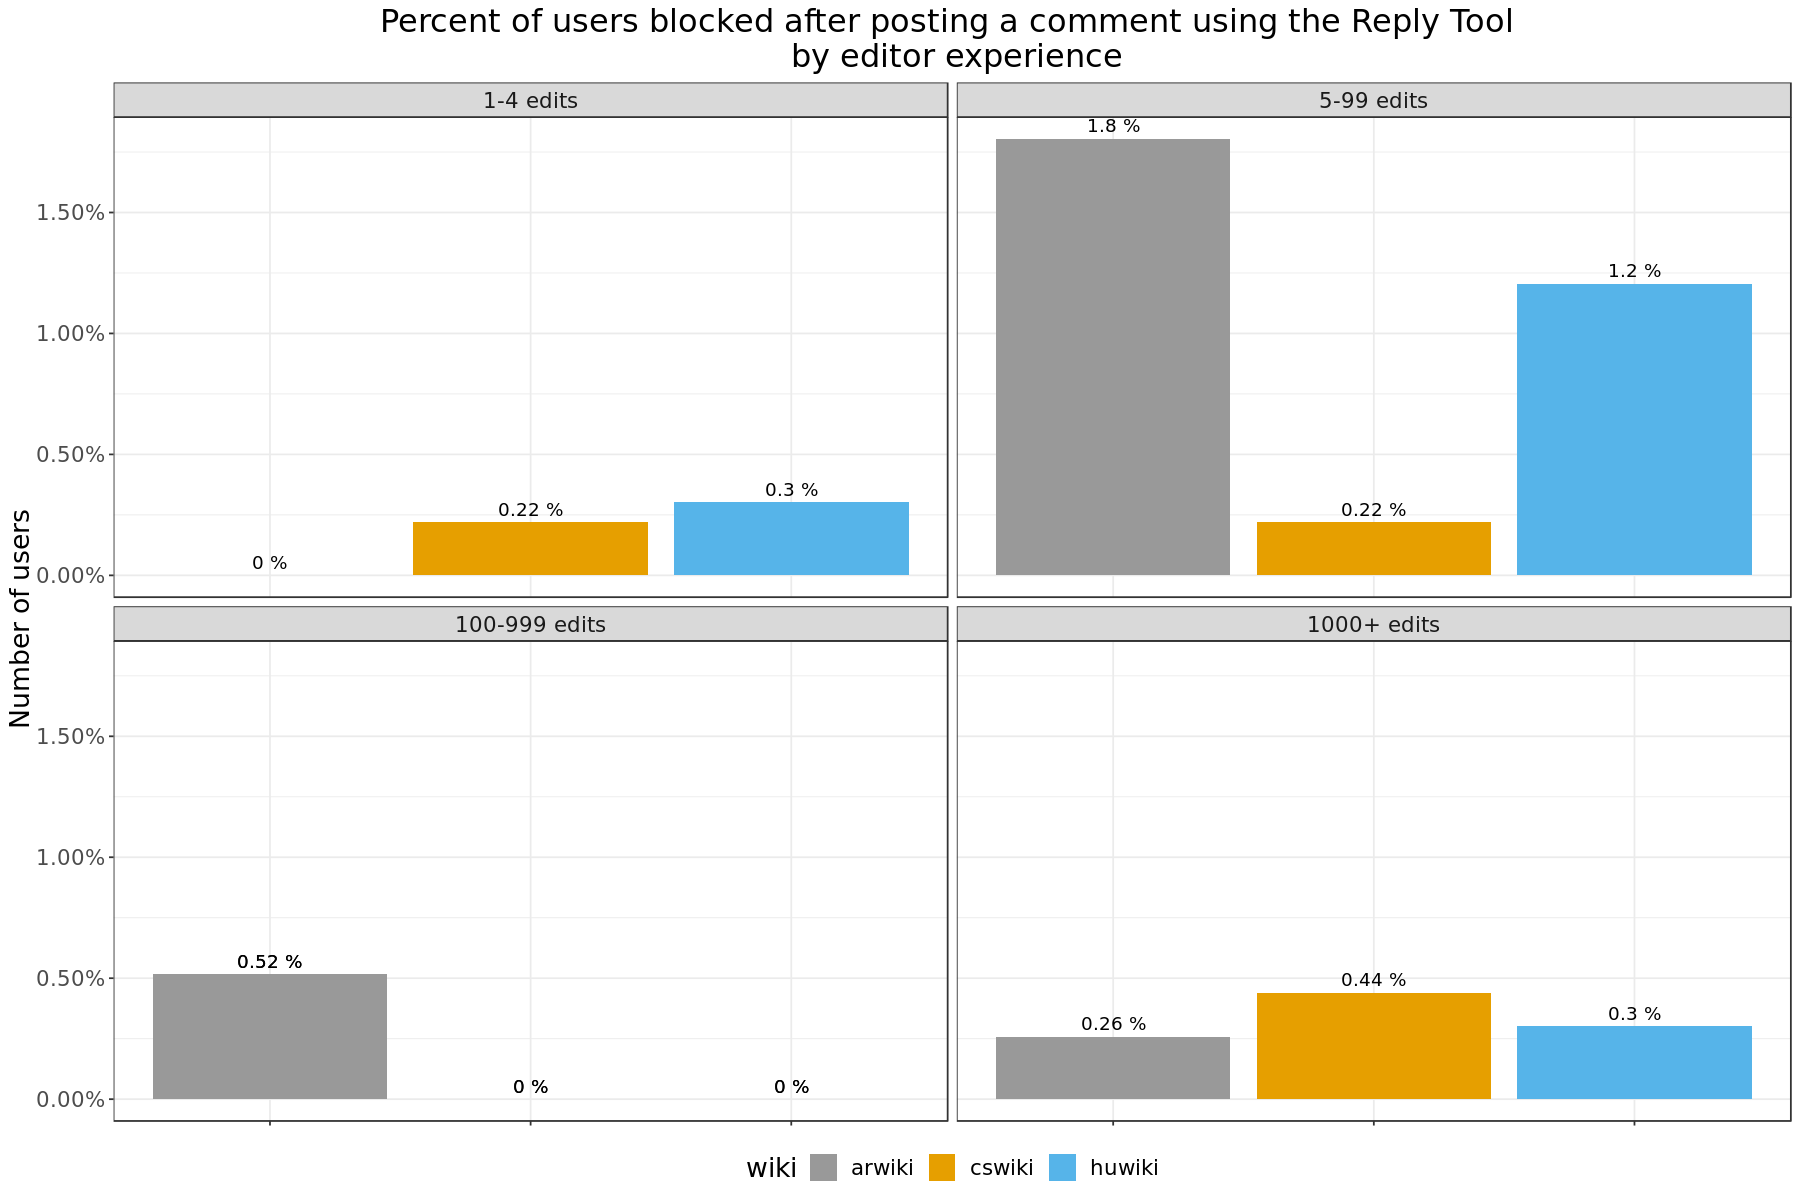

In [513]:
# plot revert rates by experience and by wiki

p <- pct_reply_blocks_byeditcount %>%
        ggplot(aes(x=wiki, y= pct_blocked_reply_users, fill = wiki)) +
        facet_wrap(~edit_count_bucket) +
        geom_bar(stat='identity', position = 'dodge') +
        geom_text(aes(label = paste(round(pct_blocked_reply_users * 100, 2), '%')), vjust = -0.5, position = position_dodge(width = 1)) +
         scale_y_continuous(labels = scales::percent) +
        labs (y = "Number of users",
          x = "Edit Count Bucket",
         title = "Percent of users blocked after posting a comment using the Reply Tool \n by editor experience")  +
         theme_bw() +
         scale_fill_manual(values = cbp1)  +
         theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.title.x = element_blank(),
        axis.text.x=element_blank()
        )
      
p

ggsave("Figures/reply_tool_user_blocks_byeditcount.png", p, width = 16, height = 8, units = "in", dpi = 300)

In [ ]:
pct_reply_blocks_byexperience <- collect_blocked_users %>%
    filter(experience_level != 'NA') %>%
    group_by(wiki) %>%
    mutate(total_reply_users = sum(all_reply_tool_users))  %>%
    group_by(wiki, experience_level) %>%
    summarise(total_blocked_users = sum(blocked_reply_tool_user),
              pct_blocked_reply_users = total_blocked_users/total_reply_users)

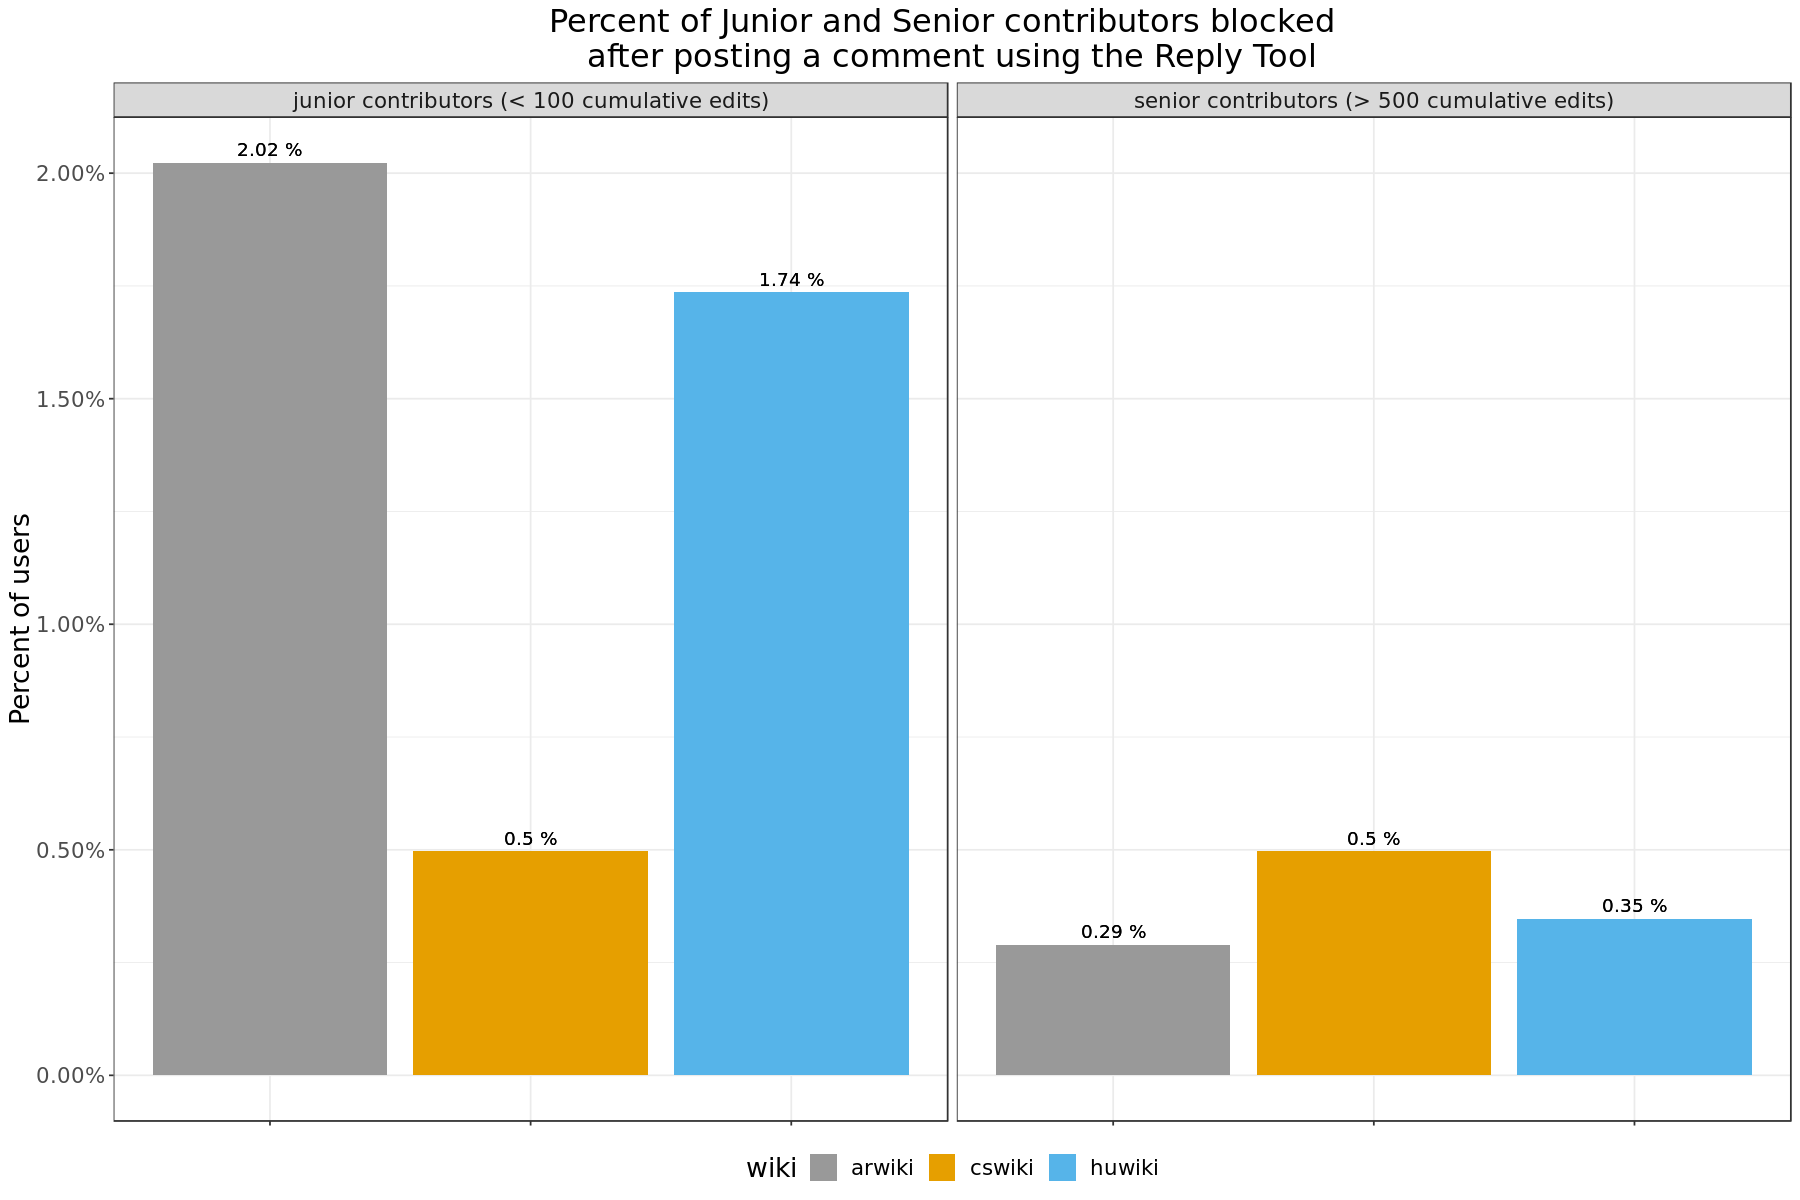

In [514]:
p <- pct_reply_blocks_byexperience %>%
        ggplot(aes(x=wiki, y= pct_blocked_reply_users, fill = wiki)) +
        facet_wrap(~experience_level) +
        geom_bar(stat='identity', position = 'dodge') +
        geom_text(aes(label = paste(round(pct_blocked_reply_users * 100, 2), '%')), vjust = -0.5, position = position_dodge(width = 1)) +
         scale_y_continuous(labels = scales::percent) +
        labs (y = "Percent of users",
          x = "Edit Count Bucket",
         title = "Percent of Junior and Senior contributors blocked  \n after posting a comment using the Reply Tool ")  +
         theme_bw() +
         scale_fill_manual(values = cbp1)  +
         theme(
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position = 'bottom',
        axis.title.x = element_blank(),
        axis.text.x=element_blank()
        ) 
      
p

ggsave("Figures/reply_tool_user_blocks_byexperience.png", p, width = 16, height = 8, units = "in", dpi = 300)

On Arabic and Hungarian Wikipedias, the largest percent of blocked users were those with between 5 to 99 cumulative edits. This is likely because the majority of reply tool users that posted a comment on these two wikis were those with 5 to 99 edits. 